## Challenge3
>For this challenge you have to build your own locality sensitive hash function to hash small videos.  
You will get around 5GB (compressed) of videos (around 10k small videos).   
You have to write an LSH that takes a video and returns hash. You then have to cluster the videos using these hashes.

### Part1: Video Hashing - Coding LSH Algorithm
In order to write an LSH that takes a video and returns hash, we chose imageio, imagehash, and ffmpeg library.   
Where imageio is for extracting frames' data from given videos, ffmpeg is for converting a mp4 format data to other data type, and imagehash is for generate hashes for each frame's data.
### Preparation
First, import some libraries.

In [331]:
from PIL import Image
import imagehash
import imageio
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Then access to a folder called "videos" which has all videos we need to analyze, and extracted all video names.

In [359]:
# import glob to access to contents of the "videos" directory
import glob
# store all video names
filenames = [r.split('/')[-1][:-4] for r in glob.glob('./videos/*')]

### Concept of our video hashing

### 1. Get data of frames from a given video  
    we first get data of each frame from a given video by using imageio.   
    imageio returns the data of frames as array data type like below:
![](https://github.com/Honobono1124/CTB-Challenge3/blob/master/images/Screen%20Shot%202017-12-11%20at%2021.28.15.png?raw=true)
### 2. Merge array type data and generate a averaged frame  
    In order to generate one hash from a given video, we merged all arrays into one array and made a single image
    
### 3. Generate a Hash from an averaged image  
    Finally we generated one hash by using imagehash as below: 
![](https://raw.githubusercontent.com/Honobono1124/CTB-Challenge3/master/images/Screen%20Shot%202017-12-11%20at%2021.55.51.png)

### Code
In accordance with the concept, we made a function <font color='red'>hasher</font>.

In [313]:
def hasher(filename,num):
    # open a video file
    with imageio.get_reader("./videos/%s.mp4"%filename,'ffmpeg') as video:
        # In order to marge arrays of frames, get a data shape
        N,w,_=video.get_data(0).shape
        # set a empty array having same data shape as the given data
        arr = np.zeros((N,w,3),np.float)
        # merge arrays
        for img in video:
            arr += np.array(img)
        # divided merged array by N to normalize the arrary
        arr=np.array(np.round(arr/N),dtype=np.uint8)
        # generate a hash from the merged array
        Hash = imagehash.phash(Image.fromarray(arr))
    # return filename and hash
    return (filename,Hash)

We ran this function for all video files with multiple processing library called <font color='red'>joblib</font>.  
The execution time was <font color='red'> 57min 19s</font>, and stored the computed data into <font color='red'>Nodes</font>.  

In [314]:
%%time
from joblib import Parallel, delayed
Nodes = Parallel(n_jobs=-1)([delayed(hasher)(filename,num) for num,filename in enumerate(filenames)])

CPU times: user 7.02 s, sys: 1.2 s, total: 8.22 s
Wall time: 57min 19s


In [ ]:
# save a list "Nodes "
import pickle
with open("video_phashes.pickle","wb") as f:
    Nodes = pickle.load(f)

## Part2: Clustering Hashes
### Concept of clustering hashes

### 1. Pick a node(hash) randomly and list nearest 10 nodes
    First we choose a node (hash) from <font color='red'>Nodes</font> randomly.  
    Then compute distances between the node and other nodes, and list top 10 nearest nodes.
![](https://github.com/Honobono1124/CTB-Challenge3/blob/master/images/Nearest9nodes.png?raw=true)
### 2. Select most center-like node from the nearest nodes by computing distances between a node and nearest 10 nodes
    A node which is a center of a certain cluster is supposed to have the minimum total of distances between around 9 nodes, thus we compute total of distances for each node in nearest 10 nodes. Then find a node which has the minimum total of distances among 10 nodes.
![](https://github.com/Honobono1124/CTB-Challenge3/blob/master/images/Random_nodes.png?raw=true)   
### 3. Regard the nearest 10 nodes of a center-like node as one cluster and remove the nodes, back to 1.
    Finally we remove the nearest 10 nodes of a center-like node from "Nodes" and repeat to pick up a node from the rest of nodes.
![](https://github.com/Honobono1124/CTB-Challenge3/blob/master/images/Restofnodes.png?raw=true)   
###  How to compute a distance between hashes ?
The hashes we generated has a binary data and it allows us to compute a distance by just subtracting.  
Below we showed some examples of distances between similar pictures and not-similar pictures.  
Can be seen below, similar pictures have a smaller value (hamming distance: 8) than that of non-similar pictures (hamming distance: 34). 

In [ ]:
%load distance_sample.py

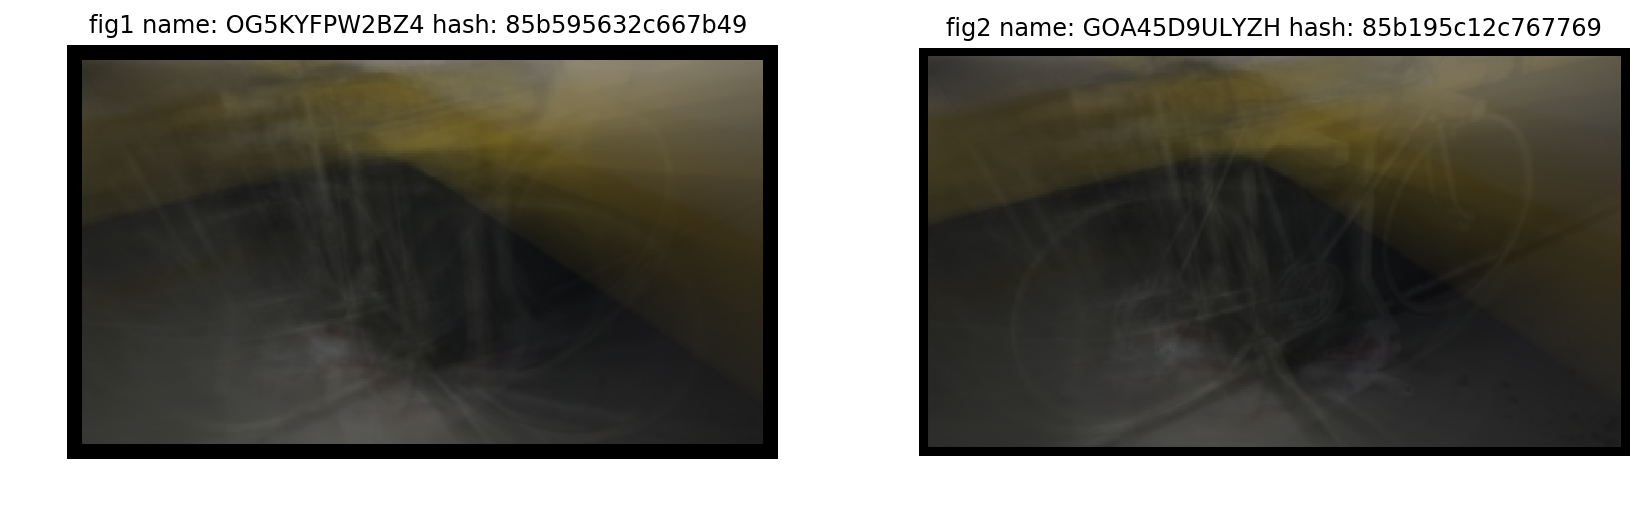

Hamming Distance: 8


In [332]:
distance_sample('OG5KYFPW2BZ4', 'GOA45D9ULYZH')

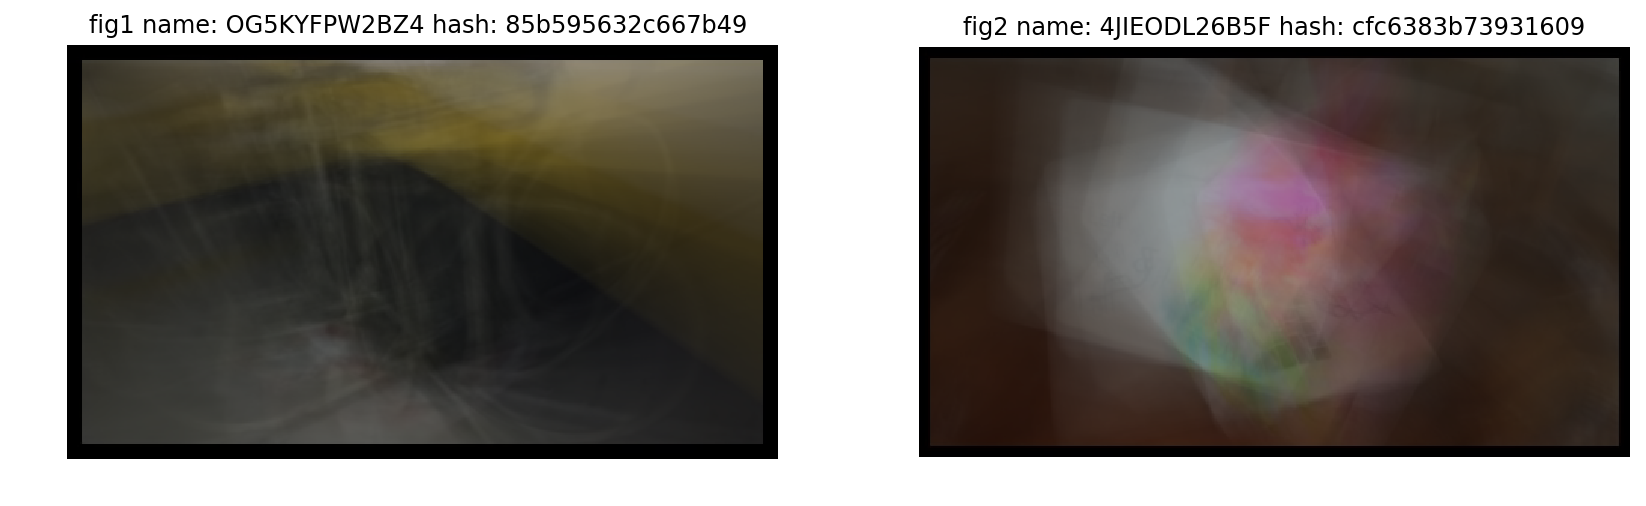

Hamming Distance: 34


In [333]:
distance_sample('OG5KYFPW2BZ4', '4JIEODL26B5F')

### Code
In accordance with the concept, we made a code as follows:

In [393]:
import time as t
time_start = t.clock()
# set a empty list which will be a list of 970 clusters
clusters = []

# import Nodes
import pickle
with open("video_phashes.pickle","rb") as f:
    Nodes = pickle.load(f)
    
# repeat the process until a number of found clusters becomes 970.
while True:
    if len(clusters)==970:
        break
    # pick a node randomly
    name,elem=Nodes[random.randint(0,len(Nodes)-1)]
    # compute distances between the node and other nodes and sort them by distance
    rank = sorted([(i,elem-j,j) for i,j in Nodes],key= lambda x:x[1])
    # for nearest 10 nodes, compute sum of distances and named a list dists
    dists= [(sum(sorted([sub_elem-j for i,j in Nodes])[:10])) for sub_name,diff,sub_elem in rank[:10]]
    # find a index of most center-like node
    index = dists.index(min(dists))
    new_rank = sorted([(i,rank[index][2]-j,j) for i,j in Nodes],key= lambda x:x[1])
    # As a cluster, append nearest 10 nodes of a center-like node to clusters
    clusters.append(set([i for i,_,_ in new_rank[:10]]))
    # Remove the 10 nodes from Nodes
    Nodes =[(i,j) for i,_,j in new_rank][10:]
    
# Compute an accuracy of out clustering by using rand_index funciotn
print ("rand_index :%s"%rand_index(clusters))
time_end = t.clock()
time = time_end-time_start
print ("execution time : %smin %ssec"%(time//60,time%60))

rand_index :0.427716383135
execution time : 4.0min 20.143875999998272sec


As a result, the accuracy of out solution is **<font color='red'>0.4277</font>**, and the execution time is **<font color='red'>61min 40sec</font>** as a total.

In [395]:
# %load rand_index.py

truth = [set(['DMDR1U2RA7VN', 'K29U1709EA5R', 'D3NAY0YYFO4P', '58D4CGTDM5VX', 'ZLRB9DMOYSM9', 'J27VW94YYJRP', '77FOA4UNWD8Y', 'W0JQH817T6IE', 'OTXGMC3STDZ7', 'F4R4MW6W1BO8']), set(['NY0XRPCQX2J6', '5B15T46T75XM', 'QKPLUGBHWX1S', '90BP7NQLOZI8', 'H3ETKWH70OZ0', 'BWWQDUXMWDTU', '0J5OWQRLV2ZF', 'D0K9L1DTG1EQ', 'SRXWGC3XXJJO', '148X2AS0P7MP']), set(['YS0M2FXHFUKK', 'KASAZL3RPKK6', 'ZILSSCBC40IR', 'NEFEWA5CEPMW', '8DGQWN7D24RW', 'G1FQA6E96794', 'XNP69S9V9849', 'X5YBR7LX367U', '7INXG6910I57', 'W6G19WDE9FBN']), set(['0TIBYZMOJD10', '3QBNSX4XCPSA', 'X3NC9RI7ZPUK', 'FRVXUX3X2S3R', 'V9GUVOSSR83H', '9ED47BUW3J9B', '1RY6YNAXRI7X', 'VWQTW530L7HU', 'MBA1GBU5A3MJ', 'FQR5NJPRAQ1T']), set(['27BMODQ3KSDY', '2WRJA9D9SEPC', 'Q6RVWKG553K7', '8S46FET9O2Y1', 'AG7PEPJHIALE', 'WJ9Y2OG0EKR7', 'PLXC6ZHQIVVA', 'YRTYMIDTOV1R', '2DM3J4TN9557', 'LBVFSL8OUUHG']), set(['L1EYAG4PN55N', 'WXA3PLRSG53G', '74SBBUUA94N3', 'AQ6XWF6SZZ3K', 'B45DHKLKJDYD', '5OM79AIPHX6W', 'ELVYERD2OSIT', '21USARENDKEH', 'VBEY9RLYA5IF', 'MZMYC75VUQCA']), set(['GDHKQ60G5LB8', 'JIVAU8OMFLJM', 'F94WQUJ7O119', '13DOMAZNSBZJ', 'U4PKVZYE9AKJ', 'DMI6O56PCGBS', '26185YK2AV6W', 'UWR4EBTJO91O', 'OZHK69AGPGQH', '4WCOO6Y3J5G6']), set(['9YXQAQZ89NLX', 'UADLJR221PO8', '73ITYL5PYLCT', '5CLQSHP8F0MY', 'K1VW79G6NEGI', '8AP7O0CTOH3H', 'JDQ6C7OFONL4', '5ZS18K4AXQMG', '02LMKNPPJH23', 'XCX5RQMYZLYO']), set(['166A3KQZ16P5', 'KPRDYU4N718U', 'MG600GBBN2M4', 'E1JZIDKSDFGI', 'CAJQG7DB65J4', '946EW36J1UDM', 'ZRAC2HL7DJ1N', 'I31BQIKNGH2P', 'MFUOPC4YMMMS', 'DAL3174AIHI5']), set(['G23OUKJUO2A0', '2JISI3FUFLNC', 'BVEXIMOE6ACV', '2JHORLENHCYN', '7OTKAAO5OYCZ', 'ZNWS0XDPFRXP', 'GMZEX5XKYIO4', '35GA0X0SZA44', 'JZQH9BBNLWSX', 'FWPO20U7U13W']), set(['PQFCGHXB938M', '0B248UKABU7D', 'V42PO0YYYJ3C', '3WGL9Y822MKH', 'RD2Q5111AY13', 'SJRD31Y8EV5T', 'NYEUO41WP7EJ', 'BDX818TCKMY5', 'V9XBR663EXM3', 'IDU97EOCPIVV']), set(['FMS2G09G5DPZ', '32IE5AG7I6Q0', 'UAQCQZV64B3G', 'P9CMTQHRZQG0', 'XFOF0XB29UH2', 'XV3F2ZGR1CXX', 'SP1FKRZAFQCG', '70TFU2OKEYU1', 'JPZIMSLQIAUM', 'DV82344AQA82']), set(['FABGMWALGS4V', '533SX3P9B01N', '4GYPOUZEWHDZ', '1V0K5QDO18DM', 'WJN1SQU57W7X', 'FD1F2MU5WG12', 'P80DESMHFLC2', 'K96DFG3J157Y', '47YM4J2GOQ63', '1VPM62XNZF7W']), set(['GUIVBO4WSTNW', 'ML5ZMGEY2HPA', 'K7AY1NG723YQ', 'KEB0JODXWE3E', 'KEXX5HUPNHWO', 'YTU2JLM4K581', '1EFX0LPXM1QO', 'ZTLP6I9P1TTE', 'A5NSQ6GZLZV8', 'G7X6KE8XP6BZ']), set(['GCO9L4YFE3L2', '71WPQFLZ6D28', '1NCB5YPJVF7D', 'VDDB8L4OW0PV', 'BFCIKRCGSP6W', 'WI13GGD1348S', '3OV8PIEOOC9G', '23KP02JL4XUA', 'CCIERQR1VSO8', 'KLM2NHEMX2J5']), set(['V0VD8S5EUEAD', 'CM1P1ZM45HKY', '5FKCND02HI56', 'X5VYGTZ4IBAI', '2PD89FRL318K', 'XCGMRRAXWV3N', 'CH29YDUE77DL', 'BJ0X0XJZXHTX', '6DDD1VL2NIG6', 'E95K9SMXTIMI']), set(['FFPMI0WF9A4O', 'FOS3YCPJO4LG', 'TR1IKXVD3R3U', 'VFY0R8AJLRGE', 'UQ7OBV0QU2VQ', '2OHMZQYUTE75', 'RWSSNGJANTL0', 'VHQ9OHJCPT2W', '5EDGEJ42ZJ2B', 'QM6TSSGYXGFC']), set(['A53PZJDK0ZP8', '4E0SQL71S047', 'HBRONWEI88WE', 'ZHRQH4FCC3IT', 'NOL74J7U85PB', '29DF1LZFQ57U', 'PNKR99TAXUHB', '11PD1OB0PODC', '2PT2KXAPBMHR', 'T2RORDJEMGAU']), set(['NBSHCFSJCL8C', '407NAMREGTWW', 'OWO7TAKIX59Y', 'TP4P1Z472FPQ', 'MVW2I1Z947HZ', 'SYOA95ZT6955', 'KMAKX1ADQG7R', 'WZTSN59Q554X', 'QXJCX373S673', 'PI7S0AIQNWA3']), set(['HQEJBW4RLPP3', 'EBGN9GJFM10J', '9TE37VDDIK2R', '3PG6317310QN', '8IZ1LBE27R2S', 'MS37CL17ZPLM', 'EIPEZW6KN79G', 'H04TQEAH2NND', '1E8K763I3WD0', 'WBXYAZD7SU8I']), set(['9WE5NCRHJUBP', 'JG98494JKKYA', '0ZOPP326TQAC', 'LU7J1RW1HT8G', '7HNNYBEVIKXV', 'YVQ12GQ8ZZD1', 'IDL0C4NP9NDZ', 'DLG1FFH088DX', 'DPGN5EVB43G7', '2KEL9YHWLG9J']), set(['M0G3MCJ5IP5W', 'VEZ90MXXI5SA', 'E2TLUPDGVD1U', '6NJVE8HVRAJN', 'T62XJSCNS4MA', 'EOS9QTRBYJZ6', 'PUOOH9TDY6MO', '0I6V0HMPX2K1', 'E03VPRUC0IFK', 'ZJD49DMUCI5Q']), set(['MHSJD9S0LPM9', 'X3L3YETY5YKX', 'SCIGFL64WMZY', 'RXJDQVWEW4UZ', 'LJ21IACK1A8I', 'UTE0TVGHFGXA', 'KHQD9JWXMLK9', 'HGTCUUOL1PTN', 'VT7HIJERS2ZN', 'HOX2DT6RBDM3']), set(['O5BA5M03569C', '91Y8RU3VR066', 'KA3MCYQYL4HJ', 'L8SU9I2VDILL', 'ZZJT5UQC4IB6', 'OHCK7AT32FHL', 'ZV0PTC63FZU0', 'O1XEXWVG4CZQ', '148TOVOU3VLK', 'FQBPCHYISHCI']), set(['WH4PZG58SEGO', 'RWDZLJ0W16QZ', 'CUMZNI51CBJT', '5AORMCTTPEC3', 'I0FYLXJ9IV38', 'UJH2SI1NVQ8G', 'OG5KYFPW2BZ4', 'GOA45D9ULYZH', 'HKA11LDT3AA3', 'H1Y4CFQZ711P']), set(['BVUS1ZMFKR50', 'G5P8W60BY1BZ', '36VIINHN3HJK', 'DNMF3KZI5PO8', 'H53BB7WXRPZM', '79NO48Q92LF1', 'NHRPGOXBCT1R', 'V5RU8AED37YP', 'BSIFRAR0MMKR', 'ZU4KMJKXZVEL']), set(['5RJ9QVI3MZ8V', 'DSD4QS2KO5XO', 'R8KBZLMW366L', 'JYELLACNLYGO', '7E93J2MLU3I8', 'EO1J4JZR2141', '5PFZ34RQOM7J', '4KGW3W3U2VTW', 'KKE8ZPYV7QF6', '4VAIRD8BWZBJ']), set(['8Y1ZP6YGA2ZB', 'DRPOPSMHDDWF', 'T7GM0A8LM5DS', 'J3W30QVSRE4T', 'L7OERWFHOT42', '1L31IPKKR9HT', 'M6I06EQYOYQX', 'VT9M2C7KI4ZP', '0S0J56Y7KIT3', 'VLQTQOY9OVUW']), set(['8U2FFWPZPPIO', 'BH2O42NCKCJC', '33P2GNF320GX', '99GLZ7626BFV', 'DNWZ068RW6LE', 'R1BP19MFG9PB', 'VNYZTQONAXOW', 'VJ2SBK86I93O', '1GPHQ6UFV4P9', 'FDY735YX87AD']), set(['V1LNU1P6JHBQ', 'BOGT69ZXCBMF', '9U64IJRIKF0I', '31SUDBSZNEGN', 'KPPRLYPEXRCR', 'PSOZBQ6B0QSL', 'TBRU3VJI53E0', 'EV0HGL76WLM5', 'MGIWTIA4DDG9', '9UMJDVYHAQRY']), set(['WQT09QGIHEFF', 'T9IV44JFVR7I', 'D22JKO8NIUHO', '10KE6EG7O53N', 'V2EO83OISN5F', 'O5REFFG97SZ9', '70AVFOICRCDM', 'KKTXRSM834LV', '2LR5ZNYOOILM', 'PHEFP8RLRUQ8']), set(['D78NFR646LSG', 'Z7EGU0RLRAKO', 'KU93J4QCT3J5', 'V5X77CW1CC8J', 'Z80WPZPJUL2B', 'MUPAQZ77PRM8', 'QZKAXNE6JG4D', 'FMUH3J3WDXBV', 'VUJQA0VEOGC7', 'O2VIUZ9ANGZV']), set(['Z5GJBKP3VA4O', 'G0KJZK5QI5VF', 'ZI5P5XVQ6AOM', 'SB3T170ZPKO1', 'XJ5FKN180KI0', '6KQ8S74UMVW2', 'K8MLMPR48LT3', 'UVL1RR6UXTOP', 'NICOV75ZXLMN', '3KB7XERWIPHR']), set(['RHPPGOLXWZ4R', 'XMI6GZEHWMZ3', '2AV0GFWEZNHZ', '8OWGKW4ODL1A', '28RLGTFX5VOK', '8T9SFZXZF05R', 'NRPWFI53YPNT', 'QBIH209WLJY6', 'HRS3YRKCE995', 'UY3VRQZAK0RG']), set(['KQ4Z7EWX8SQM', 'MT7T4K5OC87N', 'SCWWVT612HPV', 'XY6AVDBPVDYC', 'HLFA2AYZ4QHC', 'KRDI0YBJICXC', 'N9I4UNVUL6VA', 'ORX5DJ2MBD40', 'M4FNGOXB3KP0', '28KS9SFQO6RA']), set(['PTYL49LV3PE8', 'O9M20HTCMWXM', 'RDRI99UG6VGS', '4O35RKK167C5', '5IYZ66O3NTSP', 'PVIJWGMFQ3BN', 'LX4UN1AYTJFA', 'NECD4ZX5NHM8', '08YUWYNYG88E', '1ZKKMG24B4EU']), set(['E45MLRAUA7K4', 'RDI3EYFN0CL4', 'G7UUUQZHKGHV', '3H26P4XSC3BA', 'B25YZKNH99EQ', 'JRFQ7BRVV635', '4P374S4EW4FF', 'GBU8NMUCHSAU', 'Z02P3E3USD83', 'ILD29K3DZ04X']), set(['5NM6VAM6DO0S', 'G7SYT5MZ87JR', 'GM18ZNF7DDKM', 'MRFE9TXUIRQ0', 'DLM36QYCVLBN', '7XK9EA7N2KQ5', 'F1OVVJCSVE5Y', 'CQ56HUFHFLGQ', '5Z3Y47Y5SN0C', 'NLEYGDEX8LB5']), set(['RLB0H033D2G9', '5SKWV8E4AQNX', 'X4LFNPI9MSAQ', 'SBI2V6IOK1RY', 'KEI7VS9XD1G5', 'TGZ2EC841A0A', 'B4QV7PARWA7S', 'HA1KW21IRP0L', 'GF479UGCND67', 'VABHVJFJZMUO']), set(['05M6IMUYCVYY', 'P0L5007T2K03', 'XXX2PLFIK4AK', 'VFQ4QRNGTBFL', 'YG5POQS9FCDW', '9O2MRB256A8H', 'THL6VIEITRHU', 'U3W81XNBH33U', 'OAX7M9FLJ4Z1', 'E40TOWGNOOVE']), set(['IIAGV3GH4QWI', '0S01MIQHXMD8', 'XE9ODM86WYDZ', 'CZA96O6ERNJ4', 'KHZQ0QKVSHPX', 'Z7S9V4NT2D3K', 'S9FBI3KNOP0Q', 'HC470OUSFW0R', '5AGVRDLR3NI4', '1CJ066J15KLZ']), set(['7A0N4F6P14PJ', '1P0PKRAA0O0L', 'F9MH6MZWFAA9', 'P566OPWMA7RZ', '8LVC3N5O2XTU', 'D59GLIAK4T8N', 'B68CS59FZQLY', 'FQ02AFH8SWAG', 'YKL4XGFG1P4Y', 'RN75K8K8QV1O']), set(['2BO0LZH70BLK', 'FK4NXED60QVU', 'NUKUV9H4PF0S', 'YXHR2TCSP7GR', '36R8SPFQNE1X', 'MB2BLHJYZBBR', 'KA76TBUK3R61', '0PIOW3N7TS7R', 'KECJPHTKJVJG', 'K4177TAWBBKO']), set(['VS9X6O95QXSQ', 'AQVW5OUBHHWB', 'UVGYG30539NB', '6SHDCVSDMWXW', 'I85BSCKHXXR3', 'JNFVZ1ATVZFF', 'DR5O3PLQXA6D', 'N5FCTZA98I29', '9Y8HM5FZ3GZ3', '0F7O0GH8P2CW']), set(['4NK4T1BHWK72', '974QXPNO9I3Z', '9T31OBKWCMX4', '2JDGYOZOXXL9', 'D6A74NG1TORP', '69K939TGVBAP', 'AIZ67G2THJ2K', 'NTDOSRX1JJZX', '1UHD400ZW56G', 'GIWFPDF0UR8G']), set(['V45955K72KD1', 'PG1F5G4TWEGV', 'UGLATIRJYDZG', '58HBWCUJCYVQ', '9846SERSP37V', 'L6RS6767SAGD', '150DNISF17PC', 'VFY6UE6EWIJB', 'QWF94LOQ1WWR', 'U1C8IR6ASPN9']), set(['ZO423RAYDLYP', '1YE8T81DDSGK', '25ESQOLSPG83', 'HGGR0QWAL6B0', 'VMEZ2DXLA42X', 'DRU3P65OG1C7', 'Z50N9HXVEITR', 'H3SF6RM82PZS', '922XINX8H0GF', 'QE569V0BBVNJ']), set(['DN9T1E5D9UKR', 'GBKUK8OQIU3D', 'TABC6WTVE6MP', 'F3UJ7GXCFFBG', 'AMRS5R4VJ4PP', 'LJQEZO540EVF', 'X0NGYVVW9M7K', 'L50QIPU5DUU4', 'IPASIZZ77RW5', 'R9VQ4MO6LC4P']), set(['YNGUYWNP3V42', '2I6AYT040O4Q', 'K1AYJZVKPTGH', 'PCXFKBF672AR', 'M8T7762VMISZ', '21BIWFGH2W0X', '4E5MKUYQ0BLC', 'JYND6DP1SEL3', 'L9CZW9DIR1K2', 'VCVW41NWTY00']), set(['EI22CZ5AGXSM', 'E4SJBSFAYUM3', 'DDR7Z128Z9RR', '9KU3KDNTJ3JE', '7JZU2GMAJZ9L', 'BPMPZYBN2PI4', 'QODSZ5UYGLL0', 'AMWSO80FBVYL', 'BEZ5G2AQGHM4', 'BJ3IJTUK19WD']), set(['XR33MOS1ARNI', 'M05OK220PVJ5', 'NN4X67HVLXAH', 'EI0L9HAYLVFN', 'QE7LEDG8DC6L', 'Q85ZO5BQZ4R9', 'RK44IUL9TJH6', 'TD9NHDKVED9F', '7EKTXEV10U6R', '14QU0EOA4RLI']), set(['NGF85YMD2L4Q', 'WD3B5QEXPC32', 'Y6FOZD08U9MC', 'JI54QOVAZBHH', 'T9VYSV186AUA', '1AFZHRE533LQ', 'LUXVEZ0M1HST', 'WRI3VFNV2Q9C', 'D8VNKCL5M7S9', 'MVSGL9SVVYPY']), set(['45U2CQFVA1NX', 'R346ZI8SCN2P', 'D8EL1YKNS3F3', 'GDOPF7UTQPWI', 'Z5GIT3OZTK4H', 'B9ZFOGH9BVD9', 'JIRDHNL8CIJY', 'RO4PAD5F0NHJ', 'O27RRT4ZRMTL', '6JJHR4NHUVLM']), set(['I6RVX5AVR3XL', 'JCBXITYBJVVF', '1CIF45PG03QH', '4TWROGF9LVFG', 'NBRSLIDF0H3J', 'PGTQE414KN3J', 'R1LV7RDD9HRH', 'GRXXIMJMXVXY', 'HYG2KT2AUK0T', 'LD38BXUT179U']), set(['QDWPYPKL1M66', 'M10TWN78Y9PC', '6AZ6IRTW4W9O', 'SSBKLO8N8A4G', 'JPGDUCWYRMV3', 'QEPN4VP0BHAI', 'QG0HQQHCR3ED', 'UAMH99CKCI4S', '1L2GP2V2JVMW', 'TWYHW5YERJMC']), set(['X4Y35T4LRE9V', 'X9IZYPIN6EEW', '44IKKIHDYDSD', 'KPM550QM549K', 'I3SJ4XOVG7JJ', 'ZL62CKG4BAR3', '4CCH8C35ZMII', 'ZCGFKUF1IMCG', 'RTYR9IDO2QDD', 'I2SLVPB2TW3B']), set(['0D0FI24HVDE0', 'GDS6EFAGCRY5', 'PNYRGLZQEMLT', 'HDRIOUEVKRQW', 'ASIT4YS3ZWOL', 'RR0Q0HIROVUG', 'VRAGFUD0UN3W', '80PDK1Y0KVC3', 'ZCLNPVONBKZC', '0HACIRSCZQO7']), set(['9K6ALERW1Y00', 'TJIFCORUFTOT', '8GIUQUXBSFDO', 'NL712ISGJE9Q', '9BVC1W1T4SRY', 'NLDYSYH55HT7', '6SAHKRHVNQBM', 'TAY5UJG2NVHD', 'OGG1LZP0RGYC', 'FLC11VNN4YQ8']), set(['VWOLX7JB0VW4', 'Z772MVY6BKMD', 'KIGRVNSHBRBM', '30OTZ3CZLKFG', 'L5A77NPWEXTZ', 'IGKITAYZE56I', 'YVNYYGDRCR8A', '9TP71D6Z2U5L', '4PA6D29BW29R', 'NI8ISJDMNZH7']), set(['ZFQOJ5L9VPXD', 'YXPCATZQHR2D', 'VV9BRZ5HM7M2', 'BE1A8LUWMZ0Y', '797Q6RQ12QSF', 'JRW32IVA692Q', 'UJ68UUL8NAIF', 'JAN1BCUEWR5F', 'EYA5I4L28UOG', 'YGPHVETW9FJL']), set(['7QYL0UGZVKU9', '0H54NZQPVJZI', 'LVHG2SIMMCNO', 'NGPIENWGSSY8', '9YWU7GW2V1FU', 'MNUFBCHTVNTO', '2QAUVA3RPT95', 'WILWQPMJFALR', 'WIGPNPQCDP1R', '5JXZH1KAEVVF']), set(['HIQ4FDRX47MV', 'LZY2WMSDN8EF', 'YC2GWTCXJOIO', 'SU51GZBUJ6BB', '3X8VDTV92A1N', 'D1EA7UMBYMEP', 'VFL3PAUYYI33', 'S2Z25GNN67L8', 'XYUNXT7YHLT4', 'X7IX2MMSSND2']), set(['34KI68ZO8QM1', 'J5YARMJ85J6P', 'Z3RG0A0TALFZ', '0EE3W9IHGG9Z', 'E8RYU7HUUDS7', '15MQ56TFJDJM', 'NDM9EEKDJ3JP', 'C5M8FK1C9SBY', 'KZQJJJHGPU4S', 'OYFYG3BSIC2S']), set(['MI6QDO8O6HKO', 'BK1LM8I4IIYP', '1TG6U75X4QL4', 'MDRXWMLNLIEQ', '505U9NPUL5L8', 'NFGB66LXLXLG', 'MXANVKCU32N2', 'Z15EX9GE97WK', '7NODE4FUK1FM', 'H2XKJKSRH4KI']), set(['JNJ9L403R7RB', 'KPP9ZYU6LI9W', 'JIMRQ8DVWSYO', 'PIH1MC8DP3HM', 'XV2N22XVRJ3Y', 'WH919CQSGYUR', '4BFR0O3JWXP4', 'YHTJFYHCHJWR', '48413UL3VUKZ', '4SB9J2GRAKC1']), set(['1IQISHG1VL2U', 'CV538TVNPSCL', 'XE6WLNLS9IN2', 'MENNHJMDZZNM', 'JLZBVBLCI6LS', 'Q6TB2LDJW0LN', '7O2QYC38KUKF', '7UTURC5CS6LR', 'QW0E437QQXQ8', 'LLNT3OIU4ZD1']), set(['9ZIJG3FXSIRT', 'B6JHAIB13LGQ', 'PSLI8479W7ZE', 'SIRRO952GEFX', 'A1J2VQH876CT', 'S4HXCLNWU2RJ', 'TS88ACSMN59F', 'G5XFGKXXJP6S', 'MWFCAGZ1WND4', 'OZ2I5G4FS6K6']), set(['4DMOHPLGPUHR', 'BMI5KFFLUV01', '3AU4TAZSRZKX', '9KSCXLFTSVH0', 'HLVH3SMTF9R3', 'CA13VSSKPIXP', 'YJF5RUU83QDA', 'EWD19W0T9WBG', '8NH9MZRC0JK2', 'KSJYYUAYPLGV']), set(['9GRUOKKHYP3G', 'LJ0YO73ZCIIY', 'HINHHOOPB614', '26UBD3MWITK0', 'CYC1626OMFQZ', '6HR69QNFVHSE', 'H81EXCTQOGJ0', 'YAGD4RZK7KR8', '0YLPHWUXBCNM', '5LB0LWPRZ4NZ']), set(['2BTAL5O1TO9Q', 'JDZQ9BTRIF67', 'MALMY58NCU95', 'UCQC7O81IKSF', 'F7SL4R7KN84D', 'DW9J9EB6861M', '323ATL1KNOKS', '7KTU8WZ2ZP9G', '8QP7ZT3CGYPS', '7KLXM11OMVX3']), set(['MG1X8BI77PW0', 'POYYKE6LCZT4', 'OPTHFRKA9PWS', 'PAKKH002NBI8', 'NA3IDMJP7CVG', 'LFAZFKFX0THB', 'ZRTHKR1VS77Y', '8OAG8RP2WVGC', 'W23760FGES7O', 'GKYFV0KD10OF']), set(['YLAM2A4P3W4T', 'EGRTJE1FHGXY', 'NZF5POAAM3QA', 'VCJKQY448KI1', 'TP6XJVB55B9X', 'JTYYI0EONRWF', 'Q8M4XNNXA3K2', 'LWDIB2KIGGHZ', 'G9W11QQGI3U1', 'BSSQLU78XTO1']), set(['KA60XPYJX727', 'FWZCPMLGSMVR', 'ZEHUUQS4S4PO', 'I37U8YNY48ZI', 'U1UL0O1V6NEY', 'VM1I41JDCWLP', '2FO7CVAG80G2', 'OV9QDCBZELMC', 'WCO6EIYGDDDI', 'JLCL7NNLIZNJ']), set(['V3LGDEJ4PFCX', 'HMM4CY9RFVWV', 'O7MVONQK4NSI', 'EN4CJZKPXREI', '5M2KIJSBA6JV', 'PMSBO9X60UBC', 'J7IATHIY09JJ', 'HWN3FXJPSS7B', 'Z7U1OGVUIRMX', 'Q2X3OS0QSKHE']), set(['4QUF2FYZ4896', 'AHUSL8BIWULH', 'CI84RY7IAAIV', 'E6WBECQO657M', 'VUHJZAONZ8FE', 'TD47BSVP743Q', '0N232GY8S7CQ', 'K9SUACBRK9GX', 'VE0W9JYQ308D', '9K93T3XLUWMT']), set(['XQM5NOHFHDSK', 'NZDM228MQN03', 'YJF24NWDXAJV', 'QM1O4XJQ59NO', 'GL0GPAAQK1LJ', '4UAHOFAO9AKT', '7E9VURHN3QFL', 'VF74PBA4QIQG', 'UTY1TNMW2HGH', 'LQGXDG8JZD9T']), set(['89NGDOVQIV5N', 'HXXP1E0WC9CJ', 'OTCOED9CZX8A', 'N780NMKO5JGJ', 'WP5CYQDXBM2Y', 'OEMB0TH5DMCD', 'PF7I8HHEMQWI', 'V7HUOQJOGLID', '5JS4UNAQRLKD', 'SOAJGT6UCJX3']), set(['AUNKJHZ247TH', '85VFOKHTJTI4', '983GVFK1VA36', 'H51YRA0K0GO1', 'C33JDUSPTDUS', '9OJ2SGYNSBOD', '5O7ZJC1NUWTX', 'VQVZC43WSR6U', 'QRLQU0KNRQX8', 'XU9EFKZFTBHD']), set(['5YJKNZ23DLNZ', 'LNKHOVJ88UIJ', 'ZYUHCEH6VXGN', 'AVR60YXO87E3', 'CLT4LDXOKFVW', 'BOBNY0QJ31U7', 'H6M756731QBT', 'LT21CNPMX6AI', 'EKN2RXUUELMA', '189VMSP94GPO']), set(['A48CSLU86OA0', 'FCV3M180PSYI', '7Q6PXLS0O2A5', 'XW9M0T0FHYOF', 'KZ9FAY0765Y8', '4PKA0UIN0IG1', 'WX5K240B5DKT', 'AM8IG7HT1WLS', '7MLBQ1T0UZGP', 'UO9880U8PPH6']), set(['27XUKNW1MPP0', 'DOOBVRZVS09G', 'GNHON00RH4YY', 'LHDBU2PUVLS4', '14Q1T18SBVFL', 'CZ6Q9BQ5KC6O', 'JBXOPL3QFFUH', '2OP307GKUCU5', 'WQRB6K44G5W0', 'XQL8IURAUV04']), set(['DAMC4VDVLS5U', 'V4D9P6MXN002', '802U2H19N0R5', 'KQR2B8YH1TQC', 'MAC58GULFW2T', 'VKEGK243LU7C', '9I324RNM0OID', 'RG3QWYNSZTTW', 'UMZMUISLT79T', 'IOMGX9CU3V19']), set(['UCENFUWU1WSI', 'TLJXCI3J7Z3C', 'KN23YSRWFTAH', 'AUJI1SZU2ENQ', '4Z56J0DOV8Q9', '7S2ZODWO1EYT', 'CYP0NLD2EQ6Z', 'CQPTODKU8XYA', 'MIMD6ZL894TH', 'JG4K068ECVCU']), set(['VCYAVXRSS22M', 'YVL1O44SNK9M', 'MUHKROSY4KT5', 'L8JMIRHY53RC', 'LVK8HY7BDW9Z', 'Z2MG6ECLN9Z7', 'LEVI5BZ99S03', 'E9OP83YDMIGH', 'I5KS5NECIJ7G', 'SYJ4J5K4U4JT']), set(['65W0ZHXBG90L', 'W2GHGDDGWGFD', 'QLQ34HE6V11X', 'C5TMH157FIBE', 'FP6INKLZXO9T', 'ZYYAC0VK1SXK', '32T90048KB7T', 'GPONE95UF3GX', 'GYDH9HE9WNLU', 'FOLD46U6L7SK']), set(['2Z2B0BI5HRFL', '4FIW7DUF9ZWJ', 'V1G9Y4FP79GM', 'XLGUJGQTN0E8', 'MM4VX1MUDSP8', 'R238AW6IUTO6', '68ZK3CUE5CPL', 'TINYK4R8JV5V', 'S2RTM342H2PB', 'FK2ZIPQE8K4L']), set(['J2HCA0HLJ10B', '63XRDWT0M02Q', 'WSSCEF0DT7XG', '3PYE4T05F8HN', 'ARRI8WD0J07Y', '8GQFY9DA5GOI', '8FY2PM8P0U2D', 'M1JFXVSNPG86', '5I5KG2X9RSI8', 'C6K4MKVMDHV0']), set(['N9NHSCJ0644O', '8BYMFK2S9UJ6', 'S0ZW5IXNGZR7', 'LDJRWLMBPNBP', '4QQIQ21WBVNN', 'JDZ9C8OASTX9', 'NXIHZHGB8ZQJ', 'Y42LLIY6TA2D', 'NHL5FX7KA5M4', 'ZQELE3388QCB']), set(['A3U7X0HYRWGI', 'MGQ8SNM4I9GW', 'WDPVAH1B2C2E', 'FWDCQ0EN03QJ', 'ILNWAPC4GQ23', 'JXJ1PNK0TBIU', 'BP9TA2W1765S', 'AUPY3HJBHDE5', 'ETB7EGX1XIMX', 'A7NEYGSSB7J0']), set(['6PQVYXYLY64W', 'SXY129Y7E1UO', 'BOGQNZJFNF1Q', 'JV6IBQ2T7TW5', 'UWT4BW61KG1K', 'XGTQJP92OZVE', '79Q40MEZZUZ8', '87PYNYV92Z7O', 'AW3P0BOER5EB', 'RTACJU7W7CDR']), set(['WB3X9YQMDDLB', 'VLZRO5MXH5KA', 'WXWM9RTK9CJN', 'BEHW2ERHHFXW', 'SCMC6YJJ9U9M', 'YTPSILTD9VEC', '4ELYCH7WHIQV', 'V1ATJ8TKUJFF', 'FLZHT154HDO4', 'FOK2IR1ZE1U1']), set(['K4EFRVCRNR5M', '9X3DLONVDVOE', 'X4N7I6T5KPPJ', '9DFFBVMMDVOB', '2N1253JNCEQR', 'OI0AO43OHTDT', 'QRA40SFQ4RTF', 'Z6FEKSH5OTXF', 'YHGE0NGPGI1Y', 'DL5JRA308YQN']), set(['Z3SCWZYJ6F33', 'RPOOI25FRC0I', 'OF9PS2TQHH7D', 'B2OMYVEYSIAK', 'NJ9H2ZQWBG72', '9421VO4NA04G', '1X563M6TC5PD', '67372SUP5JDH', 'TAVUFG2GNKGQ', 'CU16NNHMWCM8']), set(['BO9BPSRLNHOC', '7GVDOOXTZ2KM', 'RXX14K0HGZSB', '0MGHTB3R07FM', '3ILGACRMELQR', 'TUKLLRMHZEEQ', 'AB0MALOLM7V6', 'SVFAJY1BQRWB', 'EK0XXP0U1A2P', 'VJOF0CTVEN3U']), set(['6J5RBUNQJGO5', '2SKBL4J61K5N', '3L327SWGCIUP', '233PQN9N7PJL', 'VK2NX79G7CGR', 'WG7O3525V2B5', 'UW3P65661U6G', 'PP9WP1LP3DR1', 'LDOU40FMRDZJ', '5VHO29V9M82Y']), set(['Z8PFSLZQ7PJQ', '82R7ZSKEL7NY', 'TDFJOYD0SKLI', 'EB2CEYGSL2E4', 'FER8AFS4VLDD', '6UG9QD60Q9T5', 'AL688F2IBWTF', 'WNSBVYS8XL56', 'XGFBMLLT5D19', 'F8K1VG967GX9']), set(['8M14K6KATBYD', 'Q25V8EUMD1BG', 'WLUT1RGA93E4', 'YO5LXBNEJQGE', 'Y5WIJS45QFWH', 'YYZBLO4M1GK1', 'UQY92OEE1YI1', 'NOKIVDXXOEMP', 'KY5V1AGODPSD', 'U75FH5EPZ3GE']), set(['AXL5DTIHZ759', 'DHOVT0ZS2EPX', '5FB06JOIY5O7', 'HY8034SPXOUS', 'HGMRHGDGZF8K', 'E5HS6WGJA91P', 'Q8TV9JCZNZU2', '6TDZEHULFFO5', 'ZCPG7RMZWAII', 'FQ93BITDS3AN']), set(['YX8L7UBTAC5Z', 'YBUXHPXUAIA3', 'RF1EDMASAKD9', '5VMH7GVF1G21', '2TV13FRUKBHZ', 'SHOTUQUAQNNZ', 'H18R501XR1S2', 'R5BF14WMXOPD', '65GITNPJ8CTH', '4YZA9HLI08OP']), set(['PJSLZOO865XH', 'S6PWB8UOJ9D4', '59A8Q3YXPGKQ', 'FGX64PWJUOYA', '0GY9DVEIIMD7', 'O8Y7NH13TVAG', 'WAHF03N1UMDT', 'ZJP8OIHKSIVM', 'DAJL52R84A5N', 'SFR8WFPRHZ2M']), set(['68Z3RVIDVNUI', '0ACW8VOIKOE3', 'XEKJFALCS7RN', 'XYC1IGB0ULO4', 'ZJXA8VM2CCXR', 'EN4POE8IHOB8', 'Z2NS7DJWPHNQ', 'GBQCOQTADF5A', 'GUGPT7TVV54Y', 'X3RT2CG87EQH']), set(['OOL897Q0NLL2', 'K9OX392PQZ6U', '5AKYIXOLKJ0B', 'HBYYBLAEXKP9', '1CRL6MS98OW1', 'UEFLUPXWVIVO', 'I4743RYPH7FA', '6EIO8HD56S12', 'F8TD63HQV1QX', 'XQ6ITM1YMQWO']), set(['1E4IKSWF502J', '2X3KIBB7BRZF', '9YJKXP6UUM65', '61ULXSND5JK2', 'ODWPRCDH0YCX', 'CC16ZYB1UGGU', 'O0W09WE0P4WN', '2CF7YLZ6I1LH', '78PRNZ2HBMMY', '9HTI0AIN1SSJ']), set(['90K17SUYSMV7', 'SRXEI3FTLV52', '33YTJ4FMAQQK', 'EU38654KIPJD', 'H7L3VW93G2OJ', 'ZNKR4UJMW61C', '73DJRD4ZHZ7B', 'FO5R8AG5V3IH', 'EH6X829WWFUZ', '196R2GQFGEE9']), set(['AT0O8CK0AQVQ', '16HFMRAMRU2O', 'ACCMNF2TOTX4', 'ORRPZVC8HAKT', 'W0XJEEQA3KIM', '1T0K0WMXUP2L', 'JAO1376DNHBU', 'VEFK364ZM6ZS', 'FEPHHOJ0JDS5', 'TLJGV89OAAF4']), set(['LF5AJ7ACDXO0', '44PY8T9LDFLU', 'P7TH2J7UD5IP', '5JE5KOOF5GCM', 'AA63GTGUUHN0', '7MGNCPHXLZ3A', '7JT4T28ADNFY', 'OGRWOAETOC6G', 'BKUSIB56AV0O', 'SALLG5Y88MA3']), set(['WXGEFEER47N2', '9TH299GEGYLF', 'RKR7FKGHY07K', '147QTQVL1TC7', '7EDYL4SITFGU', 'SMGR61P6LYPK', '780HLVCW9SZR', 'GZCQOEB2JQK0', '280CAQZRITTE', 'DTUMO31WAM4X']), set(['1EQHJHEXMYC3', 'FOA6EINZ3XQA', '2SWBFZRU3Q6Y', '5ZSVRK1OT02M', '6X1VBFP88VNT', 'DZKKUGVFATM5', 'BDIMJSH1XK6S', 'N5EZNZXPBCY8', 'W9C6ZZJSHW8J', 'Y7M1NAM3FRMG']), set(['FA0GEXWMBENK', 'TL740NHR7GUR', 'NU4EW0FGGDJL', '8KSZ2Z9D2QNI', 'EDYXBHLUR5P8', '42FL2DBHW5OX', '5PJJEEVPMBKY', '4RE7O8CXTGS7', 'EIZVREDJPGPH', '6D4KT0RQUUKN']), set(['5N75AVZQOUI5', 'DUEPQ2LEPMK6', 'QYJ91040LA9K', 'CFAMKULUD48Z', 'LHM7X46KBRSI', 'XX3888SGNO2B', 'P18SCV85BZXZ', '3IC084KZLJK2', 'O48FQ1WII96O', 'U8XD0YSV1QUI']), set(['03DL3OAPAUU4', 'KR64945Y37OG', 'OXZM7214F7OH', 'G8J8FMPXURNX', '09ATAY6RRP4F', 'UPRUDR9W19BA', 'JNWKDQ3TL5PG', '1IWT43WXEG93', 'T77BZHBQC6JN', 'V4KE0XGM8LET']), set(['AWWMSME36XLG', '4JK1IL2TBJ8M', 'QM2LH20L8DEV', '7O0WRBMLP5RK', 'QYOQHVGYJEMJ', 'MAXFS1Q2JHIH', 'DJU40MG2OVCT', 'HDTF8K6XJUCT', 'E8RPCIEHAZAR', 'IDBNEUIEO8XI']), set(['3V1BTVS01MDF', 'E5FORFBI28FS', 'OTSYS9R1WKVF', 'JD6L2OU9LJ3U', '575DBFHSNZ3S', '3QG2GQCT35XQ', 'MUY8HKY6QTCK', 'GX86L7XC9U3F', '4JYKBI7C4ZTX', '2Y8BRZCP95JO']), set(['VVWVQA32DUF1', '5VRJYQI3MR0G', '378FH8U22UJJ', '22D6Q5WW6URH', '6ST7UGBMIURI', 'Z0H4RNDZQGL2', 'N0A8VLONMMJ4', 'TODAO9H3XN3L', '7I1GQLJ4YMWV', 'L9Y62QVDIMIH']), set(['JLA8K8S6UTYW', 'KGBJZJ175J2H', '1Z9G88ZR48M1', 'A4GBMA7SBFYC', 'X5DBJ5R4X3Q0', 'MR9EKB4ZZI5N', 'Y1EMYA9UBLI1', 'XTQVP370LTII', 'XNJTPAKSSZ6E', '0NRWS0CR2OM9']), set(['LUUW8KQZ2589', '1ZUZAMUVV6LB', 'M61OQDPD8AMM', '49F5KHIAG0V9', '39NLWS862A6S', 'AJFK6VWFWBYA', '6ZTJ3JNYAS42', 'KV7CN44VWG2X', 'NJ0MMAJX5RVX', '3EI3BU50URVJ']), set(['6ODWVX8RKT2W', '5SU7S3P3FP9Z', 'TFC6352878PM', 'XCU5QHZUU3O5', '906MH4W0YCYJ', '2Z7K0IAAOZ4F', 'API1AQ3VPXTE', '9IZTIMEXZQ7Z', 'QJOC5V7KW9EY', 'XA0B060AX8IM']), set(['F110IQX44ORZ', 'FG2OPBJJ02VV', 'CN2R16NB72JR', 'OAJNNMKSPJ8Y', 'LYE6LIDP8U6Q', 'NSW6ED0CVT1W', '6LHQ3NV5Z0T9', '5FJ893BG7JV6', 'MNT0K09CF1US', '3Z84X8JASH7K']), set(['11HZ10W31Q6I', 'JUKKMVKI3AAI', 'P9JD6E11NMIJ', '3NPJVVBGQZ1P', 'PHW6ZNRYATT0', 'ZJOT6AHRH1A4', 'EVF0NRWPLGJX', 'BFJG1P42Q9DK', 'HJO631GNEQJR', 'V2XJ31RZ35H0']), set(['PD6UHL0FE378', '9N25ILT8W662', '0PKOK0F0983W', 'HU30BBALICVK', 'AEAEN4TY24WF', '4ZN1K30SJNSY', 'A9Y4WI6F7PM8', '0DSHDFO7CB71', 'QPGP8WJIAOVW', 'PO2SPKQ5MU2B']), set(['1U902UA976EB', 'U468CXZ2IG12', '2V8V9NWZ9T0T', 'IFNRBNAAWL1I', 'BBQTNF0XWXJB', 'VHMV2JWEPIR0', 'P6CVEPPDSOHJ', 'F1RSD9FMMHOT', '0JIFZK7H2RWT', 'RZPADTJHWNM5']), set(['NPFVSHGB67QX', 'JXJNC2M4R4Q4', 'IZY8TASTZ4OA', 'Z80CT3DH5HVN', 'KZNIPQ4H16NB', '5R9CRIKOY716', '3KQ68EGQR5YB', 'H19REAYD7NQP', 'Z4VRN3H0D1JN', 'E5XVF0W9ZSZ8']), set(['JHHA7HUMV7KP', '2ER6YCUPDAPC', '02CNU9PBFA0N', 'QW02587BJ7X2', '98YBZYPP4RVO', '1LFAVXQU212N', 'XKLFM5O6SXN0', '5EWLK0BDR084', 'EGDQJQ2F1A71', 'JSL9RYYWVLMJ']), set(['LUOAKYZBJMXN', 'W4UU83S5SUVD', 'F6H6O15NPU18', '0I5DX388S9SU', '58IT2ESNUV35', 'ZOQG97KS8KF4', 'P6JF9QGOOYDN', 'B0TCR8K0LX9M', '4T3C2VZUQMQ9', '23FX5OLV1PR3']), set(['GWAGZTJTF9YB', 'LTL81JI137MX', 'NI0CP54PW7V6', '5U5QXJ440UE1', 'P1I510M1EXZT', 'YN4CVA2IMXZF', 'Z5IX4XVSWJWQ', 'K9Z438AWZS6K', 'S4VPY09OOM0C', 'VWTZQT37ZUWW']), set(['0ETL5LBMHSA1', 'RVHAFG5IU1VR', 'QG235C1NMUZI', '4SV6YFU3ANWN', '8I7QLNOU27AO', 'O6JGW08V8E8U', 'L4ZPX1YY6PEL', 'CNMH3H9IYZKY', 'TRLQ493GPUY3', 'BMS3MVN5QOKY']), set(['C6IZMCSQZ4KE', 'ZOTKW52N5GOX', 'IYFDE9SH3WX1', 'WY7VYYBI2XFT', 'D9HDBBGIC0FI', 'AMJ3V9XAW2AU', '977DB909NKI5', 'LYOCTV2JP7OH', 'YOHAWCQJDP2Q', 'D0PY6PK8M9LS']), set(['60NCYG13HKXJ', 'EJ4SS4D5TA7Q', 'VZLM9RA6H1VJ', 'QXS3R06M1CXN', '5FGF4YWU07B9', '4J784Y2Q7AIH', 'VBGPWP7W7I85', 'KA4BZHHY8L4S', 'HYYVTMQMHS8B', 'UCP940SV0S8F']), set(['3HYMFZDV5DKQ', '7NIL05YG2Z99', 'HP5Z2ZYW6PRK', '9D2IMYFAL701', 'IF1OEGL86FI4', '20JA7BBG8YYA', 'K0MXXT29P2P8', '31AHDH0SBTMQ', 'PU3NEPQYBHC7', 'WJL8V1W4SGYP']), set(['1ERNAN0X3SX0', 'CZ50OC5D7N3Y', '5FMM7Y8BQ144', 'TKY647A1302L', 'AOQHRSTUAD7H', '26TUEN8XNE2A', 'YCLTWE0U4YNH', 'I5BFG3DVK0JD', 'VOMID29HA6YX', 'SCKRGXFU0SM2']), set(['ZEME1PSNMK3O', '5DT23HXKS3N4', '22XBLJRZK4ZT', 'XD3ODM9QOCQ3', 'TH06TJ9G7QWI', 'D1D1FKGQ5JUV', 'DAZNORVIK2X6', 'UWKAFJQIXKZ4', 'TU54MPLZ7BUG', 'L47SFEJ00DJV']), set(['KXHFOZ7XC9GZ', 'PDA1A87FZD6S', 'Y42LYP7LVEAI', 'BDTM0Z37TJWI', '58M4SO7IR79K', 'HP3E70QZ40D0', 'QL4FG1O58CT3', '7ZBNSFBP0YUF', 'REU2W0PEH0VI', 'PGOZGQ4MS217']), set(['W2ZRG31KO4JY', 'XGF4KMEPR53H', 'AP1N39H0XR2N', 'E70Y3O499UZ4', 'U5GRHPFEFHAH', '9XRDX3IP8KCJ', 'X4K2F9PROG8C', 'A34LRD3WRRVR', 'H0I1JE0IPL25', 'IF27HZK3UM9K']), set(['T92LJ95JWJQ3', '1HL9L7G58NZA', 'GQRR2SBFS8VF', '9IZKIM8PGAZA', 'G2V854IZBMDX', '7XJYEQ2T374F', 'IG0QT3UUHZS7', '3HYTTQGN7KVZ', 'MES50IALCBQR', 'AZHBC0XH4IAG']), set(['U1KVC3C220VQ', 'NFT3QV5J57XY', 'AV8ULT8A7JWM', 'DAT1SUZO3O85', 'F13G45NYWJPX', 'TJ50FVFPZNLG', '95GL0VSWM36I', 'VHXGG0IX1VXU', '11WC2SOZPL97', 'QM7NPPG2WFRQ']), set(['G0XJJPYD1OX2', '889EC231RC8O', '6AHOB2JLGFPF', '1QIAU7PDL6CN', 'JZYO0UV06ZCY', 'YRGECPGUMD8L', 'O9RUUARQF4A7', 'DWAH6BZAJORH', 'H9WBQ2Y77I2U', 'YZ1HBWU386AA']), set(['0ZP9A2RDBNWR', 'F6QII7TH40WW', 'GX1X4LHOXWUC', 'ZFEJP1H4QWMN', 'R5GDSKUHIH0Z', 'VJ2YJHP8VMGH', 'LHJK0JBABD9T', 'T60Y8LS9S280', 'JZY92MCG8HA0', 'OKOKDBRATWIY']), set(['E3Z3D3XMLBLE', '45OA1QY932KP', 'ZBTXHCUEOIYP', 'Q74G3444EGNP', 'YCJ63RKOHZS7', 'TB71AMG1SZ6O', 'W4675M6O4X4S', 'DE2PP04R1MYI', 'BOPVQEAZDKY6', 'F0SDH7V85QZ8']), set(['LJ0JDATE2P5C', '7WWZ3DA3B3GA', 'SHESERZZ5RSV', '4TVJVW1L0ZN6', 'YSLKWH50AFUO', 'J717VM4CFY54', 'MTXWVNYOE4UN', 'ZPGMBW8FHMSA', 'J0DUW9EB7DW4', 'KFACP1UQZOKG']), set(['CW49P8UKTJY2', 'N7HSOUTBYTIL', 'Y4SU2KKJBQ5F', 'SDHZ0FRBK661', 'SE12G340DT1K', 'QOQU8QHX3O77', '915FT8EP9Q7B', 'QTDMETTU4TCS', '6OT3RL9Y7CFA', '8TMTMS3CIFTB']), set(['QJ6POGJYP3L9', 'UV4201QDWN2E', 'KIIZTJZL041L', '7GK7C2AURFX8', 'ZFE1ESLT6X6C', '1PVWTAHR2Z0Z', '8BXDF31DZ6ZV', 'BTWYS2GY6Q79', 'J7S70OYHF4RX', '7WO0I98NKMS8']), set(['M85F2WHJAHLP', '3QK2QNCM693K', 'JD7403IM6RQ1', 'AARCZ91CJL35', 'NVT0JZPQRSUY', 'C2USRGYVKO5V', 'EKGC31BJKXGH', '45AL2E9ZGO81', 'WE5F7XD4ZT00', 'BQWAFS1OO0K8']), set(['I5AIXB580DI3', 'C9R9FOUO7WP1', 'XNI9URU97TEG', 'IJAT2PQXRN7P', 'YM348JF8U9FE', 'QKHO26627R8D', 'GK8Y5J3N91WG', 'P37IT2UYKT6O', 'RWCFHJ5HMBGR', 'MWOYPWCLW8WE']), set(['PC12G7N2NZ5W', 'ZCUXRX736GAN', 'GO5B8GNRY8VV', 'H4UO2R3UGO51', 'RWO4JL0628TC', '3P6YCYYN0M9Y', 'REKMH84ZT4OQ', 'OW08CKI7J3UE', 'JEDUHCVDN02I', 'BGV3NGM9S3XT']), set(['4R5BEBOZAVMA', 'S7URN82CYIJC', '5OUHMNTJHDLH', 'VZSP6KIIRARI', 'VMY0XHKK1DHZ', 'NHF2RT52HUMD', 'FGRC532DV35J', 'LHIEWM61F80K', '5TSN9N2V0N0V', 'AE2CWPWTVEND']), set(['VKTE1ARIDG37', '7PAOFV59VD8K', 'RM46S92EBT4A', 'IHAS3C0FJQAF', 'KCC02GDBGCBR', 'DFVGVQK56MFS', 'ZX5KBOQLXJBA', 'FOUJHVZ8BMKL', 'S4GAQP988T4F', 'YOZ0IZH0U9PK']), set(['34LK3VAJFJG5', 'LB1H4D02YP5Y', 'BRKFN9HEP7Y0', 'ECFXWD7ZY8CL', 'T7VN83NJE4FC', 'QNBY44KF3R8I', 'WNGZD7E6XBEN', '39IZ86SEJFE9', '7W99X9K6148N', 'C10CRXZVE0S1']), set(['DMFPLX05XDQS', 'BKOHSNBQY0OY', '0N4A89TAADDT', '50PJ9Y8LOJYU', 'FJPFLSBRLBDS', 'CPDQYMUAFN6R', 'C85CPHLHAI6H', '4DXDEC1VFDHA', '7PIWSMOLMALZ', '85ARWEXI5Z4U']), set(['KLSSUVYJQMYN', 'A09OTK41OMWV', 'SPB0FJKSPGWN', '61JM8FJ8GCRY', 'X1DS1OJUR3XM', 'K245VDYJS4CX', 'MF3X168MYKSR', 'M1R7JSE2SZMC', 'W91FT9NRT37B', 'IU56Z7NHZDMD']), set(['BINFGWZAYWWU', 'J6G217DEYSV3', 'IIYW6YMIPWUR', 'AW5B7ENVSB8V', 'DZGNJW4D16WW', '28L9AC8NUYRV', 'B3Y8MGWAX4HW', 'F2E6CFG33CZV', 'IDBTBR7D2Q1O', 'PHELTX8HYVPT']), set(['P4XC5YYSMM63', 'S1ITT7H683FG', 'B67MG5B9DJZ9', 'VT0ND362ZA6Y', 'T9P9PJ6OM2LO', 'K1GFCVBIQ6JJ', 'BGKWHKP32TY1', 'TLQIB7YC0QKG', 'D9FG45CSXSM9', 'M9YLU4IWRKA9']), set(['LAJMV2TJMHR9', '141CX43AC3J2', 'QZJV9XYB0LFL', '9YVALEVAJ0J7', 'C0A6OOLHWIH8', 'BGWLO101UT0Z', 'Y0DDCNV5HMTC', '3ATRP1DWJQ41', 'UBCRQVTU2P3I', 'FGNDW56Z31TF']), set(['2HKQ5SPKTR6W', 'YJZ53PR92BJJ', 'LBT42UKIX9NZ', 'XGQYOKMI2EYM', 'HYCHFY40QYDS', 'E0ADZ7VIF6YR', 'ZMZTLQ0OPK1W', 'UN3LGCMYQTJD', '86ACJ0GQ9A3G', 'FOYDD6RWVGF5']), set(['SXGX1X3WQITC', 'WG1KULV3RFYC', 'DW57NCIATBQ1', 'Y1K7RJHH178B', 'RS18AZ3TYVTF', '5YWOKNW2452K', 'AD8T22D5XD6D', 'YH0JOJUUDM25', 'TA55EE2TUIN1', 'L1UFFM1AINN2']), set(['2LCNWGL14F6Y', '7NH3KFB9R5ID', '7QEKDMOUH83S', 'S83L43M4FRYC', 'V6ZYANP821GR', 'G4E5A5HBZG0X', 'FNF16W1FUXBD', 'LQWRQ1T93O92', 'HW0OLC9EUWBX', '2PYC2AQAQEQB']), set(['YO0YGBXAT0VM', 'QV4WPSTTTO7Z', 'LN97NZY7ATRQ', 'XZLZV7CIOLZM', 'EJR4SNRUYTFN', '2L037DBDKFOC', 'GWTMYTDCB3AD', 'O3336E9C5SY8', 'XU73Z3FQX30J', 'Q7IGBKZWTIMO']), set(['4PRCN0LV7EV1', '34NEGH0ZT49A', 'CO33OH4EUD6T', 'Z1CSPJAOHY9V', 'FTXBMYWOMUIH', '7SPK1BW48467', 'IDZV31CK739S', '4F7FOCQD0ROM', 'LB1X6Z71W28K', 'RMKPA2GKNPB0']), set(['JDDBA0X56Z87', 'T776M6DCECGC', 'YVXMRC9RNT78', 'WIVLT1IX6HIO', 'XBYZ8TUHD9NT', '7M86ZSBSC2L5', 'SOT5VXZ6E2AY', '2Q8BP6TIAP37', 'RU5Z2IVKK49H', '2F95QHN6EXOX']), set(['1HDTPUTMS0D8', '8QBPB8YEE263', 'MVXRP5WDP6DH', 'CM4Z7EZ1L3OX', 'TCMTPGY7ANSM', '4B5Y5VSVD2BW', 'JNI0EX83J1DL', '5VE4AHT8R451', 'RTLONYWOKB7S', 'J0BYOPVG2E6F']), set(['M5ZU6LN678Y1', '4ZR3DS8NPURX', 'C4H6UWA4M99B', 'MZ0WDL5ZLC3Q', 'ZOPJ2UY1115D', '4J7GC48SKUQG', 'VH1RNQ3KZ2IE', '2CTY8AP5JMCK', 'X11RKZBY8SZJ', 'DNZQQR8Z2BZN']), set(['2BO3VG6RO1RM', 'AML69SLGX4UD', 'KZGUJQMQPSFW', 'NQXQA5N3X5N3', '4NEJ63MHMLOK', 'TPTA63H7TJM2', 'QGY285PVC64T', '0X5S3CQ22AUW', '00XTXO3QKPYL', 'OYYH5EFUXSGP']), set(['LPPMA03TLKZH', 'U6AYKB3B0A5H', 'OUF3FZJ2NBV5', 'VREVWSPMWSVT', '87YP83RWKOV8', 'QS60P1JAJFCD', 'HXB7MTGYN030', '8QIC393QP6R7', 'FMIBSMW363A8', '5NLIZIBEYZPF']), set(['BO70VA7JACLY', '2W3U6YF6S661', 'DG9PD5RBUZKT', 'JXSWW5KE1B7H', 'AVID3B0DOMDE', '8VZ1UI9EJFHU', '3Y606GOIW98Q', 'GGUHZKOULIVT', 'FI2P1VRR0MG9', 'KTJZ6BAX5ZCH']), set(['0CFVI8H5MJIW', 'AMB4FAXEFFCY', 'MUD4VJX0Q9Y0', 'XRL4SRHB0OQY', 'PJVRWV5610E7', 'CHMOI7RR1QOV', 'M3I40ZJIDQAY', 'DEAE8UVXZ3XB', '85LG2WB3VLVF', 'FBYWL7TKXF0F']), set(['DT5SSZ767XRP', '0YQDU5JU5PDY', 'ONPL1L3LJS55', '2EIZ7F98SHR5', 'KBS2DN2MQ2O4', '91RJD04Z5FJE', '0W9H5YRTMNLK', 'NWWFURXB61A5', 'AMJLVG9BW2P4', 'S9H02HDQYZ6J']), set(['ULGBMREAUKYT', 'R0I1U9ALMR79', 'CHD8DLHN1L93', 'JOIEIRDOWWQ5', 'ZV73O88P0G6L', 'B9OH0L3XCAD6', '7VRN9VDTA2YR', '1IPEK7FTQT0Y', 'MWZMKKMDT6EG', 'ZTJYG77L1I05']), set(['T6EZ84XFZOXH', '7PBOHYX16GQM', 'C9E07CTX28WJ', 'T20APEHXIENI', 'KMBJJ4V8GO99', '2BEM3JZ54YTL', 'ASCGVWP5YQJJ', 'MF0KVGNIUNYO', 'W2Z5QNTVSJ18', 'SLDUAZOIE5KI']), set(['YXYX4BGSCNYF', 'IT5FD96LC0O2', '0457VTG6B1YY', 'YIQAKTL77QCA', 'JHC3IP32HMAQ', 'RQYH65M1UPVS', '18USST1MGY2O', 'HAV1F69VIMCX', 'ONT8WHGBZVKO', '3MRS7Z8TSE8P']), set(['GRRLW2SW6OZU', '3DMOU6531K9F', '1ZX5KN5ITZTS', 'K6T1L6P9K82R', '7UM7XZJ5OEDL', 'GKYKKLX9DA3Y', '26FMO2XPVFTY', 'DIQ4XFUABFVS', 'IP3UB2P8HKRL', 'MCDIG70O6H0W']), set(['N04VWMOBSDWX', '0JX4GUESPHQ6', 'HURO7GGG42UA', 'IXBAFQUE9P9X', 'HKN7YQPSGJW2', '13ROX2NDI4VL', 'RZ7WAAKWPH52', '18VLL32TWTL0', '5I4EBF3GMRWD', 'EGWQW95PUNC1']), set(['DTD04EQ8DQ0I', '828PRKAIM63V', 'TAXLDT9H86MW', 'V7WU3001YWDM', 'FOYGEOZ09PJH', '2E5GH3HS2X5U', '8T4BCI6229K8', '0DY7GEALTHF4', '0U5N4JGZWHFR', '7861NU2NK5PV']), set(['FUJ05SJ00UHU', '6OUJG4PV1G4R', 'QUHA1UTUZMVI', '759DQZ2369H2', '7FJ393W2MGSO', '4DGHXR6GYFV2', 'EW7YRIBKJ4R2', 'OKI17LC1BSTQ', '7V0YB6T2OIZU', 'M5DPJFC4COXV']), set(['4LS9310TCG3R', '2DGDAWEIH6GU', 'FN2M1K7FNJK0', '0ACLYF0HM2KX', 'OVDMENSTJXVC', 'SBGEKS36KH2G', 'HDAZBCPTF1MT', 'CSRLXW52LNKS', '1C4R01VC8HVS', '9NZ512GGACFQ']), set(['QRRZW5BXWN89', 'CSWFMHW5Y8XV', '1IFGYY79I66N', 'NMKHI6JSQ481', 'WZC06D94LGQ3', 'AO7CDENVOANU', 'OS221D9OASSZ', '10C91GQ7EYSO', 'OD6OM35Z3TWH', 'U2IUMMNLRUYX']), set(['PX54QQCF9Q3V', '8QICDGD2U9RY', 'DX3SXE7S24WN', 'ESJ9YSQFF6KU', '7RU5QCM5I2GB', 'DCGFL56S3J3M', 'F348VZHMYXZU', 'JAGQCQBPWGQM', 'GRMAFBWISTXZ', 'TC88144JQUCZ']), set(['U6URPU7MSCL8', 'ARWU6ASUVOLK', 'N93KRB5SJR7M', 'YAQ84DRVUIR2', 'TSY5MH0U5GSJ', 'WG81YNFP84FM', 'RIU4X7MMAUJM', 'S9EKRGV8ZRYU', '714PVTZ371XK', 'C1JC3UHZ7GAI']), set(['77QCYA9K2QO6', 'YQC1SSZ64XM0', 'C9KAJ8MR2DIF', '9MLV61UTSK0A', 'L8KTC0LLCP94', '7HNENKIF4D2R', '751YB0E7U5KY', '266HLC9KJ68P', 'KDK7KHSMRVLR', 'P5USHVLFN4W8']), set(['N7KLFJUO1SQL', '6Z83P6O8WI28', 'ETAQVT48GIWZ', 'K8IZQER0GBPY', '9QYULJ6ZAEOZ', 'WBZVXDNSP3SG', 'XREK7G8B0BL8', 'E4H855D079T1', '7XP1COIB8X3G', 'DF0D5U7JD9D9']), set(['UBBQNXFMFWZR', '9LLIXC60P7NW', 'PE4YNVEAFV8W', '4JHJLMSAJSFL', 'YLEXC46QWD1U', 'BZV83K4QUY6X', '93GDC25OYHLV', 'ERGI8SEUMQ0D', 'DZAZLZ5X0PGN', 'FQBTKSW24WWE']), set(['BONIBNCPC800', 'MKMVKCFSPQUD', 'WZFRPWHOQTXO', 'L9IYR9DB2EI0', 'IFSTYX1FKMB5', '95F7M504QTHS', 'W8VQ88MFHDNC', 'AZ0Z2D0YB8MH', 'LCSHCUL8B3YR', '4N8CFL93GAXP']), set(['3GVILYW173V7', 'RUIGAPWW36C3', 'STCRWCJJ66YJ', 'QLIUSBDCHAR4', 'NZBMBG4R03JE', '84VEUQ0N1E2Q', '66W5JHH353DJ', 'BH5Q0BUPN9NS', '9HI71LS6A5O0', '641PH67XLHAB']), set(['FWXJKAR3EDAN', '0NF21OWE10NE', 'JERZXNADXOS8', 'Y64K8BYKCZX2', '8DQD40CWGTB1', 'RG6J65IIFU92', 'FBPLSZQEF9MF', '45M4COHZWTN9', 'BHNCV45XWE7U', '4DGBLYTNF8ZX']), set(['LNP6GPB5VS12', 'Y4QRPD3TSO22', 'CHWYFAXFXD96', '9ZZF4VKN1U5B', 'Z60ZCVSPW7II', 'BSUHDLWO8491', 'O2JVJHLTN5CM', 'N37VUWHZSHY1', 'JYFHVXOCWGJI', 'KS570C6LVBMI']), set(['TE0PQDMH19WY', 'ZGQE5CY8KWI7', 'ASIXFIFUI8EZ', 'XQ57LI3T6LTQ', '5Q930J686RJR', 'KSLK1GTXRPR9', 'GU2Z05D9IJTK', 'WFHNQRWUT1ZA', 'HLQ5B9ZVDX6Z', '3ITY4D7RGGTS']), set(['QSD3SW4EKU2C', 'DC40P57UJ6RK', 'AAABPM725G0O', 'EVGE9NOFY695', 'BRCSPLU22FDU', 'ZWV8AFAVD02J', 'CJ9KG58YM70V', 'T1A62VSH0352', 'HJQ33F6EX1WT', 'AQVPMGMROFYR']), set(['AFX1PY9H6BLB', '4CV4F7H58GP8', '630VZSDXRSPF', 'HBZZTNF8YBCP', '7DSX6A3WMGV3', 'Y0Z1PTGOPIY5', 'SJ9BHZEVHJBR', 'ST175GKG41EC', 'ZPL0LA18SZQ0', 'LEZ8QQ8FTTUN']), set(['MWR6P0PWTVBH', '4ZWUH1LXWMN5', '3157SHKJGEV7', '8MHQG1LIB3FG', 'OV09IZGUN5QI', '1AJZMU5KN77B', 'RS7KM1RHK09W', 'E5CKJW30REAV', '12QUBXHHI919', '47M8LG2TRMKK']), set(['GWLI8OJQX891', 'IPXA0Y25CTHR', 'RBTR0FGZU0PA', 'YA9LGRUKBN4E', 'DN6J520FTG95', 'X1J3BZR7PL2F', '59SIFW6NWCGU', 'FFEMA7ZZ32QQ', 'VSMBTNWOUZR0', '1A6YWMG1EVBM']), set(['IPY09CP9HP99', 'ZL6DQDEG2PS6', 'C3QH2OX8ZRQP', 'MH7N44N9W6K5', 'IW6VP2MHKWQ3', 'LKG314IU42KD', 'MHRHEBA21HXQ', 'DQ3I5YV2A86J', '5JV1OFFC9KKK', '1D5IGCFVD8YC']), set(['S5VMAOUM3148', '5A4EG9NH67J4', 'EA5R7T6M17ZU', 'XLFK1189L74N', 'LQIK1V9EWJ89', 'TPPCYFTD9UHQ', 'RVQXKRF20CEF', 'SMTC5ZGA7GQS', 'C89EJ87VFHEU', 'H37FYT329N3S']), set(['VWWRXPG9N1LS', 'PF8R05FVP6GJ', '61YE45OLKR51', '1C2A558OESQQ', 'POGLH9VF3016', '564KAHHE78NZ', 'UI2GZNF25TOD', 'IIVJ3NEEKP7U', '8ZONR6JEMXPB', 'U3VG0NZUFXVP']), set(['JAJ8F74T0ER2', 'M6AL5LCENZBR', 'T1XT627LCCTJ', 'S5SJ6XG0JQK7', '6WOX3IYUPR54', '9XXGEUEIRA7H', '2R1GZCWQIRT6', '3AECHKKS6BNY', '2G712RFLUDC4', 'LHDGTC4SZL3B']), set(['X48Y022VRNED', 'ZK0C07N9PSMZ', '9BZ8GLU9PK2Z', 'NU45O4CCPGM3', 'LVV6APS07AVL', '4L4A9IT7LZ6R', 'Z7HWQIMMLPKR', 'ISPMWFU2O64G', '94H9T9USQ915', 'LP5Y828RR9WI']), set(['DJOKT7PKB7QO', 'Z5MYTC2E3II8', '0LRR44AURN6V', 'TKFK5NGNUU09', 'H5FPR0JHD8A2', '1REPZ617AFQV', '998YBV577TMP', 'VEUIZF94CYUL', 'MUSW9TDYECUW', 'SUK3OZK7D7HA']), set(['3WRMXNCA2PIU', 'UDCB7CBLFQQ2', '7TMHLPMEMXW5', '3IJV1CHDYPH8', 'GTN8EN2XDYE7', 'FH8XBPVD367B', 'BZIHSNTLY131', 'HRR0EB63QCJI', 'BIDOBUFB3F43', 'GDVCMW3RU6PT']), set(['O92PQJXQ2TRI', 'LPYTPGJOXM4R', 'LVP5XOFN8T85', '4KWQHEZLSDYC', 'LMB9SDVQB6ID', 'DH926H3OZGA7', 'KGY227YJV7K5', 'RNS951O1T2HK', 'J7YBHA57WE4M', 'VKMGOD53ADMB']), set(['16PK9TV0PD6M', 'HSTT5222T9AI', '1QJ7YFI9XX0U', '4KRM7M6AA0GB', '4JQ91ZNH95L4', 'SVBM6DAJCGA5', '1LTEZAWD02DH', 'YRUS6AJXOKGX', 'GA9WZODFEZHO', 'S1Z5YB5ES3WV']), set(['Y22P7K72SMDG', 'QVNT4D2N3NBQ', '5BCWDIVN4DLG', 'WZVJETNTI3W7', '6OLZBSEFYSDU', 'FENREI96IR40', 'MPKQQS8ZALNJ', '4KG8Y7UYYV9I', '9T86NNGUUHO2', '2IWOOZXIC4VK']), set(['B6OYFE1LDUMZ', 'DDHPR1U6D85H', 'V6JB2ZYSNGW8', 'TLMM73Y7ILFK', 'RJDRCC7UJ205', '1CHIVLL1BMPS', 'OPRJQUSX5AQ0', 'RVLBTFYD0WPA', 'AGOB2PDSMFPL', 'XH3UF2AR1P24']), set(['PC3MQT88ETAC', '0BGFBEPHD3XW', 'BD4I3O2BVL1V', 'J4TUT7XPAL8D', '13MJOJTC2NWQ', 'H2VYPW47XGST', 'ON1PJF6WRLM8', '8EL2NU5HMEHU', 'GZ4CYMH599BK', 'DSC5DHQ9ISJV']), set(['Y02WXYS6D93T', 'HST0RDG5UMI3', 'H39OLJMDQMD8', 'SKCAK1955UC8', 'L9665CZKQL6L', 'RMDTX866YGT9', 'EP0ZAY54TDSV', '8E5SY9AVRLE8', '5YJUO8JE6B0Y', 'J90OYXWLX83R']), set(['L0IYVRJ1A1EJ', 'FEGUBCH8JJRM', 'T7TP4LLAVI54', 'R11XFRCCX8KL', '5VC28E8KG6YL', '6PKUUFJE190S', '8CE19PD6Y5KA', 'MAACW25VXEHF', 'JBG27SSSER5G', 'ERBLK6G8NFAQ']), set(['8XI4N3QQGXW0', 'GWTAOH8OADA0', 'VPOWWED10WR8', 'HENGNQ9X7TR6', '2AMIAT6XAIDD', 'RQ3TZEGM7EJM', 'XEG62J3UROYZ', 'CJVHM3L9BMGY', '20J47RJ04FHT', '0PZ9OBL6K484']), set(['NFQ60IH6YB62', 'P0XSMNEHELDW', 'HRABDUUVEWIY', '9A2OST5VR06P', 'KEYF2QEAYOUR', '4H5EBGL030C4', '09AGRB75JN8L', 'PEL17IHITLIN', '33H0FTEVCZLS', '4HQEZNKPLKLU']), set(['DAP6KLIV3ZB7', 'UUIIAOFL9YEU', '2VEZX0S948VR', 'A8J2VOD3CGXT', 'OOUO7UZ2OX7F', 'KKFL9RANX5JJ', 'BW92YEKWZ7EV', 'M4VQ49RKNA0L', '6R0MS4AV9YW0', 'NF7TXX4AD1SM']), set(['4L3R2L0Z4C4P', 'BGH1QWA16OT3', 'GNY39JCHGJ3T', 'PWS3I39NYIPD', 'XV0Y758PRTOM', 'XZRWO146CNME', 'UKJ3QARATJ69', 'J54GYTZ728I1', 'VW2O3PVA41LU', '2QDKFXOLA0RQ']), set(['1SY4JVLFIR62', 'TFHH2XHLHBET', '87USGLBWSR3Y', 'H36C4OCED42O', 'KCLD11EOERQC', '9KPRS6FNN8JL', '2J3JQY5LB2TP', 'Q9RJUZ80UAPP', '4TUVEJV3MF77', 'LT8OG74885ZT']), set(['8DKGKF1XU5QN', 'KQ1J1UOZVQ6R', '72JBVOVDGQNM', 'VAWE46S87XUK', '1TZXA339QDZF', 'YVGVCNTDCCO8', 'A811KAAXIEQO', 'QYZEJAEX2AWN', 'RRD0BQVSS2TX', 'XRCLXD5WCWDD']), set(['8CKYZSONCOI2', 'VDMRMGY8AG1A', 'EUMFI7JGK77R', 'AZLDQDSJNQS9', 'UMH1T7A86RJG', 'Z8IV0AMVW0MT', 'Y3ZX4DIPYPZ2', 'WJMCKIJZERLC', 'ASHCI1A6F9AX', '2OMHXX00D46Z']), set(['ZONDMEG0BP06', 'YU9UW4ORXK5V', 'D0GAQLKGNNWO', 'TX6F8EH2X048', '3DPFIWT2OMZ4', 'MV0PD46SP497', 'XZVS1LN490ZH', 'N6QV3TC9CK6A', '7SWJWSWP46RV', 'YOPX47915I1M']), set(['BWT9TWZ251Q2', 'FB5CK98Y14S2', 'VPCN9W11H24M', 'NU152KKXNE2Z', '5GSYSMSIHMUT', '0CBRK6DS9FWS', 'F0BHC6PC87RW', '3BKY7JKQB1ZB', 'HF8JTPT5YIZT', 'I3VDQZ69VMAS']), set(['M8AKJ6HXIUTW', 'FXBBQNDN1FR5', '9VKTR22WEA9J', 'K6GIU8L6IQLJ', 'JO3OVS1RBK29', 'UH50JDGU0TFD', 'M8BDKV252RLQ', 'VHU5BB7PX8FB', '8OXILQQ5HGK5', 'RHHQFWQF9DOD']), set(['KAEZULG3T0QR', 'DF60SV3H183L', 'RTA1AAA83L6O', '7VQEMN56LKHL', 'BLMPGEY3OUZQ', 'YOFAD2GOXPKI', 'I5128Y72UO2F', 'A8T5E2YRWWTE', 'Q7B8AX6RW2X7', 'G43WCRLFMEDZ']), set(['1VER9K1ORPF0', 'A95UVCPGLAKJ', 'QEXFL3S0F63R', 'IP230RMALV1S', 'I1ZS8GVZ7M7X', '678MCYVFD4HX', 'UWGOYJ90RHC0', 'OTNTDRRAQU7X', 'B1CLXFUNU2KU', 'F878BCTLY52P']), set(['1LN9D2BZ3FXD', 'PXC3MUJNDQEM', 'F4R1HKL120PI', 'QLITYD9B2MCL', 'X02LFTOK39BF', 'IU2U578J220S', 'PA41FI1SDCDY', 'HE24QOHYSU66', 'D4V21Y8C30ZS', '5PILA8WER4TD']), set(['FYKUK6P0OB38', 'DSDPASO006FS', 'KVO9YWT086XU', 'WW4JGK59W5UJ', 'H0YQ8S4J3PYO', '2IVR3RQYHJSA', '2VOZC0Z3JY1S', 'K82NC4YGT1VV', '7L2BAD4P7Y3I', 'XVS106WZ14UJ']), set(['Y8P7F6C6AFX6', '1UTNZ0E9X508', '980HFUHMFUUS', '7Q5H1B0ACF60', '7KVAM27J70O8', '5JPOM0DFYB25', 'SGWMNUDA1KFP', '097GTIDGBV6T', 'EOMEBY2M92KJ', 'G6R1ZV5YHQPF']), set(['JO1ZEZQVY5E8', 'B4LODXH7LKGK', 'MYI634957MLT', 'SMZ88333D4IV', 'XO77LMDLI5WG', 'FFQJ48OOJKSE', 'JN3QFK2VDOXH', '7BGKZ22EE5JE', 'ZCONPZUYO7UP', 'RWNV3QWF4NFS']), set(['E61J16FRZG40', 'X43797FPRABE', 'U76SFLLK1OK8', '897K7ZNLASA2', 'JNGIB17BZC95', 'ZS8YY0EWDENN', 'K5UNQKGGS5BB', 'CZAV68MDB1PD', '7MMHPAP64X55', 'RE2RYY1J8E29']), set(['GGQZBYQIIKOW', 'F43NCPUUYPJG', 'F9YURIK580GK', 'T3OZ7ZCG76UO', '8XC84338LNQB', 'ZM7M48LTL173', 'PRKJLTE9RU30', 'QQYF47QRVYAU', 'YA5HJ644IR67', 'SNUKTEMM0CNF']), set(['5N1XIUSQBDKZ', '5TENQXGWZEH4', '2NRV3241UXU3', 'BOK9UOW3K9QL', '753AX9BAQMJJ', 'YCJRNN4I0AB3', '1KP7CHEU43H9', 'BG8O7ISVZ38X', '3X1I3D55EJJB', 'FYAIM62DEKR0']), set(['1YLMC4J6SVSG', 'GULULE2J98NT', 'M0J9SN8IQMBQ', 'TOKOP3F54PO6', '24IYH8YAEBBA', 'WAWC055EAKL3', '6VJEBX1S1CJG', 'DXPVDK7SID9V', 'NVZ040Q7EFOT', '0Y5GYVJZ4CA2']), set(['GBW69MBARQYB', 'I85CMN51IRCD', 'QC2G69IULADF', 'U476QAC1RZN1', '42H6S41EHL83', 'O0F7PX77X5S6', 'T2LKT7B65PBP', 'JXWU46CJRRJT', 'YFE52WHCEC0Z', '3DHL3M1HR51U']), set(['SDJ24HPQWNCC', 'CNIQHHE5VSTA', '8CBENQ6BSPEL', 'NLVSVQT1KMWW', '4OHWKO42M7MR', 'PUACJ1YWW7E9', 'MN87TC3BQWGP', '7Q3CH9W370QP', 'CVFM61TCLBDC', 'W0JMIW4MA012']), set(['MZVV20VJHQQL', '66G7GDECX9XD', '219I9FLEE0D3', 'BV3COT8BFUZS', 'VSKP9WCYVDPF', '06AU2AQ2WMLG', 'ZENA0JX6RKRI', '053Q4YOSC39D', '1WZF10EZGJN3', 'C9M0WAJSY1TG']), set(['4JIEODL26B5F', '2YZ229N2LH56', 'L7PTC6D498D9', 'RV0E1KVJ4Y5G', 'OHAGLE0ZH88F', 'FEAH0LQNSYKE', 'IUWXTB4KLBZ4', 'Y6D5UOQQ27Z4', 'RUHDXBKKDZL5', 'DQTDI4ME7EFC']), set(['LPQJI6OXGEUC', 'FAE2DZ8BOESJ', 'T667GJEEWHL1', '7N6NV9FI01FO', '46TCTST4RCQB', 'ZFJ57D7HL5HL', '0GF346I4IV7Y', '5QPB078L19IY', '78IUY4U9SJD4', 'SW68ZI8ZXVLQ']), set(['YZKTU2G080OE', '2XENOS985V8I', 'PLRIY7BOFIZC', '2FE3W5480V7U', 'IOTUONIOU781', 'NGOCON7HZH3J', '31HAL3LIKTVQ', 'PMZDSSADIOKG', 'IE59Y6PJX7BD', 'WSHV2L1EK4LY']), set(['1SNKAJ9L5ONY', '53OVETPA6C3M', 'V7PGY0MNDF65', 'CJUHVHB2NVOH', 'SD0NXEVUIF9X', 'R6MODIOBM04X', '73H9PIEGJ5BE', 'M2PR0CD2F8YL', 'HRFYR9J0MWX4', '23QR193BTBXZ']), set(['SK1PJD37B6B9', 'ZZH9XVJWF5QA', '6YADG91OIGUW', 'HMZ9WWYHNVKS', '9DP3ZARPYC19', '5R8LMLQ2T8Z8', 'GN6GI0XU6SK6', 'QHYLYJH4YT2D', 'GEV616SI0GHO', 'G10A4L63UIUV']), set(['CGQZOFDAC1TR', 'QO2FMPKG25F4', 'A7RCJ9CABLOK', '810WCEH9NK4I', 'X08NEO4PEMAZ', '3F5LVQCL2TMN', 'HT0WOHYC919M', 'SGF5YU49WTAX', 'IDXODFN91C9Q', 'EMF7HM0Z6DMU']), set(['FIBU6MZWEGYB', 'LO3LBX7Y5P53', 'U1C5WT1HWHCI', 'EBY0HSALTEJF', 'OGRO1QFTVE7F', 'KSQDWOPZJZWQ', 'AR9NENV57EF0', 'FV1ZB7J7XAVV', '36IYIKY2KKSX', 'WPPFH6GZIURE']), set(['XSDU6Y76ZB0A', 'ZX5RAJCJZTJ7', 'EI89KXPPFYVL', 'NC9XUJ7Y19F6', 'D2T7KBRX8TKE', 'S24MRS1BSSKS', 'Q64KAFM21HI3', '5EEII09BJ0SD', '0QICXBKW0R6J', 'Y00QLO6Z8F4B']), set(['VOSLECWDIJ35', '65QXIT3PWZYK', '7267WABRSTWT', '2MFMBU1OL4WQ', 'R6RXSFNZKB0Z', 'EFRE1R4YLIET', '0OQ2D67KWH7A', 'GJUSUIY2EPK6', 'APHU5TNI1568', 'PWFP0X9ML4CO']), set(['74M2WETKM5VT', 'Y2HEYP78I4JM', '86J8AB20KLJR', '73ZS48LKPXMS', 'XB5UD230NR17', 'VUYV8DKGX0P5', '4URBFLF3VTR4', 'K2HBA2MPV9WT', 'ZSBRGQRQUXEU', '0L43CF8OPHM6']), set(['DP23VJ019QWS', 'CG1KAKZ20HTZ', '5GB16HFSHWTP', 'Y6B1BGY2LH2L', 'Q450R0SYKL3W', 'WYPKZJNVFSC2', 'OXOYA6PLPHNH', 'FC3TUZ2NNBRC', 'WJXQF0LYFUFV', 'VY7GX14EKJCI']), set(['E32HQ589RQ28', 'FYZ4VNX3JD3X', 'FHYOGE499EA2', 'RMI9C9ZWNOOF', 'DPVIX7YU0D4K', '9TJA8PC5G0XZ', '4ZAILXY21GMX', 'XKB9IROML3YV', 'ZS1N4BN9EAPM', 'YSZH03S4U8OE']), set(['Z3WL3NZCGN4E', 'HDI657NCNN9R', '0S1FBWKWD89Q', 'A9V434CR3FUH', 'M20M6XX4XLUZ', 'Y7EX05T2487L', '4T34P5GZQJ7M', '16H4VP4YJ6PT', 'W7F0W9JGTMA7', 'P0WL1NRGPN1N']), set(['Q2QIGZJFMQ1Z', 'K6VHKQWXHUYT', '6R7JILU443A5', '05BB4I3MKY7S', '07ENVTQ4BCJB', 'B8J4516MHZYG', 'CK3NX8KWPJ7N', 'POGLM038Y42B', '4JBWDOU0X748', 'OH7T4EACSTMJ']), set(['ZYP0UVGZDNNY', 'VDZA7COBJEMZ', 'JK4OWHO5G3LQ', '46AAYHP4WYUR', '3Z63GZYV7I01', 'PG46U9FCM7R2', '97IZVMWMBSJF', 'WJ4NB4TMHH30', 'XKBUMWUBDMQE', 'NZ5SOJR361TN']), set(['ZRXWF6ABFJ4P', 'FZDWC1SN0EHH', 'IN7YI68EXPVQ', 'M2483AXCLEZM', 'WTU8HYZA9FJA', 'A03MOZKMLXI8', 'Y43X6PVRVIKK', 'IFT4560UN1P4', 'RH876P13I60E', '1RVQQ5CXIH35']), set(['9W2Y6PBYHUTI', 'YDEQ2YF8PNZS', 'RCA4BS3N07MU', 'N4P2XDO5GJC5', 'UGAF19KCXP3G', 'JJHZHIFH9TP6', '1LT6LGSPT0AX', 'U081GUJ6YSP5', 'C3LF6IQJFXKU', 'BUXEP54D73C9']), set(['LQPT470CR6KH', 'HEVYRL435QF2', 'GX8IJ7RDI205', 'P3WOKB8R2SOL', 'PGWT40BWO6TV', 'ZCZCDVKPB16L', 'OGW3AU8IJP5W', 'IEZ3EDMXQW34', 'MEMDWDCHT3X9', 'C83ZD61RK2PT']), set(['HOX5BSRTM8PG', 'F1IM3OWLP6SG', '3GLKV3LYTDJV', 'JKH2JXB4759M', 'CD6FPSDGO0RS', '0IFZ7PCRGVTP', '127S4827OJWE', 'GCJ4KADVHP8C', '0XA1F5PSUB70', 'NQH63A1UHSP2']), set(['VW8PGJRWUW0N', 'SUH88H843UY2', '83QJ6UFP29QM', 'MUFF9TP9A4PJ', '1ZRYJ8NXJUXA', 'XZNT8J9EX5ZF', 'ZHI8PBX7RUGF', 'WQFLZUOKPSH7', 'YGWESJZ150FR', '44Z6E7MHO1XN']), set(['REE1LJ2XGI2G', 'VD8PWU1VTF03', 'Y5R3TQ38409Q', '3U5DHV8F2UVE', 'QVXGJS1VRW2B', 'O0S0BG77LNDA', '5CO2NF1HQXH2', 'P0TNH9DM5UNL', '3B79GVIIX72O', 'MKDGH8R93PMI']), set(['QRR8TXF5FD1M', '9OTYN82OV3TL', 'DXCR0MK9BENH', 'RH1CNJ6WLK4N', 'KHI4BE87JM5W', 'OC5SFSLDF53C', 'TXX7KT748DWZ', 'O1H3DHE6PHBY', 'TO7AVUAD9NNV', 'QNNR45RL0TKZ']), set(['B9N65802OU0W', 'NMYG5BT5QZ5U', 'MLBW3BSMA040', '4902SPB2OUH5', 'FD7M94KAWIKF', 'N8A4OW0RV5JP', '9WO3JPPCT28V', 'LV30PIWSDPUW', 'K8HA36F7WZW2', 'ULYYXTPTIZKV']), set(['0IB5W9C62RH8', '401IP568JI9N', 'PHNFQIXGB4K2', '011UR1PFTZWW', 'LW3T2SGQ28KV', '965281UW4INS', 'SH9ACMTVYOXH', 'ANBIQFGZ9M0F', 'AC0AGESHH8YC', 'P1X0JEHGNRN5']), set(['64M3HLCTA65A', 'GO1E8HB99MO0', 'X6RF9U35Z2TI', 'WLEPAN05H6MZ', '85MM6LZTKWKL', '9ELCILM57MBL', 'WS9A9V1D37E3', 'YKJG0A0NOZAI', 'CGJSSDBT9CH2', 'BSLLH2ODMIHQ']), set(['NWD20IETOGWX', 'GPWB89RUBSIQ', 'E0CEQY7VIG0G', 'AJH74WR305TL', '3VAQ6VXWNVXG', 'T41Q9XV3I5A5', 'Q3T80BQXLHQO', 'I0UPQ3ZQD2LG', 'JM63EF4JH0LX', 'Z0F9MJFJV2Z9']), set(['YMMOSN7J6VC8', 'NQ6741ESQHIR', 'Q4GMZ9Z7L127', '9U7ZE6Y46XY1', 'ERSV21AAQE8H', 'PEEG09HJQUMQ', 'HSHDRTFW9RPX', '4FTLS9IDW3UJ', '7TU6C9GJX7TG', 'CYMFXNCOBMKV']), set(['TRV8PXXTNDWB', 'CWWYKDJT9DBR', 'SOOQ4ASAKFDB', 'Q4O6X17RTARM', 'SHAL15K7XMZA', 'J6IBTFA6TAOD', '2ZPWIVF7FD58', 'YJT8G2Y5941B', 'LW97JZIS2GGY', 'CC6IAAITDDC6']), set(['MV7XA73DQIZN', '7L6MQX9IONDL', 'YL80XE5I0T11', 'UGVEVPOWLMKG', 'ZDDQ7U00LG1G', 'GPB9AJ2QDS5E', 'UF1TPGOR449Q', 'WHKYK3ZON7GK', 'PTQCD1JXEK9A', 'BLMEK047YR7Q']), set(['STR2K9JUCRKY', '3UWRJNPTTXP9', 'VXGDDDSQHYMN', 'ACZ2DHGUNA9D', 'VNJC5R35S2GB', '860XFPDAVV87', '8Y1SK8C7C9C4', 'MIXO7GQTX5OX', 'XGX91SKZGE4M', '5TF16I4SO0IZ']), set(['2NBC6IRQ0F1X', 'RWX2A7L0S32V', '7B02LTK2PW2P', 'JJI5PGEPFKFR', 'QS05AA98ULKD', 'WSDTWTLW7YAK', 'LEHLZEA4K95O', 'M18AUHB9Y75N', 'QF8KR9IPZ8NV', 'RPFG3K370TUR']), set(['N883DIAXHQCA', 'QG1K5V6VGQK2', '8HRWKZ6QWQEM', 'OH0H9N614U6H', 'BUBX7JUB0CGJ', 'CHL95BRGKJQL', 'E6YI4COGX76Y', 'FL8INB6T82C4', 'Y6VI99K8668K', 'LS2TYF1VSE22']), set(['WU47X4J7IFIU', 'BFK6Q41TX2AZ', 'MR8O4QP6JQ1G', '04CPV8E0ON1V', '44CGRI6WDKS1', 'DHRUHWGHLG3W', '5R84M45L0T6A', '9IBX7HYZR1NN', 'P9LYOVRHYJ8X', 'BMH256BC7TNS']), set(['DRYKM9HC3JR6', 'HJEORUUWR4RD', 'LJF873Y7KQSC', '9PYY7NLZH8QF', 'KHN0MQHC1WZI', '6FRNKEDF7ORU', '2Z9YTTP5LDTQ', 'ZPCMZDSLFSZC', 'M4PZ9PRA8SCE', '0SAFEI19JX9P']), set(['9YARIKMHGUR0', 'RFFX5BXFVJGJ', 'QUUT92EMN882', 'EGUY6WY1XZO9', 'L48518TT8UWH', '7Y1PI4KZLKOV', 'C6SZ4RCAEGTZ', 'MHLBQ2TBFPL9', '01YYM18HMPNU', '2L0E0NE2M6LR']), set(['UCP0CZP0NEK9', '6AM7UXAHGT7F', 'ISU5JOLI1CR2', '0YZ89SPJP7AP', 'OYS5MZGUVHGU', 'KZNM7UEI7T6U', '6I20HZW7SFNX', '4WIJQOXF0OK7', '2ANZK3VSJHJR', 'FSSACT3412VD']), set(['M9ZS3R4DGYFU', 'XB9UYW4O22FJ', 'FXDMGF17AF8X', '6TC7CGR3K51E', 'VO0QSEKSJ9LU', 'ND5OS43574IA', 'D89RYMITPD8Z', 'FXK89VPI3JEU', 'ERWRIBERDI2U', 'Q494YVHXWZ13']), set(['VUI3VN5TL5C9', 'XHF7EI9RHP6Y', '008LCQ7OAOBF', 'BMF5YSW1LK7J', '8NF3P7Y24FAQ', 'HSBRGWBVQ0SA', 'H9JA6TKI5DSW', 'MQUL0BUYETAQ', 'MGV9UF38NYQE', '9FGAF9J4I4EF']), set(['3WUNGT9SNXL0', 'D3CMJGHTREHI', '57JNNICJ8XPB', 'YSW4VSW97WMC', '0SNTM9Y5ZXL0', '4OFU3O6X6OWH', 'NFZ46ZC2MKCQ', 'ITGC9F15OHRS', 'GUB6EVKJUB5X', 'JAC3JZIUSJG0']), set(['I09PUXKK7DY3', 'N4S5G97KM1M0', 'TCWB2PMMKSYI', 'ZU825VW2ZU1D', '0AELE65XRZCH', 'G4C7AD7IWOYW', 'WMNPMIEK7J2Y', 'UMKTA1TSJSDP', 'WOS8B61UI5HF', 'W82HLY9XLX1E']), set(['LHKKNJ9ISQ22', '9Y9R6J0X1377', '71Q33VK2NET6', 'IC1QF40G0R8G', 'IXK6GQMNNR9W', 'M2FCDZ87DGVC', 'GRHR6JVN800V', 'UXVONG2HIOE2', '34GA2J82P0LZ', 'YRTZPQMDD84F']), set(['O2HQCDLBMOK0', '9FBLG8W2G0FO', 'Y3YSW0TQ92MI', 'VMNQ51IE8OHG', 'MTHOLUAY4AQP', 'GK8JL4AVSLUI', 'T1Q4BD98UQM9', 'S91V0QRBD5DP', 'VTRV8VVE7L0S', '4JQ1WI5S4T2D']), set(['RUWIPL91YX3Z', 'S103D68MWRQ5', '9N9D6EAUT7DO', '2TG5COXNHD94', 'L8LMULIVCO8Y', 'ROOF00T7Q735', 'WJ164X1E1IEW', 'SSVO9MTLAHQD', 'CUIOW8R6ES57', 'BIHCIQMX8705']), set(['3T7FSSZD3P6T', 'ND97TRKLF500', 'XA8F92XY80YK', 'Z4ZMSTGKXTK3', '86SSVOOG69MS', '6S4EIAW4T7CD', '2UVXZC4Z3FZX', 'NJBW2SH2HVCU', '0KAJ1U2BPIO7', 'T9KQLGMDQA5I']), set(['MK1Z20OH6OYM', 'TNUO8U9GYJJS', 'CFRMG743WY5F', 'Y0MEDZHAJFZ4', 'SIJE841LHUP9', 'NZ9G641N8SV0', '4O81DXD899HI', '066E36FIAOAT', '08OGBEPH5KU2', '0ROCDEWQ9GA1']), set(['PQOLPO1RC9IC', 'UESKUCK1V95V', 'HPWXHXKSFFC1', '1T9I30B513FV', 'BC8ZF8KI6Y8W', 'X581OE5D8JLK', 'WDWFRNYPH1RI', 'HETMJJB3L4YY', '7TMTEE063ZW9', 'G7RQWWQB3827']), set(['A9AKN43CC1CK', 'SMBYCHSO6LGA', 'ZZIOGMI9FCIX', '4NPUNCVKVE6B', 'JC5ZYMV2FY4V', '20BTPEYBZZH1', 'TGEEQ3M6UHV5', 'WOB2OQXGY73A', '0GWA6Y8WHAAC', 'H6E7UNBGG3TW']), set(['MLR6GZH01LGB', 'UUTF2Z8CKTG5', 'O2RXAZI7ZU2Y', '7WVVJNKK28H4', '6U3WELGM6MCD', 'EV923EK7J700', 'N4MVTHDXHS1A', 'EADRP0R3EXO9', 'HWCUKBRRDNJJ', '4BE1ADVSUQ29']), set(['JIEQ3PH5DCXO', '87Q8HICU4H02', 'D9TZE8X39PIB', '3AZ3EETJ2WR1', '4TQ3YEAHB2QT', 'I5818QKJCBJI', '9CRTCJ1FU7YM', 'HV0UTCCQBGWK', '7WAC8C93VS0B', 'FTMMIKUKDWCM']), set(['25YQS0ID2C2A', '8QCQKPF2QY45', 'PNO6Z6HCN1VP', 'LLBQE0YT07MN', 'FIKFNKIQ990K', '1Z0LTE4EDZJI', 'QYZG4QT492D4', 'GQKZI2KQ7CFZ', 'CE23EFG4CW5B', 'CKC67OI77ILL']), set(['YHT57JVO23SE', 'HCM2XL509P1H', 'RY0BUSI4SWZX', 'U73BZGU62SQ4', 'RC6QR986ZAZ3', 'BWH4MZ0HJOV7', 'MS4U9LGBSGP0', 'X4C1TBPW880M', '8LVOB0BAL2E4', '9DU09X6NBWS2']), set(['ZHNY1NF07BNG', '82IVE4EPQNNO', 'ZRQBN3Z2ZJGE', 'PAI6JBQDOYW1', 'UT6AH1R98DVW', 'CE35L3BJM7AW', 'OPIQO3SBQ56M', 'GSY7DSP66YUW', 'R8POBKIJD3L5', 'SV57MMM7QLDU']), set(['DOS7RRXJ6PBR', 'ID1X9GZEDZM8', '5T6DGADPX7UZ', 'PNFDQI0WLWGZ', 'ZY0323M28K1V', '6ZXR1PWFQMU4', 'H7EM4HF8XKKT', 'B0VTJ0DZSJCO', 'V898TQBX2B3K', 'X7HWULVJ0XAU']), set(['6L2ZF6IIUP6E', 'O05LXRRHD83Z', '2PDPS3SBC5DH', 'NLEIAXY4ZDX2', 'PJO6VVLOG5DO', 'LCZ4ST0QTDRZ', 'CHVF51X8YIPW', 'AVP9U9EDE26N', '1WE4G544BQHQ', 'MDJ7961CCD2R']), set(['8X7ODI1PVYVY', '24SXZPMO4M8Z', 'JSLVNPGG6867', 'PC3DHT79AWVA', '6DR14CVKNQIM', 'ZIOIRHVJTRSI', 'FKVKETYINMCG', 'FAY2B8TN9CVJ', 'O48LC515HD17', 'K4NRCN3GN73K']), set(['PN2M4TO1KN5J', 'V77QIULVXTMW', 'APC4855VJ92E', 'ML8DOWHAOZF8', '520RHL1GFUJ9', '27BRL7SDKZS3', 'I5JEUF360XAG', 'LOJLE4WSCTLU', 'ZGI47MQ6DASJ', 'GNMNIORLKOGN']), set(['PROO5V9XDBNH', '279SF05WCJXD', 'A45XNJZAOXJ1', 'FG8NKCMFYE75', 'TM028707XUWC', 'UY4I7PBQS1LW', '4N07TWMUKG3Z', 'T8COYAXBJVGU', 'ZYHI3LM6JNB8', '40L75LDKG5SI']), set(['DGNF068TVJ0S', 'PKNCUUM9PIN6', 'WGEBS4SRSUMI', 'U27S3DEDB9C5', 'LRPFRXD8FWKW', 'TA45L4Z35FRF', '9PDYTRLTAGQ2', '7SZ0AHEEDMZQ', 'N0B534JOD1HQ', 'RRAUPHLIDE67']), set(['3NQPNKHY66E1', 'ZP0O38HERHW6', 'ULTPKPYHNYY9', 'GREJHSIWPA13', 'ZS0S2C6SMCFN', '5KGXUPAQU7U8', 'DACMVEZBNM75', 'PCIT2670ZITH', 'D7P4HRLQHMKD', '3CHFSYI9SY93']), set(['JWGQRZM3TCQR', 'R6DUIVS4LW6J', 'VM5OZMG9JHGD', '9O1UP9EIM4QE', 'AFOD3TUG1UV8', 'JRPFKGRBXV2V', 'VFC593RI5EDL', 'XSDVCNVZTJZS', 'K922Y99JM8GA', 'UCG4XE9DFFOW']), set(['69KUNMOT96RI', '9BGKWGNYWICK', 'LTXOE0JUJN4L', '32IK1GZRHU7W', 'BQ8DLHVF0RWX', '6L96SQMUFVAL', 'VZ4W4G1GCHU7', 'R7K77AGFCL6D', 'WIV7OTRPXL6A', '4B8VQG7T1VRP']), set(['M2SJF08JLKJG', 'VD5E7X9S3725', 'NAG2AOO5DAE0', 'CGVZQZC0IUDK', '5T12NYLDS9LS', '2XCVPZUT7OGW', 'GOS5UIV0A87B', 'OJU7ZG5CHUEC', '7FWMBLEGL8I6', 'OPNSGR8RHRT9']), set(['88VCQ8ERKNLE', '0C38J93LOPP3', 'J5BZ5SDSSQRK', 'SHI4A0T4NAE3', 'MHUGP3DM0UGW', 'P092ADY63LOR', 'YJGFXIR7SQXH', 'PILI48C81XPS', 'RXLOKY2V9X7P', '63RZXAMO27IW']), set(['4OETRM59Q2FD', 'PZE5F26WTVQQ', 'WB9LKU89SCVJ', '1ZJNAL7PIVWW', 'OVJP3C3AFMFV', 'XJVMHQ0NQ50L', 'CICZLPMUUMZW', '5ZAH67LQT9A9', '0UOLZQ0TY647', '1ZG6DRDCXXPI']), set(['Z7PN72CXP7BV', 'C0185OJ6W9IF', 'DYB3C25SV27R', 'N8W5CK27IYQ1', 'BSN8YI4EFX5G', 'TT2LDKPT7TOG', 'B66BW2SY3AML', 'MZAZQ4WY77X7', 'QNLSJXBHV6KS', 'U2QIUWRQJY2O']), set(['BQJW5KAZF26Y', 'LU6D5HB18L1P', 'LRPVJGDLCYAP', 'S9094KDIM66D', 'BQ9I04K2TVGX', '9YNU91KZ7EQU', '7GE9ZXD3NCPX', 'EP1MNI84XVAO', '3Q8BCFRI4LQV', '8WHQ2JXNZBQV']), set(['KYDMYUAX2MOU', 'E3FICZ8KL6P9', '8V44AM2UB8H7', 'ELLH9N9M10RH', 'FVEVF5IDTSMC', '0W9O0TKI6F2Z', '4LZ43MEJ4MOE', 'BF6LOHGBKY69', '4LO5CY3F8KVI', '42AV81D6RI2E']), set(['9HKZHR8O5H10', 'ZDJ5AZW13U3V', '5OMNYAUPVWGG', '4SE9RQM5TNU8', 'IIEO9Q83DK58', '4CHA8APJ2WFN', 'C5P7NAKXHG90', 'LXCNHW4E12CT', 'P07OXL8DC9PA', 'XHFLLIEBAEJC']), set(['GC57B7EHRCEE', 'HR5MRWWDJ6N7', '29OU0VBAUIUQ', 'W42VFU6UP8B8', 'XM69GKE672ZE', 'ITISLR2AVME8', 'HYR04N5DLNZ9', 'PXV47HBXYM3T', 'IYQ8BEJEVBL6', 'SY4RGWDD4L4A']), set(['WD84WYEGJNUN', 'LCLQ51JQRVO6', 'YUOLJT3O7DTT', 'EO8KUWSCOQES', 'SQCH2AOQ3H7S', 'HVVQDBPSIWI9', 'BG65SKQR0XX1', 'CJOL3JQ9ZE9D', 'FQ99OQC3BPQ4', 'R9OIBCIHBDEA']), set(['RKKLIFP2FTJ5', 'FC0H02ET6PWQ', 'NA1H3GWVY2SW', '940EMIVI5L5M', 'U0BUTFH2KU5H', 'ZCH9ZWQE38FF', 'IKDLNYY26X8W', 'YPXZ83XC2RAN', 'KGYSV0T31BJY', 'J033U6IDZXJA']), set(['168SHDQ0BUME', 'XVPJ9R77BT01', 'WP0J8BM69UP4', 'EB9UTER83LXO', 'VNH9FLM9I5AC', 'X2R1D5LKFDVC', 'Z3HMDVX3SJV5', 'BQC6IAQCIHMN', 'SI3I0WOUSN2D', 'QNX7J29VVYPS']), set(['F75CGTYU2VJI', 'P4U2H3EK9BRR', 'PM0NOH0WVBSB', 'LOXBF8X3S57R', '1VOET7Q3BWET', 'S8YHHX1C4LN9', 'BUTJ3489KCON', 'FSDVPYRYGFJY', '5YQD67NUW6HN', 'BOOVUGILEQDD']), set(['TLZ9EVDZF27P', 'HUMLAQEOEV4W', '6D4LSZCX5DRV', '3SDQR3S7WL66', 'LM2D9XGSOVJB', 'YDH3ZG3U7AKO', 'O30DRFWPJ25D', 'FJDAVPWI0XLM', 'UYIUWC3V9LH1', 'X1XL63QFXVLE']), set(['AGGGX1RHB13N', '71NLPGJ03QFL', 'D4NM6SBJ71WU', 'YYSWB1HMXUOG', 'KLF5B0VWNMAC', 'LUHOG8POJL21', 'IQ6F1MFJNPVB', '4R13QL1Z6Y9C', '3F56U1G7J82N', 'ANTCVV7E8NUJ']), set(['C0MMKXZD682K', 'Q3B6NMLVN6MV', 'CRNBVPCCY2A5', '609PX9P2FJ7M', '4XHSNGOY9W4A', 'PASCNPLXTCMQ', 'OTU8TX1OIVB0', 'I5N7O0F2WNYX', 'YIL6WR5BW1C0', 'YUI2SXUZB36L']), set(['BZCNX4VRRVUL', 'Y4XBTF3QETYI', 'EMHN32RMWYW2', 'W3N135VORMQF', 'EKP2RTFBULNY', 'MJ8WOJ6M6VVE', 'LT5QZMG10JTU', 'BVSXWENHHLRE', '528XJQJJ6ICY', 'L13V0UJFUXNC']), set(['185DYN9YROG0', 'H6ZFDLBRIT4M', '4898ULBTK8XJ', 'KNA8MYQZYQ68', 'S3T06N6D5EJY', 'RRMJQUCTIZZ0', '6BKO12AP7YS7', 'MT6DIC83UVJ2', 'OXC6W330IWO7', 'W05S213IU147']), set(['K5T1TP3E8L9L', 'XTMN44QT7C4W', '1I76B2K4HABN', 'SUK5BRIIAHYA', 'Q98IB8RLKXPK', '0JZ9F6LX7497', 'DLWCB1Z7R1LQ', 'VIX93FKCOI74', 'EZ1MBUXG9EL4', 'U8Y13KNWGDKD']), set(['58Y2KZQ99YE1', '84Z3N3O9M2IB', 'GRYHSTV925AO', 'LGOTQKH9291L', 'FYB4JYB76MQN', 'FG8SP67UMR3E', '93CQ70MOMT3N', 'LN8AGCANYQG5', '2MVU5L1JUST4', 'A1NM3WFHSFTW']), set(['FVB4PZ1TUEUZ', 'A0ZENFODOY6Y', '041JB9LMY40U', 'VEOEJABRMM1B', '8FDIDTOTJARV', 'ZTG1K213DOS9', 'N3T9GJYRNQBL', 'Y79K9N4HTELX', 'CTX3GBTLGUHV', 'P10HSD4JP1LL']), set(['TADPCH2X15E3', 'PY40BHQZZIWF', '42MHT8GUDCOT', 'UO9E6NOTP5TQ', 'N9OTRWIS9Q16', 'UYC7SH718NQ3', 'FC8A5T9KK2S8', 'VMRB5YRXB2LB', 'QV0WH8DQU92U', 'ZOV2Z6B44ZBX']), set(['1RY2PO6U7WCH', 'SEF4HSFCNQ60', 'VGPJCWC0WPB6', 'U5GKOKRVK5WH', 'ZRISPPRHTNVP', '3KU6DFBFWGB4', 'Z1WT1PBDRX69', 'BV7OMULVW1AZ', 'LWO6GQGFC930', 'HXAW7X75NBM5']), set(['I2Y5BDGD4I54', '79APF355B1LX', 'ISIYPNQ3ARN3', 'UQARYB2DIOFG', 'SY54Z9WTBH09', 'ZHVHMK2A2ZPC', 'ZW6R48BI0QQC', 'ML89ZCA9GZ10', '2KX59K8DWCD0', 'L27TFVTGQO4B']), set(['LY5XT36K7P8T', '6U41WI2525NZ', 'NH5501AIVV3E', 'HA3V8X5JN31U', 'SH7GUHJ460JL', 'HXJDJR468X5C', 'GQ36B098V84R', '7ZHBW7JXD7OI', 'V7983R5V6V4T', 'OG4DR94IEC7Y']), set(['NMIIOW9QVTJC', 'D4L3N0852ZG7', 'ERHYDGPHC0C7', 'UEKH4XOCX87R', 'KIJTEQNLVZ4I', '3SDBXFJWCQ9B', 'VIZFTVTQL9YX', 'UZ816BB68IJ1', 'UIX0OEAII256', '4VGOKGMQZ2CW']), set(['UQW7Q13Y82JB', 'YR4MIIPNYXYW', '9RLEOOLMZ89N', 'TAK2RFNCCQT6', '4S00IU2PT02D', '5XKXHC1LIFH7', 'ZOC0CQ0ON7RX', 'EECHDKLT46L2', 'LEN4PM9GAX3U', 'DCU6YNKRTAW9']), set(['TFOAMDYE103P', 'L731H43HG1CH', '58GH6BU9R24I', '8VEGDRTO72HB', 'GL1535VNJN0M', '9S1RHZ1JUMV2', 'I4G74KA7J5OK', 'R2F13WKXWM7E', '28IJVZWX9G5L', 'UVJYWCN2HL15']), set(['RZKZE4ORQ41Z', 'F2V65NMSX0MQ', '417JP58LBLO4', 'RX2BWQ1D2WHY', 'B4JGAL08427M', 'LG07V6E2R07W', '66LKIAVXM581', 'J2KPZ8TS2C3Y', 'WJULSA2327AQ', 'WATU8PBO2HK4']), set(['G5IWNQYDBNGY', 'O769W21GT4DH', 'TBNATDZ1ZZGC', 'L7N1P6MNKFUI', 'NANKV4SO5QDL', 'QXX4V1JV5K2O', 'W7SMQELCYGJW', '2JVZNLQ07YLR', 'QGK0B2OVNLFB', 'FTNUSH5L4CTO']), set(['PIHBAJM6P5S2', '27SQWFO36VKZ', 'FA0VBIOA09XW', 'B0TVJQC06DYA', '753TEIUM67IE', '4UZ15VK3Q4QN', 'QJ0MUQVIMJLJ', 'JVU15TYBPZOP', 'FC8RNDXNE466', 'VFFR1CVGQZO7']), set(['VM3IG51KRB7A', 'HBB5QDVZKCR7', 'SQHO7H8OVE2Q', 'KIYUP466RPOZ', 'H6HELNFRYGVV', 'D00GBHH9POZU', 'OORU9389ASIM', '6HK7C6FCNI4V', 'UXCO2QR097LV', 'Z6BVGCAV3V4O']), set(['DBK0ZZWIANC3', 'Q8JWCJ3TGXAI', '9LWKXLN2NQPJ', 'JO6W9SNUBEIF', 'SIUCJJB4S35Y', 'ND4EFFW39UCI', 'Z50N6BAAMZKR', 'F9VQ34S3K93U', '61YVOV1O2LD3', 'E1HCESGJBK4R']), set(['GDG81137X3C4', '51GTUC8LYKVT', 'JSEEPLWXZJX6', '2QJJGZWFWKOF', 'SHHY825XPPDR', 'NETDRQDJ5869', 'QZRIP3AAJIFP', 'H9CBVFY65SC1', 'NJVZL7SIFMRS', 'CMQD350L4W9D']), set(['QVQA1QJJJXLC', 'Z8S4Y8E5UHE8', 'FEF6V2UPMHX2', 'C7FQJPXPFIVT', 'FE07X5JGTCMB', 'LJ5TLVBTT4LV', 'WOCIV5WHFW80', '5STL7SDDIKLX', 'WLXFAZ7496QN', 'IE7KW6O49UQ8']), set(['YHVPZ9R7S5ZZ', '2DDREW60EOQI', 'G4C99BW6Z30H', 'C9FYS8VCEXXB', 'T8KR6YXWBBZA', '97X4X25YE50H', '7KTJ096Y6IEC', '71WTO7FHP0GQ', 'IWJRV0DA7FRH', '9UMQBBH9YC18']), set(['CUB2EOST1AP7', 'XRYUZGJGNMVO', '46CCPFALD2OR', 'CKN25CP8LWU5', 'GTHWP4P6DU3P', 'ERIZSNY0AJJ1', 'XMR7QEU1AQ3T', 'D227RILM2CXB', 'XMQLNVWEROT9', 'N1DC872B86GK']), set(['VBN8BOC4WMAV', '22GFDJDD553C', 'IEZ6RHQIDKK9', 'FNVF5WPKXJK4', 'XFRMRV716CL1', '3E39CVAF205Z', 'TP860GYEYYRQ', '6HYNZE7RRJ6Z', 'E156IWDQ8EFA', 'YK2S31WSP2XQ']), set(['64B1V73Q59XQ', '8EEXZEJDEIZW', 'A5ZE3HH7I72V', 'QYXNJXHTWUPT', 'BIXPQN6RZKXX', '5UP7NFFY3QOO', 'H1RGZPDRQ1AZ', '0X702ELZCERR', 'P6RVDI42YCJF', 'X6DJ6TXETLPX']), set(['AVCO2GSME51N', '764JUVQ1YSA6', 'V0GAWI1TCVEE', '7QP75AQIVCPR', 'ES6YLD9OSTTX', 'KV7CWBZYYG4H', 'FXWZ8AWTKU9I', '2RVTPZ167E9K', 'DD574OA2CUVB', 'QW0TAPHIVEL8']), set(['B8PA54ATI4SY', 'OFAF8Y08BPTX', 'S9RY6IJHSYJ4', 'LSSHPI29P7WN', 'HVYKFFSQN1ZA', 'DLRUUDTBSWIN', '8VZNPX392GOH', 'TWSK5KD85XR0', 'DKDIIH2MVRJQ', '3QU3QWPBIQGJ']), set(['MEEZGDAHW28S', '7ZJ0KQEVDMXN', 'ICYZ8H8TAY2L', '6OIPNUMNUZLD', '14J2G2HLMQ03', 'SHWROJ24A471', 'L5RKGHJHQBAC', '00UHA3RSRPRF', 'BR22MO5Y5U65', 'OSXLIOBFXAC4']), set(['MYTHPGIYC0QU', 'OE9MC71GROVB', 'KCY1UICCDMWE', 'SA0VYPH802HL', '2IFS5U04ONSV', 'G482I9UYU09A', 'RVKWDRACRXP3', 'ZYXQIOT6MPVK', 'V574XMIL3816', '83TP0HSYOT01']), set(['AWK7X8HJKRLB', 'AW01H4QEQC5R', 'J5YJQS41C8RZ', 'L2L5YDM2CBPC', 'F9OCVQ0K4TJQ', 'FBCKMNN8IK2D', 'M240UHC9W428', 'TR07GQ1ZS8IT', 'CXUJS3RB18I6', 'LRWKXXE4P0K9']), set(['OFZEEDXQ1RV5', '0Q18771GIBH4', 'FULITJ3KA6CH', 'VEVXHO3CI33M', 'E93L92PYCQRG', 'HR13SGYTUMPX', '8QI0TBRZHR4Y', '99XG70CSZJ6I', '4Z5DRX0A65NS', 'HUD68RL9XFKB']), set(['JQMF3BQK6VAS', '6E5IE6MPSOCS', '3067N7LNTZVJ', 'AWJL9NZ8HSUR', 'R3SSYKCESY0W', 'CQVX04NCP3RO', '9VVNLFZ7QLUH', 'PIVTQZRG72F9', '4C4XVKVNJLL8', '30FRF2ATJ91C']), set(['QXZOL5BBJRIQ', 'WGKCMUGWCY9Y', '7T3QLFYI3DIJ', 'QT6VU2YLIKAU', 'BDYH7U5HL1D6', 'E2XLLODAFPKQ', 'C1JA45MFCRAN', 'W2LA9YTR7XEG', '956BI1SXQJ18', 'L1XOVF47Y1Y1']), set(['M65B9476XOHQ', '6IPDQQ6DCU9N', '2HCMEJYFVW0L', '0UEATFGLJTMH', '7K16PFCCI71I', 'YQLY62XX0TQB', '0BFZ5418J7MU', '3UWFI9ANUDLY', 'YO163PG3K4GX', '1818CDBBRIAS']), set(['TS2A07LGT7PH', 'DCTBCRC8QWAH', '1VF0LBL7R09E', 'TTULGP5N9Q8E', 'BCV4GXKPNXM4', 'V2BATUN49487', '65GK9RD6SG6X', 'QJ91GFHXRDZB', 'RDKT1LGHXZNT', '02CA5RZOAGL5']), set(['0GRUGBIKKN5C', '1IDOD35LMOU0', '2JBKP0289704', 'JA227S1OQGK1', 'YZJMQJKLC6LS', '79UK7KRSQWVE', '83RKK4UJSLQ9', 'WEW3870PAUX3', 'OARN8CLD97ME', 'LC12TBMVMJ1H']), set(['207V4WMPBO09', 'NW9905HANGH5', 'KPMRSHKH3MHP', 'VSVXPWKPLVFA', 'LJKASR5ESZJH', 'BU6GXZ2IW7T3', 'V5EE801ZIFWC', 'UM6ZCZTHZVKD', 'TVX6O933PX0T', 'YA3KWUJRI978']), set(['VAN0UZZGJKI0', 'K9NH9PTY598P', 'P2H9KDB6A47F', 'XTT0MCYKK6Y3', '2NF05XHOGX0C', '8U6H5GYE5TJK', 'X1YXW01WVQ53', 'BN3DVTH1UD6G', 'P9KMVUW1YGQ3', 'KKJG4VNKMFYQ']), set(['Z79607T9DJV3', '0A93T546KVUM', '4TRGNAUT1YI2', 'DSK45LYR0J5P', 'N7JOWG6R9TI6', 'NBPT2NYJBKST', 'H9C2X2EN19OX', 'TE7TGIE35DWT', 'WAF9M3S6KT87', 'BVO04K0K6CJQ']), set(['GLLA8A8X6OF0', '1FXQ0ZGJFDYY', 'JCRIDL2IO1L2', 'N9ZUCK5S6WX1', '8Z4FA0JHGXQJ', '1UX3V477AQ2J', 'VCA68355LUFX', 'TUX9HRWNQSRO', 'AM8YSMFEHI2O', '7LOEWI8JKGFB']), set(['K27URSEGIHUJ', 'DAUTDBY8CBW9', 'FHG8YBOXS6KW', 'NABF4DLOKO1D', 'KWEJHXCBBWQE', '2ZS1PT8Z4SL5', 'J1IL2KN7M4E0', 'X1YQKSTA8I37', '93J11RRMHBG3', '53QIYPXCUVHG']), set(['9V2TNRE6RK25', '6U7B98ROOUQH', '6GHY4HM54OGM', 'I81M61URFLZ7', 'V4858GW358RD', 'UP381E8CT5ZT', 'VX6TED4K4WK2', 'NI2RIWKSLSUD', '9WGR6N32RLN4', 'JLCHMIQ4P4JY']), set(['S5GAU7TPW6HX', 'Z4K5KJD8KFIZ', 'PN6O27V9T30L', 'DTYV0SW5IDLB', 'AIX4NWPIEWVF', '2G5UUXQ0D6DB', 'CUAXGX4VPX4J', 'Z0GAH1MA68GC', 'IGFUQVJMN2IP', 'FQ6MPK0815PM']), set(['7MSKZW56SYPG', 'D4ZL7LUU986R', 'CZ3KSZUV1OSQ', 'JST2294VN7DN', '6NW1CQ4JEB69', '3E5N5OCZ7PI4', '3FIBPS8J2UKI', 'AL0NPCCNZ8AL', 'JRE1QY10U6MV', '3HX9NCL6FKCB']), set(['2ZIGMSXI6LGZ', '5KO2RDVJ2RVO', 'JNY91S9Y77P3', 'FP6TXZPWHU3Y', 'PF5JE0FOM6GR', '6ZELLX2RTND0', '4ESTUZF15ZU9', '78SAJGAJF6F2', 'G7G4FTBU34Y4', '6Z0ZU6R63UP8']), set(['6VC3WBIEJFL8', 'ZL33KTSNGXR1', '5JY78AQUIZKL', '12MK2GDSMTOR', '2JS02JE9TSRW', 'Q7MQY8N5WZR2', '5LL9JURP64LM', 'E0C38I9FAA6X', 'FEG77VX4LPXR', 'M0KNJQ5S5BJ5']), set(['7UDF7DWATLK6', 'W6V94EXT3HSU', 'B5NN7WXLQS2G', 'YPLDG2DX2N90', 'AJX1H6E6AS6E', 'P1BW4NTIBJG8', '43DLBZEV5N64', 'D5S465B9SWKA', '8UY6VKUURD6L', 'S3ZC4I9WCSG3']), set(['CRO2AJ6II5IS', 'YB8KQHR9RRG2', '5GMJXRRWBJUG', 'YPMWW2WNVJGW', '3KSEH3Z4EQVU', '4E099XYINY23', 'ABPU2II1BU2H', 'K39XFG2TSSRG', 'NHJ0R5IEXH14', 'CGETEHMSNU35']), set(['CK93U5VZ2MOM', '17P24M39GHSK', 'Z06Q6RP472N6', 'LNIPZGZLWGDK', 'BRIRYD7S63W4', 'SBVEDCNC77BZ', 'WLPNMCYJ087A', 'QUR53XPHUCIH', 'W7S33SXL312M', 'E0HCVN229X6C']), set(['P45UPV2V4FBC', '5JEQYF3TWEE2', '3RDASMFX0P75', 'XQFYOM5NHHOF', 'DWFXMTBNNDA0', 'SLNOQ79P3GF7', '43T017P9BLEL', 'RCDI5JAG9JB7', 'GVB3RU8TNVJ7', 'CKV6VGCLRFUK']), set(['IWC9F1YNWLA8', 'DOVXRTE50EQY', 'VXHKR5QAP5NA', 'A7OTUEDNNMAD', 'Y97Z4868G3XV', 'J8YLHZR4K08I', '4IVIG8O5PNHB', 'I4ENEUUOFN33', 'TEDHTANQPFLN', 'HQJ62ZGZGJU4']), set(['FDAZ5NL5NFL2', '76KUS3QCGVCY', 'HBX8QLI9HH25', 'CL8W7L333U90', '0WS86GPURFK5', 'SLK2PRXGW3DZ', 'NTETO8P77N96', 'JY2ZAINWD2RX', 'LP47ZGJ256YU', '96EC4QS20Z28']), set(['QCJPA1T0LLKK', 'L5ZY8INFZ4Z3', '71A8YAZB0JX2', 'HWBA56YMJZPP', '92BURV6458XK', 'VV7FJELVTFBV', 'S2IGNW5TVMYL', 'LYQ20QYV0Q2Q', 'IJ7KO0I88FTE', 'GPZ875YB4NJV']), set(['0X8QCSC3SE3D', 'S6KB5M17WVSN', 'VZPIP9F6TX8X', '7MS0M24GUSUA', 'EUI5DGPANDG4', 'QTTGK7VDAUZL', 'A70ZDKA88D4P', 'UZ4PHHOGTEYE', 'QN4BJ19DRDAX', '8ABVR6C2CYTH']), set(['H13YBTYMRPUD', '9MS63RJQE28I', 'U98L30QZ4JH3', 'HO7BF75J0BUE', 'A2PDEZYP73O2', 'L9OATOA0VOCT', '2VTB86I4KYEG', 'VXZDSLWM5P7Z', '6D9YQVP98VSM', '1OTREY7HDV7M']), set(['PVW6LP3Q4CET', 'WBLKMRQDVULB', '50LKGURAS3US', 'BO4BPYHNVMQG', 'IFE1UPBASHSC', 'VPK5GR5XEXZC', 'UDEFIQ3UDZ78', 'FO7VOO4RJZAA', '8HW2BQH84KSS', 'ZSHW405LN1CD']), set(['TKJ69LPS08RZ', 'VJD0633QUNYF', 'EY538RC4Y1HM', 'QGPSKHZ0X26E', 'YEJ5D6D0WX0M', 'UIC1M0U5PRAK', 'EU7194VLYCWQ', 'JM9285HVKDK4', 'CZ37Z1Q6SCQP', 'ADSB4VCV11J4']), set(['HQASBYBR6TRW', 'M7KN4LH21SAW', 'ITRXYHYH5UDQ', 'ZO86FJMGL5W4', '8EPWTNRXCV6J', '1ITZL7O5FDZJ', 'DNS2ALHAAID9', 'B1XG479C8NPX', 'YX41GFX9KAQ4', 'NTUCW26G5OSG']), set(['NT7N8VI4STZC', 'J4OJ03M8WPGL', 'MYHXR1K6I8YP', '7EV0W2NNFK2E', '30A3YPWUXUUD', 'GH7UXMQM1U8G', 'VU53H8Q2C9LF', '8QU8UCOBALD3', '4YLEWH1AJKG6', 'WN8U0TW9N9ED']), set(['0ZM37BHRND2G', 'RLKDLRYCZ3FW', '7KFVBGY3NJ6T', 'M3QJ17060YBD', 'HTFLENB549JW', 'JRFVW3ZS0K3P', 'QQNSO4GQUVPV', 'W3FHVQ2S7471', 'IVRZ5VJMV7W6', 'Q8D4QW2J44D9']), set(['T2FSX5FK5KFG', 'JUCVPSGYDQQP', 'GDV2J78CQZIO', 'W3ESOG225ZLH', 'EZWPBVISPU59', '45K92CW1EK0V', '4RXYDAWKIUOR', 'OKB4WN62AJWK', 'BEMAEU8X47VL', '3LHD4ZBPH7SE']), set(['VFI7SY15Z6YM', 'LNUDMRUCARG9', 'XL3PC8YKHYQB', 'RDL2CYOELVCZ', 'KLDIXAOJWFQM', 'VAURFQF1YHC0', 'FJMDVUHIBDLS', 'U84YJNUSS24U', '2AT5W24RG3AA', 'LEX4AUZO006J']), set(['K95M0I6WTDB9', '4IWGPKH47J5V', 'F9HC0DLLQ47E', 'JEQ757VFKEV4', 'PSPKR5U6GBI8', '3RR1DO27W21I', 'JJSKQEMO9IBE', 'VHU3ZATNBNGO', '59N6U3EZ6LL4', 'S7OSZTACHMYF']), set(['UE8BQEOGEOJ7', 'EC6BMWZUFJHI', 'I2RHY79NFEK0', 'YBNQPPO7604U', 'XSG6EVEZ2YTQ', 'FQO1NY4G1URD', '4I8B16X88SPB', '6P8IJAUS5SNW', 'F8SNFIGPUMLW', '7GLL7W8Y3PQT']), set(['WDQGNG1J79P8', 'WTVT6KF6HPCJ', 'BZAAF4EE5QTH', '4HGT7ZK1ZE8H', '7NNPBIX7ZCOA', 'KS3RBU3EJ3TL', 'OM0WTE0OK9U3', '8Z6RSAUV23U7', '4F3LZQRGLG1Z', 'TFQ9OS5FPTIK']), set(['7V6S75DA17K6', 'TAA49F34Z6E4', 'FTJVES7JSG6A', '50CD7LSQN4ZT', 'VG2QRCS7MKQJ', 'WTTLCCA12F0V', '8GYNY46GQKLT', 'DK97KTNVSOL6', 'KDO3QVACAYJZ', 'CZ33VC20HUAS']), set(['NGQK9R2LIPFA', 'NWT4E2WWXA1O', 'I4M3HDMT56WL', 'IMZ11ZYTL718', '15DZOVU0KJCX', 'YA9XLDTW1PH8', 'FL84R2CQ64FH', 'PMHZA0FZV4O0', 'WQE768DK5J9H', 'GKCO0322T158']), set(['56RV5273CBGM', 'LH2WCVHBW32P', 'RIK8TNAG5QNM', '49DMDUT41DPH', 'V8GGQFU0LN29', '2JFI8F81ETIN', 'RVI168BAW4HE', '7K78NHZKFDW7', '580PS24N544B', 'T67C7HRNTMMT']), set(['QRK9JU5OTHYV', '7KSFE141D0LP', '99L0LZC3K6V5', 'ABVUMWK6IIPX', 'C8DBU3D7PEB1', 'QR7A806Y0FZH', 'KY69DPH075F1', '5Y2DRMCBGPMN', 'CY2COWD3PONS', '33OG13GVL8PJ']), set(['Q3AGZ7MFX5M2', 'EJ4S1B8M14JO', 'M7MBICRORSGB', 'FCZ75HY50MTO', '7NIXXEE2Q68Q', 'H1YXMZK497T0', '538ZV567P79A', 'UYHZAYT2DES6', '62HXBERGQZT7', '9FI96FH30ER9']), set(['N2755ZZAXULL', '34UL6QH45V31', 'A76CEZ0HIY9C', 'IYXXQI4M9W2S', 'SXMWVI2FK1MR', 'CK702YVQE8FF', 'ROD20Y36NM48', 'XZCIDSBV0UI6', 'KRT968W7AWAI', 'CSMAOA7XP0JY']), set(['9ZSXRW12W7UA', 'K3R6XZSSVLD8', '7TJ9SESGUXQE', 'L92SAF8F9FRN', '40FOID0JTSWF', 'KVEJHDLT0313', 'HE2D1PYI6GNB', 'T9QQMWVMRKBC', 'GMPNBXIEPS56', 'R6V0SSGAUNH8']), set(['P98204T8L8T6', 'KQPW49KH9GF2', 'E8A2MVW7KOLQ', 'C4JUTGSOIX4Z', 'KCSW5A6IX7SL', 'MPEVQM23IX5S', 'E1HR5V3APE83', '45U4JKNC7GIN', 'I9TRNAVX4O48', 'Y0WYAXCU4WPG']), set(['GTY3Z4FN8ZCD', 'APLLW76YLMND', 'XS74B5Y91O0J', '19Z5W6BIM91C', '1RKNWGEXYTNP', 'QLK1F1184PZ5', 'Q783V3ZGD9RU', 'G71XRH5J10LG', 'NAC4AYZZAXVS', 'BDO5UKE3LR8R']), set(['JRL17AUDBTU5', '99HUMIR0XJ5B', 'RKJY56JMH8S5', 'G896ZTQTLN8F', '0QT1601D9KYT', 'RVVPPPYE92VJ', 'IO47UV1FCUX5', '4BLHP3IEUC1I', 'ASTG8RRKIR62', '4LI1NCTR5D4N']), set(['6DAW5MMTHOPU', '0JMKKHA2T9TE', 'CMXNT8BD83UF', 'OGX5OAHRRGNE', 'IU5E1T0F6KFL', 'A9FLKTO4463D', 'IGE5YJ0FMAOB', 'QSJNZP557XXL', '4GB8P8N8642P', '98NTSQ076W1K']), set(['LIM05RHLPH1F', 'H5MK5LOK8IJ1', '0PGC151LQOB1', 'YNASCWMAR0YK', 'NPRQW4H2Q8NU', '3PWZDMGQWQ3K', 'IMESD6RQWQNN', '71Z11E5ZLM7L', 'D0P05BB2BJTJ', '7D3EBV7FSGXK']), set(['J3YO05B4IBGR', 'RF7PCQNC5WP4', 'OKI1WZ2QL3UX', '8ZVDBF5A04JV', 'ASOB46KVBT88', 'VZRFWMEJRGJU', '17BJJ60XIIVT', 'XFW9ODLSNYAQ', '5JQ18MQ6JGS9', 'NVVBWHJZLW2K']), set(['UU5Y6IQ4QLQP', 'I0U2A9IEXRZP', 'QES0DJO07MT6', '6DNAFW58X2YM', 'RGYCE0HUO84H', 'U57081KB31D6', 'SU4WIEPWP5YQ', 'BERVDS1X8X85', 'EK4UKG6KZME8', 'K9ZSRKEUHJ9F']), set(['IOQO8MVVVI3Z', 'YR4YBGVEWI19', 'WB9HDOWMAQK2', '8JW60U9GJVBI', 'DWDMBN8TDI3C', 'R4F2S342KZVG', 'ZEYWS674W38U', 'UEKAONSVWBF0', 'RMSKONT7GJLL', '4IYN99GXG27J']), set(['HGLHTM8ARLBI', 'EGHMH8JSWU1F', 'U53VVLJ1NSJ1', 'UMA1QHOK208T', '21GZVUXB3K6F', 'R9IITFD4HU3S', '39TXKLHK8XNA', '71LH1PRTY2SF', 'FF3ATOF13HX0', '16MZ0XB242UW']), set(['97F0V7CAB85Y', 'QYAWEMXUCU7B', 'TOMKSB4EAFGG', 'PT3ELU9204DH', 'LPFRGRPOAB8H', 'SDOWTO2L4O78', '72J4ER4FYUUM', 'PO1M29NDG403', 'BMRR1PMM77R2', 'D7JYVF057N5S']), set(['NMHDITWL7TEG', 'EYMM94CYMAXQ', '460ZCOK5C6SY', 'O8AEW8KIJ0D4', 'DP0YYM5B706H', 'FDPPBATQ7K46', 'RZB2J73JET7J', 'GA9HQM9RIHZA', 'ZQNDD3HRY1GZ', '5TRK5V0ZYCM0']), set(['AUXO43J0LF4C', '8NU7ZUZSCTJQ', '90EBHZGIZHMU', 'TTJJ1AKHWKJ7', 'JLCGPQV5KEQP', 'Z97GD2A06T0K', 'AF1XCXXBMLVS', 'S9KEO0V0SHA8', 'JQPGEKGAHGT9', 'SDELDRXMLP57']), set(['R4PE7XOHQYHY', 'PQ0PYRZANLUB', 'OBII57CHQH5U', '7SV9MZLA49GZ', 'UDLJ82LP7PEQ', 'L6MLEU57090O', 'QL4XMGN6Z7G7', 'ASVVFNLDTMGW', 'YGK3ROFMLWBC', 'DMPH9ZG3GT5I']), set(['U5R0VDAGDP6H', 'CIK7JM712GLE', 'I7FJXO7LQELJ', 'QH17YQT9JOPU', 'ZST8N5XJDHKC', 'VU3F1878VENH', 'NP7SISS6W5JB', 'M3DO9YA6ACSI', '001XFDVTDGCZ', 'Q3UU08GOI9TO']), set(['G78DN4440QM6', 'XOQBCPTKZ0Y3', 'GF0CAZ9IURMY', 'QFC4JD3PESWP', '3MXPGIMKF91R', '0H451ASTKU2I', 'DHLFHTG63Y74', 'QL9NMJSDA3HK', '3A2DRMOR5HBG', 'DO5QHHAE43CH']), set(['TL1BL50K1HTU', '3U412JTGMO4R', '7KW4TFTPXQLP', '1DT49PGMDKU2', 'YTK2TB95D821', '8HBHY2LBFALY', 'WWQI2KV6MNIV', 'ON5Q08E0L5T5', '9ISCLMIXXHXU', 'IMYZN0KBZP4E']), set(['JN9U1CGDIPZX', 'JHWIY1VJ1Y42', '6ICU9BXWHNLI', 'KH5ZZ0U15997', 'P4T86VJS4HOZ', 'D8471PMO28QG', 'IFFF9F4WGF4O', 'EILUY4B83OEF', '5QNAA8CV0X7J', 'KJZJ430Y3J4I']), set(['U0U5NT498QH0', 'W91FYUDQ08ZK', 'DPBNXCUZ6EJV', '06HSTTE4RUTN', '0POIKWP7TZEC', 'NKYP86Q0YWAU', 'MDWWAFR5W27M', '2ZI2PWOMJ53Q', '5Q079BD364PO', 'KAPRI2NE1SB2']), set(['JCDHBUH4I21A', 'ROCSI9VBXWIZ', 'P78F3J6FZG14', '4AQ47G2X6THM', '2K516BWX57TB', 'MR2EUIBVMDR0', 'CJOWSN60RABN', 'SG5ZMPD5QWY1', '59N3YR0KEEZQ', 'GY9J38SGM64P']), set(['SDX0TBCD0O96', 'TQVXZD4KWT3U', '9SPH76DW2NR9', 'D3KL0FHHZ5FQ', 'J61TPJUT363U', 'MAMAUBFJPIVL', 'HTGOPIQGLZEH', 'AXOJQU12SV6U', 'IIA789PXA6JV', 'HYY3808X2P1N']), set(['4TIPRU2FJ7KZ', 'F072RY356Y3S', 'WDUFV6QE24U8', 'XXVVX76GBUYT', '8SEET6W53MB3', 'XFWJVSEB6SSV', '03H3G5QGXY7J', 'LH8S0FUVYKZA', 'H292VBU8A0DW', 'H71IDY8R1VRG']), set(['MS1DGW8UG1HX', 'B7CX0COIYDQZ', 'LPGHETFMMYCH', 'JFTNWXCN4DCI', 'O9QTZU1IGVMB', 'VW52OMCQ4ZTA', 'TBRAIN6YRP45', 'MC5MS08985DZ', 'V4I89OQTX5SG', 'DHQZNULOQABG']), set(['FJSFFJIMEJC8', 'EO0L6GC9OVIZ', '2U9IZIB0FC79', 'LBB7OG2TO6VX', 'RO50W60XJUVU', '4IBJJ99W8EMZ', 'TPCYJGYZ83KN', '0N03PBYMQGP2', 'VML5E3T91IOP', 'Y96B613DSII9']), set(['Y44ARAVZMO13', 'DBAB8RQTGVRC', '0SE84D7JMB2U', 'AST5WHT790Y9', '52A3G3E7H0ED', 'X6N5J7SE99Z4', 'S0G3NQN4Y3PC', 'S1OM7UZ9V6KO', '029WY5I8LP2X', 'U9OJE0245LZK']), set(['I64NAP7M4UUI', 'MW3ZBH41QBL8', '76ABI01V2484', '0IDFAXWEW5G6', 'XH198H7MROWJ', 'QEETXAL4IDIZ', 'NHAQF7INXT2Z', '3GRH6PKXCHXK', '9GBGGLOAWLSN', 'Z3LC93OPL70S']), set(['DL3GQX4M54D1', 'K7EYQLKYOXWO', 'BBUF6IT9Q624', 'XW2LGD3B7D88', 'YXYLR4NE87GG', 'P6PB3U0Y5IBP', '5U4A5Z8KA79F', '3DW8TLOBS9QV', 'TKIY8ORGPI3P', 'YP5CVRE8KGHB']), set(['JG2K6ELI0KQV', 'S0UB448YB2H7', 'I0XF16HOL65W', 'R7H9WD880C61', 'E43RD1HIQLBF', 'Q148TE7OG47X', '5VLDT232MDQN', 'CZBX7LM3NI9D', 'MDWBYS3TXB5N', '1QAV89RT6BF0']), set(['5FGXMHU89UX4', '7ZR6PZR61XEP', 'HRJMFTY9BFAX', 'BZDEHBVAE85K', 'Q1ZK9FU12ONC', '1RGZCMATVZ9Q', '5XFZIFIXDN9B', '0FL4MEIV2ZX3', 'Z5O00R6OE2OA', '94X3G6FOIASS']), set(['ZSKUHNH1CTA9', 'ES0NYZ3QFFNE', 'I3HV8LW16CEN', 'YTFGMS66J8RO', 'Q8LF8XMQSRP8', 'GUDK2HUWFJSD', 'WV7NS4DV9D6H', 'UEKOOWG79T5L', 'GRILMZK7FMNK', 'TPMRM0C1G033']), set(['UG70TJQRD2EY', 'JUPNIYV601II', 'SVTYO451Q37V', '5GUZBX2WFXHW', 'C1MX3INI0GZI', 'EHAWG0POR87E', '3E7AW82LD8WN', 'U7PC88SQ4HIE', 'F3QEPVT7MDMM', '7UGCKI3E5HUJ']), set(['FHND0DH0HNIS', 'R6XBVZ7M9PRO', 'VNCUZ19I4NRJ', 'UBSQNNOP5A6W', '2RF4A6ZF3276', 'BJTVFA05NFVI', 'OY88CZ910I4R', 'XRQY9611GAJ6', 'XSSPP8U6H2W5', 'OGF5CUV299OY']), set(['G0Z5XD7TJAMO', 'KRLMBJXUJPTO', 'LFMUOLPCCF01', '2BF9CSQ6OBY9', 'TCTYGOSWFYTL', 'HL59086UM713', 'L50OXRIG80JX', 'M4B3RRM4TFMS', 'XBWMR6KG55Y8', '4UTINF3V37L2']), set(['B9NAXGW2OU7N', 'B9JJUVT4EAO5', '4SHKRU4YE836', 'GND0S7Z8NDKC', 'C2E0EKTQMHVG', 'SGIY4BVR3OX2', 'HAQH0YT9AV7Y', 'M6G9H9HFQB09', 'F2ZZPNG39FF9', 'XX85SRAC91J9']), set(['2MNI2VGG6USG', 'QSGFX0PUX95M', 'GSOSY6NFU6AT', '2G2GMCMDZO3B', 'TQ3J6ZDK213X', 'FCJKW2Z80WDT', 'K6ZEZW9HPZBG', 'N7URXOVYEBG1', 'PFDT9K51YYFC', 'XPE6V5XBWVY1']), set(['MGIROKS820BG', '7HT7MNYXS35N', 'JD5FG2APV0UZ', 'WUGOH0ESLO02', '4K40XM0LHUDF', 'EAZL17CYMQB7', '2C5K4ZU0A5TG', 'EFUSXY823JJM', 'R5MPMW7O5VK3', 'Q9EADY2J7MXO']), set(['QK4F3IFLL75X', 'UVG95G54LA8W', 'WQ82HE1QGCPQ', '5NPANNVYTA4V', '0HSKMOWOU48K', 'RRWASS1KU9XG', 'N10SE8C7G1Q6', 'DQSGOJ12DXCU', 'ZI8GPVP2Z44I', '0JFV5GBD8HKS']), set(['U4F8OFLA0PRG', 'CS9SNXNPH4UC', '2JFER3E08H2U', 'A2L6CZRGQTO1', 'YMFSD663E9NF', 'EXEIRQMFOR7M', '53F5AMG2UWVA', 'R8PW3Z71GGER', '24LSN6L7RDR8', 'ULYAG08PHVEC']), set(['JW88O22DU6IS', 'J2FRQ6QYN3T5', 'Z94GSWAAZWP1', '4J6PRBXBJTWQ', 'S6G6Q6EYSEI1', '19XKHAKR6PON', 'L8ISCJS039J1', '753PVCB69T6I', 'ZG5IAWLWSSHG', 'WY5JWB7AJ415']), set(['CPAI0XJ2B0AN', 'RITB44WSFK2T', '1DKEIEBDMOHF', 'ALK71A6O1K78', 'AOAIYZ13JVCJ', '615QMQOTJMTY', 'QZ6CDJ7KUTJG', 'MOSXSPIZDFNW', '6KSYR61BM6SY', 'A6WIQBDRV2NY']), set(['SYS08VQJIAQU', 'SHK0VI42VO3E', 'C2L0XK8FTM9C', '29EG5TWD1O17', 'I2SZSU5L8ORL', 'ZF50T4UYC45Q', 'KSJF8G8UOHW3', 'VEJTNMRQRRRU', '053NOEP3OSYD', 'AAA2YMPYHWI7']), set(['ETLOSBGIM7H4', 'O1LJ8ZOZFV5B', 'PXQYLLDLK5AH', 'XWMY1SBBON8H', 'FR2ONRWRYATP', '9M9GHTHVCWR5', 'YHL8KYMF3B01', '6UZUN3Z1SJI4', 'JWDO7VA99O5B', '0ZXSXN4AV4JL']), set(['EJ4SLJ7OLSEZ', '1INC959HDXKQ', 'HIR13QIZ9QES', '5XCV2GA9939A', '0HWKJYKY2PQ2', 'WZ96BG173F26', '6CP65V9K5RAH', 'Y4HXUG9YVI2S', 'VJ9SWVGH558F', 'V3W9YHEPKZBO']), set(['4XNGJ6PZ2CJL', '0VG5XRDXB7GO', 'O3ILDF5MRROA', '34R0ZAMOMZ8V', 'YVEA7KUU91OW', '1WCCS32EK7CU', 'FVWLPHY16YCJ', 'I8DA423HJRZK', 'Q70AQMD90NWF', 'PUK64PVHKI9V']), set(['ARVZHGCXAVIY', 'IKCTJQ8TN4T1', '8MPNB99BD7KL', 'TXYWF6MTS3SX', 'XUAOXHBUBFQN', 'R3P7BNQEBZKO', 'OPE65CNZ4WCQ', 'MFLZTN6V2JQ3', '07YRYYH0LU9L', 'UKIS5661ZCV2']), set(['HZ0G4JST3JTX', '8GEGKZJUK38O', 'OZC17TG6OITL', 'MIP24ZBEWLW2', '8EHB2UF2RQ4W', '5PNNMZ35BFXB', '01N8MMDVSOZV', 'MGE726X3KQZ8', 'NMPVWNE2RV7G', 'IBBVAN0A6ROV']), set(['NCVEKY5PJ3XP', 'GRM87FCT4U84', '8I3FTDMMV18T', '6BUHS82PJUZL', 'D6IH5C2F5A09', 'SJCZ8IKSFM74', '9582LT1TXJUD', 'ENQC0TVCMT2J', '6597LKEQCDEV', '2E5RNRYABWDE']), set(['7CS63US7WSZS', '0OJEW8J9LPLW', 'PEWPM5A5P8Q8', 'GQL8STNQ5HVZ', '905BH27MATQF', '74E490HVOF36', '01XU4QFCOHLQ', 'QBQA53NM1WBO', 'M5Y792HY7M4D', 'CPO3TYIPC7KE']), set(['F5C5MHB1HJIW', '9S698DZYOWS4', 'UX97RPIO19H0', 'PGCACFHGIG8Y', 'J68R0IR6UDH3', 'NTIINSVWS8HE', 'K5H2A2L9KCWR', 'JIGWB4J6RG1Y', 'M9DSDFBO6CFJ', 'JWVL2JVB3B7I']), set(['U9JL6YQB22JS', 'Z8CRFB2MV17W', 'B2EYVC7HI2FD', 'DGM9UJWZK2LV', 'ICF081COREY1', 'S8Y06JRDSNM0', '606GMBZK3H48', 'PITBM1GNC8ZJ', 'KZDQN4PU4J4F', 'J9CDAA5PIEDW']), set(['4G63U7OYP5UX', '0NVWGNJIP18Q', 'PLJTUPYCYUEB', 'P8QWYVM7E2H8', 'KWFXSUK7IVDE', 'GFZH3FTV8WHS', 'BBG6VF6IXLA6', '5E2NC96WD0QW', 'PQZW7D0SE1QC', 'PTKCZXPTV995']), set(['I7B8NGWKF6JC', 'RKQQEN8EUGXX', 'O4FIHLPY03BD', '3XI1XT4KNKQ7', '1YOYJPSN7KS8', 'H48QUPXC9LEL', 'HGBE0CH2H7E8', '07M970SZDKFU', 'AP88093TKV38', 'PYXXWEMRUKYL']), set(['TFTYE00T5NF7', 'BFC7NNXDP2VI', 'L8FH8IZ36UBC', 'BLPFZ0WJC367', 'YOLHYCSM0Q99', 'TN5RRGP3WYRN', 'ADT1NLHLP3JU', 'QPD5EQ90HQ2C', '3G98JMU45TYK', 'XLIQ8F6H11JO']), set(['JNZA66K12EWV', '4IXNELICPR5H', 'X1YM1AKKZ7R3', 'BWS4G9PAW2HJ', 'THIVIECUGNV3', '3DABHE5E8RQ1', 'Z8XST6JBWEJH', 'TYERTFA4JPYC', 'WN34MJUWENKS', 'U3O6V8Q9UI6M']), set(['YPBED2J5ZH33', 'QIIJ52R1RQW7', 'U31I8GQPITD3', 'J0H0VNCT8POP', 'IM82IJRTYB31', 'HHSPKSMRIBYJ', 'KJOEGF9WFCPI', '1LJSGSJHITLX', '7EVNU9II1HB7', 'PWGF3PP1YH2X']), set(['PSXBUGJO26QJ', '02BUWG6LT6PQ', '3IV592PIDEWS', 'Y5ZYPC6S8P19', 'M6OX2S9R8J89', 'VHA47W3MTDF4', 'AJNPNL3D6XZ9', 'L5VJMSZ59LZ4', '4QKT87LQ5PJS', 'HTG8A2924LSV']), set(['KV9WLWYWUZAX', 'P8C0MUGTD1TC', 'UI26OWVXEIR4', 'Z1XFHAKUUBCK', '0CFF1YUSITJE', 'CKMW22ES5SSG', 'A49XUR35KZXT', 'KEMLSNYISVOD', 'Q8N7PTOT4UQJ', 'KAGFTXH2CRDJ']), set(['VQ49LN8KVCOS', 'QBG1Z6PZW2MV', 'UWV5BX73XW79', '2GCC1S64D60Z', 'H5JK44LW5EF2', 'PREC3MBPF836', 'T2A1YQR0BC7A', 'OSOWNQQXNJK7', '0YCWC34AYQ8I', 'FGHQHL9KS9EM']), set(['KFUGL678EMPG', 'WF379ZSTY8RN', '0AJSX00QVPBI', 'JS2ZI30VSLAW', 'UWRUSOR5NI1I', 'G3NLCPGNNMGE', 'J59DF59B5NAR', '16X4JEJ47E40', '0L78H5CG6G0D', '9AIWVXJDED1A']), set(['ADF9SJY5ZMHD', 'VIV051OQ0DOR', 'ZF48PW36Z74D', '39P7Q8VPBS59', 'J5SWI2Y7XNEE', 'QFHV4P2ZD1GZ', 'EHPDZI3AGLX4', 'MSYLB8Q9YPJJ', '4M7CXJ8BZ0SE', 'MAYEQCGK7T1P']), set(['IJQ5F5RQOFMI', 'PZSY24VRIZV0', 'U7PGGZB7RVVC', 'V2MX2153XU00', 'VFFD67FYSFL7', '9ZAIPERFK3JD', '0GYUDW7RMK9V', 'KWJYSWRBPSHQ', '3B4A9VS0FX8O', '3DCP9J1GKQEV']), set(['ZH1N3H4BCWZX', 'OSFWURZGCS0J', '0KS4UJVENJO0', 'HLX4ICFW7G9W', 'YEFO4BK45C3H', 'LGWSJSR1AENP', '9GJJ1R5KBOT1', 'INA6HLDR0EZB', '1VIKDHKBHVBC', 'ADMCKKG833ZO']), set(['ZQPTGQEEXIE3', '8FZI614FW5SJ', '94KJLS33C52F', '4GDIF1Z4RFVO', 'O8A9NG3HYBDE', 'DTECF24SKKD5', '7EVZ173M2XTZ', 'VBLUH3AUPQPO', '2L9W8TXP9EVO', 'N4N8BNFCLPTL']), set(['1VPWLA3W5859', 'AXX132IUG4ZH', 'HXW20EMCMG20', 'RYYCR3B19QYO', 'GPW7SLJHEQXD', 'YNXGOQ97C3YZ', 'T9ZE5R0GMZ5T', 'YU9NVF30U7CP', 'ZE6NWFGWAWLS', 'MJQWZZPJF8WO']), set(['NYVCJCJT5X1M', 'SJRN744DHNU7', '7VFGT6SGZBX2', '8KY5ARWUC8EX', '0V85QVN68MCO', 'AG4XGG1JON59', '9EAKYM8RB7ZX', 'SFMNIBUMW9O6', 'OWP0KP6ZUTUV', 'SXLX1TJ3NV4D']), set(['AT7FQVYQ8A7O', '73YS85GO62K9', '7CC4W53CL3LA', '0TMQJMHR8FCY', '5PRA2BSANI1V', '87FHQORF6MDM', '8H19G3JC8Y8R', '74R7YLOUXDGZ', 'JL6CN2KBE6BL', 'TSNC22I2ZH2Z']), set(['LIVVH6EM26Y2', '2UR03RL3UG43', 'T6E6KHUBGVC3', '8FKQKWTCB9PW', 'E5XAHCEDD9OY', 'SF6O9DXJKTFL', 'CPJRHHSETW3Q', '0TAIMCSX0KNI', 'KEYTEHIG74JV', '9TJE6X7WA1H3']), set(['84U62FNW65VC', 'X6NHWPBXRHGV', '2MRVIQVL7NX8', 'RMGVKS5WQALP', 'AX39F6SP3NVN', '822OUL37MB96', '7I4LQNX8Q7RZ', '6S7O5PIM2RN5', '5JXHT942D7V0', 'MVHY4SPVZTDC']), set(['2B1DQ40EEE1J', '8OSU1YH7ONW5', 'BDJPB2CMNB4U', 'RDJC1OURA3HT', '2C720WZT936O', 'RMQDN6SD7PFN', 'X8AIUZG53BBK', 'FW587XIZ2TBW', 'SXP6RDR5NMSR', 'IP0DL8T77OUR']), set(['21XD420OUZJP', '8AAOSKD5HB0O', 'UQJPL4A1LP2S', '67GPNJDEUR70', 'K2LJZVCP3YRI', 'NOFTH1MJGA8M', 'PRSVV9JDD0B5', '79GFE297W1SQ', 'ZEAAS8S15DOU', 'DZQWYTWXU1U2']), set(['XT5DE5OGC2R9', 'P16JMPOEZ5AV', '93T3T1UC0DEL', 'UPDOJH57XGZB', 'O9FWSKIG9138', 'W6JN8FY8DNTO', 'C85O0MZSTI9K', 'B8ESJW70HA77', 'OK6IWOOQFZ3M', 'ACSRCR22TK1V']), set(['MTK1Y8JALY37', 'S8KA54HHL6QK', 'MRDYJD4HRR17', 'LDBYUMQ89ON8', 'POX7N5OPM0EO', '36XAFJCK44I1', 'CWE1S3BEMFE3', 'GR85NKB1G7X5', 'PM0E6AS6W8VB', 'PXGM48O14ABU']), set(['C9XOI9T3V8OU', 'M080GQ5SWO7A', '0S8UUSXUZ6F3', 'EC52BK9U1LGM', 'EWHZOR8ZLMGX', 'OO45YFFDQZZ5', 'HQHBTYP3Z9UJ', '2MDK770WW7TU', 'CMQGG4RN685T', 'PJTFJDB31292']), set(['FQPZ9NRULM1Z', 'CE3UEJJP4DDR', 'GP5LSDL1ZC81', 'PKZM818WFVL1', 'W2IF27Q1S01V', 'JHLA1U2BFKFR', '25TI07XHOWNG', 'Q4HNDUEF9WZN', 'RXRMBU4Z0PK7', 'VE117YYIX1TZ']), set(['O5RCSY7CHQ4P', '6TZDJ3ICKJEO', 'FYTKSXZXPEUQ', 'EYDDRS1V3KR6', '1P3CK1Z3E6DA', 'JOIBX62OYLCV', 'N3R7A4BUQUV5', 'IBK970S7HVML', 'DFKX44O0S3OE', 'QNCE506P0UTJ']), set(['NT8QKS05OBK7', '5ZRFBZXWSSPX', 'IQ3YIIX20ZA1', '4YDZVNRLJ7G3', 'YBHW2X2J4TVT', 'OD1MB3OM33VY', 'CUVMBDCUHC7N', 'II2AMJGVWIVF', '2HDM8Y3QPD8V', 'UYTV4PECI8WG']), set(['S31S8LPA4XUM', 'QO572Y0L3W5W', '9305159S20L2', 'W4Y1SE5VLML6', '56G00I4RD4F5', 'SHFWZ9Q7VLBB', 'SSYDN4033DRE', 'IGIVZUH2OWVF', '99RJN9F5K04J', 'XUKP2EJM1WAF']), set(['YSP8NUXCX88H', 'HJMONWBXLYY7', 'Z910DYOL04BN', '5ZL47PE1I7F5', '7UOQOCKERVNM', 'P60B4PRJ7FMP', 'OEG22FB4YD9Q', 'AQV0LG3BSD96', '4MWXBS2Q85FI', 'AEDGD8F7BQ3C']), set(['QF9QSXEQ2GQZ', 'DNSLYUOUMYHV', '8JQVPFIQJKY1', '0XV9BCM12S33', 'HT1WBU6B4M2X', 'KJPNKPAMYHLL', 'Y46WUTW6SD0C', 'JD8OVWCCLU59', 'LG3X28TF6D95', 'YDBUILWDFAPR']), set(['SUT4C4P7YMLO', 'VNSQFWTBSU9D', 'FUXL9R805FQI', '2Y00IOSVBDZF', '6PBK282ZFSYN', 'TXCFMY3TY42L', '3JSA8IC1OF3Y', 'XT9BR764GNLE', '7MRZWOUKWTGQ', 'DVOOQ2KAKWQ3']), set(['PGDR3CKTRRSP', 'F83S74BGJD91', 'PUVKVX23Z7UV', 'U46IHHTEL4WL', 'BK9AOF3PH5QL', 'W6U3BLVF6AI1', '94YA80MJKFUA', '2AMZ2NYRUS88', 'H1OBNKTLQLQ0', 'JN69ORWB8WBM']), set(['MG7IS9DXW9YB', 'I9ZKKS2ZF3IV', '31Z2TS57AFBT', 'YV0986DJFJUT', 'YWECWJTTHBBO', 'Y7RU0A4SXY35', 'MI6UXTYSERJ8', 'O99TLNQ8XPTZ', 'KFN0AFFVYX8U', 'FA3U4QUTZVCG']), set(['L4HXDQ75EVKA', 'H31E8S17X9F8', '0EM22GKW8ING', 'FCUHBPFBEQKV', 'DXSL48UMYZZF', 'GTT7B39QVTVJ', 'Z3FPGHZ6UYK9', 'NGAQMT0J6XW4', 'AVKLDCTHEC0J', 'R781V5HJ15EW']), set(['HTGVKGVCYZ6X', '4T7A1KTH519A', 'TH12JN6F5RVS', 'JL1H5VZWZ0AN', 'L8X7SP5TVI13', '0S7I2XA1JWOF', '0XZ2CE185D9C', 'NJ8KT186AQGO', 'GSLKF6OYG123', 'XOKGC6B17T8T']), set(['RRNXXWT1RZBJ', '8JWNAXAI88BB', 'IIENEJM7VZCX', 'AOQPT4EIMLMB', 'B98QL1WFR1HA', 'CYRMVPFR7W8I', '9TGJ7F5NBBF3', 'IRXL7AY22HF7', '8SYZOOZ2E4XI', 'V86OP568COWL']), set(['B2T24M2C2G0O', 'RBTB6MQHSR08', 'ITK0U9JXWD3X', 'LG0P44EFI9NR', 'H2ZQ07NPDL0T', 'K5E1JZHGXY4A', 'HLA0YZCS9P05', '7MRT4N27V0DR', 'IH639R3UZT8Y', 'NXXZ41OH3JA8']), set(['WCFZADDTYQMA', 'XK6H0JVNCVAS', 'VQI8ACP2LGER', 'JEFI0NRM92D6', 'GXLMMYETYGJF', 'RZR5QW2VYHEV', '26Q91NLCV9EM', '1VKMOVA2EOO3', 'KDVU01EI0ESR', '2419X3P44W44']), set(['KBAMW444BQ2D', '6LJVW6S10TEA', 'TV66HECG2J02', 'STWBLTRH7UUD', 'PQ2XQ2Y6GXFH', 'TTAKZ75WNFNU', 'BMPYWBD49HW9', 'GCAPGUEERMHX', 'S2VSL86X3F3U', '46FE12MR8C9S']), set(['1TG7WBEDTWHJ', 'VGWCCIO2VPNH', 'WXWDR0AR36U1', 'CRH04BS2KE5V', 'EG9H1JYUCYGI', 'TFFLYE62U5S3', '69MNJS8B8TA6', 'QC4IEPDO9ORI', 'A6VP402KP1PX', 'CF1T74OHM743']), set(['OAXW8XCHKYLN', 'P9FEK0KDL5O7', 'K67GSE6CIXU9', 'AKO7EXIFQCSA', '0BY90FC12J4G', 'H2OT6JJW0KXK', 'HURY2MIJV5MC', 'J29AIKGJKW69', 'N5S23NMYB0PU', 'DQ2XA45O7UMH']), set(['IPB62FJNMF2Q', '5Z2N19P6LYYO', 'XN0O5UZQC3N5', 'X5MAI2FSAK0N', 'P4IAHLPKKMID', 'H5UU0V3T09EE', 'EF75Y8LKNA0W', 'CVM1L16REE65', 'F2KKP3VOJC57', 'WBCJ0PVO17J6']), set(['63D84RMAOJOK', '86GXQOO4GQS8', 'DFTAP4PYQFJM', '5AAJVKKLV72S', 'KGV8OG1PKSVK', 'RYVC5FRW3US5', 'K368W4WGLS0X', 'A9THV42GXSKX', '7UQTBLTRP1OG', 'TSYMS1E54O5R']), set(['E4Z5YFXQIK4H', '9VMZEJISR30Y', 'P8V2IWN1YJ2H', '2ANEDXQCMUQF', '8PKI1DNAGO1A', 'B0UNCD4Q26MQ', 'DB4CR5AVFU3S', 'N6G4S55EICQB', 'QRZ0YGY33T8T', 'QL54DQ86NLMM']), set(['9EB67P0BTYJ1', 'D7N2TG21SB6N', 'GOAUUOL78X8T', '8MJ7748I77UP', '1EDZV0YI8XO2', 'Q6MMXU5ZDU2D', '1UILIDGMWMDT', 'S3PBI09FGWAL', 'T49MGBCGZBPQ', 'NBBXVHA5CWM6']), set(['CDW5GBET0DI1', 'FZ4PXJR7CC8A', 'LEI3VF2QMU1U', 'I4IH8RFY6T4M', '95Z6T5DJDWCH', 'B5HFUSPZXG6S', 'I4EXZ8FUL2QV', 'L2P5FQJ5OS2R', 'KLIM8J9D9KXK', '62XSY39SZL0L']), set(['7W5GWU7921FC', 'S254DRAAWPTD', 'II83OFL1W3X2', '8SK0WTDPMEEG', '1EHGLLCD0IVV', 'LAOMHF6CTQ00', 'QRYF6I0WN02M', 'UC7FIDA8S2AY', 'DG0REFLMUPNU', 'DA74FIXB8AOJ']), set(['DYLH8ZVMWDCW', '8M68MMSZ6FM1', 'UYO46C78TBQK', 'D61RJBY4OJ6N', 'HYDI1D6JFMXW', 'FVV069DHACEP', '9WWHIKLXBPPC', 'BX5WGZ3V882Z', '1HQYH9J0N19M', '8A0BZVICPN38']), set(['JUP4PQIOL43U', '32G1855PU53D', 'XTZ3EST53NPF', 'K7FQ62HADWNS', 'H80J8JBRJY01', 'TLCARYHNJQLE', 'A4N4X5VVD0D1', 'FH2VVOZ801Q1', 'TBS47CWQY8BW', '9LZ66T5AH2CA']), set(['7MRGIPMVY9OH', 'M6JLS1VWVOWZ', 'R7TF7QJHFWS9', 'J2Q2MJHQ1DIQ', 'SZ4MPZJ7LOGR', '4XNK28VVZJ3S', 'S8XFHDVI88P1', '3N2OY5FJ3NUK', 'TCKYF17XHN2E', 'SDXX3R6SMOA7']), set(['SM13ZCUX79S2', 'TT90BVZK8G6Y', 'SZPEHAGN2L2Y', '8BHTEVTUJ7MZ', 'MQ06VCQ9Y1MY', '8C2S3S24Q30N', 'HXOX6X86QTR7', 'IFXY5VFLZ7VY', 'H2J84UJ0NIG9', 'L9XRHI19EE3V']), set(['LBBE8TPTCK4K', 'DZEKHBLQLGHD', 'S7LZE95QDCR6', '60S01O25RO0D', 'W8CVRA7XZU9K', 'YQFGFJA7JQI3', 'R44YINV5YFSG', '4O1V28JW7WH7', '2I3D65ZDSJ76', '4PTG80AK4MQS']), set(['S5X8HZBLVY1P', 'N26G6EG6EJY6', 'CU5O9P5BU90Y', 'VMC3MR39NORU', 'UC235BVDZ79B', 'ZTK0UIISQDG6', 'ZXAGA7K2M327', '7N18HIBCV70P', 'B512OEJ6EPHM', 'RBECBII9RICQ']), set(['Z2U0D7EUZS90', 'J3XZ6BNZ36RG', 'XQ0DPJA6FLX2', 'M9JLHBC9BR9Z', 'IXWQNUX9KHYW', 'T48Q7K41YSA4', 'FK6GZCW2SBHN', '9FPA1E5KG3DC', '7SB9WRJ5RZOK', 'B4NZEPAGAON0']), set(['PAW0P5YYV6J1', 'J6WRIULT2EX6', 'XNH0VJ7ZY740', 'SC369X49J74T', 'QK5CDFXSPN7Q', '70KX7Y5EK1U8', '5DL0ZSZKVN80', 'C450IJBNXAXO', 'OY6AHCRW7811', 'W8RYTRWO6F1X']), set(['PR8U3LZG01PK', '6O1SGSLOSYBI', '7AI9VS5O8SL0', 'OWSUGVKIN9RE', 'V9EQXJ73MH7H', 'QJRUBBOWGGKT', 'PQ0X36B4FF3I', 'I9OWP837KTZK', '4YB9E8UVZNVL', 'W1AWU30046IC']), set(['7ZT1L19CLT4W', 'FX959LMQZNE9', 'C4FGSJBP6Y1O', '61YDYA7O8GIQ', 'WWY48CXB4JRP', 'AMQGKYNZ8KMU', 'VGHR9H4QP03A', 'LGPRG5A5MVVH', '0S2T4VOI5H2O', '2SAOJ37H1P0T']), set(['5AI2IDRJHPMX', 'U6PKEZ936ZUA', '7PCP1E1H5VA5', '0N44WIXP8ROB', '7P14N7YNCEGR', '4GVOAACOS1D6', '0FJG7P1PVTTJ', 'LBJYWYITWASM', '5XV9GHZTIOC8', 'NEZG6BS98H7F']), set(['S44MJ9H7W7O1', '4V0V1M8JVN7C', '1RWPOYAO86XC', 'A5WVN83R9ZBR', '84OQBODJ6Q2B', 'D832Y6UWGFSU', 'RUE4LI41RRWQ', 'IGW0OU8KISTY', 'YMG40F2QHU0A', 'ZJ1WFI94IVE1']), set(['8IW7SMD3MZS9', 'QDQPIBHQEKC3', '9796RD96P8LV', 'AV1M2KXN4LZ7', 'UMEQODTNBE0B', 'KOL7MLFBWIDI', 'Z1VNDPT9QZY9', '4NE1P8WCR2QO', '3UPEE99X16E5', 'R05NWHQ43F5W']), set(['DED9EQFQZE4O', 'KHM521LOY17O', 'D78P0H7H4XYZ', '9JFX94BHRZ8A', 'LXUDZ9QBE8L9', 'W1GMBTNH5C5S', '5TZDXUB1JMFG', 'TFDHSNB5JOOU', 'TVIBAHRIAW5Y', 'U192732NQXX0']), set(['MLWC8QNIF36L', '8Y8BUJJL6RI5', '9YNH3IUAZQ0D', 'KWCCCG6RNCUT', 'H2M0SI1YCC61', '9PMTDA7HUJWC', '9NGHJDAB8GZB', 'WEQ6ZW84NKEI', 'G8TPPPETZO3T', 'TBB6GSA50BLG']), set(['FTMSA5EC7MUR', 'HBMEA4A42OJP', 'UIP0NLUFWLHR', '02AZNA0P6RLW', 'FWAJ2NKZ6PK7', '36BQDJ19K9XL', 'HY8S6Q7UVPNS', '6FDHZ4TDZKS7', '6C5WGLXUHEC0', 'CX5BD9QQLGVP']), set(['1NRLYC48Y7D3', 'N9U2XAA3EP0N', 'MFIEWY6LZICE', 'P6DQ9SZL853M', 'EPL4XOQSZ3HZ', '0EP4S3PTOLOO', 'NED6A72FKWEW', '77EMSVXDSD6M', 'YKO559K1OC6Q', 'PJ0O4AYZTKV6']), set(['10BR0NRFMH5W', 'XO8JQEBFA75B', '0JLTFFHNS8OP', '1S1OMY2YI9GB', '94TX0FQTOIZS', '27WSPPHTA3D3', 'GFEHL87CYY2C', 'OS3SV2539XAG', '3OK2ZZUYI4CL', 'JS2P672Z0EDY']), set(['MNMA38JNHGVZ', '2WT87ORLRODH', 'N6M90EV8WAC5', 'WYUP15I4XV2M', 'A4WZ6R8UQJDT', 'TD9CSECFQRPS', 'ZC2YBVWBF20R', 'HKABPLL5MI1J', 'IH6MOKILEQQ9', 'R6BQ2MFKM245']), set(['8TTLC43UKHFP', 'OG3WKHBI0GNY', '59GVN5YZRLZ0', 'KFBRODZ79YNS', 'CT1S7HOK8XMW', 'V4C9TOF8M477', 'N5HAOPQ8QF64', 'FRQG4FKXFOFG', 'J5C5OJ2S0XTR', 'MN8UO8QWHRYW']), set(['NO70A8Y74U7Q', 'H6DCHW60M4GN', 'KVYNEB2VJ2QS', 'A5KY2P0VX1NK', 'GATM3KH53FT4', 'R5F7X1Z3N2GM', '30Q31ENRKSMO', 'EBVYIUO5068C', '978XPCYJWGNG', 'JZ2Z1APFR3F4']), set(['8XXKOZMF7RHW', 'U5NZL2NCNATW', 'WBTEWJBA8BR1', 'LOB4FQ0ZT0M7', '1WCVSLK5HCQI', 'YS73PRWFBIBQ', '7BOX8C0MMVM6', 'WCJHGB1SRRTZ', 'JSTIW8R5R3H5', 'ITI0ITEKQUAU']), set(['7PE913YS3SFY', 'HGI68IBAACLC', '4L0NXMRXPO7E', 'CS5OI43X33CP', 'K7RH1QBNWKNY', 'KZ5SE631P7X1', '4NJUE2K3EMML', 'SNBF1E23LDTH', '0YQDOSRR7QOL', 'Y7PFQDN9ND1Q']), set(['X76UW5J0YPD0', 'W8TCNXK9CZD3', '444X6MVOTYEW', 'N4T99E2D9D15', '9XPCB4YLHBMG', 'V5OBVJ2BBOA6', 'D0ZF6ML8UO4Z', 'I489ZBCTMQXK', 'PB0B2GQAS3Q1', 'I7ENMXRIVRI3']), set(['JE89JZM0ZNAJ', '3T4841YVXUP0', 'JF0MLP4VON3V', 'GA5B1A568YWY', '7RZ2MPHSBQSA', '3RYBFOFJVD45', 'CTROSNLG4DVW', 'LJR8HBKK4LFT', '2BP3XMOVJR8H', 'VMA7FYTXNI84']), set(['KW7LSNJIJMGI', '26LTOJ2L2TR4', '9TOFMBUU6PFO', 'X23ICFEEJ5Z1', 'YPDSZ9MSFSJF', 'GJBIUASNK7D8', 'RKB4EQHEJHZK', '3TCYI2SCJ7EX', 'FV6RL9PGKDU7', 'EYVEK3UJTVFU']), set(['NNBGHOJG604U', 'A8GG8OCNNJQW', 'PVOYR122UO0G', 'K8DHL748PFAS', 'MWNK8Q4ZICT3', 'DC6ENCUR3134', 'MR60U2FILIGI', 'BLE1D9B9EDQI', 'NB2J6XOQIGNU', 'Q8J56O7JN708']), set(['AOJROXAA9BL3', 'ELC7F14IV09L', 'G4Q7VM2O1DUY', '6ZY9O0NAGOGY', 'KHR1B4T2F43K', '5TO9QNLLAT5I', 'QJ1UBHM5TAFR', '6ZOCR0VZTMVB', 'F5ER9JUYCLEK', 'GAW5XAG5BX4Y']), set(['DSDYWGP61H80', 'AHVGNELKP16J', 'JVV76OXZKUNM', 'ZXXDAF7ZPKDR', 'V69UJT428E7S', 'C9TXWZ7EG1B7', 'MAZDMWC1PFMY', 'DOD6AOXJPH24', '15SX6IP4JP0D', 'NOFSZQCSYTBW']), set(['YHRZ4GGU0C94', 'O9IDG1GYVLQM', 'RUJWYCOO51ZD', '55KWCO8ZX800', 'XC922P3DY7F2', 'MAZOHL9HMFY1', 'ORDDKH225602', 'Y90DVRDNBCT2', '2IHQ1NN2OWW0', 'Q8XEL8GELHUC']), set(['VHXFLUVF50YL', 'DQVRCWTNDXFQ', '9533QPTWLLKX', 'MNB2OGQOSD80', 'SM43E72XHESP', 'KE0KSES6TC99', 'FF7Q8BLDIJOZ', 'HJPRGDT58YX4', 'XSG06FL10B09', 'B4AH4L07S9CJ']), set(['1UY18NN9SKKV', 'WD5KB3VM6IET', 'A3G49MXCAPZ9', 'BEZ1UO4LR55Z', '8UE7BBAG03GL', 'P9GUDJ6AONSQ', '2TVKBNX4PYV9', '5XGGYP277JW5', '38296UHLC0FR', '618HCLQ1EFRU']), set(['1YANKM35FPWY', '22UL0PJHT546', '9QKVETJYTGBH', 'CEHWS4SF0TJ8', 'MZJDH433IOJS', '3GDPDCSBBYCJ', 'DMC1UKIWO2PR', 'XMB0U8CJF410', 'BCC1F49C6SAB', 'BLVXSG27NM48']), set(['3RV70PDMJLXR', '495XOM717O3H', 'EL1LNCJPYK5A', 'RDQRH7G36AKG', '1UDRPMK3RY1S', '5WGSW66R9HH5', 'K1EA1PP2SF91', 'GD0QOMFXPYN8', '4M28LA0G15PX', '85EZH1U65PR5']), set(['MP0F91KK8U2G', 'E24WKRMZMUGB', 'FRHOK5X2SKXM', 'C85O9TG5L84X', 'QCWSBECL7NZB', 'SJL1FJ5IMHC7', '1TWETHXMV4QV', 'ESD3X4J75BNL', 'GVLO48ONX610', 'RPASH68T1ON4']), set(['QTE4LRFIWOKG', 'C51BRGMMDGP3', 'CAIM9TS7J1T7', 'EVVH1CO61XAS', '61390FM936WK', 'KG5OZ76N9I1N', 'LE1ERCW2YJ5P', 'POSZN2AVKGQL', 'NUZB4ATSEORF', 'UBUC4NTZOC74']), set(['1VU1Q5ETGJLD', 'S1EYJ6UX4RUA', '1LSZK5XBCHT3', 'K7YTBY0OX0WK', 'N10DS34W8NVO', '5ADKQRQNT3X2', '2DF6JQH11N4I', 'VOVDWNSDVPN6', 'EPOZHQEAX2G4', 'WDYDD4V7MD74']), set(['KRNZRDNR32FJ', 'ZEJFH56CU0V5', '9EZUO0Q5P85V', 'FVBZQQ5OKFS9', 'MMAMOAYPEFG8', '68IKS74EKBGH', '8BSAAM27B6A1', 'DRPWG6TYUQYC', '7H0CSL6ZZ7E5', '8SV5UD940LLG']), set(['BTRTYJZ67JWY', '1KUJWAB1MCRH', '9PGVU3GNSYDR', '6P44Y6IZGU0W', 'T08P701MVYOE', '22TQE9VOVTRN', 'L3UXHHX5BJP5', 'M6ZSA17OZN0M', 'IO1JNMHMPFWR', 'D8IBVBU0SEUR']), set(['KL3B4SD67G28', 'G2LTKSP37U2E', 'SV6F75767UKK', '420118FDZTVU', 'M43XTUEGWLY8', 'A9EHVJ4O72ND', 'T2BC4NTUIA9M', 'I9LDCME8XO7T', '8KKG5UH91NF4', '7U4YOBC7B9IT']), set(['KRJPHKN08RHE', 'EBO8ADYCCNKE', 'BG86FSNVS3TF', 'W1PGHQ7JAJND', 'AD5X7W9ZUWO5', 'L3Z1LE9GT8IC', '91WASDEYLRGS', 'VJ0ZI1KQR0RY', 'HIZSIUXZXCLC', 'D051SAVHFXSZ']), set(['89I443A022WJ', '7WQQAPJ8QT3V', 'Y7HRF13AB7ZB', '3H4QA4VG6WGY', 'KURG68SH998Z', 'LH40QSAJDPB2', 'PLBG9GYEJS4B', 'Z99B904F2JU5', 'XXT0B6MRH3W8', 'WLLWY2JWPPM5']), set(['OP0ZPN07PLT7', '6RW8V63NIS51', '26SJTK77PTJK', 'XEMF5YGNSC39', 'HRVNIIJBVX15', 'ZQAKYHAQS0S3', 'DAG55RMS5SX2', 'Y06A20T9ONTS', '5GOCNGNAQXOL', 'MVWD47UC1ZIT']), set(['1R2RI2DUHEJP', 'U181P27VN85K', 'BLUKNL3FGFBK', 'GI01ZFCFF876', 'N26MBUG2TW4Y', 'ZDPIJ6TDC2DW', 'GNVKCLXJFT9H', 'T1WN7NW2MYY4', 'KEM2DYWP74WF', 'ADVYF19KE1FA']), set(['0V4Z2PM62G7W', 'EJ64K3MXWMJZ', 'UYBZJYO8SETX', 'ZI4OWR4PFZC6', 'ZPWWDYJH72RS', 'E6CADUHO9Y5Z', 'M5FD7LE4IGPO', 'F4JBGL9ZTB93', 'DXCSQRT0P1Q0', 'O9ICCRNKMNZO']), set(['7GNZDXZFP5LQ', '936S4U2UXNU5', 'K4CKU5VFKJD1', 'NTWNSSKEZUYP', 'PVYP3RCKGV8X', 'RPTNQLRYDFLV', 'WXV4PSJW0RQX', '4JX06EBRH75C', '5SFVDVIIMLGV', '8BBTKNWJIJ91']), set(['17CKCRXOBWG0', 'B9RANGE6Y5DT', 'F1TMI6N5S9DM', 'I336OI6BKV9M', 'XE0IGXT7YUU8', '17WSHKV3W1TP', '858BVG0N6SL2', 'U1DOKLITI1OK', 'MI6WJELC4C6H', 'R6BQBHHMOQD3']), set(['KZ5FJT4YP2WH', '894JA2WOTGXR', 'ADPIVSVDOD6I', '5X4G7DQ2L4HC', 'WR38MX2O3KUB', 'O7HY8T2RTMCY', 'I4QN7YGD68UY', '0HKEB7Q0GF2I', 'IEWC2GJYCMB6', 'BIJYNVHQOLO6']), set(['WUX3ADQB7P0V', 'DASZH2EW0ULD', 'UBFEZYN8U6UH', 'O1FJETDT1EG3', 'BQQCXP24VB6Y', 'SX7TWB9TNISB', 'D3SWDMFOBBNR', 'FZ2RLBENJBPN', '5JKA6O097R7Y', 'USSJ2VGLPA4H']), set(['A4LNK3MHB4ZP', '109I63TE9HAH', '04LJQEV9V7BJ', 'H6F1GXTTKDTX', 'Q7TDWN0BN5AM', 'ZI7RNLM3TRIJ', 'WHH5BOSUXK45', 'F0MQWPZJWH48', 'BTWF18UVBEWZ', 'L28LK5IYJ6DI']), set(['8W2TQH7090R0', 'ZVEIZDIV2M7V', '5KGU44EPXLO2', 'X8T4QYGVCZXB', 'SY7EITZ0JLB4', 'YGEKCV94GRX5', 'UOCHKH1QQHSX', '7GQD0ILAZ59G', 'PDIAAOOEV49S', 'GOM70D3VJLXD']), set(['6C1HGKA9FAD7', 'QDJNNHQF8BTU', 'R5L4HW4S9JWP', 'VMYM9MTQEZJ0', 'RJ4J7W9WKXY0', 'W1WXNA984OLM', 'VZ29HT6TR2C9', 'JTUHN5NWHDNF', 'T9C44DMMDAE8', 'H1GCRNK9TB1M']), set(['B9F40Z89JKM9', 'S0PTXN6Q8P6X', 'U6ZQXWI88PFG', 'S3PGD3KKIA2B', '2XYSHWM4DLRD', 'SDV840LMX1QR', 'A85C7TT15PTX', '99APLEKTLV65', 'W9E18XGU61LU', 'TO9J4B1N0EPY']), set(['90O81N0I96XO', 'E02VY0ODYHF8', 'P50PQH4EFV6K', 'YXTJQH205QPM', 'HK8WK2TYIUJ0', 'WDN08SNHKWEQ', 'E3YX3S2YZWMG', 'W1IHGHKKU9V4', 'FX72YGBM2NGN', 'BXNAC42R1X97']), set(['881S9AZS0AEY', 'W1V1PT15D4YP', '91SZGMGZQO9G', 'IZE5ILLBVO79', '969L951T35SQ', 'F1KAXJRZCDB7', '16IE5GZB61TX', 'RFQP9G4WSGNF', 'B5TCY2TYY57V', '14NSLWGFIFGQ']), set(['BRM93P3A6FY5', 'QXEQZY0QFNHE', 'ZP547MZIVT8O', 'JS30BKSJSKLT', 'IK924W7F4C23', 'UMOFMJK0CR4S', 'VTLCGAICOS4Q', 'VM2SRLRRVL72', 'QZ22N4S71IZK', 'V18P613GKDNS']), set(['EFWH9C9OHMV5', 'K6I5GWDAVM83', 'X31M7GUM9FU5', 'KFY0YJ8N4A6J', '55N8AQZ7AIEX', 'UZYNZU0HAP29', 'LDF18AASK4KN', 'IHV9NLRUY7WJ', 'NSM6EVBRS944', '7XR7RYA3RVQQ']), set(['L98RWZTABDDV', 'D5ZE4VYCRAZQ', 'BIH0N3ZHMXTD', 'Y1MDDCCAWGN4', '1DE8WTHZ85NK', 'QL85XC110ZTX', '8VE7N1UPPVKA', 'GEEWNZJPS8QE', '814UWH130IAZ', 'A97YUP7VIE33']), set(['1YRNM3XDHLBP', 'YS0L31AVL3AW', '6F1BGVIM91GJ', 'HD37YANV2HVI', '5E2BSGBBJ6A1', '4BE7VGACWW2P', 'QHZK19R66G9S', 'CI9V2TMIAT3J', '69PQP6KHA1O2', 'FF7226IBBMVQ']), set(['47MGSFM361WK', 'XHQNKRZRWHEZ', '4XJSPQI2M7IS', 'OKG19SCJ7X0L', 'IOUCJ2Y37WZZ', 'RJJET4WIK5ZE', 'L1YBN7IQ2ROF', '6UO5G67K4XA3', 'KBK315PMAT1I', 'U4KRV1WT8TUD']), set(['8YBJH9J1BGBH', '9RQ2HSCSJD2S', '9J6CU4ZXTF38', 'J6XWNJBELNFG', '9JRFW2KHBCSM', '6Z25I25GQJ3A', 'VX1QKGUXTTZY', 'YM5BBYE0QK2U', '9XWE27Z9797K', '3UILIY00I6SI']), set(['YVGS37TXDO6Z', 'BHCXRCWQSSTI', 'Q2NLY2LD59DI', 'F442T54CAHLB', '1PPMVDCF8GKQ', 'XLWHXT1W4THD', '5E14NTIV7PSP', 'OHYI4VQZEJMB', 'SLE6J4EGFE5W', 'QUT6TFVFTKE5']), set(['LO7UVXMLJNPM', 'QZQT2CHA5NV5', 'POUED381REXJ', 'XV8PUMOZ7ODN', 'AP267FNK1OF7', 'DBZWH80M4GUT', 'DVRLIA78NVK6', 'GTFGF5WEKSDP', 'L24AQKVKIIY8', 'L1F5S2BC3VG6']), set(['JQYSCGHOW0WT', '5RJCQF49U833', 'Y6RQ2HWX3DGK', 'R3VF7EFRR6SK', 'DVH9VHNLYHLV', 'DFBIDH98VW8Y', 'KMQ860I8PSWN', '07ZIQCAZADG1', 'UDK6FAFWM3QD', '5H2DF7N64ODA']), set(['DQS2VVYOCXPC', '73BX447D5SUZ', 'LYJ7D4PV8N7H', 'ZIM6ZWWFULK5', '30REJWDC07XK', '784L8DTQ7N6Q', 'JB3VPW0J2113', 'R68FZYTM0XPK', '985F6QWBRETX', 'XPZK6RM9BCJW']), set(['RCLVX3I17UTS', 'TIPN5LUI1HR5', '4Y4L8E4JGQWR', 'Y6W6PJY3FPYO', 'BKSET52EPU5B', 'OHAXJNIJ2NC0', 'VP33C0XG34VK', 'U6MBIJPASVWO', 'YAXS38EPO1AB', 'OOP79GUJVRTV']), set(['Y9DH0BWC7KGI', 'LH6U4GDQLYFG', 'YMAYW6DUMX55', '2O5Q4NU8Z6U4', '5LW1JC2DJHF4', 'V2FQ1NMWII20', 'RZUIKU8Y30F0', 'RBC3MGFRKTQE', 'WQI131VSLTTI', 'WGSFH27CLZX5']), set(['R2POYFNA3EXD', 'A9W3EXGBMLOA', '0KKDO408BBLR', 'CGF7LCU61IVY', 'PO39S18WCJ5L', '1EVIPYQAJMHT', 'O7SM4Q7OZ1AA', '5Q1CDJ9ZCC0C', 'N8BVTHSJP48Z', '2OC9A5218CSV']), set(['E94KJA4IS446', 'AK53ND18DW8Z', '94AP0LF8X8H4', 'HJIJ5NEBRUMI', '9UBCI854W0X6', 'FAY48RRRGFHR', 'CFIU1QHXM2HH', '2IMB1K2M8LUL', 'A9AE79GF7MAA', 'G6LJD6TBGPVD']), set(['9OOPNGM5W9O7', 'GLFXYCKF4PNL', 'F8CYR0EU3FCA', '0RCEB20ZO3FN', 'GV7J3JI7W1PM', '0I0ZM9PSYWZK', '8NLD0MPS48W4', 'WCMM65F2GRSM', 'T700JHHABU5Q', 'GAUWDLA9N2AZ']), set(['F98AO6CK3Z40', '8OXVRJ0LVJOC', 'H85P13ST2H8D', 'XLX8N8IPL6ZO', 'ECZ40D7JVF5T', 'NO0FBO6F1QX7', '1PE5XI3KQ4UD', '60VAMHSF4OY7', 'EZCG2P7QTZIK', 'S9W3NBMGRMRZ']), set(['OCXDNYJLK2RS', 'N4UV1I71LIY2', '23ZE644RUKBF', 'HN3WYJ70RESM', '35NZ3WQC45WN', 'M9RPWQ88R9JK', '0RRFIY2MONIP', 'YOVB40ONRLY1', 'XSUMAYK47OPT', 'RHRQPHXFWK13']), set(['RPEZZFOYFGY1', '3RG9M9VQGCE3', 'WVCDNJSWNDC3', 'NC5OEDMAD1H1', 'Q783UZ6JDIWV', 'OTSKLBYUVDI9', 'ENB122CGYSL4', 'ZLH4B5XBE3K6', 'C2AVVJXEKH6Y', 'OHU8VKE00ENS']), set(['5P1ZEV95C29E', '5WWI5DUWGR7E', 'Z29T8ZT8P5TL', 'C91X8VB7ZBDC', 'DYDEECVOTSTR', 'XMI8IA2704XB', '7DFTJNBUA2Y5', 'BEEB3M70BFM3', 'CW78933D4U2D', '0V6AHITQGCBR']), set(['AE54LE15VR8B', 'I4XY91HILA1P', 'CJMXS4KHTYSI', 'E7ISIZI6KPQM', '47FZFYBY4XDC', 'EOSRH5WUERKS', 'Y60X6JDS23SO', 'HHDOV3EVCTGI', 'J7TBCICYNFHW', '0MACRDISE0EC']), set(['DHYOXDZ0IYQR', 'I65VJJUQLIEG', 'VBRF2PR3N1SW', 'YJINC4EF4Q49', 'LINQ00128OV0', 'R845CUKZ0I0Z', 'J3DFDAB71ABC', 'Q617GH5KXKO4', '3PHM8X333OPG', 'WEJJO0R0J9C2']), set(['7ALMI6XL13G8', 'NTGCVLB5MZCO', 'P40O5VYOMIIB', 'W2L6WSZSS8IY', 'QSLS6D938DFT', '1OBC5462DIQJ', 'EK16H83YDAZG', '1E1G82TQHELV', 'Z079PM7HLZLX', 'W9GIHLMJ755W']), set(['TB1G8UOKJPJK', 'BV8QSRFRL1C6', 'A3VFM0ETAMZA', 'DAKZA1WIHEXS', 'OTK8W461807Z', '5322GTT07OYZ', '9YG53RCW6L7J', 'TJUHW2HS65TB', 'I6MEGQ98AOMF', 'YKB7P365VJGD']), set(['6OD69K9UUWDM', '0R2U1IJR48ZT', '2XU5R8O3WPTJ', '2DPFZTDSBZTH', 'AV2JA5V3WX6Q', 'H2UQ9SM46QES', 'YL2Q6GCTYW54', 'RNO03R8H6HKS', 'UTZUDNAB3NJ7', 'BGY8TGNHMUAD']), set(['QYR2QGQW9WUX', '7R8PNPSBG8WI', 'RQRV25A8T91C', '2AVZ5BEB1TAL', 'VV8L0KB1K4IJ', 'YT7RO2I9PIHO', 'KYV5R6WW0PW8', '5M1O6ZOEAF2G', 'K19SHVJR47VC', 'VDSSGISM72UJ']), set(['HRAFFUKZGMA9', 'C7WW9VW8AQ4Y', 'SQPBREXPXFJG', 'R39XT0I1DW3E', 'CMNZGIDJO7LQ', 'VFTVS4CEKWZ9', '0N9K9UQI8V48', 'KO64WZ6XQT44', 'OGOB5MTNDELH', '0LHT1TH4A4BE']), set(['86E5J9CGT287', 'EK610EF06VR2', '2DNKC6C961IB', 'KXM2NMRBTK3N', 'BDPQSA3Q7418', 'P57GS1V2UPCU', '35ICBEPZWKOE', 'VUUS80YT3PQ2', 'LE5J2X9R6SGF', 'O1V9YGAEBSPW']), set(['ADPSCRCXQQKW', 'RFTMETJNO7Y6', 'W1EN5FN81P7L', 'C175N64MSM4P', 'EJAAN3O02IZA', 'FBLL72LV06CN', 'AGUHIBNOFL5W', 'SL4QQVGH8FLE', 'GRPGN53TH30T', '1IWECQBJZJU2']), set(['HCBC6W53GPDN', 'TAVW0385ES7B', '1YL81A10VZL1', 'UDVOOO2GWROH', 'YPLQH3G900HQ', 'OBCC4D8YNXNZ', 'SG0OZU4I8GYC', 'K8YDY44N1ZC0', 'HE0FN5BMZWOW', 'CV8Q5ADFWB84']), set(['SCPKSRIHQASX', '3VFO0TU472ZT', 'IHD5VORAMWAF', 'CPB54CL2HOWW', 'QSNP3BJJE0QE', 'L0ZRLQHFYOFL', 'K2J82KPKVSN4', 'N8K93XO8PQHB', 'PEJU8WP2F2GC', 'EL7O7THYIDCX']), set(['YRG0GRI2MAWY', 'R6HK32V7EODV', 'IT75ID9UDOCA', 'E2H6QSVJNU64', '89S3128UL7ZL', 'DHMAN5J9WI2I', 'S1Q9UFNH1MOK', 'GF8IW9H9ZG0T', '8KABGLRC7AWF', 'HQFEY5AJRR1U']), set(['3TUSAAF1B2B2', '0XNJMW4ADAEC', 'P03FA2YETHP9', 'ZOOZP0ES3LT7', 'A8BG2UVKOVN0', 'QRNSSJG8E0JQ', '31SHH6U2X5W6', 'V78RID820S8E', '39LFGSFQOR3T', 'T7TNPTMCMUWU']), set(['E8GEJFVEL87A', 'O10MO6GBG8X0', '69OLP2VDE1CE', 'ZZOOBUS66FFQ', 'GI5FJLN9386W', 'MGXSZ1AYA3G9', 'TXYZXAV24THD', '133NPQ5IAPDN', 'XOLFWSWXENBQ', 'GTHOGMYH1GH5']), set(['80GM48DNW2X5', '6OUM6K48X2MI', 'CRIFYJCL72MM', 'NM0C5JLT26HH', 'WZ6FD4F4E3UG', '6ZP8ILJDCYT1', 'KB86K1KOIZ3Y', 'W5CAJKOFK8BZ', 'HLGMF3DCIZNS', '3YKQRZ5ACQ67']), set(['TS1ZEJL55OTZ', 'UW2DLBQQQM84', 'QY376WU14U9P', 'LXRIZLZEYXM2', 'WHIYP0OFKZB0', 'UUSVO95DT1DD', 'XX29QHZJ8L4X', 'HNZVOD037BS6', 'YFMFSG8026SZ', 'FILH1YWA6GE5']), set(['OXNF4UQL0KB7', 'QF1PFR87AJ8N', 'XSMHT8Y30PEH', 'T6T7APUJSUE1', 'Q5P6F2E55FCZ', '4085JYDNBR59', 'UP0XHUEMFSQ1', '1SIE82Y5ZXCU', 'TYLCDCJM49HA', 'IF4S8PK1M5Y0']), set(['1Y08RUPTZFCU', '8HYLNJPKBYCX', 'QCEYXWKFJ4TY', 'M01YUTJFKASQ', '1UL1COTQJY3D', 'JYGFKQUXA5KR', 'AT1WX4ZIVUSC', 'EPE3ECKUFVKZ', 'A2X8FU64KY0U', '66IXOLWB3AVH']), set(['KY6LFDC349ML', '9R29QEPAFX6P', 'HGYVQ62V9YWM', 'JTSSKVGSG002', 'GHNBV9Y8BR16', 'B8GRXJG99FV3', 'LG0O5RXNWPY4', 'JUQPDSSLN2BC', 'HSC4CE7SSBPJ', '7NQLNHZ1N4VL']), set(['GFVWK98VFZKW', 'C25EPSE4OKNE', '6J332YYV355F', 'XOI43AXRCZHT', '67TMNAIZQHGV', 'GUL3NSKRLAAZ', 'X8ISMRSHHN5H', 'ZMJPBYLQSUHZ', 'D6A4N353SN8W', 'J60IX4VHEEGZ']), set(['EO7K6KY4MUCK', 'SMMU0D3LOCJT', 'G4SZJQP3T0BV', 'ZX8NJG311R1H', 'WN9X42SMYOK2', '4GDPDXFGOC0B', 'EPSA7YS32RQI', 'U5Q7UCM6944T', 'N5W77M8YBS98', 'YPCDOJK0QTEC']), set(['VXR69P2QH803', 'RVBIZATQ09LS', 'GI1UG2ULW2MF', 'VGWQRKZV2QQN', 'UVL6T5PB1CUA', 'DRUMS40LVFQ4', 'MGIYGS45QVDZ', '04729Q3OARXL', 'STVEE5279YF8', 'SLW8T7J1H5U4']), set(['JJ8XJOU36SV6', 'F3P29QT2WQGG', 'VYB4RFQ1GRQI', 'OQ63L034R80Z', 'IGRWL7I4LM7X', 'N6J4GRQVUWFM', 'WRZUXNBOHDJU', '3W6RN7JK0HZ1', 'HFDZ4PEDH2IH', 'XNDJ2V7UDOV5']), set(['0JVZ38NH547M', 'OJACP585C0QI', 'Z7IIJAC6WTFI', '1LSUERL4IJX7', '0T3VZYDY4LD3', 'AMNAJU3ATXDE', 'JQC0H4Q62CST', 'P0TCL069JRDV', 'FOWRSGASUPZ8', '4Z3IHR054YC1']), set(['K9OP9497A3HM', 'UWLO22L0EFML', 'K96WYO9K0SHA', 'LCKTZZWNYZYS', 'WDP41CQN1IWT', 'WCDODIV3R8XP', 'U5PUAMNRT89A', 'VTM6E97DH960', 'MSTSTKJFRAYH', 'ULG0BNPBPDXG']), set(['2M3B3GC8NI0L', 'JFP0O9CFLL84', 'EDTSY2KQ2UVB', 'RJD45528QF7S', '47M7HSONMFYP', '6VQEM36ZV9CQ', '0NMBZ0OH8N3B', 'RY233Z306TUC', 'CF51VIMNZQEX', '6E8C2SJK1EGT']), set(['2EUJGUUPWXN2', 'TMUSG7X4KJVW', '8MJB4MAQMTIQ', 'G2YFRUYA9L08', 'X8MUDT4OLHWR', 'XUGJFL00YECO', 'XZ323G4UT14P', 'YTW0A8I5G24Q', 'D9K4KXO7IF1I', 'CEKOVPJ5CW31']), set(['LH8YYXA8LHWJ', 'AYYTET8OLSPY', '5I5D1MKJBTLH', '2A8W98GUGTBP', 'JAVWWYF828GD', '0CS945ARVLY6', 'Q04OC6WODP8O', '450I0KGXOT03', 'Y97T898K7R57', '3HH0PL7O32YO']), set(['4SZY2ZJAIZYD', 'QUYNARUGST6K', 'RRCGFUMJWXWM', '9U8Y7PBVZJBB', 'T1XV9OCWGCU2', '6LM1YFHW9HZ2', '7FESLVR5N9ZY', 'KKTOIECFAPNS', '1YI864C9DRAD', 'AYJZP59VL3OM']), set(['M6TC3NOELEYS', 'JOR69Q13J916', 'H7D62YE7ST9W', 'TNA2DOEVRZ2G', 'OG7HEFTSD365', 'YXEHDUCL17WY', 'EXB39423AAO8', 'A9OJKSZUVZ5K', 'AFN843Y4RO4I', 'CTTW2NTHC08T']), set(['B9W7R7EOKNDK', 'K3RC007LC5XU', '420DE8MGBT6D', 'RH4YVR2C27UR', '53THWAAQ2XQH', 'IHGSHXNVQH1U', 'BHYA10OKM3J2', '042TUTC6569Z', 'ZVMUUL144EOT', 'Z7LDEGFW20HB']), set(['8FZ02QMZLYMR', 'HMEZREJVZ8YD', 'AHHKWX2D40EN', 'KNVHOD4KOWU5', '0OLRRHSERQBD', 'TZW3HLXOH51Q', 'L3QPDPQE6W2V', 'FUSANRTE6P9M', '5B73L01UVL8X', 'IFM5V22OJS5H']), set(['VRO5WTBHGAGH', '5TD4B1JEI1LF', '40J2A3XNPUUH', 'FOLI5E2BYO00', 'VSJPQFFXJL9K', 'KWW73PG9DITG', 'RSSFZOP3LVKK', 'Q2N24ERPHDNL', 'HUROR865C06U', 'HDYKY9M46N5C']), set(['66KNX6V81E2Z', 'DXJ2AA7ICO5X', 'SIQPVOQYMCF2', 'LTHJULJZLS14', 'D8YGT4SAT1ZP', 'Y1JPFGQ875NI', 'PIAQKNYP2SS1', 'UGPJ10WLFG6Y', '5N8UXI2SXADF', 'W7WAA99H8JSA']), set(['6DXMZ97F89Y3', 'D9GDX3YJ086V', 'OUZM59V64OYW', 'HKAJJ157R2XN', 'P4PWU27KMZUY', '6I3BDYRPB1O0', 'SRDHL3QC2B92', 'ZBIZGS16P7V1', '91AAAH5DA8AC', 'LDXIHQ3EHHLN']), set(['PI2LGAQR2BTS', '15T7HFKE1W2T', 'TULJI60RAM2D', 'FJXE9N4JS2CU', 'WPNIOAIU18Z3', 'DD5AK0BLRNTX', '144544ZOJ3KW', '0DC5PAVCVHOR', 'YBBOZCOCKTA4', 'LZ798FWXII4W']), set(['WXKIB49FYRP4', 'BTIJ4FA03GGU', '8SX1J3DFLHQM', '90TEXT66VCX5', 'TVUO397EZS0L', 'TTFWEENJ24MK', 'UI6MZVQUBV34', 'GFJSPQ9F7QDD', 'HBCCZXF7U22W', 'XZAZQG0SQXU4']), set(['8DKVUY9920VH', '3VG5SKL9WN66', 'Q0TGEB0FXQ2I', '0IEK20T0OH1X', 'QOMD9AIDR9DD', 'E2J9D5QZKRXI', 'QNV1Q126L8SC', '6D7YHIKP3070', '48RZMVMZ3EAN', '8C92CGYBFHD9']), set(['RPBVGAWYIB8W', 'W4WR70X5YXMI', 'Q88CS2J0037K', 'E7NMIKKRCWIG', 'N1HJXK12ULKU', '9LHAWMVNSHFO', '3OJFXBM4F83C', 'Y3KMS9OLAHJX', 'U9WTSGJ9IU26', '6X6O3TQ2OL40']), set(['HU1UP4ZIJ06P', 'M0Z0KMBG5GSC', '4Y15VO60OFEG', '8YXPS56N29QI', 'HS257XXRXCIL', 'TNW78PPWTPSJ', 'AQHEQWF0JKNG', '1QZFGB64T1NH', 'GWDBZVLMRCXB', 'C8MESHWL9149']), set(['AZSSNTMF2ZQ8', 'MTIU3O7RYJ9K', 'UYQI6KOGX25L', 'O8T33K9X5SUF', 'QKE363XIZ9Y4', 'PCPRHBGV0GUI', 'IW602FOBIRCA', 'KN6WBHJRYHQ6', '0ZHDD4R5N4IP', 'LL9NR59C7XY7']), set(['BQ9ER7IM2WO6', 'N7W6AXGGAHYY', 'LK08RQQFOFJX', '4J6CD7L9CNWF', 'FON3A5URM87A', '7DTYFCQ420LA', 'J4D9Y9DX8HMP', 'W9YGL8R20KU6', 'OKT4CAILJ5B9', 'BA5LHAGL5P7P']), set(['GGXTAVEDI7BC', 'C8SADWJG924X', 'AC5JZ7SWWQMO', 'ZTO1O32WH8VJ', '3X3LJL5XIL3L', 'KBJ72QZJCJSF', 'SZCITT2P566A', 'SWWP8H3QMPQ1', 'ONOWTSXQK3K4', '9MA80BAC832W']), set(['FIU1H4B0SFKO', '6T837JSGZVB6', 'HZ26NSM92UDL', 'VOHN5U6X3H30', 'HYX5QBXT7CEH', 'F1Z07DG249M1', 'JFD0NNRE4MO1', 'UUJYODKBLBPE', '5DI9XXLQQCU3', 'MOJKFVT51F82']), set(['ZHOEEO0LL5KY', 'XTQUBAVYXIBJ', '3YNJE3P9P5CA', 'XSLF8M5J0J40', 'DYH3PT5LQSYN', '8VZEB5TIR7XK', 'GEVNXISVNRIX', '7JAV7GLVNZL7', 'D0QO9NO0Q6ZX', 'BXL4LCXLKNMP']), set(['7J7XA51N33XZ', 'MUKGRXQNHX1A', 'KA4Z12JTDIYE', 'GY3P3PSIS6TB', 'HMN5SVN4TZ1V', 'YYUHH2YTBIKO', 'DCO3WGR4FCDL', 'QHFPLYXKMHRN', 'GP15H7W419HE', 'V42JBS3ZQQ9L']), set(['OBISFG51Y1F9', 'F0323T5RKA9C', 'PPTQF796L9CP', 'K67FRQP7OR8Q', '1ZG0KMBDM83C', 'ZMO73E99F9IC', 'WQ17U10RJPHG', 'YL3K9K89CCV2', '4RSELBPVPJX4', 'NP33BUAPNIFP']), set(['LNJQEXOHEU8Q', 'O8OCWH844TIC', 'IE036EHL31U0', 'PH7EWHQ858O0', 'F84GEHC8T18Q', 'YNN054JF4H57', 'IIDMLUKD5TMY', 'V4QTMPQRAT8O', 'RG1I1YPHQ059', '7508XT9KZ9PA']), set(['7A9ADXZDJALN', '7PDIF4LY0VTI', 'SRW2G3K5CFPQ', 'NDX9XZ9IVGRZ', 'S9YK3E08Y8HT', 'WUFDN66W04QV', 'CSQ8H4XTI9UK', 'M9JHFH6GC73R', 'VZXRO92X7XB9', '0X1UK1PUKEHL']), set(['0JYI11GTESOF', 'F8LSS9MKS2K0', '19YBZN6FZ53L', '9SHDF9YO974X', '7AQC4KBVBQBK', 'JX29Q4CO3XR0', 'AQL3ECO0YRLP', 'DOECD4DDE1YI', 'RX4RA22T5BYT', '13SDIZO9JN36']), set(['CT9A4NHTMXS7', 'Z7717MVI21EK', 'QQTAMOEL7ZTY', '4GLYH3JWZJLQ', 'MHCXQ2EVFKY1', '2EIEK5ZA28CK', 'KMGW98T73JJ8', 'VU4UTL85JKLO', 'ZX8X4QDSU6LI', '936BEHKLO1GR']), set(['PN0Z2S8ZTVXL', 'MAMJBT9XIDVN', 'POYFB7RVUYCS', 'AZJFXO09HXOO', '4YI73PLW3LJB', 'OLPHDJH17TW6', '1CLLGIWVXSP0', 'AXX7P1J8H282', '0UGPRGRAT8CV', 'OEJH4L6ZGE1Y']), set(['V7V8IFUQ62A3', 'D8JNEWA6I5HU', '1QAEKR3R25JU', '5VIDDQKVJNUB', 'N4U9TJMBVGO5', 'KHHA7Q9OHCLN', 'UBJ49AJXXCIE', 'WVN7EMFIIX9O', 'UHO8CUDJ95G9', '7UOQ6031YBZ6']), set(['7MN9Z5J2HLGL', '0SGWLCH6B1A3', 'YDSLJ97EB0GT', 'N199GT1CN9LP', 'ABYXOWPD56TB', 'TPURNJ2W7CV7', 'C64U2RZXAWMI', '5VOH55VMW196', 'IRT1CTJUIQ96', '5UUQW8IFX4X8']), set(['YHJGB6R3U2OU', '6OC51ZYTC0UQ', 'TQJ6EUWJW31C', '0R6GVDDADXSH', 'FLCCLJB4RNSC', '34HNT7K6FNFC', 'PYAAOC8EWTOO', 'ILS6F2YAA3OG', '4WQF9VUE10JK', '61C3JTWGJDAY']), set(['KEZLPVF4I3TV', 'TDXD7LK1YOTC', 'JAW4DTWQUUHF', 'O05DZ5WRFA4U', '9JSDP7B6B4GX', 'I8AUXO9AI80F', 'T89STLKJN0HL', 'N8CADE5IFL7X', 'W3HXRFO2B0JZ', 'NOSUR5ELHL7J']), set(['12X6X32CRVNW', 'WI9XCAB17IFR', 'HEG0HLYP3BGJ', 'JJUJBGKT1MBM', '1XBVGRFNF8VF', 'G2F559TZV051', 'QKSQFZCYQBZW', 'JIUWL1X28RZ3', 'YGC4CNIYFK63', 'EAY59PQWF3TU']), set(['D8XDJYHZZFE2', 'HDE2CYHLDVUY', 'FSB4ICQX4BFR', 'DM6N0NSQIXNW', '0SBT4BHVO3DO', '91ONW0EPA6AK', 'I9AKSDVOA3IB', 'J1809OP2GAQ2', 'A2XUSXVXTP3Z', 'D4LAGLEGIANZ']), set(['QRETHDJGAYIZ', 'DVOJFY8VHD8H', 'T3LTH0HCZ7KT', 'G5XUA598VXC2', '6OKQRFHZXQB2', 'ATIMH4N98FLJ', '2E5AZ5YNX6OG', 'PVLM0JLILTR4', 'E3KW6Z1M8JHU', 'U6GZSE6N0DWU']), set(['6U30QVGTH6CE', '07TKMM2VXXCN', 'JFCYUNHFRH55', 'H6B0L8CZX40O', 'KIUKA2NS78WA', 'ZECOZTW4GDPW', 'FGRFS2TZ2CMS', 'U6V9KQU1SCSD', 'R84J2AXTXR3T', 'WSWUSKOBCKSM']), set(['N91I7BV7U5NK', 'DYL19X9EY4SV', '87CYQ70QDZ9K', 'ZU9TEHWQDFJ0', 'HT4WSDJM2QLQ', '1CYN6UAYWJFV', 'BXTKACE1KWGC', 'K616FQGJH6KA', 'IU562DZOFV8E', 'UO97GYK129CY']), set(['LB1YSSKRZLOF', 'ZK65GRQM81RL', 'SNG49L2VDVJD', 'VNMACE25GB25', 'HQA944F23MJ3', '9KRF8ROK9VU3', 'MTE3GLMYT002', 'MOUQAG74AT0D', '5CRHISFFEB0N', '2Z3OD7LVBMNO']), set(['U2HXVCUPMPB3', 'YC0UMQWDS27R', 'W87LRA64CSB4', '6TYXE69A1BA6', 'GVJDWGWLWOSV', 'Z0KKYPZX0471', 'GDWP00FAST04', '5EEGEOR0ZJSJ', '4IL6G3DHKBJY', 'IQ70FBSHDP7T']), set(['ZN4RBXRSLC8S', 'RQL6ETCDUD2G', '8KGSGWBFMEFW', 'CW5UI54MALJQ', '5DWBKUIICXQP', 'I4X0J0P6INTC', 'RM8DDCH4X274', 'BNG50FQB9LXY', '5VS3T28O4OC9', 'J4T4EUSLOW6N']), set(['2D55CNH9BE26', 'UG7NB2W8FUGA', 'M125UWXZ1DB0', 'HOCK1PF8FJCV', 'WFQ8J5ZSIW4C', 'DFJGKZBILMNV', 'L5BRA0BHCTBX', 'PEJ16YZNEDG1', 'ADSE5WXU3E37', 'RJ7PLI0TNCY7']), set(['O7UO5NIEOHI7', '1J7HUAUAB253', 'DW6GG9DEP86D', 'DTD1R0DJG3QN', 'AFOWMB4354IA', 'ANCIUTOOLX0M', 'MO9WGDYLBK2O', '1DCT1G3V088D', 'C2ELR51RK8RF', '2OR7M5VFU8QO']), set(['B1QZQ14JBKLC', 'NF4F40U5YEHF', 'T9NK7BC6DT09', '61O2RF3BD38S', 'Y1N1GL837PGR', '4IOFYBR292TY', 'W1I4F1IE8VGX', '4H1XFQGDJLT6', '79CKG5ANZZUL', '691WUQNQPTYN']), set(['Y1MWH3SNQJPP', 'HOYASIT3IZFX', '27KJJZJCHK25', 'JA3EULLF7HPN', 'K370D9HXKQIN', 'O226TV2QD5QL', 'LQBGXWEKOE6F', 'P66ZACJCR4NW', 'MMVDMI3V180S', 'TAL5GUI07BHM']), set(['J1VPUW14P2N9', '9GOJP5PBW20C', '6XC7AHW7ZIDX', 'MUGQS0ZOR2UB', 'OMCYYPVDAUG8', '968MSBAO0QAF', '1IAV24AI76JZ', 'D3Y3262599QU', 'XVA4KNF4JSOC', 'CNMZZNFNRBAF']), set(['QID4ZO9Z9C5I', 'ZCKWLKKB1USR', 'U68ER8HJHM0O', 'MVFXZXZSSR0E', '7C2AALGNQAUH', 'H2ACN2UAYEE4', '1MG232VUBA4T', 'C5TJQ0EKZY56', '4VFCI1AH4JVJ', '6ZE00W4NVRTO']), set(['YQQWFET2RRXE', 'N9BCZG7US5TD', 'GFR9TWL59MIC', 'W98ZD5F9DDY5', 'IM63BF84U4UL', 'P4KOEMTQ9A4Y', 'SAYQAKXMC5Y6', 'TQI23NKEY4ZN', '5NGQ7VVNWGPR', 'C8KFFXG5OHZ1']), set(['ADJF38S9IBX2', '9IOVMDNQCOBA', 'T2P1FKXGL5NF', '73WH4FMQJCVY', '38BCC75ELNRM', 'RV4H0S0XGEDK', '7RO61X5AJOI6', 'JWGNSOG5DNKA', '3KT0MS9U7BA8', 'J4ADHL7APBVE']), set(['SOETP1QRDCR4', 'HT0RAY8L6PTE', 'OPN71W65JQYW', '9T8H6M9KAWZG', 'FKECHPNPLMFA', 'R9UF4Q33S9ZP', 'ERLR38FMZH3N', '01E9X1HJ7KTA', 'C05PMXKKG00T', 'WGQV82OY0MQB']), set(['R1CSVK0SIB09', 'K73DHP67BPP2', 'SKOELSEZMG5R', 'CLF20LLEKH03', '2LYWO689VTT9', 'PC21YYLCSWWP', 'SZSWRVOL1S07', 'BXY5VW7ESSIC', 'UPKEFH2KCG9D', '4V7BW3PKFVEQ']), set(['TBU75BT5IHTM', 'RX7JDE9KR1Q1', 'N5YPFFZ3OVDL', '9NJLI21NV6R1', 'DZGOY5FAAH0G', 'EMIF7SXLU0SZ', 'NWHHK3E8E9AR', '8IZPDB7OL48B', 'CYFPW1ATCB6R', '185Z0MZMSZS3']), set(['A7YWQDF6B54R', 'P1S5RO57O9JJ', '9JJU8SEEZ2H9', 'UH79TLI2LIAU', 'ST0PB8LZ9HTM', 'AOOTXDZJIP7Z', '7Q7T8FJ3JJ9O', 'C5DZ6Q2A7NWC', '7R10I2IUAMNV', 'LECWFR0UOC7L']), set(['9348HCONPGXY', '6ZC9T5QTZITF', 'ZM2E4QGYUSPT', '5HNV8NX8CRUY', 'EFLINLN54DPE', 'VZYDIO1FQV16', 'ETJNWPP3FSTA', 'CVKYZ8XGDGHJ', 'VOL9FWG0MPMH', 'GOH1QJBJUU3P']), set(['ONE9NF9VO7IN', 'YR1E79BBC289', 'TBFL59J1YYBB', 'H10YEV954JAG', '0W95LV37I6CO', '6CTKDFC37FGC', 'UWANK3ZTRQ10', 'O5LHYN7LAQZS', 'H1RUP1KWZHRD', 'BR7RYFW5S104']), set(['IGC0UI0OJDDA', 'JNOQZRF7KJYS', '6UWBEIA5V25H', '1DF139C7RUWZ', 'OLB62XB4XO6R', 'B4F7CRMLG8XZ', 'FLSM8T43DM7Z', 'M0TTJD58KZOP', 'MN7CE7SYM790', 'JOG8SQM0PVFH']), set(['1IHV3UBQY1C0', 'DVG35YN8FL7L', 'J6Z3QJRQZ8IK', 'B4JMOFNW83AS', 'RJOK55OYC37E', 'L7FK496KEG75', 'BPQIUS91PRCO', '74A6BAX9J8GA', '7RD6GKJVWCXS', 'UMYGXSA6JDTL']), set(['S6D8FXVLYHWD', '7M6DEWBBF910', 'LQKTAWQHAQFN', 'W857MX42SQPX', '5R62M0Q3GGR0', 'V0EUP82B377O', 'LWBXKCNNT08E', 'ZSWH8C1N02IJ', 'MX4QD14ACUZ4', 'LS2QAX3CD7Y7']), set(['QPJ0FF75IGOX', 'B6JBSZJLZQE4', 'T3I3KC20WBYT', 'LLNA8EJQN8KY', '0H2IH2E3WSB9', 'D1ZET6DIPVY2', 'FCHAF7F06JMK', 'TIT80R3CCOBU', '12Q7YHD7XELB', 'FGL59OOGI29N']), set(['RC5OIVK3R3D7', '51L72AS9D2RT', 'V698K11NVVHM', '8EDW1SKFT6A9', 'XDYXQRL5P2NB', 'ZZA6A079FE1R', 'P9KUMQJ178NH', 'SD3M7MQGUO1Z', 'SZGD751JASK3', 'AQ0UIOB1YS3X']), set(['X1D5VGI9Z0RV', 'JN4NXVBI8K9U', 'GKJOH5VBO0P1', '88VB0QRTSLFX', '9N9Q4AW4VVNH', 'FD5UJD5XJLQL', 'PIILAOVNJT01', 'L2VDKXEPLQQ2', 'A435TDDL0QH9', 'FGZIW7KWS9MS']), set(['C69P8A8LD52Y', '57BCUMOGAKWL', 'T2VA5NGG9OLJ', 'HEUPLMTR8M4W', 'JIZUEDEN6UKW', 'BSSWGXI4NJCX', 'ZENX0DC8OKAM', 'HJK24ELCQVRV', '2ZJN4A7N7JD3', 'RUS7G3TRWME2']), set(['TQETB29BDRT5', 'W5OZ5728TV8B', 'XFRC8H7YFPD7', '67SK3V5IEY75', 'ZP8SA0C4CZ7Z', '5W31NU4L7GAA', '1LSR15WXHJMV', '0LTV5IK3HZLZ', 'DS13ICH68JFY', 'TS5VZYAV84GD']), set(['VA7ARA9VS7EP', 'L3HDPKA84475', 'LMHFOTN964VD', '9K60FMW2QLPS', 'BIA3UK7I5ATA', '4E92JH4BMJQD', 'FVLWXAIYZ3J4', '1WJJ1PRG2RNR', 'LF6AW4XAPKRM', 'ZBZRCVGPB1JI']), set(['48CL9IPRLTK3', '9N93WWPYMAF2', 'EWN7EONUYIO2', 'IDV9AQGQYF0T', 'NFSN0ILX681P', 'UHJS2HW0WJEV', '3068QW1QKQG5', 'GMDSHJE1H1XF', 'WK9N60FN563S', 'SLM5K6KNVF7U']), set(['SEPOXEP8O85X', '567SROIRQIK7', '6GI9K7HV0HOF', '091XF8BLA9CN', 'ZZJVC4KRA3A8', 'CM1AGTD5UKVI', '4B3XQN0QOYQP', 'SDCQAOQUV4O1', '5EBX8OIBDNZN', 'I2MQ9GTKJUWK']), set(['LV553FWN8SXR', 'KBYPMSTYH1OR', 'GCBYOGIKIAGL', '1IFWEQB08JV2', 'U212ZWN22XRK', 'FC80ULGDSGVN', 'T0LSJL5MKG83', '46OFL1T08JT7', 'QSR5WJ3C36BF', 'J621GYRD049Z']), set(['VJJOPS1QI70T', '9JC7W9OHY5EK', 'NRTAT19T2ME4', 'MMOJD6VAC1T0', '7MV1FJN1CR5D', '7GE9G3W0K09I', 'DUFOEUQNZ315', '8NGPNBVPV3LM', 'A8JNUCRAWBOT', 'BRQC15S0OWDV']), set(['R7CWX5UTYTY5', '9O0SQHSTCDSJ', 'MRTET2FNN0XD', '64WDCF3BCSYR', '0WGG18NSHPRM', 'UQ1RFBMT5NFI', 'ILD3NV3BTLVM', 'BZY48S3423FH', 'OG2GKGRHV6CD', '0TI8O88JWIMZ']), set(['XQIRGTBEXQDB', '55Q360L56QU9', 'BAG54RE6BRHV', 'DIN5FUP3T9MB', 'GWHI752M429J', 'J9DVCW0IM1YU', 'AYK8MCEE7Z84', 'TZMUNLMFLVOF', 'L9ETFZE6VYVT', 'YSWK8V4K746H']), set(['3RHR6HIO0NYK', 'T7Q4FJUNQMSX', 'EK7Q1399VBFK', '9GHBEVABAKAI', 'DKFFKMKFFJ5J', '46KTV7PT1T44', 'BGFY3ZIL004D', 'W5A4DRZF7KMC', 'YXU00V4VDRXG', 'HGPM1H7IVRVA']), set(['M0W82XNEAZXR', 'YZOBYREL0XKF', 'QT30DSQVWUST', '7M291VGQ8F7C', 'SFRSG6GRSBDN', '2YF2EQML3V6K', 'DV8PODP6S49G', 'DVTCML2RKTQU', '4S94NN8MNSXR', 'M1X2YAWB00NC']), set(['IFK3B61W286F', 'U7KR8L85ND68', 'A4A8V6QCCWTJ', '8MSE1J3ONJZ9', '0WTWBSG6GZRM', 'CM2WHK2KW5BR', 'BKYL3C6VPXWY', '67R9J9DMYYBQ', 'LRH2FG5MFZ6N', 'VWHCDYP6U80N']), set(['F210X61BI9AF', 'YDIONHJN9WDQ', 'WLY29LPWSRIR', 'Y87E2D63HQRM', 'BSWN7TZP7Z5I', 'UVG9IFVDJYB0', 'CBQFLZ4W0DEK', '4AO7AETIMNEJ', 'D8LFPQV578X3', 'MXY3KWKCPO3R']), set(['BNDKTP3KAFSQ', '2P5D3ZD88ZS7', 'L8U85S1X3PVN', '9L92NWS7LFRP', 'JR0OC1HPIWHU', 'O3J5RJWECQ6A', 'C8N8LKXK5WNX', 'P89BSI3DLOLN', 'CYK7U6TT0N3B', 'FCJPBZT4SYHT']), set(['QBLS04Q47HWN', 'MCV1KBFN0G2P', '3HJWQCX7W9ZS', '5T3SXRNG9GWK', 'PS71MIU6YMI2', 'DUX38FLCWEH7', 'RI9LJT17PQ9Q', 'E8KYHQT051HY', 'FS5PW6GOG71A', '8BJA0HM8UULF']), set(['9JZ0PFH1J4EK', 'QDB02807MPDL', '72R850GFK9K5', 'QARPV28191OG', 'IOL6ZVIGO8H8', 'EEDVM0AM3TBZ', '4CNYJ5Q56IP8', '92UJYI4TE50J', 'FQT3M0NADFP1', 'AU817F0DCA6H']), set(['5L0H2LSLLR59', 'KC2H3WZDEX9K', 'UTJ1IWDYNS19', '3QDSDZMJBL0E', '5RIYRNLYXOJY', 'NKB323OAQ63V', 'N9HM03VG052W', 'X3MO12HJRJUF', 'UOPBMP4UUHMN', '1X4K2F1OCH9N']), set(['AZDVZWRAV0T7', '46MAJ93LW6Q9', '512RPBYVCQ3M', '1IHLRYCN518V', 'E8GNTXHD7ECZ', 'R5FBRGRHZIWD', 'GFQB5TH7ULAA', 'QTESDT6XI6TN', '4870JYMWA0I1', 'R6ZSK1LIDXP5']), set(['RZTRWVRCOGEQ', 'JR6BLWXKHRLF', 'OOMYJNULKAJK', '5BH713U7FE6J', 'XG7E4WIWZCI4', '0736D023KY5M', 'ZLRZBPEKIO4X', 'AUU96JRQJOTC', 'IK2S6BSWOQE2', '4DCEV2SHNYUX']), set(['UWZ4M94O9WT6', '6335EGMF4XM9', 'HV699VP7IRB4', '2BRN4N838WN6', 'F5VMPDJT1BZU', 'S0CSESP8RRKS', 'UE406HDH5Q5G', '5ZKEQZKN9DD1', 'IGZ5SGBR0TVB', 'HXFE9FJK32C5']), set(['HYI50QD5Z77I', 'ZQ6WL8G171EF', 'YSWIC8XPCRN1', '5TC6AB7T57S9', 'RLBX7YS1WQJI', 'Z2TL9PFBIXRX', 'VKNBIQHRSPVP', '519U3WR2H1T2', 'UPFHATNHO2XE', '4CC12B6Q1LBJ']), set(['W1K39T0A6ORV', 'DL4FKPJBN5ZK', 'XG0NP837KT1L', '0EJZYGXV4APE', '20H45KEDKMZ5', '3TL1GYJLQJSF', '90L51PO9XUVP', 'IXWSVKEVN8PC', 'ICG5LWEFWVBN', 'KAGTO0N6FPM2']), set(['XYLY53J01JM0', 'EU3IXCAGOEI3', '2JSF9OLJ8Q37', 'ZB9K03FTKNXA', '4E8FIR9AO7TV', 'SF7KC4M1F7WQ', '43LHVY6ZI341', 'KMPQYZT3X1IR', 'U0BQKHGFG4JM', 'YM740BXK8HGY']), set(['UOC45K5LQM5S', 'ACO7JG60T37N', 'JF1Q5HBX7XFH', '05ORLRFR4WNS', 'C92K3E7BQVWC', 'CETEAHNJ8KCQ', 'ID3INL2ALXZ2', 'VDG067QCJ6CV', 'ABCB3Y0EVBLJ', 'I5L7U93V4HOQ']), set(['5EFU2BC5RBKM', 'NMYL6C6VHGVS', 'X2WHAGI2JMR2', 'R7DVEFFTQ3Y1', '7QFCA9Z6Y4TC', '6BPYCD464B57', '5OX5379USQ87', '8EFOSUZCTNO5', '1PP50YMEWM56', 'J0C895ICKDD1']), set(['BSBMIVSPWZ4D', 'Y3UR3RCVDUU4', '8MVCOHVBZW70', 'O9E2EQTFHMPI', 'L9WK6CYTSV10', 'EPBV8OC9TXYL', 'BZD3ZB5BI6PE', '51H7RN5TLGE2', 'UT1PQS3IYQJH', 'EYNO185D87L0']), set(['173AME7OMUSX', 'SP5G57BGSATH', 'EBJ9D24WNA99', 'ZRUR0JEBZEYJ', 'P1NAECZUGMH3', '5L1GXWKZ82P7', 'OVGP257QM54S', 'IQVVRQ08EIOT', 'ET6RN6MX095M', 'XL7K2D3NQ315']), set(['Z3GU07Q3NQN2', '1CH78T1GJZLN', '2JLPNUIEAEK0', 'NSCRCEW2JGU2', 'Q3UWZCWZ3RFC', 'W08HIE1ODFSE', 'VZ0AT27KHFQ3', 'CYNZLYAUZTHI', 'A5VZTHWQE9BN', '0TKAA7MPUNOV']), set(['J1VHO0G6XZAB', '23CNIGVNR4EH', 'CREVEE8AEA0I', 'MMRN12NL1L4R', '14PSQKZLPD7C', '5EPEAP7CT1FS', '9EUAV875330W', '9CMGAQCAZWRY', 'KPZUEM053IU6', 'U61UBHDXFAG2']), set(['2KEDPUJ67Y4C', 'FASSSIC4T6FE', 'Y5RKWIJGVXSJ', 'QAG7FEXYVZ8Y', 'H82WGK6GPUB9', '6K51VKKE98K6', 'JASEXQ1GCAIF', 'ERTWG5LRJ5FQ', 'SURJ4QM012J3', 'Q2Z8TR3NQ0JH']), set(['OEC2RZNYN5FD', '21BVIH7SVS7B', '1X71OTNMRXN2', 'ET3NT8L3ETOE', 'A2K0EFWNPE5L', 'HPBDX1MXGLU8', '7EUT57TDX21E', '18NHLF6QN6U5', 'OVPDF3VWG53A', '4G31UIOOA6K0']), set(['SVJ3E8QVQAJ4', '274AA970NCEU', 'PLKX78Y39G91', 'QJ7CYBOUH5YZ', '4J70U2RC55HR', '1IQF9GUY76FF', 'YQ19YC8UQO5V', 'HM3JEX7TJV8Z', 'P4VOYSTH63J3', 'WN4VYIYWPULH']), set(['9NFXK20MVMJ1', 'INJYUI2N1DEB', '33B5W2YUA47W', 'UEFQQEDJ3GUT', 'YRK96DKRF2E2', 'BNKNBIIYEB41', 'J00VOH2QF9KP', 'H58RXNOM3LXJ', 'VL68N1BSDOZX', '9TJ444OEUC4S']), set(['8WOENBJM91M1', '5UGBHNDX0E48', 'IMHWMMOTTUGX', '9SC0H0ZIICCD', '98FQUEZ1ETB0', '0OBAQSL3HY6B', 'LYV5ANFIB3A5', 'EWRK1OTYVSCX', '0A6HPR9NHFMF', 'BSMF3KBAO7SI']), set(['0HH3N4OZUXUB', 'LZ90EEEOM33Z', 'O8J162X3SSLJ', 'K1F1C0UNYHIF', 'MYSK39USKSXP', 'ZVVLGJ62VX3C', 'FFII6I4CJV5S', 'JMOWYJHG1V0I', '40C63F0X27CQ', 'AYEFYWIGTUZK']), set(['JD9DRAJJMLDV', 'BIOS4HILBHYW', 'EGYXABJVR7RD', 'F9WY23670X5G', 'RZIB0YNHOBIQ', 'E0BQ2HHG4BVY', '87XPLL3VM9MD', 'WTL3QLI7V9WF', '9JGTKCRDG74G', 'E5PV2KMDBYB9']), set(['3FXYC1VUEPN1', 'KDD25CEJM7BO', '2230ZQ18W0QG', 'QEWMP9TP8XMO', '0EU913MS0CRA', 'N63FOY1BOGB9', 'H4OTGAXV1EEF', 'S29H7ZKJXECQ', 'GQTUDIAC8XW3', 'OV4CQCJ4ROAO']), set(['46LVCFJXU0GW', '95P347I0GP9D', 'AJGB844AJV3N', 'ODQG419YC8H1', 'JF52FRVO20IJ', 'LFW59MPNK2K5', 'CPIJICEMN9SV', '9A0RLX277R3Z', '9PED1LNNZ9CV', 'SUFXNL1EGLO0']), set(['J9DM7T26IQIL', 'TUUBUUPRZYPW', 'LYVYLW061IDC', 'YYHNFSOEJ93Q', 'OKP20TDQW2W7', 'W1WY5RRGOK3V', 'VJNC12L3WETP', '2RXYLOWVEN8J', '7IJGK0IF516U', 'BWA37FW47WK7']), set(['8TCNM1YQOZQS', 'ERRQSTEET4RE', 'J2QEDYHUCHDX', '9U7T4O8AXW4R', 'U854LML95MS9', 'B37EL3JHZ4G8', 'NIBJ56PZX6CA', 'I0BO0IM3GV5G', 'AHBBXS7T5I8D', '6XGY81H5C109']), set(['TJTVXY5NP01O', 'SWP7EOHDDFE7', 'STV1YCXY4DJ2', '7OERJN174995', 'Z3XDAIT092NP', 'Z1ZZJYNZZ9IS', '8I4317372UUV', '1HJKVYZS0VA6', 'NIG75P3RHQ0P', '65LITPS91XWK']), set(['MBHD4DR11L78', '8JWMMV8F1JD4', 'WSLXTY2PFT6B', 'RYLVNSI88XZQ', 'OTS8GS1XMV68', 'RJDXPE9T7Q1G', 'V8VFD1XM0SFC', '9JMHQ8VTF4O1', '1MUCFSZQD0VG', 'RYS79C6QDR9K']), set(['MVODAVT2XLH4', 'SWKPY4MJSL8X', 'M8W5AW1J5817', 'YTV80536SJPK', 'NM7526GT3B63', 'UW22570OOOEO', 'FC1VS53VXTM4', '0X4BP8FO4A4B', 'AX6ERT3JCY36', 'OJP1UCZXOHRN']), set(['17WKHJ840NF4', 'PNVMQQ653ONF', '6CUXFC9M0FUT', '3OP1MV5Z3CBJ', 'NIM8GCN6T2AP', 'Z16N7W6K0U48', 'AMIIC61RKYNV', '49WN3159WSDA', '5GNKZLGHYU35', 'A0BDIPG26XXU']), set(['B70XW3I1CVOO', '80773E9BEORX', 'IS8LGFVVDR0W', '9SGMOEOND9FD', 'TC7Z6ISQ7T59', 'AURZ7U9TA9KX', 'H173J2CS3A95', '1KDO8XFO3AP1', '09HY6O4GARHY', 'V40YYJOU3RN9']), set(['59K0N0ON1A0A', '3Y6ED11CATCF', 'HNCQJSUD7GND', 'BGUIS3VA7AH0', 'G6F9E6VCFKLV', 'HWR86NVWOXT0', 'FZCA6T69FUFL', 'CH18D6NBNGCQ', 'I572BP6GMPNH', '3MDH4UH9OLO7']), set(['RLX74ZR8FVQS', 'F3L1G2C432J9', 'LS1LUBKN44TU', '7M6FMEOEFZ44', 'XALW2GGS4KPR', 'XVUR3D3PO2IN', 'ZUWSPGFZRS6O', '81G0V7OH1O2J', '6SF2RM31EVMR', '6CL8J0C23U0E']), set(['GKJEKB8ZQU9I', 'K8317E0PIV2A', '38KJJY5LFJI5', '43URB2F6JI6Q', '2XQDKIFY4RFE', '6HDTZ37U16AN', 'CQTKMAIREAWC', 'H6J5GA4H6GID', 'PIGSE3AF78B7', '0YEPTTA78IGT']), set(['YL9DSM5A6DRO', 'RF3Y98OEH44I', '1TOT4BLJITVO', '6XSWVHXPDQBR', 'QBHIPTCMRVK1', 'PH4NSXLVSGYD', 'UAI4916AR9S4', 'H1P0N1LRTP13', '13XFUEOOCSBO', 'R1B4B9ZNK1O4']), set(['EP7VFS2QKFMX', '4Z9JCWEY1AQS', 'CO0RIU9PNPXE', '4RP7VPBM51PJ', '4Q5U0US1I0G7', '1LZOMBOYS2CF', 'EVGNR5BWSNV9', '8UAJ3LTEAGTC', '9ILS9Q3Y6EW1', 'BL9U4ZHE6BFJ']), set(['IVNR7474F5FT', 'SXXKOB7P10UE', 'THJAX9S3P8TJ', 'VD5J6H9JA1XB', 'KXF2TMDKOW1T', 'RVDL5JYO8OBK', 'JHCDWGMA7GJL', 'OEEPBFTCT0GA', 'MRVDHAC42Q74', 'MRZWJ8KC3N85']), set(['ST7K704THFP5', 'CW0U2FNK5FEH', '2U9TVUGHUBR6', 'WCY60F1XNSYT', 'LC9LVAAWSN8U', '5QZPKXEWIE9V', 'D0MKI5H5UGHX', 'QXCH0T08T6K6', 'WBMDL29QK8OH', 'GA0XZT0SVOBQ']), set(['JCYQ65ITPZSU', 'K5L626QM223Z', 'SS958CN7UU1R', 'O5S8XJDHPXK0', 'OA7ISAKZ9VDZ', '4FZCIZPP0Z0E', 'HN2GLXIC97LQ', 'H0J6Y0WCFBJG', '3ED0BE5UHHHH', '41QVXZN3GA84']), set(['XX6I576K1FJ2', '4Y2TNQD3H4XW', '02OODZYI6GVC', 'A599OTGDHA1S', 'MVCUSBYQFGUY', 'GKTDBZZPCL0Z', 'FHIH9CFZ6N92', 'RSC44SLOBUTK', 'TCFNPTN52SJH', 'QQSODI2SITYY']), set(['UTLM2KP7WELH', 'I2Y92DU8K5UU', 'PBQ2OQDW0W0M', 'N28V5XC8OEZC', 'CZV25MP6FO0A', 'IRD7F4WE8POI', '7TACAW5DJCXB', 'J4T55FIWWWEO', 'CI8DUDWS503N', 'KC971L14OJFH']), set(['1KSOBMULP12I', 'CZ9IGXWBBVBG', 'EHM4MUWI10UG', 'DZE5XRUNWGPP', 'YOIPUEXE3FTA', 'XA1OG2UQAA12', '3WQ2Y3V1650S', 'KLGYKZNYFDL4', 'OE31XS96M2I0', '0VV6M8O9BAZS']), set(['OBKV61DHCFRB', 'V06Y48UNR92P', '3TR4JNCRWY5C', 'VDJ8YY279HVK', 'XDCA45HW70AZ', '5VEIMRBIEKTK', 'J2IDBOA0ITST', 'TEPOAZOL8FUK', 'V9CW1FWE8KG0', 'Y4Q9LB155Z9D']), set(['A2V9SDM1ONJZ', 'ACI74FUID3GS', 'B917S6RUOF5Y', 'ORZJWU4513TN', '4GFI3SLMVPX8', '0VRDK11Z4WDV', 'ZFIA1YDRXKAB', 'RUDCY5RFPU3T', 'BIZH3WXXG05Q', 'CU7V4TCS25QR']), set(['ZJKXH6Q7VN5Z', 'DRE0KA9Y87KG', 'VGGWJ9PQF639', 'EEUAPM8P37VQ', 'EYKAHQZ8QYYZ', '57AU03ETX80V', 'MB6PGD4QXGDU', 'X3J19CX9DK63', 'QQB7AFVK7M06', 'UBYP676CW1M2']), set(['E7IG12E3QM0Z', 'AMFUND6UNCAL', '7LU7A9FPWPM5', 'OM36WUY79N3K', '9RDWJREGBC3L', 'NEB3VQMHW0LX', 'IFU3KXCGMQGY', 'C4HHCB6DA8GT', 'WG5D1NHLM0Y6', 'NKTSCP0QRKPA']), set(['2MPQZCIXV6TS', '98QM9AZ6Z5CA', 'QBYCNSXWQ0QF', '9MRIA52L19V4', 'YBZ3ZSR6Q8CP', '620N343Z9CD9', 'P3GR3O2ED9DW', '2MCYTCTBZTZJ', 'FZ6LINR07BP0', '9JTQE4YAEW9M']), set(['70GAHU0WWYV9', '3QH1L4FHBG7Q', 'MFR469TNULYO', 'DLM9JJMVEMT5', 'KOH07YMQV8M3', 'U7SQHWD275Q2', 'O98MC4SAY9GY', 'DXP0ZFXOZIT4', '5USIP9XMRL4P', 'JSUUC8H15V71']), set(['45R070ZCAX8P', 'ECQ4KB3P4FRH', 'J13ROUROX0XQ', 'MO5B7KUO8S4M', '3FVGLP261KN6', 'BAQJSJYXX3MU', '0F56X5GFGJX2', '6I205FJMVFGA', 'P85G5UVVL84J', '4DBFSC9Q5GCZ']), set(['9NRO55U61TPZ', 'KGO539Q9OSXV', 'L1C7SJSOE8Q1', '03JQB9CXU7Z8', 'CWF9IDZH6MRG', 'L2MMF6PTBWDY', 'B4Z4PCY2BJCN', '4I37M5II1FAK', 'FHD29WLUMQVU', '551N24C2C21W']), set(['CJNB6JQ75B5I', '5WAQM81DS0PW', 'XI83B7QFSQGR', 'WCG5ZBZH3H0S', 'J6Z5CJ6B5FNP', 'PXDMIMKFWAQ1', 'F4UMU39BTUNQ', '7BAUVL9UVZ94', 'P65XEHI5ASI1', 'GCQ9ASEX1PGJ']), set(['GTELXIS2I15T', '3AUBFVBYNMA6', '59CG3XC4O50U', '5OXUKCVUX5CT', '7SDVTXTTBSUV', '5B0UA41OK4MC', 'EPEF2Y8DU14F', 'H0F71F270SJF', 'GK7Z80OX2XT0', 'M69YHI35CMPM']), set(['XNISQXVEWQCF', 'RZQK3M50LEJO', 'VEKEEGWH1NEZ', 'QPSOVZIUE03S', 'RATZ00U1COVK', 'WBHDZUM1WLD6', 'W0FJ8VPEZNDA', 'CSPN00LGQO4C', '9ELMYXGT6ZJQ', 'EN95RRI6AOVT']), set(['EQ5TVGQTDCI6', 'KXYBB9QWIVHJ', 'PBUG4P4AGBP6', '53HQFTPGIAWO', 'U8A4O5WZ2W4X', 'JV0C9D51NDBL', 'IXT6R4FPYKE0', 'R75SRWKVUHLO', 'CXP51QOOXQ01', 'M0QDFECYWT9X']), set(['F2K3K3GCFVLG', '8Z7LEG87YEVK', '1U8EBIZDO663', 'X1ETRR1TEDZ9', '2J32GUDPMKBQ', 'FQL3FRHIISXM', 'TF9RA9PG83SH', 'GGC04ZFMZUZA', '50J7EJ3QPT1O', 'A7THG2X7HO9D']), set(['68YNEKKVBCH5', 'P7T62C0TLF4P', 'CSTN549W403V', '2SYT3QEGW42P', 'E4Q5XWOR3DJK', 'PCM76FJVJBMV', 'ZMBRY8Y0G9HK', '0VVZQG8EZJA2', 'KPW1BMF1BCHH', 'DB0BO5TPHMFB']), set(['64ORMOUIK2UE', 'X48LM1Q6KJ6Z', 'XDTUCFU7P5A5', 'A295GIR70LI3', 'TFYJ9F9NN7H1', 'O95VL3FGNBRM', 'J1WM94PZMRAB', '8M86724LWDO5', '9L13QE5SVTCL', '1QVA8CTXE3AC']), set(['6PXP8F4HX1YZ', 'HFEOSO5ZHL5U', '9F5J2AC3K2X6', 'B5IRVQVL1WUN', '85ISC41L8TBF', '2DJ0I5GH5JSV', 'OO9SDYSVZ9CC', '92SLL9C3I3F6', 'ZW7VSY1AZNJG', '6OJEWBVCQGWD']), set(['4MV883ZD1KJH', 'EHEKY543HXI4', 'ARECIWQ33TTF', 'KKF9ERDFESMM', '7QNLXYM7PKNU', 'YQCOE4CZ2XUA', '88RZVNO6DAAR', '7FF84S95CRFI', 'Y8H0MYA0FPL9', '139MZDB2063A']), set(['RMJLSNXHCONR', 'AZ6QA9TO7SA8', 'ZKVCMLEBN91R', '8G2XE0Z2QT7P', 'KV2PXAT4KPZ3', 'YZMOU9A4L3C5', 'KHBITC2PZ45R', '43S6SOGKBX7S', 'QDBTU9HZ1ECK', '6KDDB5DAWS3S']), set(['0HATP2FIUIX5', '6M3RDOR5ZVLU', 'ZSUOX9KPOY6C', 'CAZ5MX2QFQMB', 'LAVQL59TTFBJ', 'I1I4YXA0V9NA', '9NBHKQVFFKO6', 'XEEQP9LCG2Z3', 'QSXQSJ7ZQVY5', 'WSVF40DF4397']), set(['BUBRGV2EQT5O', 'R7GER6EE3V1O', 'LFU4IXJE1GW9', 'G7UOAV6NB4V1', 'JL4K8U5SZSLP', 'L2WY9XC5J3D7', '5SMJKHX50LWF', 'RC4S4ULEIKKD', 'L8Y8LXPABZQ8', 'QMU75EPS8FAD']), set(['EQOO3CM16PS8', '89NSIGJ9RUOO', '1GMEKCVQV8RK', 'H8UH0UCEYKZX', 'W5SDO61SZXIF', 'SJYAE6HNUP6D', 'JPW9IBDIR7QE', 'JVNELV5NCRNN', 'XDE4GS3HFIL6', '3UZ0LJY87I0H']), set(['FELKIZG57PT4', '7NZ95MYG6NLN', 'X7DF95LKARKN', 'GG85K90Z53Q6', 'U85YK27YIY06', '6HCNHHD1C1IR', 'XYUIVF68YTIP', 'W79GYIJ6C2Q0', 'ZXT3QML7AT6P', 'X0EY76YJSYBI']), set(['XIUK07NHX1NM', 'DBCWT1GYC1F4', 'XIRY97GVAF6N', 'GOQ2TVZ6XXDG', '89TZ3U269IR9', 'W8VULWPM1TUS', '7IHS44QXI6HD', 'O05QQ5GSU9UD', 'BO6PL180VZF2', '10NVZMSKP3H5']), set(['ZLMZECTGLA1W', 'PLR9087O33JQ', 'JRG0ER702O7V', 'AWYBJGMBNAUE', 'U0I0K1YK54YP', 'ZDB2EQGZA3AV', 'CSBYVDTNYNF4', 'C7HG4DGOF1RS', 'N7L7RZWQP6YE', 'LHGAGRU00NSP']), set(['2U7HJR2CO09Q', 'RL2OBSJ7OD0C', 'L30QDSF3ITBG', '6E6VXPZG4EBF', '35YNHP0UE8WZ', 'D840DXKJDVT0', '2RSUHOQIXTFU', '5BMCP3J8K803', 'ATNJ47TDWNSM', 'MJI9M9AY6WWY']), set(['AOUMWJCFKLSJ', '0WFUOR6AMDC4', 'OKRY65FKHOPK', '6RF4CW2AHA1T', '0WXAM3B0TO4C', 'JXKX10LCQWHN', '4IYSEAISVS3T', 'HE7FKGV4952E', '3W4MUV8V2FYG', '28FXRQPNFBTM']), set(['M108NEEQQXQ7', 'MV17QZZVG5NS', 'LHWNB65P0U3Y', '98WSA75E8F1E', '561JRVQIQUCA', 'SVFGCN1M6SUI', 'R9WIE22GOGIG', 'WNJXEEOH6YD6', '3VB26IU426HQ', 'PCITVN1IQEC6']), set(['C8LX1L7984WP', '4QENVLFAIUAA', 'ZW3IP38V1ADR', 'UUFVLOOP67LP', 'N8RDLTSJQSKG', 'NQ3G1QDZ8XWP', '8DX6YFQV8SCF', 'JJE9C6PWR946', 'EDU2YOPIN51K', '6TTONYJPQOXU']), set(['4VIFSEGO4NF0', 'BFARDYBRR038', '60OBJZ9KXJWR', 'ZSEZA7TE7B71', '3WFYBMRXN0X5', '7SXZQI4TKUG1', 'MO1UEL11ZTVM', 'MUWFMA5Y4NO9', 'CN9WSPO1FV7G', '3UCQR7SNH9IP']), set(['AXRKBRSBWYPI', 'VISS7TPACU43', 'F24UJYBXT7F6', 'JNG7Y3M6B3BL', 'VU5SNEJEZX5D', 'QU6VRCWVNPDJ', 'W4ARHFJ8U27L', 'DGWIXGZ1G9XQ', 'VZ15OG6J744Q', 'BCGZSWQB4T1N']), set(['RYPAY7UA8ZNH', '1M99OQ4ZVYJ5', 'NW61P51NSMER', 'BUZJQ0D2I9EC', 'TT043IQ2QART', 'JNZG6ZA7W3M5', 'ZMN1EFMVVMDX', 'K1O9Y61LXYC8', '8XITVZUHL2JB', 'DGH6MJ4VZGKX']), set(['AUZYHNELXH0N', 'BFNGU385Z2HO', 'X3OAPYC1O03I', 'M25UNVFX1OAB', 'S3FE9BI64WRQ', 'BC52TMOQKHOI', '08R48A5JZNTP', 'AM8L1I5IOGO7', '4TDEQAL5BWV1', 'Q9TTWPXZFSUA']), set(['PYJA06B22C53', 'RV5JPZORPFSP', '56V7KM3LC2EQ', 'TJJQCX5CJBCS', 'JOMGIKXCKS7Y', 'Q271VXU8C5VC', 'AK38CZ3IKN5J', 'XKC5GWF140CN', 'UOUEO4D8G6SK', 'FZ0W5UVD0EXE']), set(['1ZUP3AHVDF3A', 'TVQ3DADW7432', 'KGE4IRKE0YT1', 'AWAZZHIYHP9G', '6U1802QLAKIO', '9M5XYJG6UNFW', 'GT3UXYZTMN90', 'PPXQEUHOQTVC', '85O988TASETW', 'BF98CN90M4VS']), set(['94222TZHRK1I', 'FM1CD4P8BFOK', '61SH6ID961GE', 'CPCU23UYWI1W', 'FW8UKFDAKJ60', 'W1NE2JVMKN6E', 'BJF6QNAGH9MP', '7RNQM1RL1FMG', 'Q5XOP80R381W', 'TIEBFCBHG36B']), set(['6TNQU2VXUEW3', 'N62DNX7P4SAN', 'M23Q9DOMJRQZ', 'FMTBJF7BMFRK', '8J5MULO1VFWM', 'KDBY76SP6FEU', '2BIWMP68KXFC', 'N82RJ7JA9XER', 'HNZM1ZMU5F9G', '1KFFLLGFL0P5']), set(['93KA5YZ40V4L', 'JY8DA3N38SPH', '0AY2KZCTRPKW', 'AVPBAOVZ4JA0', 'SW10BZWNCNQC', 'C4LC663HZ5CC', '8RFDDRNH8S9W', 'WATUPICQLV4W', 'KBA2CS5SRZAF', 'XG7HN7ANSF25']), set(['5NZQFXFINH9M', 'E0E1XIYZTTQN', '9O25N6G2XPDC', 'V1X9M40C0ISO', 'KI7K9ZMRPSU8', 'HKDSZ0W596NZ', 'KRT92EYWJ949', 'VR0QE4SCNONM', '2GYQ45L7PVG6', '3EM6JGFWG9XV']), set(['JNMH7JNK07L9', '9P4ZCAVI8F1W', 'DHBMGT7BK9WF', '9H7T2LCC98K3', '91SCSOT5IEI6', 'QPGU5CNWGEPK', 'EQXGJILS0YC3', '49LM28UB1QU9', 'L2H2RCU433RF', 'WDHJ20HF8ITT']), set(['AR2NS0JS0COG', 'T6WONSCA4A9W', 'MLB37DLARMMU', '8H1Z65CPM0AT', 'SILH3S8Y2FRM', '17DVNLTGVM0U', '58VR4S88LIJD', '4DW33SEYP004', 'GD1QVQM8U4T7', 'BGJWMGXJPFCA']), set(['RRK11IWC9DVX', 'WYLIFIQKE5K3', 'L4S18SISBCWL', 'DYC669ZLR9JU', '8M5CXMRN7WI6', 'KQLR3PDBW7ED', 'P3715BTS4OIC', 'E3IGGEVZPWXZ', '5G3REQSUGSVR', '7TCXJRSJSPBM']), set(['VZJ4TA7PYJ4B', 'MX5CB8C9TFLX', 'LVAO9X0HRNEH', 'SI2WXH911YPZ', 'VOUGCDUUA4DS', 'YCN27WZSCNFE', 'FBQGR86HJZHI', 'AZVMOB805H7C', '9TNHAVSV5ZEZ', 'YQ3EFFV6IXQA']), set(['8UON0IIOO0S3', '1OXXATEYF2UW', '5XWTSDAKCT9B', 'WD9UD518XWQM', 'Z7RF6H54834P', 'CBSCU7NR6QX9', '03143XASCUCL', 'XXG6WCB6I12Q', 'W7GMAOOR31AD', '7OI0GJ8C15G5']), set(['TSQ3L0LS2VEO', 'LQHW2HN3HOL8', 'AN34IYMZEV6K', 'QCPYEG2DGFK1', 'WCMH5PIJNMQM', 'X3N5N5X3OFAF', 'NFRX463T3W4J', '484FE8VETR26', 'O8WBAFCIWQ65', 'JZP0GQ8RN5I6']), set(['8VGR72TI55JQ', 'EWWSZYLYBZFP', 'VA6CU50Z9FZQ', 'PG3NW97G7AOI', 'UV3YMJ0DWFWE', 'ITPQS5GE12WB', '9QIK6ANFVPAM', 'A7GWVQ8CLROT', '7H5SETSY0WT7', 'GCOCS6CELUKX']), set(['ALJ0IST1QRJ2', '77Q6KF8GI472', 'SDOJ6YR5XQJ7', 'BTCZZT0VJLKK', '6BW2BS7IVRA2', 'WJ1VYCGMRB7A', '4X7JGKW2Y6VF', '67R4GI7Q8D9X', 'HRE2E24JJJVV', 'KKRQK5N70K0I']), set(['JOHL8X372WSO', 'BSV85Z9IPHM9', 'IY77RGMJOHUE', 'YIFME9IQGNWU', 'CEQ4WB7WOFTZ', 'QQMIU9OOTB24', 'KWGXCE88ABV2', 'QXO7848IDMW6', 'YU0TFYBUXC42', '40EUMD2IBCK2']), set(['FPI2CRQB8F6I', '8KFX61M3X537', 'DYLRIX81GBEE', 'YLYHZ5KLVH51', 'L251NTFCOEB7', '4NRRA8Q2VLZF', 'MXF2QA4F2TDR', 'K5X9F9NXGQ75', '8PP1JOV1SN6S', 'KBAO92BZQPZR']), set(['OVGCNF79JBU8', 'OKRX46PO8BFY', '1TS6XM6R6BW5', 'PPV7UMHTAA1W', 'NO4Y8O7S9TSU', 'RD1SCH8DL22Q', 'QLCDYPSF5UO9', '4FV55LYCDU83', 'MJ9TS3NL61KI', '1F87CH556CET']), set(['SMKBMEGQJKI5', 'EDH0XS6SSIQL', 'ZZYVTSHF8BQH', '2BVMLV7TMHLT', 'W4M82BRV2ZM1', 'RGS38KCNCIKK', 'M8QR0SYNCKT5', '9TO7RZZPOOQG', 'HD5BQ81EZ9TM', 'M4RVLSXEKY6H']), set(['424UESDJLSPL', 'MVYNBYQZ0JID', 'SCLPUU6OAWY2', '7VHWIF24N8BR', '1247W246BQY8', 'PY2ILSPGKSHP', 'UC16VWH513K7', 'IJ70Z81FSTA0', '99J8NT3GZZGG', 'S0KOEARKZOHG']), set(['T97AMSQ7MV9Q', 'U0J1JDG3CPB5', 'ONPNSM1AD5ZS', 'L3KL66O5UMUZ', 'VB7QSGJZ0H6J', '22GWDKNP3PQG', 'UXEN4PDYY9UP', '7YE9YHEYIS1W', '4982HPRNB4A2', 'Y5CHKX5PXKFO']), set(['RO3VF0WY6QRL', 'TPF44H6PNRRQ', '1DAXVIP84YYE', 'Q4BCI6UCU2BM', 'BWQE3P9OGWWS', 'GPDNMR5LFQCH', '0LMGNN594T9J', '8REWRJ0II9KC', 'N8NHJGH2H1NP', 'Q5B2A52EBFD0']), set(['XX0JSPMIOOX1', 'CH2GYJ70301W', 'M2QSXLJZ4Z3T', 'OXTWZ61CNIGB', 'SPAOUQNYB2P9', '8UTPID3DRJIT', '2ANV9K34IE56', 'B8Q2UQ8TO67T', 'JG837IKO3QRG', 'ILA3PKOMM9LM']), set(['RWIXGHU13TY2', '3OP30SPI0G6C', '0Z6MDND8N9EX', 'YYCR58T5XLHW', 'G5CMLWVV7JJS', 'RUE73GI9CBCB', 'FNTFN516NGI7', 'M1J323L3SJAE', 'B4ISP1L54SHB', 'VWF8QL3EBKSE']), set(['ACFNWD2XQ6D2', 'NWCGBC4V6LJ5', 'LF1XIIF81Y73', '0F0QXBK24XG6', 'YG2SXAM2ADEZ', 'JAIXZINE4OB6', 'OKHSDHBELO5V', 'PVG519WQUJUU', 'PCQ6PWQP79AA', 'GJ0Z2VQOW24K']), set(['JPI9CFAGU4NW', 'Z046SILYAZN0', 'R7KN826HNA9S', 'PB7TW879GEKF', 'UGHLFZXZE1C4', 'T90NM3J09ZSM', 'QFGDYRR5P700', '3CR156MKYTX4', 'WUEX81BDX54W', '0066I35N13EB']), set(['2ZQNCFCTA9FE', 'JXIAIIKI4POT', 'XA13E795E8DA', 'NNNVN7MI0CJ1', 'KWBDHNQAIM98', 'O0341JNGWTLZ', 'L05K33CLQWSO', '6DGZUUM9CE52', 'AGLVOEGCO7FB', 'U4NOMW46L6TI']), set(['83YE9K8Q6P8A', '7YZF1UCWOI0P', 'E2A6RWAJKCP1', '547S7Q679AZ0', 'WGPJXYYBDUYI', 'JZB7Z55BJ6K7', 'M82QI9MTZ7Z0', 'Y0CD95E3YRCG', 'R94IQ3IIIF3W', 'FQ17FBUCYS7E']), set(['TPTWPF6E18VF', 'UGDZAL88X46C', 'HAC2POME2XJN', 'N9URIG5U7VBI', '1Y74Z134CP89', '4QWDNT7AR5HS', 'C96D74VTU007', 'A9TAJJEYNUNN', 'Z7I2K2FHL53F', '5VI0HR5ZWOZ8']), set(['P212233M4H22', 'IOEGPKZVP0NS', 'T5MKXWZY0IZ6', '0YL7F79O6B0Q', 'IMTPMDGGCQTN', 'QAMJN2MO1G4Y', 'SWL5V3ID7JUG', 'AAAVMZIBBXIR', '9LCFINS1HQQ1', 'D6YQ420U2H68']), set(['5S5BLQY6BN5Z', 'ROU0Z8H27XBB', '7IMNA9BNWZC7', '8ER6JD3B8VMO', 'SAWO0ISYIENK', 'CXYN10EMJ7RJ', 'UP6VTLL8LBMY', 'KYG0Z7FZHEIK', 'QUQCS4F7YWP8', 'DRLM26O4CXQN']), set(['CFTC3GSHWACQ', 'RQT0KNZX37R0', 'F87CBD3HONY0', 'XY6ECLZ7GXLF', '3OOHXEEWWMLV', 'EICGE27NIJ9X', '30S0T1QD92DY', 'T9ZVD6TWBIGG', 'ZE6HM4XCPOE3', '74O9D9ZGAE1S']), set(['H76LVWKKMIHY', 'SORNXP5FHNRW', '760QLFR0G96U', '4OLCU6ZBZSHG', 'KTMTAUOBW93B', '9FH530LQ91R1', 'SI8BI0XUQ9AO', 'GCHKDA2XDAT7', 'WMSYKOE8XAWN', '3VGMXU75CTKW']), set(['TVKYGTI4KPGP', 'CEJ4NCNJRFBJ', 'C1FRNY8FPIM3', 'DQ9D77SVUQ5P', '9H0Q2UPY9V12', '2NBEM94TSJR0', '94QXW5PIY07Z', '89YTA5R4CJS8', '9SSZOQHLPE2R', 'ISXR2TS7310C']), set(['HT68DVZ4NCA8', 'AVGWB549MR9M', 'X6VFY1YS5ZB7', 'MB21R6XSS0XD', 'TKGCZSHDCNFX', 'EG8G8AE32FUG', 'PPUA3ZYUI20G', '003LU9JTEPXG', 'XXKNG5M2G98N', 'XX55Y9BKY01H']), set(['AD4UMZEF65XV', 'BDAEG2D51HRE', 'P5XB71T0MRQF', '1MMZKMZRC3DT', 'I2GGR8DMQTRI', '67GJ3OPBVS05', 'U5UU473ATLOJ', 'U75X0Z0EPFLA', 'VEWKVXN5E49P', '4LVU4IW010AR']), set(['H50LW47H8Y63', 'B0Z9UJFTJN4G', 'LNV2OAL57TLQ', '8P2BZUMBOSOA', '50Q04B4ZWG5C', 'PTO5Q97HM43G', 'OWEIKYM2P23U', 'X54GPF9HA9O4', 'YW99LNIZHBJ1', 'K2D0MBWCIPUT']), set(['TGKRM94G6RTU', '7P3WA3V04AWX', '3ZSSEXMF4RJ0', 'ONUTSA6EJFW3', 'SWHQHUO48YD7', 'E5N9THA6TBOJ', 'N6S5LJESBEBM', '2WPV1PXWKSMC', 'YRZ0HVD2NZBS', '40XRO9PBR2NX']), set(['ZZ97XR04E109', 'GLEZBBPU50MO', '32S7UUTIZRAI', 'X9QQNN0T2INX', 'C71ZOQ1EVVAX', 'D4YR498UEMBK', '57W9U0451546', 'EX4SCFVMPOZB', 'Q21MDZIHRPXL', 'B1LQDHIEQLLN']), set(['N73FA8DHRK0M', 'F9DFJ4RSWB1M', 'PUZHNS0YVR7P', '8K7NSPM8996T', 'FMXL5B6FFM5G', 'YTGGYEI8R97M', '4H0MDZ7FRAK9', 'F54N0YBKZWJS', 'IHD3QM11E7KW', '10F7LOA48OIY']), set(['GKOHR65XEAUG', 'OYD1UWGENDVF', 'HVVXM2UF0HXK', 'WIRTK2UE2IUZ', 'HM8AO1XW3GRF', 'KOWDDLEWEK5Z', 'KH1QKU98M6W5', 'RRTDPCKE00KW', 'NTYPWW2YXQDS', 'Y7XOSHIQ86TS']), set(['DCRD0MU3VI0O', 'X1EUC1DEEZGV', 'AJ8SR7F6ZW0E', 'KHPSWB2Z5W8M', 'D74P5UDRMJZS', 'ZRLI8DUQY8V2', '9TYPIRM6A7JA', 'RH6WT7ETAIX1', 'WTQ4VKUQQ7E9', '91BO3EE4CNRF']), set(['FOH58472GOKP', 'IKAF615JEHDV', 'XMEEXUIZYMVX', '9VHOY9PPCLEF', 'ACV3YRWBJREC', 'DAKHNPAQV7H7', 'NW45ULDY6O9Q', 'O1GFNQP6T0G2', '6LIWGIU7Q5LG', 'IYKZ5WFZARF9']), set(['GWJBZSMOBDNW', 'NF3ISTKITSVP', '7TAB4MQA7YV1', 'D4EZVC4GAR9X', 'LT4NGZ61T733', 'OBKTWK6B58OH', '920PE6N8DI0C', '0YFVZTRHG2KI', 'AKEYLDHRGPYG', 'U6IZVRDGHZ1H']), set(['6D3MABI1CGM5', 'CEL2HP07QWBA', 'R93H1B4D8KR7', 'SJ4NUPKIHZAV', '8YV13B9Z69VM', '41MBMIGNERR2', 'CLPKZB29NKXS', 'ZRWYXHQG45KD', 'YPDUWO3QU5RA', 'GGNH4KUEVS6X']), set(['XA8QNI82X77H', 'AX3WAN71ESYS', 'U2UN3HWZHCFD', 'NKMKKE7UOZ49', '8PFSTR7KAG16', '4FT3RTZIPN8Q', '2D15A9MT6W6F', 'FIAH1X49JYEN', '4F16ZY2R3M94', 'OUI241UDRLKX']), set(['T4YHX7C94RFD', 'RD2300WZ0746', '81I122HXIPPZ', '9OJL0PCGY78J', 'HZ6AG3GXLKME', 'O00A9P2JGJFI', 'ILUXCZNZ4QRE', 'W4PEHETXYFS1', 'V642YVZOYOAF', 'VI36N6ZIME6U']), set(['ASYKVSVXYQQW', 'SWH4CFRWZ6F6', '57JP4GY0E1NR', 'RHTPSB5SRC34', '241DMTUY6WVD', 'XXZEGWKCU3V8', 'YOT5M9YOQ1KP', 'DWR5CF7PH1FJ', 'TTGU26MVTGRU', '4AWGW4K3X9N0']), set(['PXC01FIY7S0L', 'IUSE9DN7LZDY', 'DZYWA7JYZ8JJ', '0WG0D78SW2GT', '744OQN1WTRMU', 'PD71F21WKM2Z', 'UY5K6MS0TT98', 'BEIIJ1Z3Y9QN', 'HSGEI6QH6DEM', 'CU2GQZ954S65']), set(['VB90MV61CA5I', 'WT1UAAIW7PC0', 'YEK47Y5J42MD', 'HHTF76MHLFWZ', 'D8KB9U6XKSH5', 'MSIDK5MACX8K', 'Q6NJLKU7NF8Z', 'SDTMQGDULBZ2', 'TXAYO81E1AVQ', 'TK6YX6Z8MXS3']), set(['9SWKE0VDENEY', 'XLPOUEITNUEK', 'GJXR0KLY5TWU', 'QD5RE1MRJ50I', 'YAG1JKLPSZBC', 'ALYHDZWW6K38', 'G89MB9CY2NI8', 'DY3JSILRP442', 'WBJA3R75Q6QG', 'HZ40H3X2LKFX']), set(['TEOO317O6GL2', 'QRKL3XLWT7KC', 'JQM1R948HYXO', 'LCTZG5HXL1M4', 'T2NKU6LMICC1', 'PUSTCCYB2ZG2', '63ISLIN3UI82', 'W3SQCW7C5XKH', 'HVA28PQMLXRD', 'XO3SMV3R2X13']), set(['O2JFRWII47NX', '8FZ2HGEJEMW8', '4IKN09ZD9DYX', 'IRGFZRHCMN6I', 'HTTJAOP4R8CW', 'BLQXDDUHQEFV', 'UH8L0QE2MP32', '0NGIMRKR8S8A', 'N1OLOL65L1NW', 'BCN8GU4EM9E9']), set(['3H0Z2M1YXM3P', 'URN7YG9M6ZUR', 'O42ESLPSDEYR', 'KYDRZZOVLL13', '9TTWLT9DYO6O', 'VURDX6KXUY4B', 'II0QGC2NB62L', 'YLDAL03W16JD', 'DSP3NKUGFFP1', 'HOPT26I7GN0N']), set(['JJD072CMAULJ', 'W3MPWHU0T589', 'QSRBOPVGBBJ3', '4D5ZH052LW27', 'CTNXMN3XUADF', '43LHQMVMSMHQ', 'J110EL1XODZN', '6SBTMS5MKAJY', '0Y3W349J8OOT', 'UKWSNU79BUWA']), set(['FWSI80QR1TLE', 'BCIJHGVSMPGL', 'QVAE203CZ9XP', 'LKLDVXBQA7I0', 'HH93T3APS3OH', 'CD3PZPJ0RL8O', 'VKQIGH0CIYJC', 'HAJ7XYX4V029', '55EH530Q1YM9', 'D5ILXT5D7WLN']), set(['IUGIJNE5DSBY', 'VKCXZVITPZ2C', 'OIIDKP7E2G8N', '650ZVTICYCQ6', '2HYTPSFJHV8Y', 'GLSCZOD58J0V', 'SEUGQ8EB21TE', '4TKON55UUH7Z', 'LWEQBC7C04OG', 'JPIBZKKOK89E']), set(['OTHLHTM6ZPJC', 'F8YMUTOEW0BY', 'PT2MI9L58MBY', 'YQAHLZBK3KGY', 'A8IGDUBQWQPS', '3KXLXM8F4B48', '5FFJYOIL7KLQ', 'TKF38P9QURQS', 'XSM743N3KEZ9', 'RETJQZP959B8']), set(['XKTBU1BEACF4', '92FTR8S8BQ6F', 'DS3DALSAZFCK', 'G68YJW62W4W5', '993I289NZUP5', 'S1M9763O8FL0', 'JHRHZVRUQCWZ', 'TQL92U89I4WO', 'ITB03I18ABCC', 'T05TI8VHU375']), set(['Y1ZVTLFRFRET', '429GP3V9ZMMA', '56UHL6KX6JGM', '1NUL2LCTU4VS', '5O66RLGUHQLN', '5T1NW7VYZS63', '2KBIVG55EFLG', 'QVUNIY1CAIHS', '204Q8JWBXL4B', 'TT6L9A5WNS2U']), set(['KMBHXLKVXL4P', 'SBU1378E9MX1', 'GEUD9D0DWBRP', 'QBE1E8ZSYWU4', '36ILOJFUDLNC', 'GTH442K0LC0O', 'GQ52DMN45FA8', 'G2T381M7ILQT', 'QGIY9X1UWCD3', 'IC4NPF94CLF7']), set(['3CDF6UOELSTD', 'UGP3PCTOL00R', '4NPBTIDH56Y7', 'WGLT0OBUQSO6', 'V6I6KN47M7OM', 'GJ8R2515VCQE', 'PK25OYOWX7CH', 'L3OM5CWDJJQG', 'PJC2I5A48HOE', 'YQYSOJ2I18T3']), set(['I3NWHZ2OHD4V', 'TQLYLADKWIXO', '73XZTMBHLQ57', 'SYA5APYJ4KRP', 'W5BV3BQXPZRF', '2V1YA4AH2NTY', 'K2MVQGFBIF8N', 'YKJSM3DDXF22', 'H348XA1X19IH', 'M81Q00ING9VX']), set(['6XH8BFLS9E9V', 'OMLNCMG84OLG', 'BQ9JYTLN98JG', '0198F7HAWXDE', 'AV6YBMVMZRQH', '5J65WLYK3NCG', 'KPB5F67WG31E', 'N7N4U6HNS01S', 'EQR7AW0RCV8P', 'KM0DH1NJ80QC']), set(['LQ72O290TRW3', '1389Q8WAX04U', '5GCX87EIMSOX', 'O82E1SXKWT9I', 'AKHSSHM41GGJ', '6MQLJ7KDW83Q', 'EDA4P9MYQTHL', 'VB7ZOJEZ7EZ0', 'TKIJ7FNTX0ZZ', 'DCD83PBHZEM7']), set(['QPH3EBLEL4RV', 'ULFBWM6FWG8M', '2HOCQBRWQCX9', '9L4XZDX320SD', 'XZ2VRE2HRYFN', '91R0JUD5Z4ZG', 'S40J34ICOCHV', 'M702INAKLTKV', 'W37T9SWS5T6N', '6XPPMA5S077I']), set(['7L0HG8EEA4YU', '0HJGE2F8XREE', '7DKBEACX7BXP', 'ASVCXDIUKOA9', '6J4S4KR7EJLX', 'LG0DK1O8DEC8', '4J55OL349ZPR', 'L3J666AAT2U0', '57YFRLO7HU7K', 'CM38O7S1XA5O']), set(['UNYX5H5GCUU1', 'ZX7N1H5MJBUT', 'N4ZX9JUJRCRW', 'Y0ALJEFUZM7L', 'ADPHZE6276Y5', 'Z5HZ0IIX9JQC', 'FI1AQI0YJLMD', 'NFM6XJNTXYDB', 'P22P0AZNUW25', 'AXI18P6HK2VQ']), set(['AC92Y2ZZTO3J', 'QAJCO4QCZYR2', 'LVFHH183CZ8O', 'PBUI2YYEKFKN', 'Z4NQDOXT3HLD', 'NMDCF3H3DB9C', 'X8JLONZ94Y6M', 'BK52RUFO7WRO', '10W8KI40IKXF', 'MD6UUGP6X8FM']), set(['7J8F5PGAGPGM', 'JB0NF3D44JAJ', '6KTN5PYJX1S7', 'MJW54DCB89YQ', 'K7XF54SRNC1N', '9DJFEELUBBSX', '1EU6QNL7YLKU', 'NW6ALEPQ20LW', 'DUCCB8PE6425', 'SKGW3J4LQZVS']), set(['31SLC0V9D8G4', 'T6J9SSNX4MHR', 'KIOF6WGI5ADA', 'LOU5WN1CPVEI', 'VNR1412E8XKG', 'MTNXEW3CB2RI', '4WA6C4973QP0', 'Q6JNRHQUOUD1', 'HB6RRH1QBX01', 'B2V4NVCF5PF7']), set(['XQFQ435J95A5', 'V6E65GVL2RJ4', 'S4NHLEOV9UBK', 'TG7GVMUP198L', '28JNGJGV6AQV', 'OG3HT4L4306M', '74AD6LFMWDHP', 'SGOKXNYF2J00', 'JOMA27NGEA7T', 'UFWKEWRUMXET']), set(['I5F5Y664LVVV', 'JJ6N2JGAXSDL', '8NSMW9B6U9BK', 'XF6UFI2NBBWV', 'Q4PC1E6SMFY5', 'CC18GQRUMZCC', 'WE6S5QXJ9S73', '6GVRJVRK6FZK', 'CPAUGRJD3R84', 'ELSZX4T615IX']), set(['YI6MG5WHNUYD', 'RMGTFBMIE8Z5', '0THDENMVVUWP', 'CPLU503R03Q3', 'PI0TMD2EAEUP', 'UNK1LHOUR5K7', 'Y6D5U4UAEFUY', 'TVYPFQI3DVMY', '8TUCG7FNWX87', 'YOKL8R9P3479']), set(['0TABO566UA0S', 'N2RD3R03E9X1', 'CKTOZMCPPU08', 'B9MJ1SCWSL18', 'KOVEW0LIJSCS', 'OSZCC0AA9EJZ', '3QRGM7AWQWM2', 'L05I0DI688B8', 'DR8EIDSIJVTO', 'OOOPJL9FR77Y']), set(['6ULZQ4QSXM3C', 'USE1U0GIZNII', '5ITVHS4E4K7P', 'HSW0AYDB59E8', '3WF5TOULB437', '28906T8NGS76', 'WQUMR5YC58GO', 'PBF393M5L8CX', 'G8UH4A3PYIRL', 'GS8WV1KE91AH']), set(['UF245OY7YYDP', 'L5MADNPHCMHE', '2CDD9BY6OGHU', 'ZS742I2WG096', 'H8KCV24QHS3Z', '95BHBKTQMU2E', 'T67NPCXCJH74', 'I0S1A5E3H7RV', '4HT8P1D3MN4Q', '1178DBZKL8G4']), set(['9W8OZ2RSALIJ', 'U6SY2T4A9M2I', 'J3HX272PBBMI', 'NQLY0D4ZKCW4', 'Y4T7B8CC1GZO', 'IH86AP6C0KZE', 'RDIWNYK2VW2J', '9RPBPJJV1INB', 'IED8NF0PDZ6G', 'CPJ5TY16U2QL']), set(['IEJI0SXOWA0W', '1Z4JBTVIJHP7', '2DDJB69NBU32', 'AKUMX57ODP4Z', 'C1NNQU7746Z4', '0RNPKMAN9OER', 'DKGNTP233SSP', 'LKHWCA22OSNW', 'JMHZ59OBGHQT', '5ZG5N5G8GEHI']), set(['YYEUZXICZYQR', 'TI1RHDB25EHP', '9JM196GHU7PM', '7ZYVDY0AF6P6', 'IW9EQ8HF360P', 'ZF8FZMJN5EDC', 'IA3VLARH3BMP', '65GMBF4A5JWB', 'H7CFOULQX7NB', 'UUWDSECCM6QU']), set(['2KD7T1779TF0', '69E2MVN41ZXS', '0G6BTICHYHX9', '6U4OVV3U864D', 'KPVAFFVMW8SR', 'YZ4DGYSYMF6F', '3RJRA5W5AR73', '71VM85LLBXEN', 'W3A8RIBEDYP6', 'CRZF93PAZ1VT']), set(['D9KDNZY18SFH', 'I4F2PX3BOWZA', 'KJHXVNILCN57', 'HGVC72UOM41F', '2556176JB840', 'AH8UBPG6F91L', 'C2053Z9SAIBL', 'TXBK8P1ARRK4', 'U8A8396TFJDO', 'P9J8Y2UW7SAL']), set(['3BU5U904YPZG', 'IDGH8W5N849K', '3QQ41JQRFEVP', 'GWEY6BEXP5QW', 'QM3Z32RDU158', 'SJCW752ICX2P', 'G0L9PULABTGU', '4U4QAY16WJ1Q', 'N7Z4HN82JU0P', 'C7TZG3D9T6B8']), set(['9M9BL9SQ49X1', 'NRKMPMH8FSJN', 'E8CR20T9FBWV', 'JK7VMYZP6W8Q', 'F3OSNMQ43SKP', '0OMY5L52SM23', 'K5NY799S2YCN', '9XUNWV3SF1T9', 'YL4LBR7BNFKN', 'UBZY9JMSH4TM']), set(['HBGGNMIAX3L0', 'K260RMLHZQ68', 'KKO1SD373EMN', 'KVU47HIZFDNL', 'WTMNBI8JJZK5', '6T5QTD98C3FP', '687GQ4UKBBTL', '7NO0IGW5MBGH', 'DDI4I4RX899O', 'O7PDP1OH20E4']), set(['K6PY22SVVCO6', 'CEWNJBU840MC', 'GPRJRJ16DCSD', '5EFLD0DBF8VK', 'E6ETSY24XD1P', 'KU9WABFW3MMB', 'UWZM47R6A7Y7', 'IFAYKZO4PDVJ', 'EPW3STLZ8B6V', 'CO7H8W01JH4F']), set(['SZMXI9PIR094', '1TXNQ9CN1OXQ', 'S34KNEP3FCA0', '25ZEUHBPAEM0', 'BV7A6AF8LAQ2', 'VFA47LYZ8XZR', '62ND1HJTQDXN', 'VI51V240O5YA', 'EP6I50UA33CQ', '9B7UA2ZAZVOW']), set(['NELGXGYRE0IP', '6T2GZV5AURI0', '1F21I23IBZMH', 'LXPK2LBY28NL', 'K0NZI77WI1Y9', 'SM5PAAWQS4G8', '8BE6G3LNEWGP', 'VR5DH8IZAIML', '3SQZ90XNQJHW', '0NUBHFDNLTZW']), set(['JGK7IBAKIJR9', 'TOV2SLJE5QRZ', 'MTHY5FOA0DFW', 'UG4XCN2XTUW9', '5WJRWQN52G9N', '37MOF98CTDQ9', 'JRN9BIN8W9IX', 'CFA2P7KBRS3I', '9N8QB335GQEW', 'MI27211ZKDY5']), set(['0UNVI62763JY', 'A8X3KSB2O9IL', 'WVFHQU67XS03', 'M9O4745QVJ9O', 'JUOWTY8N6YXX', 'T3NWLVF11JUG', 'A1BDC41IM6X7', '9L8CMBXY05DZ', '0B0A9DAX03KT', '5KI9OR3JBKB2']), set(['W6YK2OCINTYV', '5K9URZX7850M', '1SVX62MIRKIY', '6WPJDEOBMJUO', 'TZSHMKMREUJ4', '1JYE2WQTAGNJ', 'MF6W2RZ5EZAN', 'GC6CMWBCOTK1', 'NVHPMAWE3DUB', 'DUTL2FC04RJE']), set(['TPXGBN8I7MGO', 'Z42CI2FF4JEF', '2J0IFCFSGTEV', 'SY69MVD9F4LJ', 'WC8FKYYM1WYZ', 'CXVZCDFQNBTY', 'WN632QMWVU47', 'Q0Q2I7LN65HT', '5ITJKAS3BAMN', '6EBX23LSWAJK']), set(['RZ3I6M5Z0ZC8', 'ZKSHKXEE4329', 'IYC55559A306', '4D07PUO13XIM', 'E2NG3WAXQIU0', 'C9NCJBRJ2GAQ', 'UHSZHM61H32S', '4LXCOFFX2QN5', 'JR11X185RYS1', 'CWURQO4R5EFK']), set(['7Q9XRM6IVP80', '4KZ68GZ1YM5E', 'Y85T44FYIQEW', '2IFR7ZK1Z3IH', '7DFLKG5D26XQ', 'LDSH4AXM4SSK', 'X89A2AWG5GV8', 'N3L57IUKMUGN', 'WRCDU50HOJFQ', 'FOR1C463FY0P']), set(['4EKUT1W1PGM0', 'RT0S7V9QS9CT', 'AA6HVGCE7VUS', 'TWGCVA6BF7NY', '0FH0HP9DS2VZ', 'GDNGYJ8X1BHZ', 'WBMKOQPM2MHR', 'P4JTOPS90DVB', '9H9M32B01CZR', 'Z48GHXEPJZT0']), set(['QX25QKXUD77G', 'GGXXTHUPGO35', '7A8YUB95JJTR', '5GYC8M69Y15W', '9P1GZ6EFEAIY', 'WCGS3CD2B5YN', 'F0RFCFTCV755', 'CAF7ADL3S7VU', '0ULAHSAFMVZA', 'TLYKVJ6BFH4O']), set(['E1X9L0LVGAWF', '8A2ZE3SLOBLU', 'HEPDBTS6FMHW', 'YBL1N0OY13Z1', 'Q5DWOUCRHETL', 'RGPYL6MA81LI', 'QQM8L029I0ZL', 'P5TNWVIZKYPX', '82PUYCBE3PXK', 'DV7ORNPBLQVQ']), set(['ML2TL4D44FUT', '7288DMQ33C8Z', 'QAOLPDSV8CSM', '6AVLRC5WZEML', 'KQFEEVWW19HY', 'EHD35E3XJOQA', '09QIKEU2LU3C', 'JNDCGLAZGHTY', 'LDGSSX8VQXHB', 'RUEPRGEXS674']), set(['R6TTFW7VBC0T', '3LGD43IK91PW', 'SNGB8DQGRCTG', 'TEQC2A16XVMI', 'KK20463L4K71', 'IA4A0238664C', 'G1H8WXD8CEYG', 'UY9QAIBTLA08', 'L933CRQBQTLQ', 'BW461ZGCWVJZ']), set(['SNF4H1YKYLU0', 'G6P9WP1DYT9H', '0ABRCTBBCUUP', 'RUWSGLRZYY91', 'T5KE58MJHEFA', 'R3QLT98V81CK', 'W5BY0GBQGPCI', 'V18JK0WCFSCQ', 'MDMEYEXUGFUN', 'VEP7431TJTZ2']), set(['OWG00ZC2EVLW', 'OFMPT1JCQ0TN', '3VR7JCWSNUZZ', '8UH2H7ZPDVDU', 'HIAPWG2499UW', 'TE58FDH0DDWK', 'FQX7O8ZXRHRI', 'I60LL2VJH2IZ', 'H4B7AR41LYQS', 'AUUMU3LSFEU4']), set(['LZ1MQCO7QYX4', 'R67HI0BA1QJL', 'TZWIRW64OB0T', 'W7ZT3QBYKXDO', 'NZ1TQ1OJR25G', 'K0VP5FLGLOJB', '8UZUDYKOP1O3', 'P2GCCKUCD4G0', 'BWXZV366UFVL', 'EOY2F7S2AGTB']), set(['1O83B5CM4SYT', 'ERQOFVWRMGT6', 'D843O2POETET', '0Q29VLYDXJSY', 'UQNBN5LBRQFE', 'JAROAPGN26XU', '02HTDUDE3IX4', 'HXCJ9PDPPYWG', 'DJAPPO9QI9DZ', 'GERZWETBL1I5']), set(['8DHD8ZP23R6I', 'CDTS0N3VZ80I', 'RQE3AGK390GF', 'U2FO4VNSWZ0M', '3MEDX3Y4V0MC', 'YUZVSJTH99DQ', 'FP8ZHQC8P7ET', 'A5QN4C97HF13', 'YBR2Y0PNDAT2', 'IQ7PKJH078VO']), set(['4QFE494VODUX', '5YQGLWW9J66H', 'QTNHZRLC5DNK', '7XXXJWL8ZO50', 'V2IQOBAX4DAE', 'CCR7DD7RGGYJ', '4251V0AZTEU3', '01OBLIW14WCZ', 'F7O1UTH0HSCQ', '571UGCRYJ465']), set(['J6CYJNIQJO8W', 'NRXCZ59JBPUV', 'PMYL407UKUWH', '98LOT7SCS8TT', 'FWLTM3LWR5DW', 'OXHWTP0SU4YD', 'IVX0J297G462', 'L88YYNGEN629', '7GHWHCI89B5W', '44Q0GA1DFH1G']), set(['7G306J0CMFYY', 'TL6NCVV0MH9I', 'RKBHRMKDIMO7', '5HVDTKHH8HEY', 'AKFALOK9ZD0F', 'SJ73DQFIMHBF', 'LACELCD9F6E9', '7260CRLRTX1D', 'CJHR5QNNAPIK', 'M4GR6JWMJ9QG']), set(['YMP9AQBY3QVW', '4W5GWAD888FQ', '88WDA2JIMWX6', 'U9JQ2SL7TN4E', 'WXTAG3EUQEC9', 'LG8KNDA20AWO', '8IZX7JDZ95C3', '9XQ7XFV6M4YA', '8LV2XBDB2SJ8', 'BRGGGFAACQEL']), set(['8T6PSBLGDNMX', 'XQ931LH1MUJ0', '32KLSH7JSIX3', 'DTV5G3JYIGJP', 'BJND1YTGNYU0', 'UL5098L3GEC9', 'S82SHDECT1TP', 'XW9KCPCC23LU', 'ELLJFATHEW3Y', '8DNF5PPK1E5X']), set(['MIDORQV3KNN6', 'YN7DLMUWX54I', 'PGIAUG1H4S59', 'EAN06T15GYDG', 'QKJ05K339NLQ', 'ICSRWMM3KEHJ', '9RJXK7H4EBQX', '2IMAPTWVB9ZI', 'O924HP17YFS2', '7FMM5RJD99DI']), set(['BQLZM1F7CKYF', 'M211JDV0Y8CR', 'E6YETL1NR89J', 'YUCQKDAW2HNY', '2WHWOHUZWKA2', 'VVHWSAFWP5YQ', 'HXD9923YWH8F', 'NVXB6YMLSDRQ', 'TOE934HOW9GD', 'K1ZNEG5WR21D']), set(['GU19URK82HZB', 'CPT337LGM6Y8', 'QTJT8NFBY0PY', 'ZJ2ETXHQTSLF', 'A2IGRLROQ04V', 'T0APGRGO88A3', '3JSZZRJ8R0N1', '8NTJWGZUM4KM', 'LKQ8L4YWUQF4', 'C9B8KJ9WSEL6']), set(['WEVF18NVX6JL', 'UV9739ICFJQO', 'VC3P8VSZMUW4', 'LNOCT5ZKDR6X', '8LCMF5SRRJKX', 'EE2O2NJM601S', 'DMQ7HJJ86IYS', 'Z8ZHG6XE8S2Y', '6D5FW32CFX05', 'ZY2MONCWJ75J']), set(['MGGG9B3AWVFR', 'T5OWRSH5L9Y3', 'QP66L53FNHAD', 'AIPFJKNU27FU', '5R4008ILNAZZ', 'CUG4FKSO0LB2', '50ML8Y3F317V', '8K1UJY5EIH67', 'E57DRQ82MQSU', 'I5RAQMZHZ7FD']), set(['5MYLKMNLCQKV', 'WB9TY6DEW7ZT', 'XERFQTM2OV54', '52JO5FGIAG63', '1JPVXS8W0ACL', 'S4Q1F9LLSZYR', 'KD3L11IKNY9Z', '9DQEVY097OUU', 'Y9OP1EL1YS88', '6KUM0WOTRPI2']), set(['WR5MSV3T7HQX', 'ANTF9SY96MV4', 'F0VHVP3KTYXL', 'UGCOZLNHJY46', 'KY4VPCNRJ40O', '46W5WB6DYXEV', 'L4J47IC8HKC0', 'T3ESJ3ZOI02J', 'U5ESWYLVLQWM', 'TG7E0O3Q2TY2']), set(['FGMX12UO00EH', 'W08W0Z1ZWZFD', '4EP97T028HCP', 'DXE5SLGCX5HO', 'PXLMWMP0RPEN', 'GACNMB56FPC7', 'ZS937OMAZ9F0', '9BNTMNKU7V0R', 'UEA0Y48PDICG', 'D4G3Y428AHTZ']), set(['5QARR4A1TVUF', 'KVOFAGL59WHP', 'USV1A5NYLM0S', 'R0HZRBL5ND0E', 'FP84HEIZNL8U', 'X3OB9NQUNGKY', 'G9FFQVY0ZE9O', '0SWU84F7RIMI', 'X8QLDGSVNKEF', 'ABR9N9ZAM5ZB']), set(['3Z3W3MRDCAML', 'T5U0T61UL0K1', 'VGT5NW9T8XH7', 'LUKAJUC30RH5', '2GWC34HVV3WD', 'U7X6K1IXWIUQ', 'MF6M02TCOBFV', 'JKNDLYQJFNVF', 'EK4XIJSXZZSE', 'DE67KAPIAJCX']), set(['L2X8LDPZQES3', '865C291ZOG7S', 'HN4UQL3XKSMZ', 'VMEU824NF7C1', 'Y4DYIAO44QVG', 'PKKZ8CK04GRA', 'R58Z398C3PRO', 'O88SL1SAWBZW', 'VO073E9PYRQ5', 'FGC1FXGBQBAI']), set(['HLZT1R3WI9C8', 'L4FAWBPSQCPO', '43OE3ILHE83S', 'TULTYPMT3F21', 'A9KBD034MV8S', '4I4ZRJBC0VR5', 'PFZK02EVQN7D', '8J04AURZ2MII', 'BN27OSWV7GV8', 'QWDJ5HGX7IAM']), set(['UYE69575PCN8', 'NKYINTA62XSJ', '2820CBDDOP4R', 'R8AHFWTOMV2M', 'SDLUB7K5JBRO', 'N28O36QPXJNG', 'APMQN9EP23HA', 'WOHWTAY7PMIC', 'I411N2ZKMZL8', 'WT82VXQ7C0YE']), set(['ZVEVBIU4HG8N', 'UL7SDZVP4TOS', 'VOY5B02LA931', '3HPSWIN63K03', 'WJDBVNX0CKG6', '88NEHGI53YP4', '09GO3A6X4HUT', 'N1Y7S99EUOWU', '9O8SA79YDBEJ', 'EDUT3JU9JNMS']), set(['SKOU8K3K6XNJ', 'OE4WP6MNPUB8', 'OA8KIKTXMDF6', 'LGEZW0JKL9FK', 'BSZHQ61706SI', '48ZRGS28NN4J', 'Z5D7HUMKNNEY', '829KII61AEEW', 'UGTSWIEOL276', 'B0WUS6SC4JNX']), set(['XA0XUBMZ4H0M', 'E6K10C846356', 'WX49Q89N4ZJI', 'QDDA8EUPCI0M', 'F4OATSPN4ZBG', '1ATJNM4CJ87F', '5GK73RGTYU90', 'KAISBNDUITLZ', 'ITVKQI0E2WAP', 'Z5GKYGHYXOD9']), set(['L3FXY65R7HB9', 'HGUEOO3UKOBS', 'F9OC8KNUCFKX', 'P9EPPQEHQ9JD', '6UCV5J6TCJXN', 'FGU67OJ2LC4V', '2ANIP8YR1UDK', 'XK77GSGJOCFB', 'NGY37K86VCL3', 'IMYNB9H6DXOD']), set(['08C39JGGQGLP', 'E8RSUCBW36RM', 'ZONU3MYYC749', 'ARPL0SJKPTSX', 'D77PC3IPCLX3', 'N14GMBVOKQ75', '8YX5PBWXSXJR', 'ZRV506BC8NEN', 'U7E4SWYVX1G3', 'DCKSVNMX4PKZ']), set(['V8OAV2R8T78C', 'HD688OL9515A', 'KCBT8ZEO3TG7', 'A2I3KRVVIOTK', 'N8BS3I93P4AE', 'FBC79GGP7QUD', 'ZMUHBOJNP39T', '8YKEJUNWNKDB', 'JQJNMMCWDTVF', 'OATHWZYWG3GM']), set(['CK3XPQ0JEHEJ', 'CX4MSQSYKSZD', 'ZRDWUZWO16S7', 'TC668OM06YOU', 'KMVR13ZF2XOX', 'SURTA8TTUEP2', '9V2DSI2IMTTJ', 'OYQIVJH26DWJ', 'LUG781NXI9E0', '8LFSCZ07M39E']), set(['12DW3MH0PDSE', 'AN3LI0JF7U0C', 'LSD0386VH7BB', 'PLOS6YRQ67Q6', '9PE3CMILTSPS', 'Q58WZXJLKNTT', 'MKS547FZBWNU', 'YNSKBOHOEG63', 'WKQ7GTY68M98', 'XY9BTCU8AXNP']), set(['WRCIX3OM40C1', 'CCOR94F3IHY7', 'FNBZKFAQPHPR', '9GXZJJKPS617', '3JT0FOOFU3V5', 'Q64J7QMPUHVN', '3D1G3ZSK2741', 'EEM1O0NXWO50', 'ECF36VQ48C5O', 'E44687ZISUIN']), set(['1G5LAXGPWR88', '7JQUZT3S2WQD', 'OFT4R8086D0C', '7RT4RD7ESEAD', '65F8X525AHFV', '5YEWUKL5ORXR', 'V0LM9BQHI8IS', '5U593CH2FYI5', '7644ZGO4A469', 'FPFK8C50F9RT']), set(['9H5N2B5S35QF', 'PRH1SZ25G0RJ', 'SGDDHHXE8Z15', 'ZK16FCEUJL7U', 'UGA79YAZLX9Z', '81J6H8OBG14N', '833NL6WMQBF8', 'TAJACQ9IUEO0', '48TRUTOTWQ30', '6SBIO9BPUYCY']), set(['O2NV6YSZS57D', 'WS0VL5FYEYG6', '8NUJ0VDP3A1S', '8FSS4DNIJVY8', 'UE2UFSV9FJ4H', 'XPB39DRYIXSC', 'Z232YB0LLIR1', '3BSWOP9BMJMP', '3FEXEGBN3ALM', '5QTNLRZJMDKK']), set(['RMWNZWK6TNZY', 'L79XD3FHM6UL', 'LMV920T2XNEK', 'C6Y1OS2PBUCZ', 'BQHCJFZ8VM8K', 'MW53J0F27ILA', 'HZZOMNCDRYA2', '2Z8J8Q7HWL6S', 'XUNZV7557R42', 'V91IYYT721T7']), set(['38RS31XF51D1', 'JT0TEV6UOULV', 'RFAIVEE00AID', 'VD51J3C6T3T5', 'D1TW1XXKCWSB', 'D9SQUOC36DBG', '0M5Q6R5DZLW4', 'ZDUNKCP46S31', '03Y24J6D1LSB', 'V11R01LDXAF3']), set(['ANEEN1LEJA3G', 'LW5MYZZX3CLU', '53FAWDXPPZO6', 'TQN6LM8NIA2J', 'HG93VC3OANIX', 'CD1Z82U4500Y', 'XS88HOOHT5XH', '809H4GJ7R6ZK', 'EQUS26IO8RD8', 'QGNKV1WRPEOW']), set(['8QW21Y7AZKKN', 'YTIR3PAANUNP', 'CB17VFAIN89Y', '0BCINH4H41Q1', 'DQCC1WQGR2LU', '8P70WD57AMNX', 'F3GTCGIHWLX2', 'MX8NN112XEQY', '94O126IF7MP5', 'RT6WCU98KFA2']), set(['G85O3GRDIQV5', 'KI3S1MV3JBAJ', 'GW8SSUSBF21F', '1YYN7ZNF4S8R', 'N99GQ3ZTGUFL', 'DMJH6JCBQPVZ', '833WWKFBL2RK', 'YV0XSXH776QI', 'N7PVBDQA1CJ9', 'VEB8WCCJB5L1']), set(['ZQWIWXI37YQS', 'RBIVX8NX6LTR', 'KWKMRV7I1YTM', '7NHAOKAWGH06', 'U9AJKB2DTOXJ', 'GWIY5IFFI7G6', 'R6ZNC22XZ1D4', 'AVZN4SUKZF85', 'K5IENF83ZK82', 'RWI746GO1MT9']), set(['DUJAH153KTK5', 'C1UQ4GK6ZWCR', 'QK8T7TFU0ABM', 'KBG40PNPWYV1', 'V65OOL47BPCG', 'J4MR4BJIOG3N', '60GF9ZM45UJF', 'R2PKTHCQVS4P', 'LV9QYNDQ5R3A', 'NL8H0JUFB2XF']), set(['1ARKJFCI12B4', '9V7BWMC5MB0E', 'SGGEOHATW5KF', 'XMES9RCKFAZW', 'AEDQ3O83W5RD', 'YRPD4R6EAM1W', 'OI01HUMLYMHO', 'XJ0CQZB41DWD', '4JXWFM78G9EB', 'YP622YVHBA1O']), set(['G50PVKKFFX4T', 'A5P7MUEMXL8F', 'HUFACCSPL0EQ', '527OUFSFQ24Y', 'F27B856N7YLT', 'OHX1968YQRRB', 'I33GLJPJHO0Y', '7NRZ059CHSSZ', 'OKN73QA2N6MD', '6U3U1A05DEMS']), set(['BI4AR9Q2G8MR', 'IKTU99CX0UOE', 'L5LS31QLV0M7', 'FN6KX6M9TNHK', 'O1LTO4D3KBKB', '6R4U726F37DC', '2L56PEEAJBGP', 'RRX28AX6FU8V', '3URG9PMXC2M6', 'PN71DANLJP5E']), set(['DSXIHYF0Y296', 'YZ0AWTRN2YMJ', '719EES7X5S3K', 'AAAE7OOTY1EC', 'HD1FLF85T5WY', 'DEBXHP50G80X', 'NQXVX4KRXUQO', 'XTID4ZU4J5N4', 'O4H7PCHRWCQS', '3TGY9WF6F8KQ']), set(['AFEJD6AJVOPW', 'K7QH57BUI5PV', 'LHA4KZJFFMOE', '3B8AH0PBKPY0', 'GJA6Q1SXUAGR', 'IU8419AMYW2I', 'THM28PJT8OPY', 'D5R2GT0S1XPK', 'E03BHRU7C8I0', 'C2EUECD3C4D9']), set(['ZVZII6X8K311', '8DL08G1YR8U0', 'QKN7CQY6KBKC', 'G63UB4VS6Q35', 'FVUQR4VEFDVC', '1B9B6667WGB4', 'VLNXE8S7OC8U', 'H9RQJI3XF1UR', '0TU8DEVEXGFQ', '47EGEVAX8TSI']), set(['PIQWLOCPL3F6', 'D1MRU8V5KHPO', 'D9DVOKC88ERY', 'XC03NDYT3WRR', 'W36DHA308MWX', 'WTHB5SW8UUDV', 'BQ4F9NR3JCER', 'MZSCK5ACRLTU', 'YK2RZ42GS5IU', 'NUHN6OJIJAO3']), set(['CASLT4LWWOEP', 'KQ05NH0QBTRW', 'KB6MTDCDF4DO', 'FES4ROR9KXYO', 'CXOXXCM2PAWE', '5682U2NFMSRT', 'BV3K3G57F5G7', '7YV5D7G5AJUI', '0H30W2UO5JKX', 'UI9HIH1UHN30']), set(['6GN6FLI9M3FJ', 'ZA0BPL9V7NI5', '54KHH69JRJVS', '3GXPPC42OLP3', 'TZC5YAP2UHJ3', 'BSS6QT0HSNKW', '5QXVWU3GH8FB', '00SXM76KD1X2', '1BVUDUNXIVWQ', 'JOB01935EEM6']), set(['LJPPGLO4DBJ8', 'Y9LUM4HEM228', 'RNCY4B31F2OA', 'K4ASA1HS4Q5F', 'MVKGZ9FRXK78', 'F2I51UQRA290', 'Y3QUIEQ0KE9P', 'KEQODPS52S5X', 'NTT1M40VIBAP', 'RNIAIQQC5PXY']), set(['A86MGUAV4YJ6', 'N6TQAM6G5R2B', 'DAF5F30J2D5H', 'TT89HJS9EBSY', '4MW01LTFOIUF', 'Y8H5DIAYPMGG', '0ZVHIS10YRD6', '4ZNKV2BV6020', 'D07N815NSSRA', 'WA5MT5NEEL8W']), set(['316K1VBACKHP', 'ODVS88LHZR87', 'U22ZFTS10AYF', '1GCH7LGFENNM', '0WSK7Z9HPNVK', '2PMYSBZ84LDR', '1XILNYS9L5OY', 'H458CI9UGJL4', 'XRI69LQOR5OE', 'GDK18HANCAKP']), set(['G4TV3U22C1LV', '6AV8H1M9LDTX', 'FWEV1D48R0LI', '2C74VDNE8WFM', '54JVHTS9GJPO', 'IBXSPZAF0K17', 'USHY4RT1L6NB', 'LT2MB36S4P88', 'X7SK8DZFIKA2', 'D8B92BMZLJ9H']), set(['QIQ6FDV3TSPU', 'GG74GLBR8EE5', 'IV9WXVNH5D3E', 'VU8AXXC6O4T6', 'ILY4Q8GTPQK5', 'SGR7EOW0ID8A', 'G7U4LCW1JZFB', 'U4QEXR85TUNT', '61VFYNAQJ1IF', 'PW5UX1I0F6U3']), set(['OCUM3NZ72NBI', 'W42G87TCL142', '20YB4R3492EM', 'FG3290NS87M4', 'F5P8WBQZKWWD', 'DV0MFVVI9ETL', 'CSHZI64CW2YA', 'NQD40G1TLILP', '08IVTUQTEZW1', '5FRZSN53VFNZ']), set(['UXP5FWO9AM7C', 'NWBBKGV3EYD0', '5H6GXYA3HI5Z', 'SILJAQI274VU', 'D9XOS3KC14DJ', '0HUQ1T8HVNK0', 'FKIUM89JFF00', 'S0UAZ1C4DBNJ', 'PM5EQUUVWYES', 'SOXFZX3ZNAE6']), set(['QTCNNQGR5AZK', 'XR2SVZFI7I7K', '2E9QFJ0KZETI', 'L4XTASC769RJ', 'M6ZBUGK4ZM57', 'SK0A42R57M3W', 'LK67UHNEG1HF', 'F6UGEX8Y2AVZ', '613WEO3N9AW5', 'U7HHF5NMORVR']), set(['GEHU967FXPY5', 'YVHH1X6MR8LO', 'D7T3T2IERY7S', 'DSBJVM0UAGKO', 'GGVOLE7NHQ9G', 'RAVXMMKGCPFX', 'M9YHW5IAJ7VW', 'A3HPR120WVZ0', '3KHWK0UQD9J7', 'WDMUNPM3UPFQ']), set(['APLZS1I187EK', 'FLCCOLPW6FNH', '0WY8BJ1NN6GQ', 'TJII7C8A7QZH', 'HJEZHVOQYWQM', 'RDSOAWLWHAEM', '8X6VCPF3E3M2', 'IF8YKVFEI12Y', '5BN2G0A0ZEYS', 'VM5WYIDGLTMG']), set(['TIX9OVILIZE1', 'TRWGZFR1QPHS', 'THXN8D5R3GM7', 'JX701RSH87FM', 'K5XLCAQJ907Q', 'V2Z7OFW8XO5T', 'IUGFVY8Y7LOQ', 'V8J28BI2VYT1', 'UKVGCNLBZUA2', '8JNM9G9OYKCZ']), set(['1JCRA1ZFNUN2', '9T623ADFPH1J', '6HCWSIJ38MRK', '68JMK5ITSYSY', 'ZIUXRRZ5OEIL', 'NIVX9M4VMA8B', '62P4ZYZYC4AT', 'N0INYO2GP59L', 'XAU0VNXEPNTC', '1Q5KG7IG0NY7']), set(['NYW9JH2GIIDN', 'PBOF9H6XNLG9', 'YQXQ26HQLKOL', '1PBMP3VO926U', '4208BRYTXOZV', 'K8A2PN0L8YQF', 'JZ6XRTU5DMBT', 'E77N8HHXO2PN', 'HSZPFYRQ819P', 'LZLZ7QUIYOPI']), set(['YMZ6CUZFCW9X', 'I7RQ6ABGAQTR', 'AT6QYBGLKVFG', 'GCVEPA9RP1B9', 'ODAIC8DQR53B', 'JE8Y7I0XS4L9', 'OD3ZP9UQMJBU', 'JA3DR8ZZHDCH', 'C3ODGGPRRE0J', 'MTFVCRJMMM60']), set(['6FR8RR9X9NYC', 'W55ZZYSKH46W', 'KKA38CBOH5HE', 'RYI4G0RGX65E', 'I2U0TGICXDW0', 'YSWMOFSRSGPW', '0IGG8SBPF254', 'WLC07WL8G6YH', 'UMTBR33YALSU', '9XPPZ4R9XPTA']), set(['SW76VN4YVZ3K', '6900M1RWJGQI', 'H7U1ZZR6VLM7', '7UHLPEJ64FTE', 'WGO0W5HS27M1', 'M2ZRZH92YTI5', 'B8TJJJFAA4H1', 'GL3U2NSYUC01', 'SXYOHS2LNMC3', '9HC17LQ4PDUO']), set(['W049UZHJKWOT', '75LV198C8IBD', 'R5PHAE47JL4I', '2KDDVTM19D1O', '7EUYX4CVV3QZ', '9TE8ZAL3KKY7', 'GIJPR7BETXSE', 'Q12DSTUQDTTQ', '9GEAZ7XVLZ8V', 'Y8LRQUMF4NHZ']), set(['9WYRYKURR604', '0JAJJS62N4FX', '0QXWR4JX0KID', 'O3PFM5S1HWM7', 'Y54GEQVVWIDQ', 'ZPRGRHRVKQKN', 'KUXIBHWAGDN6', 'QD8GBCYLIO7O', 'SLR42KSP2EM6', '92PCPT48FQPC']), set(['GTIXSRUTB2N5', 'EY2IS1WU11K5', '8AC4UHDMDAJ5', 'JBJUTTPF4IMQ', 'FGY814Z2F4MT', '0D40ULU9W3IK', 'PMVHXOV4BODQ', 'D0339SDCJ1WA', 'O6V7EE6B2OZN', 'EI4K8J8EQ6JV']), set(['FG3SY3IWMLI6', 'Y69SGDI754G9', '87JUCR2LZWKA', 'OKMV23JWMOXC', 'PMWGN56PQAF2', 'OURNU3XKRU1U', 'PVXUSGEEH871', 'YG56EBCNPGJX', 'S7BRIVV3LDUA', 'H05TLIHCIE4S']), set(['8ZLDMKSZT7K7', 'AEYS91LFDJKO', 'N27OMPOX83XS', 'A48RJWQ4ZTXA', 'W6GJ78PXFQJD', '07PYFKMX2Y8L', 'RDC2AHNU38NR', 'PI7TBG8SG23Y', 'EV0Y3ETVTLTB', 'QMHQCPWPTYMT']), set(['XQCYLKPY2Z88', 'PTY801X05DLD', '2GS8Z2DLRBSJ', 'XITTUZB9YVMJ', 'HUSAETB127N0', 'CY52AGGNP8NO', 'V4OO6342A148', 'F24SWLY1SEUE', '46AE1LZAKAQJ', 'UST34XKWNMK1']), set(['ENCQTDJVN9UF', 'XGBO434LA53J', 'Q2NQI5EX0WZ1', 'PDRK4QS4C306', 'Y9MBGA0KLV6C', 'OQL822986JDN', 'QEJLV6EUEUHQ', 'HI8JWSSLCUA6', '32YX0YYWYMLX', '43P70TH16LL3']), set(['24P7J39VISO6', '57YR7AEG4EJ6', 'PS5ZT9SRG8CK', 'D079FK7S90MH', 'UVVV49F6Q6B5', 'OKYXR936PK3T', 'C2PW2BNSZQ2Y', 'EX5XT8P7LGHW', 'SFWK33BUO1RK', 'UE8GOPGQPVQE']), set(['GJ14T1745JRK', 'UGZHOE5GELUQ', 'U23065L6MJPL', '21PAAL6KN3KX', 'J5KO291I9RVA', 'NPSUV0VC024B', '0ERWIWYX9MG2', 'Q34BK06Q2XO9', '7D5KLTZO3EJC', '79Q5SX51ORLP']), set(['SRF02OSZF45J', '7ESCKYDZIMZF', 'I6BZWP28XMJ9', 'FBIXFLMXUTH1', 'IXXH1TX1E63A', '0L33DE2KESIP', 'B566I3JO0GXC', 'OZ14Q6JKVMTZ', '8IJ9UQ3SC7LM', 'W4WMTM1D0UTT']), set(['WXKCTC971H65', 'I8BWH9AOOGWE', 'RVO3XEBUT1AA', 'SB3CJR6O0POI', 'ENS3IHAYF9PH', 'R9MC5NVT97JH', 'IHQA90LR6VD8', '6RM549RKLZ20', 'I08CJS0ACVSI', '4DO1IZV1BZP8']), set(['OHGGCDJNBEWY', '3FCAL2LYN3EP', 'NL5T5G372J1E', '77I54CO4VHIF', 'N24NLB0B3KMQ', '1N6YK0WXA8FV', 'S40XK445DOMK', 'KRKT6NVJS50E', '4D9P6SJ9NYB1', 'QCA0I4JD5KIK']), set(['1D2MQLSFQDS2', '89SN9MYMIZLV', 'FN8QONH3CODE', 'HDK8BX7CDAY6', 'STTW8BVG2TX3', '9WDYC6ZPF0SQ', '9CPDEB8AFC38', 'S7YCWJTKC1JI', 'D9I0ZQ63WOJ1', 'T3B2D1296LJV']), set(['1S1YA55EVJVF', 'BX67GH9RJPJU', 'F0B3VYDIY31Y', 'C67B66JG2C8Q', 'CYUZP0DEYG2T', 'Z8YRFO6SYCIK', 'OOKZN2JX9L36', '4LNEES0QYKW9', 'MWQPK8MYT0IL', 'DN9VUTSWXS7Q']), set(['TZSJZSJL3TMH', 'P63S91687L16', 'PJ5HE1Q7NC1L', 'R7F94BMFUBT8', '6R2JCLJ28848', '87H8GQP0YD3C', 'DOTCK9O4UMXM', 'VUDGUBJYSNUQ', '47U0K8P90VTQ', 'JTYN0V7BGZN5']), set(['CNZWZP45QUTG', 'M30R8UKFCSZZ', '45OD2QM7CFKR', '3LDI7TZR8650', 'TD9WT5BUFA9W', 'KNGL5LKQ8TH0', 'JS6NRZ3HSB82', 'MSJ0T4P0TAD3', 'L37P2FKXE1QK', '6KUDDURDU54I']), set(['P7YRVZVDS39A', 'MGXBGB46FPJ7', 'DHW3TWU9ZNK6', '95VF7U9A5XSQ', '0183YUOHL80L', '3L4318Q9ZSEF', 'XVASR92L7Q5B', 'DELRYLSOSHNU', 'WVLJLLQWN9O9', 'HG59M0S1NTUL']), set(['PF18N2CC8NAP', '18IEJN8NDMLZ', 'WK1T9C1HZNMR', 'W28MWZA5S31R', 'ISKZUK7N9QZO', 'GT2TVFNSSNPL', 'NZVI6OLO6CXD', '9OBK0N8EA8M7', 'BNMTBDVKPL9O', 'SG2UDGG2KTT7']), set(['MZUT6IMTMY5W', 'AUFVLVRVXJKZ', 'OIEF50T3JARK', 'O2YC7DEK9AY6', 'DJBYSZN32KHP', '6YQ8A017BJQQ', '1A6Y9642O20A', 'GKFRIMX3BJ4T', 'ZT7EW6ZL8NEN', 'Y18CIM6BDFN8']), set(['UW4OIV5K8T6O', 'Y46K0LOI0OEK', 'HY2Y13HUILWS', 'E4MR91TUEJH3', 'I0GRCCYG1SPA', '9IZX822QYT3E', 'G3L3N34TS0CO', 'JKRRLY5LTZJI', 'SPR2P4O62IZL', '86CG3F6MTI8S']), set(['TB4ETQ9HGZVE', 'ZATXN6F2ODMO', 'GMT3VQ2ULT0B', 'VMD0KQUI7NGC', '24W2G5B1MDUF', 'YJCLW3XYPKZJ', 'OM64ABHM03KU', '0HGX8UVKHPYP', 'C19THGLAFD58', 'FTXJ7LGRDGJ8']), set(['QXYW3P06BK9X', 'BM761NTA719L', 'WCK3DIQT0RSU', 'RWADYBDB4E3G', '2R0SVJZ5XMGU', '9CAH9UJNDBNB', 'LEFRGPTJ635U', 'Q5OKPZP99PQD', '7GDOE8BKCNO0', 'E8BLAE4ZTYY4']), set(['2UL8XBT0X7H0', 'DXXNB76C77EX', 'QH6XU9R4OE81', '5U8GHHP0IOHI', 'I0EJ7KTYJ7E6', 'ZTVR380HEPDL', 'L6YIXGTVES6U', 'A1HDVESN05PN', '8ZCAT7GLROW4', '3ODODMF4LBN3']), set(['GLHRVVTRPU6V', 'DMAB7F4IGEG7', 'HNWF0DBNUL21', 'TWDKBTDZC76G', 'ZM7BSOS9VEFW', '98I99UB4IKNV', 'H1Z70ZGTET6H', 'E51I21YXR0XH', 'XGX5DNG7G56L', 'NGMOOSYPJQEM']), set(['IJXYZPA15COE', 'J82V35L68N8O', '0H1ZZN53KRR6', 'H42FHS1WSEHL', '0145QVYMGXYQ', 'JAG1I2JZJX9N', '5AYN0AH9H6V3', 'S36MI8V9CL57', 'PGUMKWFY6AYY', 'GXG7XYH6IGH2']), set(['LE7ND4OW4OKN', 'ZQYSRCNXC0NU', 'PS44N135KTN0', 'CY49YL5Q9DYT', 'KS1TL7J5XLGO', 'UI0KZSUZ5ZD8', 'RKED9WS9C0HB', 'SN3IG5LCNGSO', 'AUNWAU5EPFGU', 'KGKW77AAAZNO']), set(['7ZY0HBP34BAE', 'WS5PDOMBPNPT', '2GBSG0SYVNQ5', 'VHTQO0ODDIPS', 'LJH2BY5OQXWB', '79VXFOA9R86D', 'P4KS4C1THDJK', 'CQRQQJFQKCLG', '22D236IPSQ0Z', 'KVADEOGXMC1X']), set(['WL3QU2X9D5GR', '73P8DR0XQ37H', 'F8EH9YF3CXD8', 'DDEMMKM0FGN4', '442I99T1F8U8', '2KTNNPBWW3KU', 'PZN07NBBTB3Q', '40LNZ5ULEW3X', 'UGDMFQ3SKAZK', 'RW2UPQLNJS9A']), set(['IDRPPIBFZKQ3', 'FTMP3WMZ89VI', 'A7LJDH6A2OSR', 'S1RW1I9COQXT', 'JNGGPBF83R7Y', '9A7F3IEHQ5CH', '77CRDQ6PWO24', '5IK1G3HUFZ9G', 'MDJ9S41XQ8VM', '900MCQN5R87W']), set(['QQPDAK0OT1A6', 'DIZGB9W41VB1', 'TN4ZNJNAU64D', 'CB37D9QN3XYT', '2PR7WFHLMUET', '5A0TDEJ34KZ6', 'A5FGPZ0F6XKU', 'GT5MPX4KBPIW', 'NWVJQFV9B1M4', 'ETWCTV63BZ2L']), set(['BA6G33ZV0YD0', 'VVFKP2L3AVRM', 'ZWF0FDLAPISB', '926SY9WG6Y7A', 'LCLHKRXNTC83', '4PXQXKVS7NBP', 'HQHO8OKFCUCQ', 'IBHXUQ09QQA2', 'M8HPLZWGT7R0', 'WFWLR9ZQRI4C']), set(['DGY255A2OEVV', 'UMIDBY5YJJSD', 'S1T8W8AYUHDL', 'KFNVFLBIB83X', 'GVIDHT9FWLGM', 'CGMN7AM09B1U', '2SVVGZ2YHDK8', '4V8CKJHGII6G', 'QCMW4AP3MA6S', 'BWJTB2VQMV4D']), set(['8CTX91DPDBHM', 'IUFSDQGVRH3U', '1YFEY4T38JON', 'BV9FGDP94SHL', '0Q2KFFYOSD1U', '95VXMT9FIU55', '09W8PBHZVMX0', 'ML9LLGMQALKB', '7T2AK3ALHS29', '36O6CQAWPMCP']), set(['BPZQEDZI60DT', 'LZWN6OQ0ZA9R', 'L8DRCXNIOQJD', '8QWOD6ELJ96Z', '7ITCJLDT28AB', '3N6461SAOIW8', 'KHF8TOUOD1BK', '9IRQWVJSKPH5', 'VZRS50AZD1GH', 'EF20PLPD4J4X']), set(['QT7SZIYZY9P6', '8DO9B2HG4EXE', '3L9UTDNIRP7B', 'FKOKK7AVR3XH', 'ADZNT2JAHASS', 'TXJ0D8Q1SLTO', '1K3LDCR0EC7R', 'XFAN7HX26S0G', 'CO6N0NWICV4N', 'A6IQ02UDQVEA']), set(['1HMY3E0DRH5D', 'BBBKZ2Y7DXM3', 'B4HW8REYG9OX', 'J93QDB1MKIKM', 'BJ1MHOTT0T6Q', 'E6YCVC848ZC8', '2HTJM7DAGU8D', 'HPELK2RW8EON', 'SZOECRDYQO7W', 'TZOP3D8DRDZY']), set(['U29UD7TCZW0R', 'W9DHDECFJSQO', 'R0PZPU1B361P', 'Z6CICFF0O5M8', 'F5ZPFJ9FLJME', 'RI2ET3FFP2I4', 'NE42CRDQ4MYQ', '1KMHOOO93FI8', 'M38JRYGB4FMM', 'YAW9QRTMVR5W']), set(['4X1U4XKD6PAW', 'YHQXJ8KLPNPC', 'PDW3V24Q4QJE', 'F58T3KG8JTAR', 'CT2NF6XKR35A', 'HMJKS73IVOCS', '7867OS81QBTH', '1T2VJBLX3513', 'NM1LPU36MF4S', 'HCSHO3FTXOGY']), set(['4DYF7PNW08YH', 'JZVRW7VWRTWR', 'K8HAM9CFMW0Y', 'L3WCOV29XPJQ', 'HJBO46OZOXWK', '2GHQRC0H6TOI', 'E45N3AS7M1ZT', 'T8EVGKX4J6H1', '81T9WMC8CGKT', 'IX77RE3WRZMJ']), set(['78WYNZSJY6FN', 'FGW7EVGCE0JZ', '9BNRIT020SKS', 'FPN2IFYKN337', '3Q1ZJOEZQQ2X', 'Q75MOGSCYFYO', 'BN3FYKY8G5KJ', 'RCF5RHV5Z5CY', 'H02QA56L6K2K', 'A05VBS488ZE2']), set(['9557QL440MBT', 'OXFLGJ7EDMY5', 'J5JG58Y0WEEG', 'Q0SO4CO0MXOY', 'RAGFV974BFYR', 'P8FR429HIBOQ', 'TUV5HP4OE2H2', 'VOWVK22QQ49S', '6ZSZ3ITZYOT2', 'YGC5EBZYHA2F']), set(['X63ISOTDN9OF', 'ZKMC7FSABO1M', 'K77TMDQU2J0D', 'K7R6XS4RXUD7', 'J3BY37YN5GOP', 'JITDHF6TIHE1', '1KFFN0O4BZLS', 'W9IEP04OL0JV', 'ENWNV45UMERR', '3ZV3HERUA0XD']), set(['9D7BDUJNZBP9', 'QVB17W9MGF3J', 'H03RCQAL5JIP', 'H6JLVHUPQZL8', 'BEPLTH1JPLHB', 'NVJU1XA6EJXW', '09FT68DJGFVF', '48HTNJPP6NSW', 'UL8DA2DXNDEV', 'UL36XCNR46BO']), set(['Q8GD8MRYJMM8', 'WJ72B67F1GAA', 'QB0HUE1NNRC5', 'TOPLRCU0O6PU', 'WT8W4S7RO1G8', 'HAGF3YR2QIDR', 'YKRQ4A4SQPS2', 'O8W2ILVG6EDF', 'VR716NQ4C45T', 'WISZRPAW73ZB']), set(['GVOWFJNAZ2ZR', 'LKHE1263MDB8', 'D1ZXKS3XKLJM', 'TRF5BRSOGPB5', 'ZEFKYA18VWMA', 'IA8D7RQC5OFQ', 'VHS5T9HKDX5U', 'LM5ZZ8FNYPJB', 'HRC0EJ7EBOMJ', 'GP5L2O3AKVP6']), set(['K97PN9Z32QHI', 'RN7RLHKR9X1R', 'CLEA8DJW8JH0', '8PQEQOVUWSMN', 'Z6G4ZYHCJFM4', 'QG0OG75H2M3G', '78RGV84PI4WN', '3TD5L1TQPCQW', 'UT5VTG0CEWK2', 'ZREOD1FL0EK0']), set(['I6GO5DZ4Y79W', 'RBMQCM0K6HLH', '5VO1SEYS0MO9', 'B5T6N612HAGK', 'ZRNKP3RRKILX', '577XRMO04DBM', 'YFEADI8300E1', 'BJ5Y3XX0NO4T', 'QRSD1XAWK1MO', '79O6AXYMIYN0']), set(['9J96R70344Z3', 'JMV2HOB34LS6', 'Z8GXZ86K2PUR', 'P6B06E94Y5B9', 'QZNQL2XJILDW', 'BJ8Q9KSJWH6D', '0501Q5311CW7', '2892A7DSBSGG', 'B9JDHNH7DOTE', 'J446IWFKP1TW']), set(['GOZDL7LHD5HX', 'BJT7WOP7UD7T', 'R61R3L0Y5CUL', 'DBXDIBGSLBDR', 'IYN4Y9V1HMX0', 'ZK2H1VGHXT9B', '33RM7L2FU4UJ', 'TVVULFU20T8D', 'TF5YTPABE9YC', 'WTU6CHP8F8JY']), set(['Q4OVM4TISON2', 'QMAJNFMBIVW8', 'KO381MPUXMBP', 'H4DDIHT2ORZ2', 'YMV2EG8M5Y3J', 'WR90U7GWO1CJ', 'T7YZWMZKXJIM', 'ULFHW4ZWYL3L', 'K68RETAI2Z6C', '4CORKFMW4SLK']), set(['AV6XSUI9M0T2', 'E5OOF0YI0DAB', 'LRH39WMJGW8W', '3MKE8DN242BG', '6IN465ZARW0E', 'QOIN8J0A2QAA', '6NWAI7IFE9RA', 'LRFQG6PAJ9PU', 'OSSU9M4VYQOX', 'A6T2K5GX453J']), set(['MF34IWZEV0H1', 'SKGL1C7462UE', 'LVK4R8FJA3N9', 'PZGZKNTRVEUH', '6NWTR5CP41WG', '9Y6TIK3P5MDO', 'QB9RBNGHAR91', '6CY15JHMFHQ4', 'SM4TDHHC0FLL', '9H0UQ6RGPK51']), set(['6NAC7EDLFII2', '39G2WF06G0EP', 'R4UCOPR25V7E', '7GU4TTBZPXYU', '5VQKMCWWPZW3', 'C789SSG8V38I', '8FZCAGDLWYUP', '1XQZDVLZ1LS1', 'KCZGOURJH9JL', 'D8A5Q4E3ACZZ']), set(['49H8KJKBBBTI', 'Y05KS5VPK2VD', 'DDN7IVFJ51IU', '1178FLIQ0SPA', '3MV7MRJJNAKD', 'LRSFRI0ZENPB', '8YRLZZRHHL29', 'SYYWRLCZC1U9', 'ZD8VARGOUVTT', 'T3MKLFUSQRWS']), set(['S1N0KUHMR335', 'VGG2HW3LN0VI', 'MBGGUVYWWWT6', 'G038GM0M1VHF', 'XI66H49YBMAH', 'RF646PMEI75U', '3IHW40RWVKOB', 'XNWYRZRDRQND', 'A9Y4MCD1D0LR', 'P90Q8H3ZIVHX']), set(['VQKG45VUXN2G', '832XF8S0GD6A', 'HYTBEKMOJ36V', 'KG1Z91KNY27H', '2TQV2JYNW6BX', 'TVQJGRFX06IT', 'OXNIDGTD8M7T', '29HM1DZHJORU', '83U4ZTFC77L6', '4FZB4LVCAKOW']), set(['0OOT41ARQF9X', 'RG7DPSDNFN5K', 'BBSDIN0ULE13', 'JZH52P3202GH', 'EMAHKIQDEQ5I', 'FQ2O1WE2318O', 'E1X4H3BNL4L8', 'IMMRCQZJW8TN', '650SEVHU1161', 'GJI4W3Z2L65D']), set(['0ZIDYHVPI1CZ', 'YYGMHH1JVTB6', '7HCU73FWLQHD', 'HOK2505RK78V', 'MLH685CJWZFE', 'S9EME6QP4KVW', 'ZUXAZ6VIRSLB', 'B8X15QKK2WIQ', 'AZFRLPDSJGU2', 'JE5Z2FPBJ2DU']), set(['U7P47XH1O2FH', 'T5O4MJF8KSCN', '3FVFA1DVA3NZ', 'LS2RXLT409EG', 'SRGKWQGT0EZG', 'XN4XVTNSRI3M', 'XY2XE4TAIPWL', 'DD3C5S0MBKXB', 'SHFDRGGRA4O8', 'SPV675U9WWK7']), set(['PQDXPJ8R6R4I', '9FNSIWCMRAAC', 'KUVTXJ20V0FD', 'B9MV8YXDIYAU', 'NRE3M0U072VX', 'YDA073BR6TQ2', 'UICHVSBDQ2FG', '7QIVELJDAP50', 'LQ8YWJ3ZJK21', 'IP6UWSHHITYT']), set(['S02C2CAI79SZ', 'EAGDGYHU1YOV', 'N1BM7JUFCUQQ', 'T17KXV7NM6VH', '6ADCLPZDP9AS', 'NWYLR1R3DVDQ', 'O92JH9S21QW9', 'R396IXD92TVI', '1U1ASOMPRSB9', 'L5TDJO9NM8K4']), set(['QN1EIKSKEB7I', '52MOCU1JPNTS', 'UQ9UGQ64NX2N', '2FVOVWRYOMPW', 'XYVGFH8FP4WL', 'USW981OUTY4I', 'FTE20LYC811Y', '4WJB4O75OPMH', 'UTA9IYQXNI1S', '4U8RUZRIGRCX']), set(['ZT04JYWGYBPN', 'EN4CS91YJTNZ', 'MUBIJF5JNN7I', 'M54PTDYUL8RU', 'AI8BRVC7M3N0', '1OQKBYUXV4BZ', 'MGQZ8G41HWK4', 'J5YXGITGF4SX', 'MVUJFFGVHDBK', 'O1C4SIWEXA0Y']), set(['LAZTKF6VY3X1', '5Z9KH84GFI1V', 'CIO8NU7G6LMW', 'SYUXLS4H8WYK', 'V3HHT55AB3ID', 'FNMMOONQLUYZ', 'KKYN4Y807PUH', 'IUDSFYQ3BVDW', 'HNRZKHTLKQIX', 'C9QWUYK8KOTO']), set(['KKROQTIF8OHE', '63LGPWZKGJTC', 'N1ZGIVS9SB8J', '7UPELSD9WMAA', 'Z0YMJKH4W4RU', 'RFQKFBJ9L8N4', 'IFHP6PXW2YHU', 'RBHXLH3J0H7C', 'X5BVM8CXQ4I9', 'L56PR7ETLACR']), set(['BNTKX0MSLV26', '8ZJT9HY3N5WO', 'XBLW9M21GCAM', '001T42Y7IZV4', '6EHKURGNHD0B', 'ZBTET3B55BKG', 'MB11QCYFQYT7', 'STY17IASN3UP', 'MRNPVB6T95JK', '71GGG2YL5XGS']), set(['JZWZK9S4USA5', 'W6ZB0QVDNQG8', 'LWOLGES6EOFD', 'K9YIZZ34OYTK', '1S3VVMKBKEXB', 'S42BN7NUM2R8', '8LGM58DCUFG3', '36I7RR36N62W', 'MTIA3AC6RX3W', 'M8QJ945G0Z90']), set(['NCAQH9UCONR6', 'BW8MAR0H9J19', 'OE1977PUNX1B', '7D3T4KNG2UX8', 'VU07U1QURDL8', 'XNFUZKADISPV', 'LFB1J61B7RD5', '0WDWEHZC1MG4', 'CO22X0UH5OH2', 'QWKZ0V7COVK0']), set(['0S49SF9PGYDP', 'KLDG1M0OF79M', '1U04SSYTLAAX', 'MQ26D9DU4GB1', 'NKK32AAI5OX5', 'CWC2F1ZCTS55', 'VJ83V6J304W4', 'V19FHNGXWYHH', 'J1FLL59XZTGB', 'Z3PO17LHVKFG']), set(['HI6R8DUSN5RX', 'RVUVUZSFUAXA', 'FBVPDP77130R', 'QSBW5N0H2KUT', 'JLFT8RUZEY1E', '5JJ6PLU404JF', 'HIM956B7SVRZ', '8LJQUDCHHRYN', 'NG9QIYQYP2VP', 'KL5KOILH0XBP']), set(['4H5XNQBHYIRF', '7H0YH3OWCXIW', '0Y5RUTZW4N3C', 'BFB7OLVXRD7U', 'MPM78OEDDHZ6', 'L2HXOIERB5KN', 'XD39U4FRUN1G', 'NFJOGQK6PZSV', 'UVJNEFPWUAO6', '1DUJ0BBOO9XG']), set(['ZTO336MN2DN2', 'MC09YT89VDLN', '5AZ0W2RBSB7O', '7WNYBIJHN1AK', 'W3QKWU6CRVZA', 'BYN9T9RN5L9M', '8UK44S2EJCVT', 'DLL9ISFWU4JY', '43O1KHXS0WEO', 'AQCKSIL3YST0']), set(['LUW4GWH3RP4Z', 'ZZTM0X6OON1U', '1XMN4WYN9ZOG', 'L5SPAW18PX07', '8PBLJBOI3GB1', 'A11Z6M9V9B89', 'GZIGOU721UZZ', '6MUNQE00N2V5', '3OB1UZGIE8ZY', 'E667SMU77M16']), set(['V3HS7SDTYQN4', 'E8VCNFOWCW1N', 'RL4MKRP524PU', 'COCSVWTEY6AE', 'WBNMSO7X17PU', 'INRA6NWETUDL', 'RUWUCFQZQH9W', 'GY03QRA6FXCM', '7J1RW84N7IUZ', 'Z86FHQ2O1SVS']), set(['VOYHGYGUEI2D', '60FCHT4BLIBE', 'Y834K5B6FDSJ', '4IXLA4JNYZCV', 'SAK6MDHJ0Z56', 'HLAAP1HCYV35', '4Q58ULSTRL2Z', 'GBQBEU144BMT', 'WDBQUVHM7TES', 'IJP10DNTNCNV']), set(['6M0ITNH532FT', '6OC9OYOTGW3H', 'H7CSJS65M5H4', 'BYC3ODH9BE7M', 'OI2N8AESXCOC', 'F73M1Y00VMQ3', 'XTIDZ33TA21B', '8FW7TDBYR3R6', 'QWM74DETIGU3', 'RAGRTH1HRLWI']), set(['OAG1MKHELHFO', 'J2ZXNIG0BPLP', 'GHXX0GDZC2ZJ', 'Q74808QJ9V61', 'KX9V5HTQGPIU', '79KNQAACVXMT', '1T8KUDXSVGTO', 'E2GSJWN0KZ5F', 'QCUIPNF8JE1G', 'JQ9155A40CNK']), set(['PIV7A2LAA2R1', 'N776WD6EU8Q3', '9BVHN720PO3G', 'Q7HYH9EZUFMY', 'VZV2SE7ZOJRJ', 'HGGSF2RGMHYA', 'Y8GUIRV70HB4', 'A9HJ87EGKR8D', 'U58K6OYTTQY4', 'L22AT94NBT0U']), set(['PU2OOPTYI6AF', 'TL2D29GA5YXY', '5OEOC4A11DFL', 'VDYMLFBSRHOD', 'STL4SNVVPH2Q', '9NQROV3KHAFC', 'I9TO1T2YDY0C', 'X3X9FELTJRU9', 'X281EK4DGMWJ', '1BZTVRL7CJPB']), set(['94HUNOV6D50Z', '6U4GSNO3HZ9U', 'IYRA8ZQXPCSK', '9M8S1D2ED4X1', '75WSCVHV9RIJ', '8MVEMXM1H0IC', 'OLJRO416ROSQ', 'TYK8MF9HTCSE', '7L2I0KW236DJ', 'GZRUU9MVD5F5']), set(['VFUYELZ8N98L', 'OPAB10OUZINI', 'PRI2JWRAZRQ2', '7NICDIC6YEJG', 'GI3AS3PL1G6G', 'MZGFXOFYZ3B9', '1GYZIHN8D9YF', '5JV8MT8T7217', '9KQ5PTREJHNG', 'KMSO4053DNKA']), set(['LDY5SZC34GMH', 'DRQZDUT9I2IX', 'N0RE8W3NKA6F', 'ZQT3SIA3CU7E', '5BERVTCC67NL', 'XBFWVA6VXOUI', '0A3J1A75VD25', '5U99NV1IYXJD', '62RCAEP9V3YQ', 'PDUHWMAFTQUA']), set(['PI64R8RDU5KH', 'S9XAH4MG6NOF', 'WFAZYD4K3BHL', 'AWV4XDBZBNXV', 'U66VLX1FZ4VB', '6P3N8Y3SOUBU', 'QVUKU04SK1IP', 'YCLD5KJBZ9WW', 'GKT85KBXD457', '3ZYOF88E62SK']), set(['P4N2V0NVVV8H', 'YMHF4GAOFNOA', 'EP1H5ZJ5VHLH', 'Z32MBWUK5EAC', '59YXH3WTZEUE', 'H73ZJDYPXHJ9', 'PYMUTU6LGTEK', 'FWR8AQHXYDSQ', 'V3RT1616SU2T', 'HEKXL3LG1FYK']), set(['BQI3RYQ1TAJV', 'NOPATUEXOGUV', 'RVX7KINPR50Q', 'LHAT5CZTGWIX', 'HYG0R2DNZQTW', 'LYZ5WFPPDN4C', 'ZH1KIMY7KWYU', 'VWCWOXBEAIRB', 'KD3E9UZFRNFL', 'TSIGN83K0772']), set(['SFR07XTFCCJU', '5EEZNJ918JHG', '0K160AK52ZYS', 'EZUCOY1XGOSO', 'VO8CJU4Z62G8', 'FVMG6J0COUYW', '8CENFQPL2FI5', 'QCBLNBSJUE4X', 'IO7OXN9XLR8B', 'YPPU9HYNYB33']), set(['2H79ACWZUQED', 'ZLIFGZW9D741', '8NUMCA0BWN8W', 'ZPLEWBTAEIXG', '39KDGW6G5QKC', 'M6DX4IDA6OSH', '93CYWYVZIOGZ', 'O90LFFI2ZR1W', 'FG7BBEEDVSYI', 'A6O7JS2Y8CDW']), set(['KVQ0DI7DMA9M', 'N9M13WSJ9O4X', 'ZR48D91D1ZIH', 'X903IBGRY8LF', 'VYS8B8HE6EM1', 'VFZ003C37B5Z', 'MATT3IM1R8K5', 'VI3E9GKO6GPS', 'BCV838KCL850', '5LF9DICID5LS']), set(['LC74ZN0KULDF', 'O6DRDN55LGS4', 'WHQZOEVJUI34', '2GEVEDOAWTGZ', 'MM2B45SULBQ4', '5WZSXVXQ2WBN', '0V0CA9OJC2FM', 'WQJ7C35XQ6ZY', '7TYVE8D1TWB4', 'IB45QHV3ZWPN']), set(['EMEHLAKYA8E6', 'HNL7C8Q3M4HO', '1S4O2POCTDGM', 'DWOZ8DJXK4PO', 'REBYLY0QRKSS', 'MAT24SZ88H1X', '4CU1929MA650', '9220H8P1KB4W', '5D18P9GTGUMD', 'DG1KC6AT1O2S']), set(['HL63F2BNOXQO', 'HHVNVHP7RE44', 'O3EYQ5KCXQN2', '5L48Z43BI5OM', '5MZQ0TJ71OF3', 'MJ3NBDBHKX2Z', 'PT0KESCPZ7UU', '5VAW399EPYMT', 'PKEM4LE0MQ9K', 'LTXMMAQUHLR4']), set(['X0XJZ82P91XP', 'ITCIIVP3NIWT', 'MZQ8UKOI2TH1', 'FWTIVJWGC5W0', '5LBXP3DQB1ZV', 'CFBJKY8U2EJJ', 'AFA0UAQH5R80', 'MTWOUICAOQHH', 'F8875AUQ1YW5', '2OBHSZIX0AMS']), set(['PC9Q6BW6W8VQ', '4DDXSHKS2IO4', 'VQGCPX8Z6XGH', 'QBH7QIIFQ4UK', 'PJNRJE4KRMVA', 'VU18BXJ7E98V', 'SJM8AQIRRGEM', 'JS2IGMCCE0UR', 'TQ8JXUOLLYM6', 'SHAG7PK12DY3'])]

from sklearn.metrics import adjusted_rand_score

def rand_index(clusters):
    elems = list(set.union(*truth))

    # Index of Containing Set
    memory_truth = {}
    memory_clusters = {}
    def ics(element, set_list, set_list_name):
        if set_list_name == "truth":
            if element in memory_truth:
                return memory_truth[element]
        if set_list_name == "clusters":
            if element in memory_clusters:
                return memory_clusters[element]

        for c, s in enumerate(set_list):
            if element in s:
                if set_list_name == "truth":
                    memory_truth[element] = c
                if set_list_name == "clusters":
                    memory_clusters[element] = c
                return c

    x = [ics(e, clusters, 'clusters') for e in elems]
    y = [ics(e, truth, 'truth') for e in elems]
    return adjusted_rand_score(x,y)

In [398]:
truth = [set(['DMDR1U2RA7VN', 'K29U1709EA5R', 'D3NAY0YYFO4P', '58D4CGTDM5VX', 'ZLRB9DMOYSM9', 'J27VW94YYJRP', '77FOA4UNWD8Y', 'W0JQH817T6IE', 'OTXGMC3STDZ7', 'F4R4MW6W1BO8']), set(['NY0XRPCQX2J6', '5B15T46T75XM', 'QKPLUGBHWX1S', '90BP7NQLOZI8', 'H3ETKWH70OZ0', 'BWWQDUXMWDTU', '0J5OWQRLV2ZF', 'D0K9L1DTG1EQ', 'SRXWGC3XXJJO', '148X2AS0P7MP']), set(['YS0M2FXHFUKK', 'KASAZL3RPKK6', 'ZILSSCBC40IR', 'NEFEWA5CEPMW', '8DGQWN7D24RW', 'G1FQA6E96794', 'XNP69S9V9849', 'X5YBR7LX367U', '7INXG6910I57', 'W6G19WDE9FBN']), set(['0TIBYZMOJD10', '3QBNSX4XCPSA', 'X3NC9RI7ZPUK', 'FRVXUX3X2S3R', 'V9GUVOSSR83H', '9ED47BUW3J9B', '1RY6YNAXRI7X', 'VWQTW530L7HU', 'MBA1GBU5A3MJ', 'FQR5NJPRAQ1T']), set(['27BMODQ3KSDY', '2WRJA9D9SEPC', 'Q6RVWKG553K7', '8S46FET9O2Y1', 'AG7PEPJHIALE', 'WJ9Y2OG0EKR7', 'PLXC6ZHQIVVA', 'YRTYMIDTOV1R', '2DM3J4TN9557', 'LBVFSL8OUUHG']), set(['L1EYAG4PN55N', 'WXA3PLRSG53G', '74SBBUUA94N3', 'AQ6XWF6SZZ3K', 'B45DHKLKJDYD', '5OM79AIPHX6W', 'ELVYERD2OSIT', '21USARENDKEH', 'VBEY9RLYA5IF', 'MZMYC75VUQCA']), set(['GDHKQ60G5LB8', 'JIVAU8OMFLJM', 'F94WQUJ7O119', '13DOMAZNSBZJ', 'U4PKVZYE9AKJ', 'DMI6O56PCGBS', '26185YK2AV6W', 'UWR4EBTJO91O', 'OZHK69AGPGQH', '4WCOO6Y3J5G6']), set(['9YXQAQZ89NLX', 'UADLJR221PO8', '73ITYL5PYLCT', '5CLQSHP8F0MY', 'K1VW79G6NEGI', '8AP7O0CTOH3H', 'JDQ6C7OFONL4', '5ZS18K4AXQMG', '02LMKNPPJH23', 'XCX5RQMYZLYO']), set(['166A3KQZ16P5', 'KPRDYU4N718U', 'MG600GBBN2M4', 'E1JZIDKSDFGI', 'CAJQG7DB65J4', '946EW36J1UDM', 'ZRAC2HL7DJ1N', 'I31BQIKNGH2P', 'MFUOPC4YMMMS', 'DAL3174AIHI5']), set(['G23OUKJUO2A0', '2JISI3FUFLNC', 'BVEXIMOE6ACV', '2JHORLENHCYN', '7OTKAAO5OYCZ', 'ZNWS0XDPFRXP', 'GMZEX5XKYIO4', '35GA0X0SZA44', 'JZQH9BBNLWSX', 'FWPO20U7U13W']), set(['PQFCGHXB938M', '0B248UKABU7D', 'V42PO0YYYJ3C', '3WGL9Y822MKH', 'RD2Q5111AY13', 'SJRD31Y8EV5T', 'NYEUO41WP7EJ', 'BDX818TCKMY5', 'V9XBR663EXM3', 'IDU97EOCPIVV']), set(['FMS2G09G5DPZ', '32IE5AG7I6Q0', 'UAQCQZV64B3G', 'P9CMTQHRZQG0', 'XFOF0XB29UH2', 'XV3F2ZGR1CXX', 'SP1FKRZAFQCG', '70TFU2OKEYU1', 'JPZIMSLQIAUM', 'DV82344AQA82']), set(['FABGMWALGS4V', '533SX3P9B01N', '4GYPOUZEWHDZ', '1V0K5QDO18DM', 'WJN1SQU57W7X', 'FD1F2MU5WG12', 'P80DESMHFLC2', 'K96DFG3J157Y', '47YM4J2GOQ63', '1VPM62XNZF7W']), set(['GUIVBO4WSTNW', 'ML5ZMGEY2HPA', 'K7AY1NG723YQ', 'KEB0JODXWE3E', 'KEXX5HUPNHWO', 'YTU2JLM4K581', '1EFX0LPXM1QO', 'ZTLP6I9P1TTE', 'A5NSQ6GZLZV8', 'G7X6KE8XP6BZ']), set(['GCO9L4YFE3L2', '71WPQFLZ6D28', '1NCB5YPJVF7D', 'VDDB8L4OW0PV', 'BFCIKRCGSP6W', 'WI13GGD1348S', '3OV8PIEOOC9G', '23KP02JL4XUA', 'CCIERQR1VSO8', 'KLM2NHEMX2J5']), set(['V0VD8S5EUEAD', 'CM1P1ZM45HKY', '5FKCND02HI56', 'X5VYGTZ4IBAI', '2PD89FRL318K', 'XCGMRRAXWV3N', 'CH29YDUE77DL', 'BJ0X0XJZXHTX', '6DDD1VL2NIG6', 'E95K9SMXTIMI']), set(['FFPMI0WF9A4O', 'FOS3YCPJO4LG', 'TR1IKXVD3R3U', 'VFY0R8AJLRGE', 'UQ7OBV0QU2VQ', '2OHMZQYUTE75', 'RWSSNGJANTL0', 'VHQ9OHJCPT2W', '5EDGEJ42ZJ2B', 'QM6TSSGYXGFC']), set(['A53PZJDK0ZP8', '4E0SQL71S047', 'HBRONWEI88WE', 'ZHRQH4FCC3IT', 'NOL74J7U85PB', '29DF1LZFQ57U', 'PNKR99TAXUHB', '11PD1OB0PODC', '2PT2KXAPBMHR', 'T2RORDJEMGAU']), set(['NBSHCFSJCL8C', '407NAMREGTWW', 'OWO7TAKIX59Y', 'TP4P1Z472FPQ', 'MVW2I1Z947HZ', 'SYOA95ZT6955', 'KMAKX1ADQG7R', 'WZTSN59Q554X', 'QXJCX373S673', 'PI7S0AIQNWA3']), set(['HQEJBW4RLPP3', 'EBGN9GJFM10J', '9TE37VDDIK2R', '3PG6317310QN', '8IZ1LBE27R2S', 'MS37CL17ZPLM', 'EIPEZW6KN79G', 'H04TQEAH2NND', '1E8K763I3WD0', 'WBXYAZD7SU8I']), set(['9WE5NCRHJUBP', 'JG98494JKKYA', '0ZOPP326TQAC', 'LU7J1RW1HT8G', '7HNNYBEVIKXV', 'YVQ12GQ8ZZD1', 'IDL0C4NP9NDZ', 'DLG1FFH088DX', 'DPGN5EVB43G7', '2KEL9YHWLG9J']), set(['M0G3MCJ5IP5W', 'VEZ90MXXI5SA', 'E2TLUPDGVD1U', '6NJVE8HVRAJN', 'T62XJSCNS4MA', 'EOS9QTRBYJZ6', 'PUOOH9TDY6MO', '0I6V0HMPX2K1', 'E03VPRUC0IFK', 'ZJD49DMUCI5Q']), set(['MHSJD9S0LPM9', 'X3L3YETY5YKX', 'SCIGFL64WMZY', 'RXJDQVWEW4UZ', 'LJ21IACK1A8I', 'UTE0TVGHFGXA', 'KHQD9JWXMLK9', 'HGTCUUOL1PTN', 'VT7HIJERS2ZN', 'HOX2DT6RBDM3']), set(['O5BA5M03569C', '91Y8RU3VR066', 'KA3MCYQYL4HJ', 'L8SU9I2VDILL', 'ZZJT5UQC4IB6', 'OHCK7AT32FHL', 'ZV0PTC63FZU0', 'O1XEXWVG4CZQ', '148TOVOU3VLK', 'FQBPCHYISHCI']), set(['WH4PZG58SEGO', 'RWDZLJ0W16QZ', 'CUMZNI51CBJT', '5AORMCTTPEC3', 'I0FYLXJ9IV38', 'UJH2SI1NVQ8G', 'OG5KYFPW2BZ4', 'GOA45D9ULYZH', 'HKA11LDT3AA3', 'H1Y4CFQZ711P']), set(['BVUS1ZMFKR50', 'G5P8W60BY1BZ', '36VIINHN3HJK', 'DNMF3KZI5PO8', 'H53BB7WXRPZM', '79NO48Q92LF1', 'NHRPGOXBCT1R', 'V5RU8AED37YP', 'BSIFRAR0MMKR', 'ZU4KMJKXZVEL']), set(['5RJ9QVI3MZ8V', 'DSD4QS2KO5XO', 'R8KBZLMW366L', 'JYELLACNLYGO', '7E93J2MLU3I8', 'EO1J4JZR2141', '5PFZ34RQOM7J', '4KGW3W3U2VTW', 'KKE8ZPYV7QF6', '4VAIRD8BWZBJ']), set(['8Y1ZP6YGA2ZB', 'DRPOPSMHDDWF', 'T7GM0A8LM5DS', 'J3W30QVSRE4T', 'L7OERWFHOT42', '1L31IPKKR9HT', 'M6I06EQYOYQX', 'VT9M2C7KI4ZP', '0S0J56Y7KIT3', 'VLQTQOY9OVUW']), set(['8U2FFWPZPPIO', 'BH2O42NCKCJC', '33P2GNF320GX', '99GLZ7626BFV', 'DNWZ068RW6LE', 'R1BP19MFG9PB', 'VNYZTQONAXOW', 'VJ2SBK86I93O', '1GPHQ6UFV4P9', 'FDY735YX87AD']), set(['V1LNU1P6JHBQ', 'BOGT69ZXCBMF', '9U64IJRIKF0I', '31SUDBSZNEGN', 'KPPRLYPEXRCR', 'PSOZBQ6B0QSL', 'TBRU3VJI53E0', 'EV0HGL76WLM5', 'MGIWTIA4DDG9', '9UMJDVYHAQRY']), set(['WQT09QGIHEFF', 'T9IV44JFVR7I', 'D22JKO8NIUHO', '10KE6EG7O53N', 'V2EO83OISN5F', 'O5REFFG97SZ9', '70AVFOICRCDM', 'KKTXRSM834LV', '2LR5ZNYOOILM', 'PHEFP8RLRUQ8']), set(['D78NFR646LSG', 'Z7EGU0RLRAKO', 'KU93J4QCT3J5', 'V5X77CW1CC8J', 'Z80WPZPJUL2B', 'MUPAQZ77PRM8', 'QZKAXNE6JG4D', 'FMUH3J3WDXBV', 'VUJQA0VEOGC7', 'O2VIUZ9ANGZV']), set(['Z5GJBKP3VA4O', 'G0KJZK5QI5VF', 'ZI5P5XVQ6AOM', 'SB3T170ZPKO1', 'XJ5FKN180KI0', '6KQ8S74UMVW2', 'K8MLMPR48LT3', 'UVL1RR6UXTOP', 'NICOV75ZXLMN', '3KB7XERWIPHR']), set(['RHPPGOLXWZ4R', 'XMI6GZEHWMZ3', '2AV0GFWEZNHZ', '8OWGKW4ODL1A', '28RLGTFX5VOK', '8T9SFZXZF05R', 'NRPWFI53YPNT', 'QBIH209WLJY6', 'HRS3YRKCE995', 'UY3VRQZAK0RG']), set(['KQ4Z7EWX8SQM', 'MT7T4K5OC87N', 'SCWWVT612HPV', 'XY6AVDBPVDYC', 'HLFA2AYZ4QHC', 'KRDI0YBJICXC', 'N9I4UNVUL6VA', 'ORX5DJ2MBD40', 'M4FNGOXB3KP0', '28KS9SFQO6RA']), set(['PTYL49LV3PE8', 'O9M20HTCMWXM', 'RDRI99UG6VGS', '4O35RKK167C5', '5IYZ66O3NTSP', 'PVIJWGMFQ3BN', 'LX4UN1AYTJFA', 'NECD4ZX5NHM8', '08YUWYNYG88E', '1ZKKMG24B4EU']), set(['E45MLRAUA7K4', 'RDI3EYFN0CL4', 'G7UUUQZHKGHV', '3H26P4XSC3BA', 'B25YZKNH99EQ', 'JRFQ7BRVV635', '4P374S4EW4FF', 'GBU8NMUCHSAU', 'Z02P3E3USD83', 'ILD29K3DZ04X']), set(['5NM6VAM6DO0S', 'G7SYT5MZ87JR', 'GM18ZNF7DDKM', 'MRFE9TXUIRQ0', 'DLM36QYCVLBN', '7XK9EA7N2KQ5', 'F1OVVJCSVE5Y', 'CQ56HUFHFLGQ', '5Z3Y47Y5SN0C', 'NLEYGDEX8LB5']), set(['RLB0H033D2G9', '5SKWV8E4AQNX', 'X4LFNPI9MSAQ', 'SBI2V6IOK1RY', 'KEI7VS9XD1G5', 'TGZ2EC841A0A', 'B4QV7PARWA7S', 'HA1KW21IRP0L', 'GF479UGCND67', 'VABHVJFJZMUO']), set(['05M6IMUYCVYY', 'P0L5007T2K03', 'XXX2PLFIK4AK', 'VFQ4QRNGTBFL', 'YG5POQS9FCDW', '9O2MRB256A8H', 'THL6VIEITRHU', 'U3W81XNBH33U', 'OAX7M9FLJ4Z1', 'E40TOWGNOOVE']), set(['IIAGV3GH4QWI', '0S01MIQHXMD8', 'XE9ODM86WYDZ', 'CZA96O6ERNJ4', 'KHZQ0QKVSHPX', 'Z7S9V4NT2D3K', 'S9FBI3KNOP0Q', 'HC470OUSFW0R', '5AGVRDLR3NI4', '1CJ066J15KLZ']), set(['7A0N4F6P14PJ', '1P0PKRAA0O0L', 'F9MH6MZWFAA9', 'P566OPWMA7RZ', '8LVC3N5O2XTU', 'D59GLIAK4T8N', 'B68CS59FZQLY', 'FQ02AFH8SWAG', 'YKL4XGFG1P4Y', 'RN75K8K8QV1O']), set(['2BO0LZH70BLK', 'FK4NXED60QVU', 'NUKUV9H4PF0S', 'YXHR2TCSP7GR', '36R8SPFQNE1X', 'MB2BLHJYZBBR', 'KA76TBUK3R61', '0PIOW3N7TS7R', 'KECJPHTKJVJG', 'K4177TAWBBKO']), set(['VS9X6O95QXSQ', 'AQVW5OUBHHWB', 'UVGYG30539NB', '6SHDCVSDMWXW', 'I85BSCKHXXR3', 'JNFVZ1ATVZFF', 'DR5O3PLQXA6D', 'N5FCTZA98I29', '9Y8HM5FZ3GZ3', '0F7O0GH8P2CW']), set(['4NK4T1BHWK72', '974QXPNO9I3Z', '9T31OBKWCMX4', '2JDGYOZOXXL9', 'D6A74NG1TORP', '69K939TGVBAP', 'AIZ67G2THJ2K', 'NTDOSRX1JJZX', '1UHD400ZW56G', 'GIWFPDF0UR8G']), set(['V45955K72KD1', 'PG1F5G4TWEGV', 'UGLATIRJYDZG', '58HBWCUJCYVQ', '9846SERSP37V', 'L6RS6767SAGD', '150DNISF17PC', 'VFY6UE6EWIJB', 'QWF94LOQ1WWR', 'U1C8IR6ASPN9']), set(['ZO423RAYDLYP', '1YE8T81DDSGK', '25ESQOLSPG83', 'HGGR0QWAL6B0', 'VMEZ2DXLA42X', 'DRU3P65OG1C7', 'Z50N9HXVEITR', 'H3SF6RM82PZS', '922XINX8H0GF', 'QE569V0BBVNJ']), set(['DN9T1E5D9UKR', 'GBKUK8OQIU3D', 'TABC6WTVE6MP', 'F3UJ7GXCFFBG', 'AMRS5R4VJ4PP', 'LJQEZO540EVF', 'X0NGYVVW9M7K', 'L50QIPU5DUU4', 'IPASIZZ77RW5', 'R9VQ4MO6LC4P']), set(['YNGUYWNP3V42', '2I6AYT040O4Q', 'K1AYJZVKPTGH', 'PCXFKBF672AR', 'M8T7762VMISZ', '21BIWFGH2W0X', '4E5MKUYQ0BLC', 'JYND6DP1SEL3', 'L9CZW9DIR1K2', 'VCVW41NWTY00']), set(['EI22CZ5AGXSM', 'E4SJBSFAYUM3', 'DDR7Z128Z9RR', '9KU3KDNTJ3JE', '7JZU2GMAJZ9L', 'BPMPZYBN2PI4', 'QODSZ5UYGLL0', 'AMWSO80FBVYL', 'BEZ5G2AQGHM4', 'BJ3IJTUK19WD']), set(['XR33MOS1ARNI', 'M05OK220PVJ5', 'NN4X67HVLXAH', 'EI0L9HAYLVFN', 'QE7LEDG8DC6L', 'Q85ZO5BQZ4R9', 'RK44IUL9TJH6', 'TD9NHDKVED9F', '7EKTXEV10U6R', '14QU0EOA4RLI']), set(['NGF85YMD2L4Q', 'WD3B5QEXPC32', 'Y6FOZD08U9MC', 'JI54QOVAZBHH', 'T9VYSV186AUA', '1AFZHRE533LQ', 'LUXVEZ0M1HST', 'WRI3VFNV2Q9C', 'D8VNKCL5M7S9', 'MVSGL9SVVYPY']), set(['45U2CQFVA1NX', 'R346ZI8SCN2P', 'D8EL1YKNS3F3', 'GDOPF7UTQPWI', 'Z5GIT3OZTK4H', 'B9ZFOGH9BVD9', 'JIRDHNL8CIJY', 'RO4PAD5F0NHJ', 'O27RRT4ZRMTL', '6JJHR4NHUVLM']), set(['I6RVX5AVR3XL', 'JCBXITYBJVVF', '1CIF45PG03QH', '4TWROGF9LVFG', 'NBRSLIDF0H3J', 'PGTQE414KN3J', 'R1LV7RDD9HRH', 'GRXXIMJMXVXY', 'HYG2KT2AUK0T', 'LD38BXUT179U']), set(['QDWPYPKL1M66', 'M10TWN78Y9PC', '6AZ6IRTW4W9O', 'SSBKLO8N8A4G', 'JPGDUCWYRMV3', 'QEPN4VP0BHAI', 'QG0HQQHCR3ED', 'UAMH99CKCI4S', '1L2GP2V2JVMW', 'TWYHW5YERJMC']), set(['X4Y35T4LRE9V', 'X9IZYPIN6EEW', '44IKKIHDYDSD', 'KPM550QM549K', 'I3SJ4XOVG7JJ', 'ZL62CKG4BAR3', '4CCH8C35ZMII', 'ZCGFKUF1IMCG', 'RTYR9IDO2QDD', 'I2SLVPB2TW3B']), set(['0D0FI24HVDE0', 'GDS6EFAGCRY5', 'PNYRGLZQEMLT', 'HDRIOUEVKRQW', 'ASIT4YS3ZWOL', 'RR0Q0HIROVUG', 'VRAGFUD0UN3W', '80PDK1Y0KVC3', 'ZCLNPVONBKZC', '0HACIRSCZQO7']), set(['9K6ALERW1Y00', 'TJIFCORUFTOT', '8GIUQUXBSFDO', 'NL712ISGJE9Q', '9BVC1W1T4SRY', 'NLDYSYH55HT7', '6SAHKRHVNQBM', 'TAY5UJG2NVHD', 'OGG1LZP0RGYC', 'FLC11VNN4YQ8']), set(['VWOLX7JB0VW4', 'Z772MVY6BKMD', 'KIGRVNSHBRBM', '30OTZ3CZLKFG', 'L5A77NPWEXTZ', 'IGKITAYZE56I', 'YVNYYGDRCR8A', '9TP71D6Z2U5L', '4PA6D29BW29R', 'NI8ISJDMNZH7']), set(['ZFQOJ5L9VPXD', 'YXPCATZQHR2D', 'VV9BRZ5HM7M2', 'BE1A8LUWMZ0Y', '797Q6RQ12QSF', 'JRW32IVA692Q', 'UJ68UUL8NAIF', 'JAN1BCUEWR5F', 'EYA5I4L28UOG', 'YGPHVETW9FJL']), set(['7QYL0UGZVKU9', '0H54NZQPVJZI', 'LVHG2SIMMCNO', 'NGPIENWGSSY8', '9YWU7GW2V1FU', 'MNUFBCHTVNTO', '2QAUVA3RPT95', 'WILWQPMJFALR', 'WIGPNPQCDP1R', '5JXZH1KAEVVF']), set(['HIQ4FDRX47MV', 'LZY2WMSDN8EF', 'YC2GWTCXJOIO', 'SU51GZBUJ6BB', '3X8VDTV92A1N', 'D1EA7UMBYMEP', 'VFL3PAUYYI33', 'S2Z25GNN67L8', 'XYUNXT7YHLT4', 'X7IX2MMSSND2']), set(['34KI68ZO8QM1', 'J5YARMJ85J6P', 'Z3RG0A0TALFZ', '0EE3W9IHGG9Z', 'E8RYU7HUUDS7', '15MQ56TFJDJM', 'NDM9EEKDJ3JP', 'C5M8FK1C9SBY', 'KZQJJJHGPU4S', 'OYFYG3BSIC2S']), set(['MI6QDO8O6HKO', 'BK1LM8I4IIYP', '1TG6U75X4QL4', 'MDRXWMLNLIEQ', '505U9NPUL5L8', 'NFGB66LXLXLG', 'MXANVKCU32N2', 'Z15EX9GE97WK', '7NODE4FUK1FM', 'H2XKJKSRH4KI']), set(['JNJ9L403R7RB', 'KPP9ZYU6LI9W', 'JIMRQ8DVWSYO', 'PIH1MC8DP3HM', 'XV2N22XVRJ3Y', 'WH919CQSGYUR', '4BFR0O3JWXP4', 'YHTJFYHCHJWR', '48413UL3VUKZ', '4SB9J2GRAKC1']), set(['1IQISHG1VL2U', 'CV538TVNPSCL', 'XE6WLNLS9IN2', 'MENNHJMDZZNM', 'JLZBVBLCI6LS', 'Q6TB2LDJW0LN', '7O2QYC38KUKF', '7UTURC5CS6LR', 'QW0E437QQXQ8', 'LLNT3OIU4ZD1']), set(['9ZIJG3FXSIRT', 'B6JHAIB13LGQ', 'PSLI8479W7ZE', 'SIRRO952GEFX', 'A1J2VQH876CT', 'S4HXCLNWU2RJ', 'TS88ACSMN59F', 'G5XFGKXXJP6S', 'MWFCAGZ1WND4', 'OZ2I5G4FS6K6']), set(['4DMOHPLGPUHR', 'BMI5KFFLUV01', '3AU4TAZSRZKX', '9KSCXLFTSVH0', 'HLVH3SMTF9R3', 'CA13VSSKPIXP', 'YJF5RUU83QDA', 'EWD19W0T9WBG', '8NH9MZRC0JK2', 'KSJYYUAYPLGV']), set(['9GRUOKKHYP3G', 'LJ0YO73ZCIIY', 'HINHHOOPB614', '26UBD3MWITK0', 'CYC1626OMFQZ', '6HR69QNFVHSE', 'H81EXCTQOGJ0', 'YAGD4RZK7KR8', '0YLPHWUXBCNM', '5LB0LWPRZ4NZ']), set(['2BTAL5O1TO9Q', 'JDZQ9BTRIF67', 'MALMY58NCU95', 'UCQC7O81IKSF', 'F7SL4R7KN84D', 'DW9J9EB6861M', '323ATL1KNOKS', '7KTU8WZ2ZP9G', '8QP7ZT3CGYPS', '7KLXM11OMVX3']), set(['MG1X8BI77PW0', 'POYYKE6LCZT4', 'OPTHFRKA9PWS', 'PAKKH002NBI8', 'NA3IDMJP7CVG', 'LFAZFKFX0THB', 'ZRTHKR1VS77Y', '8OAG8RP2WVGC', 'W23760FGES7O', 'GKYFV0KD10OF']), set(['YLAM2A4P3W4T', 'EGRTJE1FHGXY', 'NZF5POAAM3QA', 'VCJKQY448KI1', 'TP6XJVB55B9X', 'JTYYI0EONRWF', 'Q8M4XNNXA3K2', 'LWDIB2KIGGHZ', 'G9W11QQGI3U1', 'BSSQLU78XTO1']), set(['KA60XPYJX727', 'FWZCPMLGSMVR', 'ZEHUUQS4S4PO', 'I37U8YNY48ZI', 'U1UL0O1V6NEY', 'VM1I41JDCWLP', '2FO7CVAG80G2', 'OV9QDCBZELMC', 'WCO6EIYGDDDI', 'JLCL7NNLIZNJ']), set(['V3LGDEJ4PFCX', 'HMM4CY9RFVWV', 'O7MVONQK4NSI', 'EN4CJZKPXREI', '5M2KIJSBA6JV', 'PMSBO9X60UBC', 'J7IATHIY09JJ', 'HWN3FXJPSS7B', 'Z7U1OGVUIRMX', 'Q2X3OS0QSKHE']), set(['4QUF2FYZ4896', 'AHUSL8BIWULH', 'CI84RY7IAAIV', 'E6WBECQO657M', 'VUHJZAONZ8FE', 'TD47BSVP743Q', '0N232GY8S7CQ', 'K9SUACBRK9GX', 'VE0W9JYQ308D', '9K93T3XLUWMT']), set(['XQM5NOHFHDSK', 'NZDM228MQN03', 'YJF24NWDXAJV', 'QM1O4XJQ59NO', 'GL0GPAAQK1LJ', '4UAHOFAO9AKT', '7E9VURHN3QFL', 'VF74PBA4QIQG', 'UTY1TNMW2HGH', 'LQGXDG8JZD9T']), set(['89NGDOVQIV5N', 'HXXP1E0WC9CJ', 'OTCOED9CZX8A', 'N780NMKO5JGJ', 'WP5CYQDXBM2Y', 'OEMB0TH5DMCD', 'PF7I8HHEMQWI', 'V7HUOQJOGLID', '5JS4UNAQRLKD', 'SOAJGT6UCJX3']), set(['AUNKJHZ247TH', '85VFOKHTJTI4', '983GVFK1VA36', 'H51YRA0K0GO1', 'C33JDUSPTDUS', '9OJ2SGYNSBOD', '5O7ZJC1NUWTX', 'VQVZC43WSR6U', 'QRLQU0KNRQX8', 'XU9EFKZFTBHD']), set(['5YJKNZ23DLNZ', 'LNKHOVJ88UIJ', 'ZYUHCEH6VXGN', 'AVR60YXO87E3', 'CLT4LDXOKFVW', 'BOBNY0QJ31U7', 'H6M756731QBT', 'LT21CNPMX6AI', 'EKN2RXUUELMA', '189VMSP94GPO']), set(['A48CSLU86OA0', 'FCV3M180PSYI', '7Q6PXLS0O2A5', 'XW9M0T0FHYOF', 'KZ9FAY0765Y8', '4PKA0UIN0IG1', 'WX5K240B5DKT', 'AM8IG7HT1WLS', '7MLBQ1T0UZGP', 'UO9880U8PPH6']), set(['27XUKNW1MPP0', 'DOOBVRZVS09G', 'GNHON00RH4YY', 'LHDBU2PUVLS4', '14Q1T18SBVFL', 'CZ6Q9BQ5KC6O', 'JBXOPL3QFFUH', '2OP307GKUCU5', 'WQRB6K44G5W0', 'XQL8IURAUV04']), set(['DAMC4VDVLS5U', 'V4D9P6MXN002', '802U2H19N0R5', 'KQR2B8YH1TQC', 'MAC58GULFW2T', 'VKEGK243LU7C', '9I324RNM0OID', 'RG3QWYNSZTTW', 'UMZMUISLT79T', 'IOMGX9CU3V19']), set(['UCENFUWU1WSI', 'TLJXCI3J7Z3C', 'KN23YSRWFTAH', 'AUJI1SZU2ENQ', '4Z56J0DOV8Q9', '7S2ZODWO1EYT', 'CYP0NLD2EQ6Z', 'CQPTODKU8XYA', 'MIMD6ZL894TH', 'JG4K068ECVCU']), set(['VCYAVXRSS22M', 'YVL1O44SNK9M', 'MUHKROSY4KT5', 'L8JMIRHY53RC', 'LVK8HY7BDW9Z', 'Z2MG6ECLN9Z7', 'LEVI5BZ99S03', 'E9OP83YDMIGH', 'I5KS5NECIJ7G', 'SYJ4J5K4U4JT']), set(['65W0ZHXBG90L', 'W2GHGDDGWGFD', 'QLQ34HE6V11X', 'C5TMH157FIBE', 'FP6INKLZXO9T', 'ZYYAC0VK1SXK', '32T90048KB7T', 'GPONE95UF3GX', 'GYDH9HE9WNLU', 'FOLD46U6L7SK']), set(['2Z2B0BI5HRFL', '4FIW7DUF9ZWJ', 'V1G9Y4FP79GM', 'XLGUJGQTN0E8', 'MM4VX1MUDSP8', 'R238AW6IUTO6', '68ZK3CUE5CPL', 'TINYK4R8JV5V', 'S2RTM342H2PB', 'FK2ZIPQE8K4L']), set(['J2HCA0HLJ10B', '63XRDWT0M02Q', 'WSSCEF0DT7XG', '3PYE4T05F8HN', 'ARRI8WD0J07Y', '8GQFY9DA5GOI', '8FY2PM8P0U2D', 'M1JFXVSNPG86', '5I5KG2X9RSI8', 'C6K4MKVMDHV0']), set(['N9NHSCJ0644O', '8BYMFK2S9UJ6', 'S0ZW5IXNGZR7', 'LDJRWLMBPNBP', '4QQIQ21WBVNN', 'JDZ9C8OASTX9', 'NXIHZHGB8ZQJ', 'Y42LLIY6TA2D', 'NHL5FX7KA5M4', 'ZQELE3388QCB']), set(['A3U7X0HYRWGI', 'MGQ8SNM4I9GW', 'WDPVAH1B2C2E', 'FWDCQ0EN03QJ', 'ILNWAPC4GQ23', 'JXJ1PNK0TBIU', 'BP9TA2W1765S', 'AUPY3HJBHDE5', 'ETB7EGX1XIMX', 'A7NEYGSSB7J0']), set(['6PQVYXYLY64W', 'SXY129Y7E1UO', 'BOGQNZJFNF1Q', 'JV6IBQ2T7TW5', 'UWT4BW61KG1K', 'XGTQJP92OZVE', '79Q40MEZZUZ8', '87PYNYV92Z7O', 'AW3P0BOER5EB', 'RTACJU7W7CDR']), set(['WB3X9YQMDDLB', 'VLZRO5MXH5KA', 'WXWM9RTK9CJN', 'BEHW2ERHHFXW', 'SCMC6YJJ9U9M', 'YTPSILTD9VEC', '4ELYCH7WHIQV', 'V1ATJ8TKUJFF', 'FLZHT154HDO4', 'FOK2IR1ZE1U1']), set(['K4EFRVCRNR5M', '9X3DLONVDVOE', 'X4N7I6T5KPPJ', '9DFFBVMMDVOB', '2N1253JNCEQR', 'OI0AO43OHTDT', 'QRA40SFQ4RTF', 'Z6FEKSH5OTXF', 'YHGE0NGPGI1Y', 'DL5JRA308YQN']), set(['Z3SCWZYJ6F33', 'RPOOI25FRC0I', 'OF9PS2TQHH7D', 'B2OMYVEYSIAK', 'NJ9H2ZQWBG72', '9421VO4NA04G', '1X563M6TC5PD', '67372SUP5JDH', 'TAVUFG2GNKGQ', 'CU16NNHMWCM8']), set(['BO9BPSRLNHOC', '7GVDOOXTZ2KM', 'RXX14K0HGZSB', '0MGHTB3R07FM', '3ILGACRMELQR', 'TUKLLRMHZEEQ', 'AB0MALOLM7V6', 'SVFAJY1BQRWB', 'EK0XXP0U1A2P', 'VJOF0CTVEN3U']), set(['6J5RBUNQJGO5', '2SKBL4J61K5N', '3L327SWGCIUP', '233PQN9N7PJL', 'VK2NX79G7CGR', 'WG7O3525V2B5', 'UW3P65661U6G', 'PP9WP1LP3DR1', 'LDOU40FMRDZJ', '5VHO29V9M82Y']), set(['Z8PFSLZQ7PJQ', '82R7ZSKEL7NY', 'TDFJOYD0SKLI', 'EB2CEYGSL2E4', 'FER8AFS4VLDD', '6UG9QD60Q9T5', 'AL688F2IBWTF', 'WNSBVYS8XL56', 'XGFBMLLT5D19', 'F8K1VG967GX9']), set(['8M14K6KATBYD', 'Q25V8EUMD1BG', 'WLUT1RGA93E4', 'YO5LXBNEJQGE', 'Y5WIJS45QFWH', 'YYZBLO4M1GK1', 'UQY92OEE1YI1', 'NOKIVDXXOEMP', 'KY5V1AGODPSD', 'U75FH5EPZ3GE']), set(['AXL5DTIHZ759', 'DHOVT0ZS2EPX', '5FB06JOIY5O7', 'HY8034SPXOUS', 'HGMRHGDGZF8K', 'E5HS6WGJA91P', 'Q8TV9JCZNZU2', '6TDZEHULFFO5', 'ZCPG7RMZWAII', 'FQ93BITDS3AN']), set(['YX8L7UBTAC5Z', 'YBUXHPXUAIA3', 'RF1EDMASAKD9', '5VMH7GVF1G21', '2TV13FRUKBHZ', 'SHOTUQUAQNNZ', 'H18R501XR1S2', 'R5BF14WMXOPD', '65GITNPJ8CTH', '4YZA9HLI08OP']), set(['PJSLZOO865XH', 'S6PWB8UOJ9D4', '59A8Q3YXPGKQ', 'FGX64PWJUOYA', '0GY9DVEIIMD7', 'O8Y7NH13TVAG', 'WAHF03N1UMDT', 'ZJP8OIHKSIVM', 'DAJL52R84A5N', 'SFR8WFPRHZ2M']), set(['68Z3RVIDVNUI', '0ACW8VOIKOE3', 'XEKJFALCS7RN', 'XYC1IGB0ULO4', 'ZJXA8VM2CCXR', 'EN4POE8IHOB8', 'Z2NS7DJWPHNQ', 'GBQCOQTADF5A', 'GUGPT7TVV54Y', 'X3RT2CG87EQH']), set(['OOL897Q0NLL2', 'K9OX392PQZ6U', '5AKYIXOLKJ0B', 'HBYYBLAEXKP9', '1CRL6MS98OW1', 'UEFLUPXWVIVO', 'I4743RYPH7FA', '6EIO8HD56S12', 'F8TD63HQV1QX', 'XQ6ITM1YMQWO']), set(['1E4IKSWF502J', '2X3KIBB7BRZF', '9YJKXP6UUM65', '61ULXSND5JK2', 'ODWPRCDH0YCX', 'CC16ZYB1UGGU', 'O0W09WE0P4WN', '2CF7YLZ6I1LH', '78PRNZ2HBMMY', '9HTI0AIN1SSJ']), set(['90K17SUYSMV7', 'SRXEI3FTLV52', '33YTJ4FMAQQK', 'EU38654KIPJD', 'H7L3VW93G2OJ', 'ZNKR4UJMW61C', '73DJRD4ZHZ7B', 'FO5R8AG5V3IH', 'EH6X829WWFUZ', '196R2GQFGEE9']), set(['AT0O8CK0AQVQ', '16HFMRAMRU2O', 'ACCMNF2TOTX4', 'ORRPZVC8HAKT', 'W0XJEEQA3KIM', '1T0K0WMXUP2L', 'JAO1376DNHBU', 'VEFK364ZM6ZS', 'FEPHHOJ0JDS5', 'TLJGV89OAAF4']), set(['LF5AJ7ACDXO0', '44PY8T9LDFLU', 'P7TH2J7UD5IP', '5JE5KOOF5GCM', 'AA63GTGUUHN0', '7MGNCPHXLZ3A', '7JT4T28ADNFY', 'OGRWOAETOC6G', 'BKUSIB56AV0O', 'SALLG5Y88MA3']), set(['WXGEFEER47N2', '9TH299GEGYLF', 'RKR7FKGHY07K', '147QTQVL1TC7', '7EDYL4SITFGU', 'SMGR61P6LYPK', '780HLVCW9SZR', 'GZCQOEB2JQK0', '280CAQZRITTE', 'DTUMO31WAM4X']), set(['1EQHJHEXMYC3', 'FOA6EINZ3XQA', '2SWBFZRU3Q6Y', '5ZSVRK1OT02M', '6X1VBFP88VNT', 'DZKKUGVFATM5', 'BDIMJSH1XK6S', 'N5EZNZXPBCY8', 'W9C6ZZJSHW8J', 'Y7M1NAM3FRMG']), set(['FA0GEXWMBENK', 'TL740NHR7GUR', 'NU4EW0FGGDJL', '8KSZ2Z9D2QNI', 'EDYXBHLUR5P8', '42FL2DBHW5OX', '5PJJEEVPMBKY', '4RE7O8CXTGS7', 'EIZVREDJPGPH', '6D4KT0RQUUKN']), set(['5N75AVZQOUI5', 'DUEPQ2LEPMK6', 'QYJ91040LA9K', 'CFAMKULUD48Z', 'LHM7X46KBRSI', 'XX3888SGNO2B', 'P18SCV85BZXZ', '3IC084KZLJK2', 'O48FQ1WII96O', 'U8XD0YSV1QUI']), set(['03DL3OAPAUU4', 'KR64945Y37OG', 'OXZM7214F7OH', 'G8J8FMPXURNX', '09ATAY6RRP4F', 'UPRUDR9W19BA', 'JNWKDQ3TL5PG', '1IWT43WXEG93', 'T77BZHBQC6JN', 'V4KE0XGM8LET']), set(['AWWMSME36XLG', '4JK1IL2TBJ8M', 'QM2LH20L8DEV', '7O0WRBMLP5RK', 'QYOQHVGYJEMJ', 'MAXFS1Q2JHIH', 'DJU40MG2OVCT', 'HDTF8K6XJUCT', 'E8RPCIEHAZAR', 'IDBNEUIEO8XI']), set(['3V1BTVS01MDF', 'E5FORFBI28FS', 'OTSYS9R1WKVF', 'JD6L2OU9LJ3U', '575DBFHSNZ3S', '3QG2GQCT35XQ', 'MUY8HKY6QTCK', 'GX86L7XC9U3F', '4JYKBI7C4ZTX', '2Y8BRZCP95JO']), set(['VVWVQA32DUF1', '5VRJYQI3MR0G', '378FH8U22UJJ', '22D6Q5WW6URH', '6ST7UGBMIURI', 'Z0H4RNDZQGL2', 'N0A8VLONMMJ4', 'TODAO9H3XN3L', '7I1GQLJ4YMWV', 'L9Y62QVDIMIH']), set(['JLA8K8S6UTYW', 'KGBJZJ175J2H', '1Z9G88ZR48M1', 'A4GBMA7SBFYC', 'X5DBJ5R4X3Q0', 'MR9EKB4ZZI5N', 'Y1EMYA9UBLI1', 'XTQVP370LTII', 'XNJTPAKSSZ6E', '0NRWS0CR2OM9']), set(['LUUW8KQZ2589', '1ZUZAMUVV6LB', 'M61OQDPD8AMM', '49F5KHIAG0V9', '39NLWS862A6S', 'AJFK6VWFWBYA', '6ZTJ3JNYAS42', 'KV7CN44VWG2X', 'NJ0MMAJX5RVX', '3EI3BU50URVJ']), set(['6ODWVX8RKT2W', '5SU7S3P3FP9Z', 'TFC6352878PM', 'XCU5QHZUU3O5', '906MH4W0YCYJ', '2Z7K0IAAOZ4F', 'API1AQ3VPXTE', '9IZTIMEXZQ7Z', 'QJOC5V7KW9EY', 'XA0B060AX8IM']), set(['F110IQX44ORZ', 'FG2OPBJJ02VV', 'CN2R16NB72JR', 'OAJNNMKSPJ8Y', 'LYE6LIDP8U6Q', 'NSW6ED0CVT1W', '6LHQ3NV5Z0T9', '5FJ893BG7JV6', 'MNT0K09CF1US', '3Z84X8JASH7K']), set(['11HZ10W31Q6I', 'JUKKMVKI3AAI', 'P9JD6E11NMIJ', '3NPJVVBGQZ1P', 'PHW6ZNRYATT0', 'ZJOT6AHRH1A4', 'EVF0NRWPLGJX', 'BFJG1P42Q9DK', 'HJO631GNEQJR', 'V2XJ31RZ35H0']), set(['PD6UHL0FE378', '9N25ILT8W662', '0PKOK0F0983W', 'HU30BBALICVK', 'AEAEN4TY24WF', '4ZN1K30SJNSY', 'A9Y4WI6F7PM8', '0DSHDFO7CB71', 'QPGP8WJIAOVW', 'PO2SPKQ5MU2B']), set(['1U902UA976EB', 'U468CXZ2IG12', '2V8V9NWZ9T0T', 'IFNRBNAAWL1I', 'BBQTNF0XWXJB', 'VHMV2JWEPIR0', 'P6CVEPPDSOHJ', 'F1RSD9FMMHOT', '0JIFZK7H2RWT', 'RZPADTJHWNM5']), set(['NPFVSHGB67QX', 'JXJNC2M4R4Q4', 'IZY8TASTZ4OA', 'Z80CT3DH5HVN', 'KZNIPQ4H16NB', '5R9CRIKOY716', '3KQ68EGQR5YB', 'H19REAYD7NQP', 'Z4VRN3H0D1JN', 'E5XVF0W9ZSZ8']), set(['JHHA7HUMV7KP', '2ER6YCUPDAPC', '02CNU9PBFA0N', 'QW02587BJ7X2', '98YBZYPP4RVO', '1LFAVXQU212N', 'XKLFM5O6SXN0', '5EWLK0BDR084', 'EGDQJQ2F1A71', 'JSL9RYYWVLMJ']), set(['LUOAKYZBJMXN', 'W4UU83S5SUVD', 'F6H6O15NPU18', '0I5DX388S9SU', '58IT2ESNUV35', 'ZOQG97KS8KF4', 'P6JF9QGOOYDN', 'B0TCR8K0LX9M', '4T3C2VZUQMQ9', '23FX5OLV1PR3']), set(['GWAGZTJTF9YB', 'LTL81JI137MX', 'NI0CP54PW7V6', '5U5QXJ440UE1', 'P1I510M1EXZT', 'YN4CVA2IMXZF', 'Z5IX4XVSWJWQ', 'K9Z438AWZS6K', 'S4VPY09OOM0C', 'VWTZQT37ZUWW']), set(['0ETL5LBMHSA1', 'RVHAFG5IU1VR', 'QG235C1NMUZI', '4SV6YFU3ANWN', '8I7QLNOU27AO', 'O6JGW08V8E8U', 'L4ZPX1YY6PEL', 'CNMH3H9IYZKY', 'TRLQ493GPUY3', 'BMS3MVN5QOKY']), set(['C6IZMCSQZ4KE', 'ZOTKW52N5GOX', 'IYFDE9SH3WX1', 'WY7VYYBI2XFT', 'D9HDBBGIC0FI', 'AMJ3V9XAW2AU', '977DB909NKI5', 'LYOCTV2JP7OH', 'YOHAWCQJDP2Q', 'D0PY6PK8M9LS']), set(['60NCYG13HKXJ', 'EJ4SS4D5TA7Q', 'VZLM9RA6H1VJ', 'QXS3R06M1CXN', '5FGF4YWU07B9', '4J784Y2Q7AIH', 'VBGPWP7W7I85', 'KA4BZHHY8L4S', 'HYYVTMQMHS8B', 'UCP940SV0S8F']), set(['3HYMFZDV5DKQ', '7NIL05YG2Z99', 'HP5Z2ZYW6PRK', '9D2IMYFAL701', 'IF1OEGL86FI4', '20JA7BBG8YYA', 'K0MXXT29P2P8', '31AHDH0SBTMQ', 'PU3NEPQYBHC7', 'WJL8V1W4SGYP']), set(['1ERNAN0X3SX0', 'CZ50OC5D7N3Y', '5FMM7Y8BQ144', 'TKY647A1302L', 'AOQHRSTUAD7H', '26TUEN8XNE2A', 'YCLTWE0U4YNH', 'I5BFG3DVK0JD', 'VOMID29HA6YX', 'SCKRGXFU0SM2']), set(['ZEME1PSNMK3O', '5DT23HXKS3N4', '22XBLJRZK4ZT', 'XD3ODM9QOCQ3', 'TH06TJ9G7QWI', 'D1D1FKGQ5JUV', 'DAZNORVIK2X6', 'UWKAFJQIXKZ4', 'TU54MPLZ7BUG', 'L47SFEJ00DJV']), set(['KXHFOZ7XC9GZ', 'PDA1A87FZD6S', 'Y42LYP7LVEAI', 'BDTM0Z37TJWI', '58M4SO7IR79K', 'HP3E70QZ40D0', 'QL4FG1O58CT3', '7ZBNSFBP0YUF', 'REU2W0PEH0VI', 'PGOZGQ4MS217']), set(['W2ZRG31KO4JY', 'XGF4KMEPR53H', 'AP1N39H0XR2N', 'E70Y3O499UZ4', 'U5GRHPFEFHAH', '9XRDX3IP8KCJ', 'X4K2F9PROG8C', 'A34LRD3WRRVR', 'H0I1JE0IPL25', 'IF27HZK3UM9K']), set(['T92LJ95JWJQ3', '1HL9L7G58NZA', 'GQRR2SBFS8VF', '9IZKIM8PGAZA', 'G2V854IZBMDX', '7XJYEQ2T374F', 'IG0QT3UUHZS7', '3HYTTQGN7KVZ', 'MES50IALCBQR', 'AZHBC0XH4IAG']), set(['U1KVC3C220VQ', 'NFT3QV5J57XY', 'AV8ULT8A7JWM', 'DAT1SUZO3O85', 'F13G45NYWJPX', 'TJ50FVFPZNLG', '95GL0VSWM36I', 'VHXGG0IX1VXU', '11WC2SOZPL97', 'QM7NPPG2WFRQ']), set(['G0XJJPYD1OX2', '889EC231RC8O', '6AHOB2JLGFPF', '1QIAU7PDL6CN', 'JZYO0UV06ZCY', 'YRGECPGUMD8L', 'O9RUUARQF4A7', 'DWAH6BZAJORH', 'H9WBQ2Y77I2U', 'YZ1HBWU386AA']), set(['0ZP9A2RDBNWR', 'F6QII7TH40WW', 'GX1X4LHOXWUC', 'ZFEJP1H4QWMN', 'R5GDSKUHIH0Z', 'VJ2YJHP8VMGH', 'LHJK0JBABD9T', 'T60Y8LS9S280', 'JZY92MCG8HA0', 'OKOKDBRATWIY']), set(['E3Z3D3XMLBLE', '45OA1QY932KP', 'ZBTXHCUEOIYP', 'Q74G3444EGNP', 'YCJ63RKOHZS7', 'TB71AMG1SZ6O', 'W4675M6O4X4S', 'DE2PP04R1MYI', 'BOPVQEAZDKY6', 'F0SDH7V85QZ8']), set(['LJ0JDATE2P5C', '7WWZ3DA3B3GA', 'SHESERZZ5RSV', '4TVJVW1L0ZN6', 'YSLKWH50AFUO', 'J717VM4CFY54', 'MTXWVNYOE4UN', 'ZPGMBW8FHMSA', 'J0DUW9EB7DW4', 'KFACP1UQZOKG']), set(['CW49P8UKTJY2', 'N7HSOUTBYTIL', 'Y4SU2KKJBQ5F', 'SDHZ0FRBK661', 'SE12G340DT1K', 'QOQU8QHX3O77', '915FT8EP9Q7B', 'QTDMETTU4TCS', '6OT3RL9Y7CFA', '8TMTMS3CIFTB']), set(['QJ6POGJYP3L9', 'UV4201QDWN2E', 'KIIZTJZL041L', '7GK7C2AURFX8', 'ZFE1ESLT6X6C', '1PVWTAHR2Z0Z', '8BXDF31DZ6ZV', 'BTWYS2GY6Q79', 'J7S70OYHF4RX', '7WO0I98NKMS8']), set(['M85F2WHJAHLP', '3QK2QNCM693K', 'JD7403IM6RQ1', 'AARCZ91CJL35', 'NVT0JZPQRSUY', 'C2USRGYVKO5V', 'EKGC31BJKXGH', '45AL2E9ZGO81', 'WE5F7XD4ZT00', 'BQWAFS1OO0K8']), set(['I5AIXB580DI3', 'C9R9FOUO7WP1', 'XNI9URU97TEG', 'IJAT2PQXRN7P', 'YM348JF8U9FE', 'QKHO26627R8D', 'GK8Y5J3N91WG', 'P37IT2UYKT6O', 'RWCFHJ5HMBGR', 'MWOYPWCLW8WE']), set(['PC12G7N2NZ5W', 'ZCUXRX736GAN', 'GO5B8GNRY8VV', 'H4UO2R3UGO51', 'RWO4JL0628TC', '3P6YCYYN0M9Y', 'REKMH84ZT4OQ', 'OW08CKI7J3UE', 'JEDUHCVDN02I', 'BGV3NGM9S3XT']), set(['4R5BEBOZAVMA', 'S7URN82CYIJC', '5OUHMNTJHDLH', 'VZSP6KIIRARI', 'VMY0XHKK1DHZ', 'NHF2RT52HUMD', 'FGRC532DV35J', 'LHIEWM61F80K', '5TSN9N2V0N0V', 'AE2CWPWTVEND']), set(['VKTE1ARIDG37', '7PAOFV59VD8K', 'RM46S92EBT4A', 'IHAS3C0FJQAF', 'KCC02GDBGCBR', 'DFVGVQK56MFS', 'ZX5KBOQLXJBA', 'FOUJHVZ8BMKL', 'S4GAQP988T4F', 'YOZ0IZH0U9PK']), set(['34LK3VAJFJG5', 'LB1H4D02YP5Y', 'BRKFN9HEP7Y0', 'ECFXWD7ZY8CL', 'T7VN83NJE4FC', 'QNBY44KF3R8I', 'WNGZD7E6XBEN', '39IZ86SEJFE9', '7W99X9K6148N', 'C10CRXZVE0S1']), set(['DMFPLX05XDQS', 'BKOHSNBQY0OY', '0N4A89TAADDT', '50PJ9Y8LOJYU', 'FJPFLSBRLBDS', 'CPDQYMUAFN6R', 'C85CPHLHAI6H', '4DXDEC1VFDHA', '7PIWSMOLMALZ', '85ARWEXI5Z4U']), set(['KLSSUVYJQMYN', 'A09OTK41OMWV', 'SPB0FJKSPGWN', '61JM8FJ8GCRY', 'X1DS1OJUR3XM', 'K245VDYJS4CX', 'MF3X168MYKSR', 'M1R7JSE2SZMC', 'W91FT9NRT37B', 'IU56Z7NHZDMD']), set(['BINFGWZAYWWU', 'J6G217DEYSV3', 'IIYW6YMIPWUR', 'AW5B7ENVSB8V', 'DZGNJW4D16WW', '28L9AC8NUYRV', 'B3Y8MGWAX4HW', 'F2E6CFG33CZV', 'IDBTBR7D2Q1O', 'PHELTX8HYVPT']), set(['P4XC5YYSMM63', 'S1ITT7H683FG', 'B67MG5B9DJZ9', 'VT0ND362ZA6Y', 'T9P9PJ6OM2LO', 'K1GFCVBIQ6JJ', 'BGKWHKP32TY1', 'TLQIB7YC0QKG', 'D9FG45CSXSM9', 'M9YLU4IWRKA9']), set(['LAJMV2TJMHR9', '141CX43AC3J2', 'QZJV9XYB0LFL', '9YVALEVAJ0J7', 'C0A6OOLHWIH8', 'BGWLO101UT0Z', 'Y0DDCNV5HMTC', '3ATRP1DWJQ41', 'UBCRQVTU2P3I', 'FGNDW56Z31TF']), set(['2HKQ5SPKTR6W', 'YJZ53PR92BJJ', 'LBT42UKIX9NZ', 'XGQYOKMI2EYM', 'HYCHFY40QYDS', 'E0ADZ7VIF6YR', 'ZMZTLQ0OPK1W', 'UN3LGCMYQTJD', '86ACJ0GQ9A3G', 'FOYDD6RWVGF5']), set(['SXGX1X3WQITC', 'WG1KULV3RFYC', 'DW57NCIATBQ1', 'Y1K7RJHH178B', 'RS18AZ3TYVTF', '5YWOKNW2452K', 'AD8T22D5XD6D', 'YH0JOJUUDM25', 'TA55EE2TUIN1', 'L1UFFM1AINN2']), set(['2LCNWGL14F6Y', '7NH3KFB9R5ID', '7QEKDMOUH83S', 'S83L43M4FRYC', 'V6ZYANP821GR', 'G4E5A5HBZG0X', 'FNF16W1FUXBD', 'LQWRQ1T93O92', 'HW0OLC9EUWBX', '2PYC2AQAQEQB']), set(['YO0YGBXAT0VM', 'QV4WPSTTTO7Z', 'LN97NZY7ATRQ', 'XZLZV7CIOLZM', 'EJR4SNRUYTFN', '2L037DBDKFOC', 'GWTMYTDCB3AD', 'O3336E9C5SY8', 'XU73Z3FQX30J', 'Q7IGBKZWTIMO']), set(['4PRCN0LV7EV1', '34NEGH0ZT49A', 'CO33OH4EUD6T', 'Z1CSPJAOHY9V', 'FTXBMYWOMUIH', '7SPK1BW48467', 'IDZV31CK739S', '4F7FOCQD0ROM', 'LB1X6Z71W28K', 'RMKPA2GKNPB0']), set(['JDDBA0X56Z87', 'T776M6DCECGC', 'YVXMRC9RNT78', 'WIVLT1IX6HIO', 'XBYZ8TUHD9NT', '7M86ZSBSC2L5', 'SOT5VXZ6E2AY', '2Q8BP6TIAP37', 'RU5Z2IVKK49H', '2F95QHN6EXOX']), set(['1HDTPUTMS0D8', '8QBPB8YEE263', 'MVXRP5WDP6DH', 'CM4Z7EZ1L3OX', 'TCMTPGY7ANSM', '4B5Y5VSVD2BW', 'JNI0EX83J1DL', '5VE4AHT8R451', 'RTLONYWOKB7S', 'J0BYOPVG2E6F']), set(['M5ZU6LN678Y1', '4ZR3DS8NPURX', 'C4H6UWA4M99B', 'MZ0WDL5ZLC3Q', 'ZOPJ2UY1115D', '4J7GC48SKUQG', 'VH1RNQ3KZ2IE', '2CTY8AP5JMCK', 'X11RKZBY8SZJ', 'DNZQQR8Z2BZN']), set(['2BO3VG6RO1RM', 'AML69SLGX4UD', 'KZGUJQMQPSFW', 'NQXQA5N3X5N3', '4NEJ63MHMLOK', 'TPTA63H7TJM2', 'QGY285PVC64T', '0X5S3CQ22AUW', '00XTXO3QKPYL', 'OYYH5EFUXSGP']), set(['LPPMA03TLKZH', 'U6AYKB3B0A5H', 'OUF3FZJ2NBV5', 'VREVWSPMWSVT', '87YP83RWKOV8', 'QS60P1JAJFCD', 'HXB7MTGYN030', '8QIC393QP6R7', 'FMIBSMW363A8', '5NLIZIBEYZPF']), set(['BO70VA7JACLY', '2W3U6YF6S661', 'DG9PD5RBUZKT', 'JXSWW5KE1B7H', 'AVID3B0DOMDE', '8VZ1UI9EJFHU', '3Y606GOIW98Q', 'GGUHZKOULIVT', 'FI2P1VRR0MG9', 'KTJZ6BAX5ZCH']), set(['0CFVI8H5MJIW', 'AMB4FAXEFFCY', 'MUD4VJX0Q9Y0', 'XRL4SRHB0OQY', 'PJVRWV5610E7', 'CHMOI7RR1QOV', 'M3I40ZJIDQAY', 'DEAE8UVXZ3XB', '85LG2WB3VLVF', 'FBYWL7TKXF0F']), set(['DT5SSZ767XRP', '0YQDU5JU5PDY', 'ONPL1L3LJS55', '2EIZ7F98SHR5', 'KBS2DN2MQ2O4', '91RJD04Z5FJE', '0W9H5YRTMNLK', 'NWWFURXB61A5', 'AMJLVG9BW2P4', 'S9H02HDQYZ6J']), set(['ULGBMREAUKYT', 'R0I1U9ALMR79', 'CHD8DLHN1L93', 'JOIEIRDOWWQ5', 'ZV73O88P0G6L', 'B9OH0L3XCAD6', '7VRN9VDTA2YR', '1IPEK7FTQT0Y', 'MWZMKKMDT6EG', 'ZTJYG77L1I05']), set(['T6EZ84XFZOXH', '7PBOHYX16GQM', 'C9E07CTX28WJ', 'T20APEHXIENI', 'KMBJJ4V8GO99', '2BEM3JZ54YTL', 'ASCGVWP5YQJJ', 'MF0KVGNIUNYO', 'W2Z5QNTVSJ18', 'SLDUAZOIE5KI']), set(['YXYX4BGSCNYF', 'IT5FD96LC0O2', '0457VTG6B1YY', 'YIQAKTL77QCA', 'JHC3IP32HMAQ', 'RQYH65M1UPVS', '18USST1MGY2O', 'HAV1F69VIMCX', 'ONT8WHGBZVKO', '3MRS7Z8TSE8P']), set(['GRRLW2SW6OZU', '3DMOU6531K9F', '1ZX5KN5ITZTS', 'K6T1L6P9K82R', '7UM7XZJ5OEDL', 'GKYKKLX9DA3Y', '26FMO2XPVFTY', 'DIQ4XFUABFVS', 'IP3UB2P8HKRL', 'MCDIG70O6H0W']), set(['N04VWMOBSDWX', '0JX4GUESPHQ6', 'HURO7GGG42UA', 'IXBAFQUE9P9X', 'HKN7YQPSGJW2', '13ROX2NDI4VL', 'RZ7WAAKWPH52', '18VLL32TWTL0', '5I4EBF3GMRWD', 'EGWQW95PUNC1']), set(['DTD04EQ8DQ0I', '828PRKAIM63V', 'TAXLDT9H86MW', 'V7WU3001YWDM', 'FOYGEOZ09PJH', '2E5GH3HS2X5U', '8T4BCI6229K8', '0DY7GEALTHF4', '0U5N4JGZWHFR', '7861NU2NK5PV']), set(['FUJ05SJ00UHU', '6OUJG4PV1G4R', 'QUHA1UTUZMVI', '759DQZ2369H2', '7FJ393W2MGSO', '4DGHXR6GYFV2', 'EW7YRIBKJ4R2', 'OKI17LC1BSTQ', '7V0YB6T2OIZU', 'M5DPJFC4COXV']), set(['4LS9310TCG3R', '2DGDAWEIH6GU', 'FN2M1K7FNJK0', '0ACLYF0HM2KX', 'OVDMENSTJXVC', 'SBGEKS36KH2G', 'HDAZBCPTF1MT', 'CSRLXW52LNKS', '1C4R01VC8HVS', '9NZ512GGACFQ']), set(['QRRZW5BXWN89', 'CSWFMHW5Y8XV', '1IFGYY79I66N', 'NMKHI6JSQ481', 'WZC06D94LGQ3', 'AO7CDENVOANU', 'OS221D9OASSZ', '10C91GQ7EYSO', 'OD6OM35Z3TWH', 'U2IUMMNLRUYX']), set(['PX54QQCF9Q3V', '8QICDGD2U9RY', 'DX3SXE7S24WN', 'ESJ9YSQFF6KU', '7RU5QCM5I2GB', 'DCGFL56S3J3M', 'F348VZHMYXZU', 'JAGQCQBPWGQM', 'GRMAFBWISTXZ', 'TC88144JQUCZ']), set(['U6URPU7MSCL8', 'ARWU6ASUVOLK', 'N93KRB5SJR7M', 'YAQ84DRVUIR2', 'TSY5MH0U5GSJ', 'WG81YNFP84FM', 'RIU4X7MMAUJM', 'S9EKRGV8ZRYU', '714PVTZ371XK', 'C1JC3UHZ7GAI']), set(['77QCYA9K2QO6', 'YQC1SSZ64XM0', 'C9KAJ8MR2DIF', '9MLV61UTSK0A', 'L8KTC0LLCP94', '7HNENKIF4D2R', '751YB0E7U5KY', '266HLC9KJ68P', 'KDK7KHSMRVLR', 'P5USHVLFN4W8']), set(['N7KLFJUO1SQL', '6Z83P6O8WI28', 'ETAQVT48GIWZ', 'K8IZQER0GBPY', '9QYULJ6ZAEOZ', 'WBZVXDNSP3SG', 'XREK7G8B0BL8', 'E4H855D079T1', '7XP1COIB8X3G', 'DF0D5U7JD9D9']), set(['UBBQNXFMFWZR', '9LLIXC60P7NW', 'PE4YNVEAFV8W', '4JHJLMSAJSFL', 'YLEXC46QWD1U', 'BZV83K4QUY6X', '93GDC25OYHLV', 'ERGI8SEUMQ0D', 'DZAZLZ5X0PGN', 'FQBTKSW24WWE']), set(['BONIBNCPC800', 'MKMVKCFSPQUD', 'WZFRPWHOQTXO', 'L9IYR9DB2EI0', 'IFSTYX1FKMB5', '95F7M504QTHS', 'W8VQ88MFHDNC', 'AZ0Z2D0YB8MH', 'LCSHCUL8B3YR', '4N8CFL93GAXP']), set(['3GVILYW173V7', 'RUIGAPWW36C3', 'STCRWCJJ66YJ', 'QLIUSBDCHAR4', 'NZBMBG4R03JE', '84VEUQ0N1E2Q', '66W5JHH353DJ', 'BH5Q0BUPN9NS', '9HI71LS6A5O0', '641PH67XLHAB']), set(['FWXJKAR3EDAN', '0NF21OWE10NE', 'JERZXNADXOS8', 'Y64K8BYKCZX2', '8DQD40CWGTB1', 'RG6J65IIFU92', 'FBPLSZQEF9MF', '45M4COHZWTN9', 'BHNCV45XWE7U', '4DGBLYTNF8ZX']), set(['LNP6GPB5VS12', 'Y4QRPD3TSO22', 'CHWYFAXFXD96', '9ZZF4VKN1U5B', 'Z60ZCVSPW7II', 'BSUHDLWO8491', 'O2JVJHLTN5CM', 'N37VUWHZSHY1', 'JYFHVXOCWGJI', 'KS570C6LVBMI']), set(['TE0PQDMH19WY', 'ZGQE5CY8KWI7', 'ASIXFIFUI8EZ', 'XQ57LI3T6LTQ', '5Q930J686RJR', 'KSLK1GTXRPR9', 'GU2Z05D9IJTK', 'WFHNQRWUT1ZA', 'HLQ5B9ZVDX6Z', '3ITY4D7RGGTS']), set(['QSD3SW4EKU2C', 'DC40P57UJ6RK', 'AAABPM725G0O', 'EVGE9NOFY695', 'BRCSPLU22FDU', 'ZWV8AFAVD02J', 'CJ9KG58YM70V', 'T1A62VSH0352', 'HJQ33F6EX1WT', 'AQVPMGMROFYR']), set(['AFX1PY9H6BLB', '4CV4F7H58GP8', '630VZSDXRSPF', 'HBZZTNF8YBCP', '7DSX6A3WMGV3', 'Y0Z1PTGOPIY5', 'SJ9BHZEVHJBR', 'ST175GKG41EC', 'ZPL0LA18SZQ0', 'LEZ8QQ8FTTUN']), set(['MWR6P0PWTVBH', '4ZWUH1LXWMN5', '3157SHKJGEV7', '8MHQG1LIB3FG', 'OV09IZGUN5QI', '1AJZMU5KN77B', 'RS7KM1RHK09W', 'E5CKJW30REAV', '12QUBXHHI919', '47M8LG2TRMKK']), set(['GWLI8OJQX891', 'IPXA0Y25CTHR', 'RBTR0FGZU0PA', 'YA9LGRUKBN4E', 'DN6J520FTG95', 'X1J3BZR7PL2F', '59SIFW6NWCGU', 'FFEMA7ZZ32QQ', 'VSMBTNWOUZR0', '1A6YWMG1EVBM']), set(['IPY09CP9HP99', 'ZL6DQDEG2PS6', 'C3QH2OX8ZRQP', 'MH7N44N9W6K5', 'IW6VP2MHKWQ3', 'LKG314IU42KD', 'MHRHEBA21HXQ', 'DQ3I5YV2A86J', '5JV1OFFC9KKK', '1D5IGCFVD8YC']), set(['S5VMAOUM3148', '5A4EG9NH67J4', 'EA5R7T6M17ZU', 'XLFK1189L74N', 'LQIK1V9EWJ89', 'TPPCYFTD9UHQ', 'RVQXKRF20CEF', 'SMTC5ZGA7GQS', 'C89EJ87VFHEU', 'H37FYT329N3S']), set(['VWWRXPG9N1LS', 'PF8R05FVP6GJ', '61YE45OLKR51', '1C2A558OESQQ', 'POGLH9VF3016', '564KAHHE78NZ', 'UI2GZNF25TOD', 'IIVJ3NEEKP7U', '8ZONR6JEMXPB', 'U3VG0NZUFXVP']), set(['JAJ8F74T0ER2', 'M6AL5LCENZBR', 'T1XT627LCCTJ', 'S5SJ6XG0JQK7', '6WOX3IYUPR54', '9XXGEUEIRA7H', '2R1GZCWQIRT6', '3AECHKKS6BNY', '2G712RFLUDC4', 'LHDGTC4SZL3B']), set(['X48Y022VRNED', 'ZK0C07N9PSMZ', '9BZ8GLU9PK2Z', 'NU45O4CCPGM3', 'LVV6APS07AVL', '4L4A9IT7LZ6R', 'Z7HWQIMMLPKR', 'ISPMWFU2O64G', '94H9T9USQ915', 'LP5Y828RR9WI']), set(['DJOKT7PKB7QO', 'Z5MYTC2E3II8', '0LRR44AURN6V', 'TKFK5NGNUU09', 'H5FPR0JHD8A2', '1REPZ617AFQV', '998YBV577TMP', 'VEUIZF94CYUL', 'MUSW9TDYECUW', 'SUK3OZK7D7HA']), set(['3WRMXNCA2PIU', 'UDCB7CBLFQQ2', '7TMHLPMEMXW5', '3IJV1CHDYPH8', 'GTN8EN2XDYE7', 'FH8XBPVD367B', 'BZIHSNTLY131', 'HRR0EB63QCJI', 'BIDOBUFB3F43', 'GDVCMW3RU6PT']), set(['O92PQJXQ2TRI', 'LPYTPGJOXM4R', 'LVP5XOFN8T85', '4KWQHEZLSDYC', 'LMB9SDVQB6ID', 'DH926H3OZGA7', 'KGY227YJV7K5', 'RNS951O1T2HK', 'J7YBHA57WE4M', 'VKMGOD53ADMB']), set(['16PK9TV0PD6M', 'HSTT5222T9AI', '1QJ7YFI9XX0U', '4KRM7M6AA0GB', '4JQ91ZNH95L4', 'SVBM6DAJCGA5', '1LTEZAWD02DH', 'YRUS6AJXOKGX', 'GA9WZODFEZHO', 'S1Z5YB5ES3WV']), set(['Y22P7K72SMDG', 'QVNT4D2N3NBQ', '5BCWDIVN4DLG', 'WZVJETNTI3W7', '6OLZBSEFYSDU', 'FENREI96IR40', 'MPKQQS8ZALNJ', '4KG8Y7UYYV9I', '9T86NNGUUHO2', '2IWOOZXIC4VK']), set(['B6OYFE1LDUMZ', 'DDHPR1U6D85H', 'V6JB2ZYSNGW8', 'TLMM73Y7ILFK', 'RJDRCC7UJ205', '1CHIVLL1BMPS', 'OPRJQUSX5AQ0', 'RVLBTFYD0WPA', 'AGOB2PDSMFPL', 'XH3UF2AR1P24']), set(['PC3MQT88ETAC', '0BGFBEPHD3XW', 'BD4I3O2BVL1V', 'J4TUT7XPAL8D', '13MJOJTC2NWQ', 'H2VYPW47XGST', 'ON1PJF6WRLM8', '8EL2NU5HMEHU', 'GZ4CYMH599BK', 'DSC5DHQ9ISJV']), set(['Y02WXYS6D93T', 'HST0RDG5UMI3', 'H39OLJMDQMD8', 'SKCAK1955UC8', 'L9665CZKQL6L', 'RMDTX866YGT9', 'EP0ZAY54TDSV', '8E5SY9AVRLE8', '5YJUO8JE6B0Y', 'J90OYXWLX83R']), set(['L0IYVRJ1A1EJ', 'FEGUBCH8JJRM', 'T7TP4LLAVI54', 'R11XFRCCX8KL', '5VC28E8KG6YL', '6PKUUFJE190S', '8CE19PD6Y5KA', 'MAACW25VXEHF', 'JBG27SSSER5G', 'ERBLK6G8NFAQ']), set(['8XI4N3QQGXW0', 'GWTAOH8OADA0', 'VPOWWED10WR8', 'HENGNQ9X7TR6', '2AMIAT6XAIDD', 'RQ3TZEGM7EJM', 'XEG62J3UROYZ', 'CJVHM3L9BMGY', '20J47RJ04FHT', '0PZ9OBL6K484']), set(['NFQ60IH6YB62', 'P0XSMNEHELDW', 'HRABDUUVEWIY', '9A2OST5VR06P', 'KEYF2QEAYOUR', '4H5EBGL030C4', '09AGRB75JN8L', 'PEL17IHITLIN', '33H0FTEVCZLS', '4HQEZNKPLKLU']), set(['DAP6KLIV3ZB7', 'UUIIAOFL9YEU', '2VEZX0S948VR', 'A8J2VOD3CGXT', 'OOUO7UZ2OX7F', 'KKFL9RANX5JJ', 'BW92YEKWZ7EV', 'M4VQ49RKNA0L', '6R0MS4AV9YW0', 'NF7TXX4AD1SM']), set(['4L3R2L0Z4C4P', 'BGH1QWA16OT3', 'GNY39JCHGJ3T', 'PWS3I39NYIPD', 'XV0Y758PRTOM', 'XZRWO146CNME', 'UKJ3QARATJ69', 'J54GYTZ728I1', 'VW2O3PVA41LU', '2QDKFXOLA0RQ']), set(['1SY4JVLFIR62', 'TFHH2XHLHBET', '87USGLBWSR3Y', 'H36C4OCED42O', 'KCLD11EOERQC', '9KPRS6FNN8JL', '2J3JQY5LB2TP', 'Q9RJUZ80UAPP', '4TUVEJV3MF77', 'LT8OG74885ZT']), set(['8DKGKF1XU5QN', 'KQ1J1UOZVQ6R', '72JBVOVDGQNM', 'VAWE46S87XUK', '1TZXA339QDZF', 'YVGVCNTDCCO8', 'A811KAAXIEQO', 'QYZEJAEX2AWN', 'RRD0BQVSS2TX', 'XRCLXD5WCWDD']), set(['8CKYZSONCOI2', 'VDMRMGY8AG1A', 'EUMFI7JGK77R', 'AZLDQDSJNQS9', 'UMH1T7A86RJG', 'Z8IV0AMVW0MT', 'Y3ZX4DIPYPZ2', 'WJMCKIJZERLC', 'ASHCI1A6F9AX', '2OMHXX00D46Z']), set(['ZONDMEG0BP06', 'YU9UW4ORXK5V', 'D0GAQLKGNNWO', 'TX6F8EH2X048', '3DPFIWT2OMZ4', 'MV0PD46SP497', 'XZVS1LN490ZH', 'N6QV3TC9CK6A', '7SWJWSWP46RV', 'YOPX47915I1M']), set(['BWT9TWZ251Q2', 'FB5CK98Y14S2', 'VPCN9W11H24M', 'NU152KKXNE2Z', '5GSYSMSIHMUT', '0CBRK6DS9FWS', 'F0BHC6PC87RW', '3BKY7JKQB1ZB', 'HF8JTPT5YIZT', 'I3VDQZ69VMAS']), set(['M8AKJ6HXIUTW', 'FXBBQNDN1FR5', '9VKTR22WEA9J', 'K6GIU8L6IQLJ', 'JO3OVS1RBK29', 'UH50JDGU0TFD', 'M8BDKV252RLQ', 'VHU5BB7PX8FB', '8OXILQQ5HGK5', 'RHHQFWQF9DOD']), set(['KAEZULG3T0QR', 'DF60SV3H183L', 'RTA1AAA83L6O', '7VQEMN56LKHL', 'BLMPGEY3OUZQ', 'YOFAD2GOXPKI', 'I5128Y72UO2F', 'A8T5E2YRWWTE', 'Q7B8AX6RW2X7', 'G43WCRLFMEDZ']), set(['1VER9K1ORPF0', 'A95UVCPGLAKJ', 'QEXFL3S0F63R', 'IP230RMALV1S', 'I1ZS8GVZ7M7X', '678MCYVFD4HX', 'UWGOYJ90RHC0', 'OTNTDRRAQU7X', 'B1CLXFUNU2KU', 'F878BCTLY52P']), set(['1LN9D2BZ3FXD', 'PXC3MUJNDQEM', 'F4R1HKL120PI', 'QLITYD9B2MCL', 'X02LFTOK39BF', 'IU2U578J220S', 'PA41FI1SDCDY', 'HE24QOHYSU66', 'D4V21Y8C30ZS', '5PILA8WER4TD']), set(['FYKUK6P0OB38', 'DSDPASO006FS', 'KVO9YWT086XU', 'WW4JGK59W5UJ', 'H0YQ8S4J3PYO', '2IVR3RQYHJSA', '2VOZC0Z3JY1S', 'K82NC4YGT1VV', '7L2BAD4P7Y3I', 'XVS106WZ14UJ']), set(['Y8P7F6C6AFX6', '1UTNZ0E9X508', '980HFUHMFUUS', '7Q5H1B0ACF60', '7KVAM27J70O8', '5JPOM0DFYB25', 'SGWMNUDA1KFP', '097GTIDGBV6T', 'EOMEBY2M92KJ', 'G6R1ZV5YHQPF']), set(['JO1ZEZQVY5E8', 'B4LODXH7LKGK', 'MYI634957MLT', 'SMZ88333D4IV', 'XO77LMDLI5WG', 'FFQJ48OOJKSE', 'JN3QFK2VDOXH', '7BGKZ22EE5JE', 'ZCONPZUYO7UP', 'RWNV3QWF4NFS']), set(['E61J16FRZG40', 'X43797FPRABE', 'U76SFLLK1OK8', '897K7ZNLASA2', 'JNGIB17BZC95', 'ZS8YY0EWDENN', 'K5UNQKGGS5BB', 'CZAV68MDB1PD', '7MMHPAP64X55', 'RE2RYY1J8E29']), set(['GGQZBYQIIKOW', 'F43NCPUUYPJG', 'F9YURIK580GK', 'T3OZ7ZCG76UO', '8XC84338LNQB', 'ZM7M48LTL173', 'PRKJLTE9RU30', 'QQYF47QRVYAU', 'YA5HJ644IR67', 'SNUKTEMM0CNF']), set(['5N1XIUSQBDKZ', '5TENQXGWZEH4', '2NRV3241UXU3', 'BOK9UOW3K9QL', '753AX9BAQMJJ', 'YCJRNN4I0AB3', '1KP7CHEU43H9', 'BG8O7ISVZ38X', '3X1I3D55EJJB', 'FYAIM62DEKR0']), set(['1YLMC4J6SVSG', 'GULULE2J98NT', 'M0J9SN8IQMBQ', 'TOKOP3F54PO6', '24IYH8YAEBBA', 'WAWC055EAKL3', '6VJEBX1S1CJG', 'DXPVDK7SID9V', 'NVZ040Q7EFOT', '0Y5GYVJZ4CA2']), set(['GBW69MBARQYB', 'I85CMN51IRCD', 'QC2G69IULADF', 'U476QAC1RZN1', '42H6S41EHL83', 'O0F7PX77X5S6', 'T2LKT7B65PBP', 'JXWU46CJRRJT', 'YFE52WHCEC0Z', '3DHL3M1HR51U']), set(['SDJ24HPQWNCC', 'CNIQHHE5VSTA', '8CBENQ6BSPEL', 'NLVSVQT1KMWW', '4OHWKO42M7MR', 'PUACJ1YWW7E9', 'MN87TC3BQWGP', '7Q3CH9W370QP', 'CVFM61TCLBDC', 'W0JMIW4MA012']), set(['MZVV20VJHQQL', '66G7GDECX9XD', '219I9FLEE0D3', 'BV3COT8BFUZS', 'VSKP9WCYVDPF', '06AU2AQ2WMLG', 'ZENA0JX6RKRI', '053Q4YOSC39D', '1WZF10EZGJN3', 'C9M0WAJSY1TG']), set(['4JIEODL26B5F', '2YZ229N2LH56', 'L7PTC6D498D9', 'RV0E1KVJ4Y5G', 'OHAGLE0ZH88F', 'FEAH0LQNSYKE', 'IUWXTB4KLBZ4', 'Y6D5UOQQ27Z4', 'RUHDXBKKDZL5', 'DQTDI4ME7EFC']), set(['LPQJI6OXGEUC', 'FAE2DZ8BOESJ', 'T667GJEEWHL1', '7N6NV9FI01FO', '46TCTST4RCQB', 'ZFJ57D7HL5HL', '0GF346I4IV7Y', '5QPB078L19IY', '78IUY4U9SJD4', 'SW68ZI8ZXVLQ']), set(['YZKTU2G080OE', '2XENOS985V8I', 'PLRIY7BOFIZC', '2FE3W5480V7U', 'IOTUONIOU781', 'NGOCON7HZH3J', '31HAL3LIKTVQ', 'PMZDSSADIOKG', 'IE59Y6PJX7BD', 'WSHV2L1EK4LY']), set(['1SNKAJ9L5ONY', '53OVETPA6C3M', 'V7PGY0MNDF65', 'CJUHVHB2NVOH', 'SD0NXEVUIF9X', 'R6MODIOBM04X', '73H9PIEGJ5BE', 'M2PR0CD2F8YL', 'HRFYR9J0MWX4', '23QR193BTBXZ']), set(['SK1PJD37B6B9', 'ZZH9XVJWF5QA', '6YADG91OIGUW', 'HMZ9WWYHNVKS', '9DP3ZARPYC19', '5R8LMLQ2T8Z8', 'GN6GI0XU6SK6', 'QHYLYJH4YT2D', 'GEV616SI0GHO', 'G10A4L63UIUV']), set(['CGQZOFDAC1TR', 'QO2FMPKG25F4', 'A7RCJ9CABLOK', '810WCEH9NK4I', 'X08NEO4PEMAZ', '3F5LVQCL2TMN', 'HT0WOHYC919M', 'SGF5YU49WTAX', 'IDXODFN91C9Q', 'EMF7HM0Z6DMU']), set(['FIBU6MZWEGYB', 'LO3LBX7Y5P53', 'U1C5WT1HWHCI', 'EBY0HSALTEJF', 'OGRO1QFTVE7F', 'KSQDWOPZJZWQ', 'AR9NENV57EF0', 'FV1ZB7J7XAVV', '36IYIKY2KKSX', 'WPPFH6GZIURE']), set(['XSDU6Y76ZB0A', 'ZX5RAJCJZTJ7', 'EI89KXPPFYVL', 'NC9XUJ7Y19F6', 'D2T7KBRX8TKE', 'S24MRS1BSSKS', 'Q64KAFM21HI3', '5EEII09BJ0SD', '0QICXBKW0R6J', 'Y00QLO6Z8F4B']), set(['VOSLECWDIJ35', '65QXIT3PWZYK', '7267WABRSTWT', '2MFMBU1OL4WQ', 'R6RXSFNZKB0Z', 'EFRE1R4YLIET', '0OQ2D67KWH7A', 'GJUSUIY2EPK6', 'APHU5TNI1568', 'PWFP0X9ML4CO']), set(['74M2WETKM5VT', 'Y2HEYP78I4JM', '86J8AB20KLJR', '73ZS48LKPXMS', 'XB5UD230NR17', 'VUYV8DKGX0P5', '4URBFLF3VTR4', 'K2HBA2MPV9WT', 'ZSBRGQRQUXEU', '0L43CF8OPHM6']), set(['DP23VJ019QWS', 'CG1KAKZ20HTZ', '5GB16HFSHWTP', 'Y6B1BGY2LH2L', 'Q450R0SYKL3W', 'WYPKZJNVFSC2', 'OXOYA6PLPHNH', 'FC3TUZ2NNBRC', 'WJXQF0LYFUFV', 'VY7GX14EKJCI']), set(['E32HQ589RQ28', 'FYZ4VNX3JD3X', 'FHYOGE499EA2', 'RMI9C9ZWNOOF', 'DPVIX7YU0D4K', '9TJA8PC5G0XZ', '4ZAILXY21GMX', 'XKB9IROML3YV', 'ZS1N4BN9EAPM', 'YSZH03S4U8OE']), set(['Z3WL3NZCGN4E', 'HDI657NCNN9R', '0S1FBWKWD89Q', 'A9V434CR3FUH', 'M20M6XX4XLUZ', 'Y7EX05T2487L', '4T34P5GZQJ7M', '16H4VP4YJ6PT', 'W7F0W9JGTMA7', 'P0WL1NRGPN1N']), set(['Q2QIGZJFMQ1Z', 'K6VHKQWXHUYT', '6R7JILU443A5', '05BB4I3MKY7S', '07ENVTQ4BCJB', 'B8J4516MHZYG', 'CK3NX8KWPJ7N', 'POGLM038Y42B', '4JBWDOU0X748', 'OH7T4EACSTMJ']), set(['ZYP0UVGZDNNY', 'VDZA7COBJEMZ', 'JK4OWHO5G3LQ', '46AAYHP4WYUR', '3Z63GZYV7I01', 'PG46U9FCM7R2', '97IZVMWMBSJF', 'WJ4NB4TMHH30', 'XKBUMWUBDMQE', 'NZ5SOJR361TN']), set(['ZRXWF6ABFJ4P', 'FZDWC1SN0EHH', 'IN7YI68EXPVQ', 'M2483AXCLEZM', 'WTU8HYZA9FJA', 'A03MOZKMLXI8', 'Y43X6PVRVIKK', 'IFT4560UN1P4', 'RH876P13I60E', '1RVQQ5CXIH35']), set(['9W2Y6PBYHUTI', 'YDEQ2YF8PNZS', 'RCA4BS3N07MU', 'N4P2XDO5GJC5', 'UGAF19KCXP3G', 'JJHZHIFH9TP6', '1LT6LGSPT0AX', 'U081GUJ6YSP5', 'C3LF6IQJFXKU', 'BUXEP54D73C9']), set(['LQPT470CR6KH', 'HEVYRL435QF2', 'GX8IJ7RDI205', 'P3WOKB8R2SOL', 'PGWT40BWO6TV', 'ZCZCDVKPB16L', 'OGW3AU8IJP5W', 'IEZ3EDMXQW34', 'MEMDWDCHT3X9', 'C83ZD61RK2PT']), set(['HOX5BSRTM8PG', 'F1IM3OWLP6SG', '3GLKV3LYTDJV', 'JKH2JXB4759M', 'CD6FPSDGO0RS', '0IFZ7PCRGVTP', '127S4827OJWE', 'GCJ4KADVHP8C', '0XA1F5PSUB70', 'NQH63A1UHSP2']), set(['VW8PGJRWUW0N', 'SUH88H843UY2', '83QJ6UFP29QM', 'MUFF9TP9A4PJ', '1ZRYJ8NXJUXA', 'XZNT8J9EX5ZF', 'ZHI8PBX7RUGF', 'WQFLZUOKPSH7', 'YGWESJZ150FR', '44Z6E7MHO1XN']), set(['REE1LJ2XGI2G', 'VD8PWU1VTF03', 'Y5R3TQ38409Q', '3U5DHV8F2UVE', 'QVXGJS1VRW2B', 'O0S0BG77LNDA', '5CO2NF1HQXH2', 'P0TNH9DM5UNL', '3B79GVIIX72O', 'MKDGH8R93PMI']), set(['QRR8TXF5FD1M', '9OTYN82OV3TL', 'DXCR0MK9BENH', 'RH1CNJ6WLK4N', 'KHI4BE87JM5W', 'OC5SFSLDF53C', 'TXX7KT748DWZ', 'O1H3DHE6PHBY', 'TO7AVUAD9NNV', 'QNNR45RL0TKZ']), set(['B9N65802OU0W', 'NMYG5BT5QZ5U', 'MLBW3BSMA040', '4902SPB2OUH5', 'FD7M94KAWIKF', 'N8A4OW0RV5JP', '9WO3JPPCT28V', 'LV30PIWSDPUW', 'K8HA36F7WZW2', 'ULYYXTPTIZKV']), set(['0IB5W9C62RH8', '401IP568JI9N', 'PHNFQIXGB4K2', '011UR1PFTZWW', 'LW3T2SGQ28KV', '965281UW4INS', 'SH9ACMTVYOXH', 'ANBIQFGZ9M0F', 'AC0AGESHH8YC', 'P1X0JEHGNRN5']), set(['64M3HLCTA65A', 'GO1E8HB99MO0', 'X6RF9U35Z2TI', 'WLEPAN05H6MZ', '85MM6LZTKWKL', '9ELCILM57MBL', 'WS9A9V1D37E3', 'YKJG0A0NOZAI', 'CGJSSDBT9CH2', 'BSLLH2ODMIHQ']), set(['NWD20IETOGWX', 'GPWB89RUBSIQ', 'E0CEQY7VIG0G', 'AJH74WR305TL', '3VAQ6VXWNVXG', 'T41Q9XV3I5A5', 'Q3T80BQXLHQO', 'I0UPQ3ZQD2LG', 'JM63EF4JH0LX', 'Z0F9MJFJV2Z9']), set(['YMMOSN7J6VC8', 'NQ6741ESQHIR', 'Q4GMZ9Z7L127', '9U7ZE6Y46XY1', 'ERSV21AAQE8H', 'PEEG09HJQUMQ', 'HSHDRTFW9RPX', '4FTLS9IDW3UJ', '7TU6C9GJX7TG', 'CYMFXNCOBMKV']), set(['TRV8PXXTNDWB', 'CWWYKDJT9DBR', 'SOOQ4ASAKFDB', 'Q4O6X17RTARM', 'SHAL15K7XMZA', 'J6IBTFA6TAOD', '2ZPWIVF7FD58', 'YJT8G2Y5941B', 'LW97JZIS2GGY', 'CC6IAAITDDC6']), set(['MV7XA73DQIZN', '7L6MQX9IONDL', 'YL80XE5I0T11', 'UGVEVPOWLMKG', 'ZDDQ7U00LG1G', 'GPB9AJ2QDS5E', 'UF1TPGOR449Q', 'WHKYK3ZON7GK', 'PTQCD1JXEK9A', 'BLMEK047YR7Q']), set(['STR2K9JUCRKY', '3UWRJNPTTXP9', 'VXGDDDSQHYMN', 'ACZ2DHGUNA9D', 'VNJC5R35S2GB', '860XFPDAVV87', '8Y1SK8C7C9C4', 'MIXO7GQTX5OX', 'XGX91SKZGE4M', '5TF16I4SO0IZ']), set(['2NBC6IRQ0F1X', 'RWX2A7L0S32V', '7B02LTK2PW2P', 'JJI5PGEPFKFR', 'QS05AA98ULKD', 'WSDTWTLW7YAK', 'LEHLZEA4K95O', 'M18AUHB9Y75N', 'QF8KR9IPZ8NV', 'RPFG3K370TUR']), set(['N883DIAXHQCA', 'QG1K5V6VGQK2', '8HRWKZ6QWQEM', 'OH0H9N614U6H', 'BUBX7JUB0CGJ', 'CHL95BRGKJQL', 'E6YI4COGX76Y', 'FL8INB6T82C4', 'Y6VI99K8668K', 'LS2TYF1VSE22']), set(['WU47X4J7IFIU', 'BFK6Q41TX2AZ', 'MR8O4QP6JQ1G', '04CPV8E0ON1V', '44CGRI6WDKS1', 'DHRUHWGHLG3W', '5R84M45L0T6A', '9IBX7HYZR1NN', 'P9LYOVRHYJ8X', 'BMH256BC7TNS']), set(['DRYKM9HC3JR6', 'HJEORUUWR4RD', 'LJF873Y7KQSC', '9PYY7NLZH8QF', 'KHN0MQHC1WZI', '6FRNKEDF7ORU', '2Z9YTTP5LDTQ', 'ZPCMZDSLFSZC', 'M4PZ9PRA8SCE', '0SAFEI19JX9P']), set(['9YARIKMHGUR0', 'RFFX5BXFVJGJ', 'QUUT92EMN882', 'EGUY6WY1XZO9', 'L48518TT8UWH', '7Y1PI4KZLKOV', 'C6SZ4RCAEGTZ', 'MHLBQ2TBFPL9', '01YYM18HMPNU', '2L0E0NE2M6LR']), set(['UCP0CZP0NEK9', '6AM7UXAHGT7F', 'ISU5JOLI1CR2', '0YZ89SPJP7AP', 'OYS5MZGUVHGU', 'KZNM7UEI7T6U', '6I20HZW7SFNX', '4WIJQOXF0OK7', '2ANZK3VSJHJR', 'FSSACT3412VD']), set(['M9ZS3R4DGYFU', 'XB9UYW4O22FJ', 'FXDMGF17AF8X', '6TC7CGR3K51E', 'VO0QSEKSJ9LU', 'ND5OS43574IA', 'D89RYMITPD8Z', 'FXK89VPI3JEU', 'ERWRIBERDI2U', 'Q494YVHXWZ13']), set(['VUI3VN5TL5C9', 'XHF7EI9RHP6Y', '008LCQ7OAOBF', 'BMF5YSW1LK7J', '8NF3P7Y24FAQ', 'HSBRGWBVQ0SA', 'H9JA6TKI5DSW', 'MQUL0BUYETAQ', 'MGV9UF38NYQE', '9FGAF9J4I4EF']), set(['3WUNGT9SNXL0', 'D3CMJGHTREHI', '57JNNICJ8XPB', 'YSW4VSW97WMC', '0SNTM9Y5ZXL0', '4OFU3O6X6OWH', 'NFZ46ZC2MKCQ', 'ITGC9F15OHRS', 'GUB6EVKJUB5X', 'JAC3JZIUSJG0']), set(['I09PUXKK7DY3', 'N4S5G97KM1M0', 'TCWB2PMMKSYI', 'ZU825VW2ZU1D', '0AELE65XRZCH', 'G4C7AD7IWOYW', 'WMNPMIEK7J2Y', 'UMKTA1TSJSDP', 'WOS8B61UI5HF', 'W82HLY9XLX1E']), set(['LHKKNJ9ISQ22', '9Y9R6J0X1377', '71Q33VK2NET6', 'IC1QF40G0R8G', 'IXK6GQMNNR9W', 'M2FCDZ87DGVC', 'GRHR6JVN800V', 'UXVONG2HIOE2', '34GA2J82P0LZ', 'YRTZPQMDD84F']), set(['O2HQCDLBMOK0', '9FBLG8W2G0FO', 'Y3YSW0TQ92MI', 'VMNQ51IE8OHG', 'MTHOLUAY4AQP', 'GK8JL4AVSLUI', 'T1Q4BD98UQM9', 'S91V0QRBD5DP', 'VTRV8VVE7L0S', '4JQ1WI5S4T2D']), set(['RUWIPL91YX3Z', 'S103D68MWRQ5', '9N9D6EAUT7DO', '2TG5COXNHD94', 'L8LMULIVCO8Y', 'ROOF00T7Q735', 'WJ164X1E1IEW', 'SSVO9MTLAHQD', 'CUIOW8R6ES57', 'BIHCIQMX8705']), set(['3T7FSSZD3P6T', 'ND97TRKLF500', 'XA8F92XY80YK', 'Z4ZMSTGKXTK3', '86SSVOOG69MS', '6S4EIAW4T7CD', '2UVXZC4Z3FZX', 'NJBW2SH2HVCU', '0KAJ1U2BPIO7', 'T9KQLGMDQA5I']), set(['MK1Z20OH6OYM', 'TNUO8U9GYJJS', 'CFRMG743WY5F', 'Y0MEDZHAJFZ4', 'SIJE841LHUP9', 'NZ9G641N8SV0', '4O81DXD899HI', '066E36FIAOAT', '08OGBEPH5KU2', '0ROCDEWQ9GA1']), set(['PQOLPO1RC9IC', 'UESKUCK1V95V', 'HPWXHXKSFFC1', '1T9I30B513FV', 'BC8ZF8KI6Y8W', 'X581OE5D8JLK', 'WDWFRNYPH1RI', 'HETMJJB3L4YY', '7TMTEE063ZW9', 'G7RQWWQB3827']), set(['A9AKN43CC1CK', 'SMBYCHSO6LGA', 'ZZIOGMI9FCIX', '4NPUNCVKVE6B', 'JC5ZYMV2FY4V', '20BTPEYBZZH1', 'TGEEQ3M6UHV5', 'WOB2OQXGY73A', '0GWA6Y8WHAAC', 'H6E7UNBGG3TW']), set(['MLR6GZH01LGB', 'UUTF2Z8CKTG5', 'O2RXAZI7ZU2Y', '7WVVJNKK28H4', '6U3WELGM6MCD', 'EV923EK7J700', 'N4MVTHDXHS1A', 'EADRP0R3EXO9', 'HWCUKBRRDNJJ', '4BE1ADVSUQ29']), set(['JIEQ3PH5DCXO', '87Q8HICU4H02', 'D9TZE8X39PIB', '3AZ3EETJ2WR1', '4TQ3YEAHB2QT', 'I5818QKJCBJI', '9CRTCJ1FU7YM', 'HV0UTCCQBGWK', '7WAC8C93VS0B', 'FTMMIKUKDWCM']), set(['25YQS0ID2C2A', '8QCQKPF2QY45', 'PNO6Z6HCN1VP', 'LLBQE0YT07MN', 'FIKFNKIQ990K', '1Z0LTE4EDZJI', 'QYZG4QT492D4', 'GQKZI2KQ7CFZ', 'CE23EFG4CW5B', 'CKC67OI77ILL']), set(['YHT57JVO23SE', 'HCM2XL509P1H', 'RY0BUSI4SWZX', 'U73BZGU62SQ4', 'RC6QR986ZAZ3', 'BWH4MZ0HJOV7', 'MS4U9LGBSGP0', 'X4C1TBPW880M', '8LVOB0BAL2E4', '9DU09X6NBWS2']), set(['ZHNY1NF07BNG', '82IVE4EPQNNO', 'ZRQBN3Z2ZJGE', 'PAI6JBQDOYW1', 'UT6AH1R98DVW', 'CE35L3BJM7AW', 'OPIQO3SBQ56M', 'GSY7DSP66YUW', 'R8POBKIJD3L5', 'SV57MMM7QLDU']), set(['DOS7RRXJ6PBR', 'ID1X9GZEDZM8', '5T6DGADPX7UZ', 'PNFDQI0WLWGZ', 'ZY0323M28K1V', '6ZXR1PWFQMU4', 'H7EM4HF8XKKT', 'B0VTJ0DZSJCO', 'V898TQBX2B3K', 'X7HWULVJ0XAU']), set(['6L2ZF6IIUP6E', 'O05LXRRHD83Z', '2PDPS3SBC5DH', 'NLEIAXY4ZDX2', 'PJO6VVLOG5DO', 'LCZ4ST0QTDRZ', 'CHVF51X8YIPW', 'AVP9U9EDE26N', '1WE4G544BQHQ', 'MDJ7961CCD2R']), set(['8X7ODI1PVYVY', '24SXZPMO4M8Z', 'JSLVNPGG6867', 'PC3DHT79AWVA', '6DR14CVKNQIM', 'ZIOIRHVJTRSI', 'FKVKETYINMCG', 'FAY2B8TN9CVJ', 'O48LC515HD17', 'K4NRCN3GN73K']), set(['PN2M4TO1KN5J', 'V77QIULVXTMW', 'APC4855VJ92E', 'ML8DOWHAOZF8', '520RHL1GFUJ9', '27BRL7SDKZS3', 'I5JEUF360XAG', 'LOJLE4WSCTLU', 'ZGI47MQ6DASJ', 'GNMNIORLKOGN']), set(['PROO5V9XDBNH', '279SF05WCJXD', 'A45XNJZAOXJ1', 'FG8NKCMFYE75', 'TM028707XUWC', 'UY4I7PBQS1LW', '4N07TWMUKG3Z', 'T8COYAXBJVGU', 'ZYHI3LM6JNB8', '40L75LDKG5SI']), set(['DGNF068TVJ0S', 'PKNCUUM9PIN6', 'WGEBS4SRSUMI', 'U27S3DEDB9C5', 'LRPFRXD8FWKW', 'TA45L4Z35FRF', '9PDYTRLTAGQ2', '7SZ0AHEEDMZQ', 'N0B534JOD1HQ', 'RRAUPHLIDE67']), set(['3NQPNKHY66E1', 'ZP0O38HERHW6', 'ULTPKPYHNYY9', 'GREJHSIWPA13', 'ZS0S2C6SMCFN', '5KGXUPAQU7U8', 'DACMVEZBNM75', 'PCIT2670ZITH', 'D7P4HRLQHMKD', '3CHFSYI9SY93']), set(['JWGQRZM3TCQR', 'R6DUIVS4LW6J', 'VM5OZMG9JHGD', '9O1UP9EIM4QE', 'AFOD3TUG1UV8', 'JRPFKGRBXV2V', 'VFC593RI5EDL', 'XSDVCNVZTJZS', 'K922Y99JM8GA', 'UCG4XE9DFFOW']), set(['69KUNMOT96RI', '9BGKWGNYWICK', 'LTXOE0JUJN4L', '32IK1GZRHU7W', 'BQ8DLHVF0RWX', '6L96SQMUFVAL', 'VZ4W4G1GCHU7', 'R7K77AGFCL6D', 'WIV7OTRPXL6A', '4B8VQG7T1VRP']), set(['M2SJF08JLKJG', 'VD5E7X9S3725', 'NAG2AOO5DAE0', 'CGVZQZC0IUDK', '5T12NYLDS9LS', '2XCVPZUT7OGW', 'GOS5UIV0A87B', 'OJU7ZG5CHUEC', '7FWMBLEGL8I6', 'OPNSGR8RHRT9']), set(['88VCQ8ERKNLE', '0C38J93LOPP3', 'J5BZ5SDSSQRK', 'SHI4A0T4NAE3', 'MHUGP3DM0UGW', 'P092ADY63LOR', 'YJGFXIR7SQXH', 'PILI48C81XPS', 'RXLOKY2V9X7P', '63RZXAMO27IW']), set(['4OETRM59Q2FD', 'PZE5F26WTVQQ', 'WB9LKU89SCVJ', '1ZJNAL7PIVWW', 'OVJP3C3AFMFV', 'XJVMHQ0NQ50L', 'CICZLPMUUMZW', '5ZAH67LQT9A9', '0UOLZQ0TY647', '1ZG6DRDCXXPI']), set(['Z7PN72CXP7BV', 'C0185OJ6W9IF', 'DYB3C25SV27R', 'N8W5CK27IYQ1', 'BSN8YI4EFX5G', 'TT2LDKPT7TOG', 'B66BW2SY3AML', 'MZAZQ4WY77X7', 'QNLSJXBHV6KS', 'U2QIUWRQJY2O']), set(['BQJW5KAZF26Y', 'LU6D5HB18L1P', 'LRPVJGDLCYAP', 'S9094KDIM66D', 'BQ9I04K2TVGX', '9YNU91KZ7EQU', '7GE9ZXD3NCPX', 'EP1MNI84XVAO', '3Q8BCFRI4LQV', '8WHQ2JXNZBQV']), set(['KYDMYUAX2MOU', 'E3FICZ8KL6P9', '8V44AM2UB8H7', 'ELLH9N9M10RH', 'FVEVF5IDTSMC', '0W9O0TKI6F2Z', '4LZ43MEJ4MOE', 'BF6LOHGBKY69', '4LO5CY3F8KVI', '42AV81D6RI2E']), set(['9HKZHR8O5H10', 'ZDJ5AZW13U3V', '5OMNYAUPVWGG', '4SE9RQM5TNU8', 'IIEO9Q83DK58', '4CHA8APJ2WFN', 'C5P7NAKXHG90', 'LXCNHW4E12CT', 'P07OXL8DC9PA', 'XHFLLIEBAEJC']), set(['GC57B7EHRCEE', 'HR5MRWWDJ6N7', '29OU0VBAUIUQ', 'W42VFU6UP8B8', 'XM69GKE672ZE', 'ITISLR2AVME8', 'HYR04N5DLNZ9', 'PXV47HBXYM3T', 'IYQ8BEJEVBL6', 'SY4RGWDD4L4A']), set(['WD84WYEGJNUN', 'LCLQ51JQRVO6', 'YUOLJT3O7DTT', 'EO8KUWSCOQES', 'SQCH2AOQ3H7S', 'HVVQDBPSIWI9', 'BG65SKQR0XX1', 'CJOL3JQ9ZE9D', 'FQ99OQC3BPQ4', 'R9OIBCIHBDEA']), set(['RKKLIFP2FTJ5', 'FC0H02ET6PWQ', 'NA1H3GWVY2SW', '940EMIVI5L5M', 'U0BUTFH2KU5H', 'ZCH9ZWQE38FF', 'IKDLNYY26X8W', 'YPXZ83XC2RAN', 'KGYSV0T31BJY', 'J033U6IDZXJA']), set(['168SHDQ0BUME', 'XVPJ9R77BT01', 'WP0J8BM69UP4', 'EB9UTER83LXO', 'VNH9FLM9I5AC', 'X2R1D5LKFDVC', 'Z3HMDVX3SJV5', 'BQC6IAQCIHMN', 'SI3I0WOUSN2D', 'QNX7J29VVYPS']), set(['F75CGTYU2VJI', 'P4U2H3EK9BRR', 'PM0NOH0WVBSB', 'LOXBF8X3S57R', '1VOET7Q3BWET', 'S8YHHX1C4LN9', 'BUTJ3489KCON', 'FSDVPYRYGFJY', '5YQD67NUW6HN', 'BOOVUGILEQDD']), set(['TLZ9EVDZF27P', 'HUMLAQEOEV4W', '6D4LSZCX5DRV', '3SDQR3S7WL66', 'LM2D9XGSOVJB', 'YDH3ZG3U7AKO', 'O30DRFWPJ25D', 'FJDAVPWI0XLM', 'UYIUWC3V9LH1', 'X1XL63QFXVLE']), set(['AGGGX1RHB13N', '71NLPGJ03QFL', 'D4NM6SBJ71WU', 'YYSWB1HMXUOG', 'KLF5B0VWNMAC', 'LUHOG8POJL21', 'IQ6F1MFJNPVB', '4R13QL1Z6Y9C', '3F56U1G7J82N', 'ANTCVV7E8NUJ']), set(['C0MMKXZD682K', 'Q3B6NMLVN6MV', 'CRNBVPCCY2A5', '609PX9P2FJ7M', '4XHSNGOY9W4A', 'PASCNPLXTCMQ', 'OTU8TX1OIVB0', 'I5N7O0F2WNYX', 'YIL6WR5BW1C0', 'YUI2SXUZB36L']), set(['BZCNX4VRRVUL', 'Y4XBTF3QETYI', 'EMHN32RMWYW2', 'W3N135VORMQF', 'EKP2RTFBULNY', 'MJ8WOJ6M6VVE', 'LT5QZMG10JTU', 'BVSXWENHHLRE', '528XJQJJ6ICY', 'L13V0UJFUXNC']), set(['185DYN9YROG0', 'H6ZFDLBRIT4M', '4898ULBTK8XJ', 'KNA8MYQZYQ68', 'S3T06N6D5EJY', 'RRMJQUCTIZZ0', '6BKO12AP7YS7', 'MT6DIC83UVJ2', 'OXC6W330IWO7', 'W05S213IU147']), set(['K5T1TP3E8L9L', 'XTMN44QT7C4W', '1I76B2K4HABN', 'SUK5BRIIAHYA', 'Q98IB8RLKXPK', '0JZ9F6LX7497', 'DLWCB1Z7R1LQ', 'VIX93FKCOI74', 'EZ1MBUXG9EL4', 'U8Y13KNWGDKD']), set(['58Y2KZQ99YE1', '84Z3N3O9M2IB', 'GRYHSTV925AO', 'LGOTQKH9291L', 'FYB4JYB76MQN', 'FG8SP67UMR3E', '93CQ70MOMT3N', 'LN8AGCANYQG5', '2MVU5L1JUST4', 'A1NM3WFHSFTW']), set(['FVB4PZ1TUEUZ', 'A0ZENFODOY6Y', '041JB9LMY40U', 'VEOEJABRMM1B', '8FDIDTOTJARV', 'ZTG1K213DOS9', 'N3T9GJYRNQBL', 'Y79K9N4HTELX', 'CTX3GBTLGUHV', 'P10HSD4JP1LL']), set(['TADPCH2X15E3', 'PY40BHQZZIWF', '42MHT8GUDCOT', 'UO9E6NOTP5TQ', 'N9OTRWIS9Q16', 'UYC7SH718NQ3', 'FC8A5T9KK2S8', 'VMRB5YRXB2LB', 'QV0WH8DQU92U', 'ZOV2Z6B44ZBX']), set(['1RY2PO6U7WCH', 'SEF4HSFCNQ60', 'VGPJCWC0WPB6', 'U5GKOKRVK5WH', 'ZRISPPRHTNVP', '3KU6DFBFWGB4', 'Z1WT1PBDRX69', 'BV7OMULVW1AZ', 'LWO6GQGFC930', 'HXAW7X75NBM5']), set(['I2Y5BDGD4I54', '79APF355B1LX', 'ISIYPNQ3ARN3', 'UQARYB2DIOFG', 'SY54Z9WTBH09', 'ZHVHMK2A2ZPC', 'ZW6R48BI0QQC', 'ML89ZCA9GZ10', '2KX59K8DWCD0', 'L27TFVTGQO4B']), set(['LY5XT36K7P8T', '6U41WI2525NZ', 'NH5501AIVV3E', 'HA3V8X5JN31U', 'SH7GUHJ460JL', 'HXJDJR468X5C', 'GQ36B098V84R', '7ZHBW7JXD7OI', 'V7983R5V6V4T', 'OG4DR94IEC7Y']), set(['NMIIOW9QVTJC', 'D4L3N0852ZG7', 'ERHYDGPHC0C7', 'UEKH4XOCX87R', 'KIJTEQNLVZ4I', '3SDBXFJWCQ9B', 'VIZFTVTQL9YX', 'UZ816BB68IJ1', 'UIX0OEAII256', '4VGOKGMQZ2CW']), set(['UQW7Q13Y82JB', 'YR4MIIPNYXYW', '9RLEOOLMZ89N', 'TAK2RFNCCQT6', '4S00IU2PT02D', '5XKXHC1LIFH7', 'ZOC0CQ0ON7RX', 'EECHDKLT46L2', 'LEN4PM9GAX3U', 'DCU6YNKRTAW9']), set(['TFOAMDYE103P', 'L731H43HG1CH', '58GH6BU9R24I', '8VEGDRTO72HB', 'GL1535VNJN0M', '9S1RHZ1JUMV2', 'I4G74KA7J5OK', 'R2F13WKXWM7E', '28IJVZWX9G5L', 'UVJYWCN2HL15']), set(['RZKZE4ORQ41Z', 'F2V65NMSX0MQ', '417JP58LBLO4', 'RX2BWQ1D2WHY', 'B4JGAL08427M', 'LG07V6E2R07W', '66LKIAVXM581', 'J2KPZ8TS2C3Y', 'WJULSA2327AQ', 'WATU8PBO2HK4']), set(['G5IWNQYDBNGY', 'O769W21GT4DH', 'TBNATDZ1ZZGC', 'L7N1P6MNKFUI', 'NANKV4SO5QDL', 'QXX4V1JV5K2O', 'W7SMQELCYGJW', '2JVZNLQ07YLR', 'QGK0B2OVNLFB', 'FTNUSH5L4CTO']), set(['PIHBAJM6P5S2', '27SQWFO36VKZ', 'FA0VBIOA09XW', 'B0TVJQC06DYA', '753TEIUM67IE', '4UZ15VK3Q4QN', 'QJ0MUQVIMJLJ', 'JVU15TYBPZOP', 'FC8RNDXNE466', 'VFFR1CVGQZO7']), set(['VM3IG51KRB7A', 'HBB5QDVZKCR7', 'SQHO7H8OVE2Q', 'KIYUP466RPOZ', 'H6HELNFRYGVV', 'D00GBHH9POZU', 'OORU9389ASIM', '6HK7C6FCNI4V', 'UXCO2QR097LV', 'Z6BVGCAV3V4O']), set(['DBK0ZZWIANC3', 'Q8JWCJ3TGXAI', '9LWKXLN2NQPJ', 'JO6W9SNUBEIF', 'SIUCJJB4S35Y', 'ND4EFFW39UCI', 'Z50N6BAAMZKR', 'F9VQ34S3K93U', '61YVOV1O2LD3', 'E1HCESGJBK4R']), set(['GDG81137X3C4', '51GTUC8LYKVT', 'JSEEPLWXZJX6', '2QJJGZWFWKOF', 'SHHY825XPPDR', 'NETDRQDJ5869', 'QZRIP3AAJIFP', 'H9CBVFY65SC1', 'NJVZL7SIFMRS', 'CMQD350L4W9D']), set(['QVQA1QJJJXLC', 'Z8S4Y8E5UHE8', 'FEF6V2UPMHX2', 'C7FQJPXPFIVT', 'FE07X5JGTCMB', 'LJ5TLVBTT4LV', 'WOCIV5WHFW80', '5STL7SDDIKLX', 'WLXFAZ7496QN', 'IE7KW6O49UQ8']), set(['YHVPZ9R7S5ZZ', '2DDREW60EOQI', 'G4C99BW6Z30H', 'C9FYS8VCEXXB', 'T8KR6YXWBBZA', '97X4X25YE50H', '7KTJ096Y6IEC', '71WTO7FHP0GQ', 'IWJRV0DA7FRH', '9UMQBBH9YC18']), set(['CUB2EOST1AP7', 'XRYUZGJGNMVO', '46CCPFALD2OR', 'CKN25CP8LWU5', 'GTHWP4P6DU3P', 'ERIZSNY0AJJ1', 'XMR7QEU1AQ3T', 'D227RILM2CXB', 'XMQLNVWEROT9', 'N1DC872B86GK']), set(['VBN8BOC4WMAV', '22GFDJDD553C', 'IEZ6RHQIDKK9', 'FNVF5WPKXJK4', 'XFRMRV716CL1', '3E39CVAF205Z', 'TP860GYEYYRQ', '6HYNZE7RRJ6Z', 'E156IWDQ8EFA', 'YK2S31WSP2XQ']), set(['64B1V73Q59XQ', '8EEXZEJDEIZW', 'A5ZE3HH7I72V', 'QYXNJXHTWUPT', 'BIXPQN6RZKXX', '5UP7NFFY3QOO', 'H1RGZPDRQ1AZ', '0X702ELZCERR', 'P6RVDI42YCJF', 'X6DJ6TXETLPX']), set(['AVCO2GSME51N', '764JUVQ1YSA6', 'V0GAWI1TCVEE', '7QP75AQIVCPR', 'ES6YLD9OSTTX', 'KV7CWBZYYG4H', 'FXWZ8AWTKU9I', '2RVTPZ167E9K', 'DD574OA2CUVB', 'QW0TAPHIVEL8']), set(['B8PA54ATI4SY', 'OFAF8Y08BPTX', 'S9RY6IJHSYJ4', 'LSSHPI29P7WN', 'HVYKFFSQN1ZA', 'DLRUUDTBSWIN', '8VZNPX392GOH', 'TWSK5KD85XR0', 'DKDIIH2MVRJQ', '3QU3QWPBIQGJ']), set(['MEEZGDAHW28S', '7ZJ0KQEVDMXN', 'ICYZ8H8TAY2L', '6OIPNUMNUZLD', '14J2G2HLMQ03', 'SHWROJ24A471', 'L5RKGHJHQBAC', '00UHA3RSRPRF', 'BR22MO5Y5U65', 'OSXLIOBFXAC4']), set(['MYTHPGIYC0QU', 'OE9MC71GROVB', 'KCY1UICCDMWE', 'SA0VYPH802HL', '2IFS5U04ONSV', 'G482I9UYU09A', 'RVKWDRACRXP3', 'ZYXQIOT6MPVK', 'V574XMIL3816', '83TP0HSYOT01']), set(['AWK7X8HJKRLB', 'AW01H4QEQC5R', 'J5YJQS41C8RZ', 'L2L5YDM2CBPC', 'F9OCVQ0K4TJQ', 'FBCKMNN8IK2D', 'M240UHC9W428', 'TR07GQ1ZS8IT', 'CXUJS3RB18I6', 'LRWKXXE4P0K9']), set(['OFZEEDXQ1RV5', '0Q18771GIBH4', 'FULITJ3KA6CH', 'VEVXHO3CI33M', 'E93L92PYCQRG', 'HR13SGYTUMPX', '8QI0TBRZHR4Y', '99XG70CSZJ6I', '4Z5DRX0A65NS', 'HUD68RL9XFKB']), set(['JQMF3BQK6VAS', '6E5IE6MPSOCS', '3067N7LNTZVJ', 'AWJL9NZ8HSUR', 'R3SSYKCESY0W', 'CQVX04NCP3RO', '9VVNLFZ7QLUH', 'PIVTQZRG72F9', '4C4XVKVNJLL8', '30FRF2ATJ91C']), set(['QXZOL5BBJRIQ', 'WGKCMUGWCY9Y', '7T3QLFYI3DIJ', 'QT6VU2YLIKAU', 'BDYH7U5HL1D6', 'E2XLLODAFPKQ', 'C1JA45MFCRAN', 'W2LA9YTR7XEG', '956BI1SXQJ18', 'L1XOVF47Y1Y1']), set(['M65B9476XOHQ', '6IPDQQ6DCU9N', '2HCMEJYFVW0L', '0UEATFGLJTMH', '7K16PFCCI71I', 'YQLY62XX0TQB', '0BFZ5418J7MU', '3UWFI9ANUDLY', 'YO163PG3K4GX', '1818CDBBRIAS']), set(['TS2A07LGT7PH', 'DCTBCRC8QWAH', '1VF0LBL7R09E', 'TTULGP5N9Q8E', 'BCV4GXKPNXM4', 'V2BATUN49487', '65GK9RD6SG6X', 'QJ91GFHXRDZB', 'RDKT1LGHXZNT', '02CA5RZOAGL5']), set(['0GRUGBIKKN5C', '1IDOD35LMOU0', '2JBKP0289704', 'JA227S1OQGK1', 'YZJMQJKLC6LS', '79UK7KRSQWVE', '83RKK4UJSLQ9', 'WEW3870PAUX3', 'OARN8CLD97ME', 'LC12TBMVMJ1H']), set(['207V4WMPBO09', 'NW9905HANGH5', 'KPMRSHKH3MHP', 'VSVXPWKPLVFA', 'LJKASR5ESZJH', 'BU6GXZ2IW7T3', 'V5EE801ZIFWC', 'UM6ZCZTHZVKD', 'TVX6O933PX0T', 'YA3KWUJRI978']), set(['VAN0UZZGJKI0', 'K9NH9PTY598P', 'P2H9KDB6A47F', 'XTT0MCYKK6Y3', '2NF05XHOGX0C', '8U6H5GYE5TJK', 'X1YXW01WVQ53', 'BN3DVTH1UD6G', 'P9KMVUW1YGQ3', 'KKJG4VNKMFYQ']), set(['Z79607T9DJV3', '0A93T546KVUM', '4TRGNAUT1YI2', 'DSK45LYR0J5P', 'N7JOWG6R9TI6', 'NBPT2NYJBKST', 'H9C2X2EN19OX', 'TE7TGIE35DWT', 'WAF9M3S6KT87', 'BVO04K0K6CJQ']), set(['GLLA8A8X6OF0', '1FXQ0ZGJFDYY', 'JCRIDL2IO1L2', 'N9ZUCK5S6WX1', '8Z4FA0JHGXQJ', '1UX3V477AQ2J', 'VCA68355LUFX', 'TUX9HRWNQSRO', 'AM8YSMFEHI2O', '7LOEWI8JKGFB']), set(['K27URSEGIHUJ', 'DAUTDBY8CBW9', 'FHG8YBOXS6KW', 'NABF4DLOKO1D', 'KWEJHXCBBWQE', '2ZS1PT8Z4SL5', 'J1IL2KN7M4E0', 'X1YQKSTA8I37', '93J11RRMHBG3', '53QIYPXCUVHG']), set(['9V2TNRE6RK25', '6U7B98ROOUQH', '6GHY4HM54OGM', 'I81M61URFLZ7', 'V4858GW358RD', 'UP381E8CT5ZT', 'VX6TED4K4WK2', 'NI2RIWKSLSUD', '9WGR6N32RLN4', 'JLCHMIQ4P4JY']), set(['S5GAU7TPW6HX', 'Z4K5KJD8KFIZ', 'PN6O27V9T30L', 'DTYV0SW5IDLB', 'AIX4NWPIEWVF', '2G5UUXQ0D6DB', 'CUAXGX4VPX4J', 'Z0GAH1MA68GC', 'IGFUQVJMN2IP', 'FQ6MPK0815PM']), set(['7MSKZW56SYPG', 'D4ZL7LUU986R', 'CZ3KSZUV1OSQ', 'JST2294VN7DN', '6NW1CQ4JEB69', '3E5N5OCZ7PI4', '3FIBPS8J2UKI', 'AL0NPCCNZ8AL', 'JRE1QY10U6MV', '3HX9NCL6FKCB']), set(['2ZIGMSXI6LGZ', '5KO2RDVJ2RVO', 'JNY91S9Y77P3', 'FP6TXZPWHU3Y', 'PF5JE0FOM6GR', '6ZELLX2RTND0', '4ESTUZF15ZU9', '78SAJGAJF6F2', 'G7G4FTBU34Y4', '6Z0ZU6R63UP8']), set(['6VC3WBIEJFL8', 'ZL33KTSNGXR1', '5JY78AQUIZKL', '12MK2GDSMTOR', '2JS02JE9TSRW', 'Q7MQY8N5WZR2', '5LL9JURP64LM', 'E0C38I9FAA6X', 'FEG77VX4LPXR', 'M0KNJQ5S5BJ5']), set(['7UDF7DWATLK6', 'W6V94EXT3HSU', 'B5NN7WXLQS2G', 'YPLDG2DX2N90', 'AJX1H6E6AS6E', 'P1BW4NTIBJG8', '43DLBZEV5N64', 'D5S465B9SWKA', '8UY6VKUURD6L', 'S3ZC4I9WCSG3']), set(['CRO2AJ6II5IS', 'YB8KQHR9RRG2', '5GMJXRRWBJUG', 'YPMWW2WNVJGW', '3KSEH3Z4EQVU', '4E099XYINY23', 'ABPU2II1BU2H', 'K39XFG2TSSRG', 'NHJ0R5IEXH14', 'CGETEHMSNU35']), set(['CK93U5VZ2MOM', '17P24M39GHSK', 'Z06Q6RP472N6', 'LNIPZGZLWGDK', 'BRIRYD7S63W4', 'SBVEDCNC77BZ', 'WLPNMCYJ087A', 'QUR53XPHUCIH', 'W7S33SXL312M', 'E0HCVN229X6C']), set(['P45UPV2V4FBC', '5JEQYF3TWEE2', '3RDASMFX0P75', 'XQFYOM5NHHOF', 'DWFXMTBNNDA0', 'SLNOQ79P3GF7', '43T017P9BLEL', 'RCDI5JAG9JB7', 'GVB3RU8TNVJ7', 'CKV6VGCLRFUK']), set(['IWC9F1YNWLA8', 'DOVXRTE50EQY', 'VXHKR5QAP5NA', 'A7OTUEDNNMAD', 'Y97Z4868G3XV', 'J8YLHZR4K08I', '4IVIG8O5PNHB', 'I4ENEUUOFN33', 'TEDHTANQPFLN', 'HQJ62ZGZGJU4']), set(['FDAZ5NL5NFL2', '76KUS3QCGVCY', 'HBX8QLI9HH25', 'CL8W7L333U90', '0WS86GPURFK5', 'SLK2PRXGW3DZ', 'NTETO8P77N96', 'JY2ZAINWD2RX', 'LP47ZGJ256YU', '96EC4QS20Z28']), set(['QCJPA1T0LLKK', 'L5ZY8INFZ4Z3', '71A8YAZB0JX2', 'HWBA56YMJZPP', '92BURV6458XK', 'VV7FJELVTFBV', 'S2IGNW5TVMYL', 'LYQ20QYV0Q2Q', 'IJ7KO0I88FTE', 'GPZ875YB4NJV']), set(['0X8QCSC3SE3D', 'S6KB5M17WVSN', 'VZPIP9F6TX8X', '7MS0M24GUSUA', 'EUI5DGPANDG4', 'QTTGK7VDAUZL', 'A70ZDKA88D4P', 'UZ4PHHOGTEYE', 'QN4BJ19DRDAX', '8ABVR6C2CYTH']), set(['H13YBTYMRPUD', '9MS63RJQE28I', 'U98L30QZ4JH3', 'HO7BF75J0BUE', 'A2PDEZYP73O2', 'L9OATOA0VOCT', '2VTB86I4KYEG', 'VXZDSLWM5P7Z', '6D9YQVP98VSM', '1OTREY7HDV7M']), set(['PVW6LP3Q4CET', 'WBLKMRQDVULB', '50LKGURAS3US', 'BO4BPYHNVMQG', 'IFE1UPBASHSC', 'VPK5GR5XEXZC', 'UDEFIQ3UDZ78', 'FO7VOO4RJZAA', '8HW2BQH84KSS', 'ZSHW405LN1CD']), set(['TKJ69LPS08RZ', 'VJD0633QUNYF', 'EY538RC4Y1HM', 'QGPSKHZ0X26E', 'YEJ5D6D0WX0M', 'UIC1M0U5PRAK', 'EU7194VLYCWQ', 'JM9285HVKDK4', 'CZ37Z1Q6SCQP', 'ADSB4VCV11J4']), set(['HQASBYBR6TRW', 'M7KN4LH21SAW', 'ITRXYHYH5UDQ', 'ZO86FJMGL5W4', '8EPWTNRXCV6J', '1ITZL7O5FDZJ', 'DNS2ALHAAID9', 'B1XG479C8NPX', 'YX41GFX9KAQ4', 'NTUCW26G5OSG']), set(['NT7N8VI4STZC', 'J4OJ03M8WPGL', 'MYHXR1K6I8YP', '7EV0W2NNFK2E', '30A3YPWUXUUD', 'GH7UXMQM1U8G', 'VU53H8Q2C9LF', '8QU8UCOBALD3', '4YLEWH1AJKG6', 'WN8U0TW9N9ED']), set(['0ZM37BHRND2G', 'RLKDLRYCZ3FW', '7KFVBGY3NJ6T', 'M3QJ17060YBD', 'HTFLENB549JW', 'JRFVW3ZS0K3P', 'QQNSO4GQUVPV', 'W3FHVQ2S7471', 'IVRZ5VJMV7W6', 'Q8D4QW2J44D9']), set(['T2FSX5FK5KFG', 'JUCVPSGYDQQP', 'GDV2J78CQZIO', 'W3ESOG225ZLH', 'EZWPBVISPU59', '45K92CW1EK0V', '4RXYDAWKIUOR', 'OKB4WN62AJWK', 'BEMAEU8X47VL', '3LHD4ZBPH7SE']), set(['VFI7SY15Z6YM', 'LNUDMRUCARG9', 'XL3PC8YKHYQB', 'RDL2CYOELVCZ', 'KLDIXAOJWFQM', 'VAURFQF1YHC0', 'FJMDVUHIBDLS', 'U84YJNUSS24U', '2AT5W24RG3AA', 'LEX4AUZO006J']), set(['K95M0I6WTDB9', '4IWGPKH47J5V', 'F9HC0DLLQ47E', 'JEQ757VFKEV4', 'PSPKR5U6GBI8', '3RR1DO27W21I', 'JJSKQEMO9IBE', 'VHU3ZATNBNGO', '59N6U3EZ6LL4', 'S7OSZTACHMYF']), set(['UE8BQEOGEOJ7', 'EC6BMWZUFJHI', 'I2RHY79NFEK0', 'YBNQPPO7604U', 'XSG6EVEZ2YTQ', 'FQO1NY4G1URD', '4I8B16X88SPB', '6P8IJAUS5SNW', 'F8SNFIGPUMLW', '7GLL7W8Y3PQT']), set(['WDQGNG1J79P8', 'WTVT6KF6HPCJ', 'BZAAF4EE5QTH', '4HGT7ZK1ZE8H', '7NNPBIX7ZCOA', 'KS3RBU3EJ3TL', 'OM0WTE0OK9U3', '8Z6RSAUV23U7', '4F3LZQRGLG1Z', 'TFQ9OS5FPTIK']), set(['7V6S75DA17K6', 'TAA49F34Z6E4', 'FTJVES7JSG6A', '50CD7LSQN4ZT', 'VG2QRCS7MKQJ', 'WTTLCCA12F0V', '8GYNY46GQKLT', 'DK97KTNVSOL6', 'KDO3QVACAYJZ', 'CZ33VC20HUAS']), set(['NGQK9R2LIPFA', 'NWT4E2WWXA1O', 'I4M3HDMT56WL', 'IMZ11ZYTL718', '15DZOVU0KJCX', 'YA9XLDTW1PH8', 'FL84R2CQ64FH', 'PMHZA0FZV4O0', 'WQE768DK5J9H', 'GKCO0322T158']), set(['56RV5273CBGM', 'LH2WCVHBW32P', 'RIK8TNAG5QNM', '49DMDUT41DPH', 'V8GGQFU0LN29', '2JFI8F81ETIN', 'RVI168BAW4HE', '7K78NHZKFDW7', '580PS24N544B', 'T67C7HRNTMMT']), set(['QRK9JU5OTHYV', '7KSFE141D0LP', '99L0LZC3K6V5', 'ABVUMWK6IIPX', 'C8DBU3D7PEB1', 'QR7A806Y0FZH', 'KY69DPH075F1', '5Y2DRMCBGPMN', 'CY2COWD3PONS', '33OG13GVL8PJ']), set(['Q3AGZ7MFX5M2', 'EJ4S1B8M14JO', 'M7MBICRORSGB', 'FCZ75HY50MTO', '7NIXXEE2Q68Q', 'H1YXMZK497T0', '538ZV567P79A', 'UYHZAYT2DES6', '62HXBERGQZT7', '9FI96FH30ER9']), set(['N2755ZZAXULL', '34UL6QH45V31', 'A76CEZ0HIY9C', 'IYXXQI4M9W2S', 'SXMWVI2FK1MR', 'CK702YVQE8FF', 'ROD20Y36NM48', 'XZCIDSBV0UI6', 'KRT968W7AWAI', 'CSMAOA7XP0JY']), set(['9ZSXRW12W7UA', 'K3R6XZSSVLD8', '7TJ9SESGUXQE', 'L92SAF8F9FRN', '40FOID0JTSWF', 'KVEJHDLT0313', 'HE2D1PYI6GNB', 'T9QQMWVMRKBC', 'GMPNBXIEPS56', 'R6V0SSGAUNH8']), set(['P98204T8L8T6', 'KQPW49KH9GF2', 'E8A2MVW7KOLQ', 'C4JUTGSOIX4Z', 'KCSW5A6IX7SL', 'MPEVQM23IX5S', 'E1HR5V3APE83', '45U4JKNC7GIN', 'I9TRNAVX4O48', 'Y0WYAXCU4WPG']), set(['GTY3Z4FN8ZCD', 'APLLW76YLMND', 'XS74B5Y91O0J', '19Z5W6BIM91C', '1RKNWGEXYTNP', 'QLK1F1184PZ5', 'Q783V3ZGD9RU', 'G71XRH5J10LG', 'NAC4AYZZAXVS', 'BDO5UKE3LR8R']), set(['JRL17AUDBTU5', '99HUMIR0XJ5B', 'RKJY56JMH8S5', 'G896ZTQTLN8F', '0QT1601D9KYT', 'RVVPPPYE92VJ', 'IO47UV1FCUX5', '4BLHP3IEUC1I', 'ASTG8RRKIR62', '4LI1NCTR5D4N']), set(['6DAW5MMTHOPU', '0JMKKHA2T9TE', 'CMXNT8BD83UF', 'OGX5OAHRRGNE', 'IU5E1T0F6KFL', 'A9FLKTO4463D', 'IGE5YJ0FMAOB', 'QSJNZP557XXL', '4GB8P8N8642P', '98NTSQ076W1K']), set(['LIM05RHLPH1F', 'H5MK5LOK8IJ1', '0PGC151LQOB1', 'YNASCWMAR0YK', 'NPRQW4H2Q8NU', '3PWZDMGQWQ3K', 'IMESD6RQWQNN', '71Z11E5ZLM7L', 'D0P05BB2BJTJ', '7D3EBV7FSGXK']), set(['J3YO05B4IBGR', 'RF7PCQNC5WP4', 'OKI1WZ2QL3UX', '8ZVDBF5A04JV', 'ASOB46KVBT88', 'VZRFWMEJRGJU', '17BJJ60XIIVT', 'XFW9ODLSNYAQ', '5JQ18MQ6JGS9', 'NVVBWHJZLW2K']), set(['UU5Y6IQ4QLQP', 'I0U2A9IEXRZP', 'QES0DJO07MT6', '6DNAFW58X2YM', 'RGYCE0HUO84H', 'U57081KB31D6', 'SU4WIEPWP5YQ', 'BERVDS1X8X85', 'EK4UKG6KZME8', 'K9ZSRKEUHJ9F']), set(['IOQO8MVVVI3Z', 'YR4YBGVEWI19', 'WB9HDOWMAQK2', '8JW60U9GJVBI', 'DWDMBN8TDI3C', 'R4F2S342KZVG', 'ZEYWS674W38U', 'UEKAONSVWBF0', 'RMSKONT7GJLL', '4IYN99GXG27J']), set(['HGLHTM8ARLBI', 'EGHMH8JSWU1F', 'U53VVLJ1NSJ1', 'UMA1QHOK208T', '21GZVUXB3K6F', 'R9IITFD4HU3S', '39TXKLHK8XNA', '71LH1PRTY2SF', 'FF3ATOF13HX0', '16MZ0XB242UW']), set(['97F0V7CAB85Y', 'QYAWEMXUCU7B', 'TOMKSB4EAFGG', 'PT3ELU9204DH', 'LPFRGRPOAB8H', 'SDOWTO2L4O78', '72J4ER4FYUUM', 'PO1M29NDG403', 'BMRR1PMM77R2', 'D7JYVF057N5S']), set(['NMHDITWL7TEG', 'EYMM94CYMAXQ', '460ZCOK5C6SY', 'O8AEW8KIJ0D4', 'DP0YYM5B706H', 'FDPPBATQ7K46', 'RZB2J73JET7J', 'GA9HQM9RIHZA', 'ZQNDD3HRY1GZ', '5TRK5V0ZYCM0']), set(['AUXO43J0LF4C', '8NU7ZUZSCTJQ', '90EBHZGIZHMU', 'TTJJ1AKHWKJ7', 'JLCGPQV5KEQP', 'Z97GD2A06T0K', 'AF1XCXXBMLVS', 'S9KEO0V0SHA8', 'JQPGEKGAHGT9', 'SDELDRXMLP57']), set(['R4PE7XOHQYHY', 'PQ0PYRZANLUB', 'OBII57CHQH5U', '7SV9MZLA49GZ', 'UDLJ82LP7PEQ', 'L6MLEU57090O', 'QL4XMGN6Z7G7', 'ASVVFNLDTMGW', 'YGK3ROFMLWBC', 'DMPH9ZG3GT5I']), set(['U5R0VDAGDP6H', 'CIK7JM712GLE', 'I7FJXO7LQELJ', 'QH17YQT9JOPU', 'ZST8N5XJDHKC', 'VU3F1878VENH', 'NP7SISS6W5JB', 'M3DO9YA6ACSI', '001XFDVTDGCZ', 'Q3UU08GOI9TO']), set(['G78DN4440QM6', 'XOQBCPTKZ0Y3', 'GF0CAZ9IURMY', 'QFC4JD3PESWP', '3MXPGIMKF91R', '0H451ASTKU2I', 'DHLFHTG63Y74', 'QL9NMJSDA3HK', '3A2DRMOR5HBG', 'DO5QHHAE43CH']), set(['TL1BL50K1HTU', '3U412JTGMO4R', '7KW4TFTPXQLP', '1DT49PGMDKU2', 'YTK2TB95D821', '8HBHY2LBFALY', 'WWQI2KV6MNIV', 'ON5Q08E0L5T5', '9ISCLMIXXHXU', 'IMYZN0KBZP4E']), set(['JN9U1CGDIPZX', 'JHWIY1VJ1Y42', '6ICU9BXWHNLI', 'KH5ZZ0U15997', 'P4T86VJS4HOZ', 'D8471PMO28QG', 'IFFF9F4WGF4O', 'EILUY4B83OEF', '5QNAA8CV0X7J', 'KJZJ430Y3J4I']), set(['U0U5NT498QH0', 'W91FYUDQ08ZK', 'DPBNXCUZ6EJV', '06HSTTE4RUTN', '0POIKWP7TZEC', 'NKYP86Q0YWAU', 'MDWWAFR5W27M', '2ZI2PWOMJ53Q', '5Q079BD364PO', 'KAPRI2NE1SB2']), set(['JCDHBUH4I21A', 'ROCSI9VBXWIZ', 'P78F3J6FZG14', '4AQ47G2X6THM', '2K516BWX57TB', 'MR2EUIBVMDR0', 'CJOWSN60RABN', 'SG5ZMPD5QWY1', '59N3YR0KEEZQ', 'GY9J38SGM64P']), set(['SDX0TBCD0O96', 'TQVXZD4KWT3U', '9SPH76DW2NR9', 'D3KL0FHHZ5FQ', 'J61TPJUT363U', 'MAMAUBFJPIVL', 'HTGOPIQGLZEH', 'AXOJQU12SV6U', 'IIA789PXA6JV', 'HYY3808X2P1N']), set(['4TIPRU2FJ7KZ', 'F072RY356Y3S', 'WDUFV6QE24U8', 'XXVVX76GBUYT', '8SEET6W53MB3', 'XFWJVSEB6SSV', '03H3G5QGXY7J', 'LH8S0FUVYKZA', 'H292VBU8A0DW', 'H71IDY8R1VRG']), set(['MS1DGW8UG1HX', 'B7CX0COIYDQZ', 'LPGHETFMMYCH', 'JFTNWXCN4DCI', 'O9QTZU1IGVMB', 'VW52OMCQ4ZTA', 'TBRAIN6YRP45', 'MC5MS08985DZ', 'V4I89OQTX5SG', 'DHQZNULOQABG']), set(['FJSFFJIMEJC8', 'EO0L6GC9OVIZ', '2U9IZIB0FC79', 'LBB7OG2TO6VX', 'RO50W60XJUVU', '4IBJJ99W8EMZ', 'TPCYJGYZ83KN', '0N03PBYMQGP2', 'VML5E3T91IOP', 'Y96B613DSII9']), set(['Y44ARAVZMO13', 'DBAB8RQTGVRC', '0SE84D7JMB2U', 'AST5WHT790Y9', '52A3G3E7H0ED', 'X6N5J7SE99Z4', 'S0G3NQN4Y3PC', 'S1OM7UZ9V6KO', '029WY5I8LP2X', 'U9OJE0245LZK']), set(['I64NAP7M4UUI', 'MW3ZBH41QBL8', '76ABI01V2484', '0IDFAXWEW5G6', 'XH198H7MROWJ', 'QEETXAL4IDIZ', 'NHAQF7INXT2Z', '3GRH6PKXCHXK', '9GBGGLOAWLSN', 'Z3LC93OPL70S']), set(['DL3GQX4M54D1', 'K7EYQLKYOXWO', 'BBUF6IT9Q624', 'XW2LGD3B7D88', 'YXYLR4NE87GG', 'P6PB3U0Y5IBP', '5U4A5Z8KA79F', '3DW8TLOBS9QV', 'TKIY8ORGPI3P', 'YP5CVRE8KGHB']), set(['JG2K6ELI0KQV', 'S0UB448YB2H7', 'I0XF16HOL65W', 'R7H9WD880C61', 'E43RD1HIQLBF', 'Q148TE7OG47X', '5VLDT232MDQN', 'CZBX7LM3NI9D', 'MDWBYS3TXB5N', '1QAV89RT6BF0']), set(['5FGXMHU89UX4', '7ZR6PZR61XEP', 'HRJMFTY9BFAX', 'BZDEHBVAE85K', 'Q1ZK9FU12ONC', '1RGZCMATVZ9Q', '5XFZIFIXDN9B', '0FL4MEIV2ZX3', 'Z5O00R6OE2OA', '94X3G6FOIASS']), set(['ZSKUHNH1CTA9', 'ES0NYZ3QFFNE', 'I3HV8LW16CEN', 'YTFGMS66J8RO', 'Q8LF8XMQSRP8', 'GUDK2HUWFJSD', 'WV7NS4DV9D6H', 'UEKOOWG79T5L', 'GRILMZK7FMNK', 'TPMRM0C1G033']), set(['UG70TJQRD2EY', 'JUPNIYV601II', 'SVTYO451Q37V', '5GUZBX2WFXHW', 'C1MX3INI0GZI', 'EHAWG0POR87E', '3E7AW82LD8WN', 'U7PC88SQ4HIE', 'F3QEPVT7MDMM', '7UGCKI3E5HUJ']), set(['FHND0DH0HNIS', 'R6XBVZ7M9PRO', 'VNCUZ19I4NRJ', 'UBSQNNOP5A6W', '2RF4A6ZF3276', 'BJTVFA05NFVI', 'OY88CZ910I4R', 'XRQY9611GAJ6', 'XSSPP8U6H2W5', 'OGF5CUV299OY']), set(['G0Z5XD7TJAMO', 'KRLMBJXUJPTO', 'LFMUOLPCCF01', '2BF9CSQ6OBY9', 'TCTYGOSWFYTL', 'HL59086UM713', 'L50OXRIG80JX', 'M4B3RRM4TFMS', 'XBWMR6KG55Y8', '4UTINF3V37L2']), set(['B9NAXGW2OU7N', 'B9JJUVT4EAO5', '4SHKRU4YE836', 'GND0S7Z8NDKC', 'C2E0EKTQMHVG', 'SGIY4BVR3OX2', 'HAQH0YT9AV7Y', 'M6G9H9HFQB09', 'F2ZZPNG39FF9', 'XX85SRAC91J9']), set(['2MNI2VGG6USG', 'QSGFX0PUX95M', 'GSOSY6NFU6AT', '2G2GMCMDZO3B', 'TQ3J6ZDK213X', 'FCJKW2Z80WDT', 'K6ZEZW9HPZBG', 'N7URXOVYEBG1', 'PFDT9K51YYFC', 'XPE6V5XBWVY1']), set(['MGIROKS820BG', '7HT7MNYXS35N', 'JD5FG2APV0UZ', 'WUGOH0ESLO02', '4K40XM0LHUDF', 'EAZL17CYMQB7', '2C5K4ZU0A5TG', 'EFUSXY823JJM', 'R5MPMW7O5VK3', 'Q9EADY2J7MXO']), set(['QK4F3IFLL75X', 'UVG95G54LA8W', 'WQ82HE1QGCPQ', '5NPANNVYTA4V', '0HSKMOWOU48K', 'RRWASS1KU9XG', 'N10SE8C7G1Q6', 'DQSGOJ12DXCU', 'ZI8GPVP2Z44I', '0JFV5GBD8HKS']), set(['U4F8OFLA0PRG', 'CS9SNXNPH4UC', '2JFER3E08H2U', 'A2L6CZRGQTO1', 'YMFSD663E9NF', 'EXEIRQMFOR7M', '53F5AMG2UWVA', 'R8PW3Z71GGER', '24LSN6L7RDR8', 'ULYAG08PHVEC']), set(['JW88O22DU6IS', 'J2FRQ6QYN3T5', 'Z94GSWAAZWP1', '4J6PRBXBJTWQ', 'S6G6Q6EYSEI1', '19XKHAKR6PON', 'L8ISCJS039J1', '753PVCB69T6I', 'ZG5IAWLWSSHG', 'WY5JWB7AJ415']), set(['CPAI0XJ2B0AN', 'RITB44WSFK2T', '1DKEIEBDMOHF', 'ALK71A6O1K78', 'AOAIYZ13JVCJ', '615QMQOTJMTY', 'QZ6CDJ7KUTJG', 'MOSXSPIZDFNW', '6KSYR61BM6SY', 'A6WIQBDRV2NY']), set(['SYS08VQJIAQU', 'SHK0VI42VO3E', 'C2L0XK8FTM9C', '29EG5TWD1O17', 'I2SZSU5L8ORL', 'ZF50T4UYC45Q', 'KSJF8G8UOHW3', 'VEJTNMRQRRRU', '053NOEP3OSYD', 'AAA2YMPYHWI7']), set(['ETLOSBGIM7H4', 'O1LJ8ZOZFV5B', 'PXQYLLDLK5AH', 'XWMY1SBBON8H', 'FR2ONRWRYATP', '9M9GHTHVCWR5', 'YHL8KYMF3B01', '6UZUN3Z1SJI4', 'JWDO7VA99O5B', '0ZXSXN4AV4JL']), set(['EJ4SLJ7OLSEZ', '1INC959HDXKQ', 'HIR13QIZ9QES', '5XCV2GA9939A', '0HWKJYKY2PQ2', 'WZ96BG173F26', '6CP65V9K5RAH', 'Y4HXUG9YVI2S', 'VJ9SWVGH558F', 'V3W9YHEPKZBO']), set(['4XNGJ6PZ2CJL', '0VG5XRDXB7GO', 'O3ILDF5MRROA', '34R0ZAMOMZ8V', 'YVEA7KUU91OW', '1WCCS32EK7CU', 'FVWLPHY16YCJ', 'I8DA423HJRZK', 'Q70AQMD90NWF', 'PUK64PVHKI9V']), set(['ARVZHGCXAVIY', 'IKCTJQ8TN4T1', '8MPNB99BD7KL', 'TXYWF6MTS3SX', 'XUAOXHBUBFQN', 'R3P7BNQEBZKO', 'OPE65CNZ4WCQ', 'MFLZTN6V2JQ3', '07YRYYH0LU9L', 'UKIS5661ZCV2']), set(['HZ0G4JST3JTX', '8GEGKZJUK38O', 'OZC17TG6OITL', 'MIP24ZBEWLW2', '8EHB2UF2RQ4W', '5PNNMZ35BFXB', '01N8MMDVSOZV', 'MGE726X3KQZ8', 'NMPVWNE2RV7G', 'IBBVAN0A6ROV']), set(['NCVEKY5PJ3XP', 'GRM87FCT4U84', '8I3FTDMMV18T', '6BUHS82PJUZL', 'D6IH5C2F5A09', 'SJCZ8IKSFM74', '9582LT1TXJUD', 'ENQC0TVCMT2J', '6597LKEQCDEV', '2E5RNRYABWDE']), set(['7CS63US7WSZS', '0OJEW8J9LPLW', 'PEWPM5A5P8Q8', 'GQL8STNQ5HVZ', '905BH27MATQF', '74E490HVOF36', '01XU4QFCOHLQ', 'QBQA53NM1WBO', 'M5Y792HY7M4D', 'CPO3TYIPC7KE']), set(['F5C5MHB1HJIW', '9S698DZYOWS4', 'UX97RPIO19H0', 'PGCACFHGIG8Y', 'J68R0IR6UDH3', 'NTIINSVWS8HE', 'K5H2A2L9KCWR', 'JIGWB4J6RG1Y', 'M9DSDFBO6CFJ', 'JWVL2JVB3B7I']), set(['U9JL6YQB22JS', 'Z8CRFB2MV17W', 'B2EYVC7HI2FD', 'DGM9UJWZK2LV', 'ICF081COREY1', 'S8Y06JRDSNM0', '606GMBZK3H48', 'PITBM1GNC8ZJ', 'KZDQN4PU4J4F', 'J9CDAA5PIEDW']), set(['4G63U7OYP5UX', '0NVWGNJIP18Q', 'PLJTUPYCYUEB', 'P8QWYVM7E2H8', 'KWFXSUK7IVDE', 'GFZH3FTV8WHS', 'BBG6VF6IXLA6', '5E2NC96WD0QW', 'PQZW7D0SE1QC', 'PTKCZXPTV995']), set(['I7B8NGWKF6JC', 'RKQQEN8EUGXX', 'O4FIHLPY03BD', '3XI1XT4KNKQ7', '1YOYJPSN7KS8', 'H48QUPXC9LEL', 'HGBE0CH2H7E8', '07M970SZDKFU', 'AP88093TKV38', 'PYXXWEMRUKYL']), set(['TFTYE00T5NF7', 'BFC7NNXDP2VI', 'L8FH8IZ36UBC', 'BLPFZ0WJC367', 'YOLHYCSM0Q99', 'TN5RRGP3WYRN', 'ADT1NLHLP3JU', 'QPD5EQ90HQ2C', '3G98JMU45TYK', 'XLIQ8F6H11JO']), set(['JNZA66K12EWV', '4IXNELICPR5H', 'X1YM1AKKZ7R3', 'BWS4G9PAW2HJ', 'THIVIECUGNV3', '3DABHE5E8RQ1', 'Z8XST6JBWEJH', 'TYERTFA4JPYC', 'WN34MJUWENKS', 'U3O6V8Q9UI6M']), set(['YPBED2J5ZH33', 'QIIJ52R1RQW7', 'U31I8GQPITD3', 'J0H0VNCT8POP', 'IM82IJRTYB31', 'HHSPKSMRIBYJ', 'KJOEGF9WFCPI', '1LJSGSJHITLX', '7EVNU9II1HB7', 'PWGF3PP1YH2X']), set(['PSXBUGJO26QJ', '02BUWG6LT6PQ', '3IV592PIDEWS', 'Y5ZYPC6S8P19', 'M6OX2S9R8J89', 'VHA47W3MTDF4', 'AJNPNL3D6XZ9', 'L5VJMSZ59LZ4', '4QKT87LQ5PJS', 'HTG8A2924LSV']), set(['KV9WLWYWUZAX', 'P8C0MUGTD1TC', 'UI26OWVXEIR4', 'Z1XFHAKUUBCK', '0CFF1YUSITJE', 'CKMW22ES5SSG', 'A49XUR35KZXT', 'KEMLSNYISVOD', 'Q8N7PTOT4UQJ', 'KAGFTXH2CRDJ']), set(['VQ49LN8KVCOS', 'QBG1Z6PZW2MV', 'UWV5BX73XW79', '2GCC1S64D60Z', 'H5JK44LW5EF2', 'PREC3MBPF836', 'T2A1YQR0BC7A', 'OSOWNQQXNJK7', '0YCWC34AYQ8I', 'FGHQHL9KS9EM']), set(['KFUGL678EMPG', 'WF379ZSTY8RN', '0AJSX00QVPBI', 'JS2ZI30VSLAW', 'UWRUSOR5NI1I', 'G3NLCPGNNMGE', 'J59DF59B5NAR', '16X4JEJ47E40', '0L78H5CG6G0D', '9AIWVXJDED1A']), set(['ADF9SJY5ZMHD', 'VIV051OQ0DOR', 'ZF48PW36Z74D', '39P7Q8VPBS59', 'J5SWI2Y7XNEE', 'QFHV4P2ZD1GZ', 'EHPDZI3AGLX4', 'MSYLB8Q9YPJJ', '4M7CXJ8BZ0SE', 'MAYEQCGK7T1P']), set(['IJQ5F5RQOFMI', 'PZSY24VRIZV0', 'U7PGGZB7RVVC', 'V2MX2153XU00', 'VFFD67FYSFL7', '9ZAIPERFK3JD', '0GYUDW7RMK9V', 'KWJYSWRBPSHQ', '3B4A9VS0FX8O', '3DCP9J1GKQEV']), set(['ZH1N3H4BCWZX', 'OSFWURZGCS0J', '0KS4UJVENJO0', 'HLX4ICFW7G9W', 'YEFO4BK45C3H', 'LGWSJSR1AENP', '9GJJ1R5KBOT1', 'INA6HLDR0EZB', '1VIKDHKBHVBC', 'ADMCKKG833ZO']), set(['ZQPTGQEEXIE3', '8FZI614FW5SJ', '94KJLS33C52F', '4GDIF1Z4RFVO', 'O8A9NG3HYBDE', 'DTECF24SKKD5', '7EVZ173M2XTZ', 'VBLUH3AUPQPO', '2L9W8TXP9EVO', 'N4N8BNFCLPTL']), set(['1VPWLA3W5859', 'AXX132IUG4ZH', 'HXW20EMCMG20', 'RYYCR3B19QYO', 'GPW7SLJHEQXD', 'YNXGOQ97C3YZ', 'T9ZE5R0GMZ5T', 'YU9NVF30U7CP', 'ZE6NWFGWAWLS', 'MJQWZZPJF8WO']), set(['NYVCJCJT5X1M', 'SJRN744DHNU7', '7VFGT6SGZBX2', '8KY5ARWUC8EX', '0V85QVN68MCO', 'AG4XGG1JON59', '9EAKYM8RB7ZX', 'SFMNIBUMW9O6', 'OWP0KP6ZUTUV', 'SXLX1TJ3NV4D']), set(['AT7FQVYQ8A7O', '73YS85GO62K9', '7CC4W53CL3LA', '0TMQJMHR8FCY', '5PRA2BSANI1V', '87FHQORF6MDM', '8H19G3JC8Y8R', '74R7YLOUXDGZ', 'JL6CN2KBE6BL', 'TSNC22I2ZH2Z']), set(['LIVVH6EM26Y2', '2UR03RL3UG43', 'T6E6KHUBGVC3', '8FKQKWTCB9PW', 'E5XAHCEDD9OY', 'SF6O9DXJKTFL', 'CPJRHHSETW3Q', '0TAIMCSX0KNI', 'KEYTEHIG74JV', '9TJE6X7WA1H3']), set(['84U62FNW65VC', 'X6NHWPBXRHGV', '2MRVIQVL7NX8', 'RMGVKS5WQALP', 'AX39F6SP3NVN', '822OUL37MB96', '7I4LQNX8Q7RZ', '6S7O5PIM2RN5', '5JXHT942D7V0', 'MVHY4SPVZTDC']), set(['2B1DQ40EEE1J', '8OSU1YH7ONW5', 'BDJPB2CMNB4U', 'RDJC1OURA3HT', '2C720WZT936O', 'RMQDN6SD7PFN', 'X8AIUZG53BBK', 'FW587XIZ2TBW', 'SXP6RDR5NMSR', 'IP0DL8T77OUR']), set(['21XD420OUZJP', '8AAOSKD5HB0O', 'UQJPL4A1LP2S', '67GPNJDEUR70', 'K2LJZVCP3YRI', 'NOFTH1MJGA8M', 'PRSVV9JDD0B5', '79GFE297W1SQ', 'ZEAAS8S15DOU', 'DZQWYTWXU1U2']), set(['XT5DE5OGC2R9', 'P16JMPOEZ5AV', '93T3T1UC0DEL', 'UPDOJH57XGZB', 'O9FWSKIG9138', 'W6JN8FY8DNTO', 'C85O0MZSTI9K', 'B8ESJW70HA77', 'OK6IWOOQFZ3M', 'ACSRCR22TK1V']), set(['MTK1Y8JALY37', 'S8KA54HHL6QK', 'MRDYJD4HRR17', 'LDBYUMQ89ON8', 'POX7N5OPM0EO', '36XAFJCK44I1', 'CWE1S3BEMFE3', 'GR85NKB1G7X5', 'PM0E6AS6W8VB', 'PXGM48O14ABU']), set(['C9XOI9T3V8OU', 'M080GQ5SWO7A', '0S8UUSXUZ6F3', 'EC52BK9U1LGM', 'EWHZOR8ZLMGX', 'OO45YFFDQZZ5', 'HQHBTYP3Z9UJ', '2MDK770WW7TU', 'CMQGG4RN685T', 'PJTFJDB31292']), set(['FQPZ9NRULM1Z', 'CE3UEJJP4DDR', 'GP5LSDL1ZC81', 'PKZM818WFVL1', 'W2IF27Q1S01V', 'JHLA1U2BFKFR', '25TI07XHOWNG', 'Q4HNDUEF9WZN', 'RXRMBU4Z0PK7', 'VE117YYIX1TZ']), set(['O5RCSY7CHQ4P', '6TZDJ3ICKJEO', 'FYTKSXZXPEUQ', 'EYDDRS1V3KR6', '1P3CK1Z3E6DA', 'JOIBX62OYLCV', 'N3R7A4BUQUV5', 'IBK970S7HVML', 'DFKX44O0S3OE', 'QNCE506P0UTJ']), set(['NT8QKS05OBK7', '5ZRFBZXWSSPX', 'IQ3YIIX20ZA1', '4YDZVNRLJ7G3', 'YBHW2X2J4TVT', 'OD1MB3OM33VY', 'CUVMBDCUHC7N', 'II2AMJGVWIVF', '2HDM8Y3QPD8V', 'UYTV4PECI8WG']), set(['S31S8LPA4XUM', 'QO572Y0L3W5W', '9305159S20L2', 'W4Y1SE5VLML6', '56G00I4RD4F5', 'SHFWZ9Q7VLBB', 'SSYDN4033DRE', 'IGIVZUH2OWVF', '99RJN9F5K04J', 'XUKP2EJM1WAF']), set(['YSP8NUXCX88H', 'HJMONWBXLYY7', 'Z910DYOL04BN', '5ZL47PE1I7F5', '7UOQOCKERVNM', 'P60B4PRJ7FMP', 'OEG22FB4YD9Q', 'AQV0LG3BSD96', '4MWXBS2Q85FI', 'AEDGD8F7BQ3C']), set(['QF9QSXEQ2GQZ', 'DNSLYUOUMYHV', '8JQVPFIQJKY1', '0XV9BCM12S33', 'HT1WBU6B4M2X', 'KJPNKPAMYHLL', 'Y46WUTW6SD0C', 'JD8OVWCCLU59', 'LG3X28TF6D95', 'YDBUILWDFAPR']), set(['SUT4C4P7YMLO', 'VNSQFWTBSU9D', 'FUXL9R805FQI', '2Y00IOSVBDZF', '6PBK282ZFSYN', 'TXCFMY3TY42L', '3JSA8IC1OF3Y', 'XT9BR764GNLE', '7MRZWOUKWTGQ', 'DVOOQ2KAKWQ3']), set(['PGDR3CKTRRSP', 'F83S74BGJD91', 'PUVKVX23Z7UV', 'U46IHHTEL4WL', 'BK9AOF3PH5QL', 'W6U3BLVF6AI1', '94YA80MJKFUA', '2AMZ2NYRUS88', 'H1OBNKTLQLQ0', 'JN69ORWB8WBM']), set(['MG7IS9DXW9YB', 'I9ZKKS2ZF3IV', '31Z2TS57AFBT', 'YV0986DJFJUT', 'YWECWJTTHBBO', 'Y7RU0A4SXY35', 'MI6UXTYSERJ8', 'O99TLNQ8XPTZ', 'KFN0AFFVYX8U', 'FA3U4QUTZVCG']), set(['L4HXDQ75EVKA', 'H31E8S17X9F8', '0EM22GKW8ING', 'FCUHBPFBEQKV', 'DXSL48UMYZZF', 'GTT7B39QVTVJ', 'Z3FPGHZ6UYK9', 'NGAQMT0J6XW4', 'AVKLDCTHEC0J', 'R781V5HJ15EW']), set(['HTGVKGVCYZ6X', '4T7A1KTH519A', 'TH12JN6F5RVS', 'JL1H5VZWZ0AN', 'L8X7SP5TVI13', '0S7I2XA1JWOF', '0XZ2CE185D9C', 'NJ8KT186AQGO', 'GSLKF6OYG123', 'XOKGC6B17T8T']), set(['RRNXXWT1RZBJ', '8JWNAXAI88BB', 'IIENEJM7VZCX', 'AOQPT4EIMLMB', 'B98QL1WFR1HA', 'CYRMVPFR7W8I', '9TGJ7F5NBBF3', 'IRXL7AY22HF7', '8SYZOOZ2E4XI', 'V86OP568COWL']), set(['B2T24M2C2G0O', 'RBTB6MQHSR08', 'ITK0U9JXWD3X', 'LG0P44EFI9NR', 'H2ZQ07NPDL0T', 'K5E1JZHGXY4A', 'HLA0YZCS9P05', '7MRT4N27V0DR', 'IH639R3UZT8Y', 'NXXZ41OH3JA8']), set(['WCFZADDTYQMA', 'XK6H0JVNCVAS', 'VQI8ACP2LGER', 'JEFI0NRM92D6', 'GXLMMYETYGJF', 'RZR5QW2VYHEV', '26Q91NLCV9EM', '1VKMOVA2EOO3', 'KDVU01EI0ESR', '2419X3P44W44']), set(['KBAMW444BQ2D', '6LJVW6S10TEA', 'TV66HECG2J02', 'STWBLTRH7UUD', 'PQ2XQ2Y6GXFH', 'TTAKZ75WNFNU', 'BMPYWBD49HW9', 'GCAPGUEERMHX', 'S2VSL86X3F3U', '46FE12MR8C9S']), set(['1TG7WBEDTWHJ', 'VGWCCIO2VPNH', 'WXWDR0AR36U1', 'CRH04BS2KE5V', 'EG9H1JYUCYGI', 'TFFLYE62U5S3', '69MNJS8B8TA6', 'QC4IEPDO9ORI', 'A6VP402KP1PX', 'CF1T74OHM743']), set(['OAXW8XCHKYLN', 'P9FEK0KDL5O7', 'K67GSE6CIXU9', 'AKO7EXIFQCSA', '0BY90FC12J4G', 'H2OT6JJW0KXK', 'HURY2MIJV5MC', 'J29AIKGJKW69', 'N5S23NMYB0PU', 'DQ2XA45O7UMH']), set(['IPB62FJNMF2Q', '5Z2N19P6LYYO', 'XN0O5UZQC3N5', 'X5MAI2FSAK0N', 'P4IAHLPKKMID', 'H5UU0V3T09EE', 'EF75Y8LKNA0W', 'CVM1L16REE65', 'F2KKP3VOJC57', 'WBCJ0PVO17J6']), set(['63D84RMAOJOK', '86GXQOO4GQS8', 'DFTAP4PYQFJM', '5AAJVKKLV72S', 'KGV8OG1PKSVK', 'RYVC5FRW3US5', 'K368W4WGLS0X', 'A9THV42GXSKX', '7UQTBLTRP1OG', 'TSYMS1E54O5R']), set(['E4Z5YFXQIK4H', '9VMZEJISR30Y', 'P8V2IWN1YJ2H', '2ANEDXQCMUQF', '8PKI1DNAGO1A', 'B0UNCD4Q26MQ', 'DB4CR5AVFU3S', 'N6G4S55EICQB', 'QRZ0YGY33T8T', 'QL54DQ86NLMM']), set(['9EB67P0BTYJ1', 'D7N2TG21SB6N', 'GOAUUOL78X8T', '8MJ7748I77UP', '1EDZV0YI8XO2', 'Q6MMXU5ZDU2D', '1UILIDGMWMDT', 'S3PBI09FGWAL', 'T49MGBCGZBPQ', 'NBBXVHA5CWM6']), set(['CDW5GBET0DI1', 'FZ4PXJR7CC8A', 'LEI3VF2QMU1U', 'I4IH8RFY6T4M', '95Z6T5DJDWCH', 'B5HFUSPZXG6S', 'I4EXZ8FUL2QV', 'L2P5FQJ5OS2R', 'KLIM8J9D9KXK', '62XSY39SZL0L']), set(['7W5GWU7921FC', 'S254DRAAWPTD', 'II83OFL1W3X2', '8SK0WTDPMEEG', '1EHGLLCD0IVV', 'LAOMHF6CTQ00', 'QRYF6I0WN02M', 'UC7FIDA8S2AY', 'DG0REFLMUPNU', 'DA74FIXB8AOJ']), set(['DYLH8ZVMWDCW', '8M68MMSZ6FM1', 'UYO46C78TBQK', 'D61RJBY4OJ6N', 'HYDI1D6JFMXW', 'FVV069DHACEP', '9WWHIKLXBPPC', 'BX5WGZ3V882Z', '1HQYH9J0N19M', '8A0BZVICPN38']), set(['JUP4PQIOL43U', '32G1855PU53D', 'XTZ3EST53NPF', 'K7FQ62HADWNS', 'H80J8JBRJY01', 'TLCARYHNJQLE', 'A4N4X5VVD0D1', 'FH2VVOZ801Q1', 'TBS47CWQY8BW', '9LZ66T5AH2CA']), set(['7MRGIPMVY9OH', 'M6JLS1VWVOWZ', 'R7TF7QJHFWS9', 'J2Q2MJHQ1DIQ', 'SZ4MPZJ7LOGR', '4XNK28VVZJ3S', 'S8XFHDVI88P1', '3N2OY5FJ3NUK', 'TCKYF17XHN2E', 'SDXX3R6SMOA7']), set(['SM13ZCUX79S2', 'TT90BVZK8G6Y', 'SZPEHAGN2L2Y', '8BHTEVTUJ7MZ', 'MQ06VCQ9Y1MY', '8C2S3S24Q30N', 'HXOX6X86QTR7', 'IFXY5VFLZ7VY', 'H2J84UJ0NIG9', 'L9XRHI19EE3V']), set(['LBBE8TPTCK4K', 'DZEKHBLQLGHD', 'S7LZE95QDCR6', '60S01O25RO0D', 'W8CVRA7XZU9K', 'YQFGFJA7JQI3', 'R44YINV5YFSG', '4O1V28JW7WH7', '2I3D65ZDSJ76', '4PTG80AK4MQS']), set(['S5X8HZBLVY1P', 'N26G6EG6EJY6', 'CU5O9P5BU90Y', 'VMC3MR39NORU', 'UC235BVDZ79B', 'ZTK0UIISQDG6', 'ZXAGA7K2M327', '7N18HIBCV70P', 'B512OEJ6EPHM', 'RBECBII9RICQ']), set(['Z2U0D7EUZS90', 'J3XZ6BNZ36RG', 'XQ0DPJA6FLX2', 'M9JLHBC9BR9Z', 'IXWQNUX9KHYW', 'T48Q7K41YSA4', 'FK6GZCW2SBHN', '9FPA1E5KG3DC', '7SB9WRJ5RZOK', 'B4NZEPAGAON0']), set(['PAW0P5YYV6J1', 'J6WRIULT2EX6', 'XNH0VJ7ZY740', 'SC369X49J74T', 'QK5CDFXSPN7Q', '70KX7Y5EK1U8', '5DL0ZSZKVN80', 'C450IJBNXAXO', 'OY6AHCRW7811', 'W8RYTRWO6F1X']), set(['PR8U3LZG01PK', '6O1SGSLOSYBI', '7AI9VS5O8SL0', 'OWSUGVKIN9RE', 'V9EQXJ73MH7H', 'QJRUBBOWGGKT', 'PQ0X36B4FF3I', 'I9OWP837KTZK', '4YB9E8UVZNVL', 'W1AWU30046IC']), set(['7ZT1L19CLT4W', 'FX959LMQZNE9', 'C4FGSJBP6Y1O', '61YDYA7O8GIQ', 'WWY48CXB4JRP', 'AMQGKYNZ8KMU', 'VGHR9H4QP03A', 'LGPRG5A5MVVH', '0S2T4VOI5H2O', '2SAOJ37H1P0T']), set(['5AI2IDRJHPMX', 'U6PKEZ936ZUA', '7PCP1E1H5VA5', '0N44WIXP8ROB', '7P14N7YNCEGR', '4GVOAACOS1D6', '0FJG7P1PVTTJ', 'LBJYWYITWASM', '5XV9GHZTIOC8', 'NEZG6BS98H7F']), set(['S44MJ9H7W7O1', '4V0V1M8JVN7C', '1RWPOYAO86XC', 'A5WVN83R9ZBR', '84OQBODJ6Q2B', 'D832Y6UWGFSU', 'RUE4LI41RRWQ', 'IGW0OU8KISTY', 'YMG40F2QHU0A', 'ZJ1WFI94IVE1']), set(['8IW7SMD3MZS9', 'QDQPIBHQEKC3', '9796RD96P8LV', 'AV1M2KXN4LZ7', 'UMEQODTNBE0B', 'KOL7MLFBWIDI', 'Z1VNDPT9QZY9', '4NE1P8WCR2QO', '3UPEE99X16E5', 'R05NWHQ43F5W']), set(['DED9EQFQZE4O', 'KHM521LOY17O', 'D78P0H7H4XYZ', '9JFX94BHRZ8A', 'LXUDZ9QBE8L9', 'W1GMBTNH5C5S', '5TZDXUB1JMFG', 'TFDHSNB5JOOU', 'TVIBAHRIAW5Y', 'U192732NQXX0']), set(['MLWC8QNIF36L', '8Y8BUJJL6RI5', '9YNH3IUAZQ0D', 'KWCCCG6RNCUT', 'H2M0SI1YCC61', '9PMTDA7HUJWC', '9NGHJDAB8GZB', 'WEQ6ZW84NKEI', 'G8TPPPETZO3T', 'TBB6GSA50BLG']), set(['FTMSA5EC7MUR', 'HBMEA4A42OJP', 'UIP0NLUFWLHR', '02AZNA0P6RLW', 'FWAJ2NKZ6PK7', '36BQDJ19K9XL', 'HY8S6Q7UVPNS', '6FDHZ4TDZKS7', '6C5WGLXUHEC0', 'CX5BD9QQLGVP']), set(['1NRLYC48Y7D3', 'N9U2XAA3EP0N', 'MFIEWY6LZICE', 'P6DQ9SZL853M', 'EPL4XOQSZ3HZ', '0EP4S3PTOLOO', 'NED6A72FKWEW', '77EMSVXDSD6M', 'YKO559K1OC6Q', 'PJ0O4AYZTKV6']), set(['10BR0NRFMH5W', 'XO8JQEBFA75B', '0JLTFFHNS8OP', '1S1OMY2YI9GB', '94TX0FQTOIZS', '27WSPPHTA3D3', 'GFEHL87CYY2C', 'OS3SV2539XAG', '3OK2ZZUYI4CL', 'JS2P672Z0EDY']), set(['MNMA38JNHGVZ', '2WT87ORLRODH', 'N6M90EV8WAC5', 'WYUP15I4XV2M', 'A4WZ6R8UQJDT', 'TD9CSECFQRPS', 'ZC2YBVWBF20R', 'HKABPLL5MI1J', 'IH6MOKILEQQ9', 'R6BQ2MFKM245']), set(['8TTLC43UKHFP', 'OG3WKHBI0GNY', '59GVN5YZRLZ0', 'KFBRODZ79YNS', 'CT1S7HOK8XMW', 'V4C9TOF8M477', 'N5HAOPQ8QF64', 'FRQG4FKXFOFG', 'J5C5OJ2S0XTR', 'MN8UO8QWHRYW']), set(['NO70A8Y74U7Q', 'H6DCHW60M4GN', 'KVYNEB2VJ2QS', 'A5KY2P0VX1NK', 'GATM3KH53FT4', 'R5F7X1Z3N2GM', '30Q31ENRKSMO', 'EBVYIUO5068C', '978XPCYJWGNG', 'JZ2Z1APFR3F4']), set(['8XXKOZMF7RHW', 'U5NZL2NCNATW', 'WBTEWJBA8BR1', 'LOB4FQ0ZT0M7', '1WCVSLK5HCQI', 'YS73PRWFBIBQ', '7BOX8C0MMVM6', 'WCJHGB1SRRTZ', 'JSTIW8R5R3H5', 'ITI0ITEKQUAU']), set(['7PE913YS3SFY', 'HGI68IBAACLC', '4L0NXMRXPO7E', 'CS5OI43X33CP', 'K7RH1QBNWKNY', 'KZ5SE631P7X1', '4NJUE2K3EMML', 'SNBF1E23LDTH', '0YQDOSRR7QOL', 'Y7PFQDN9ND1Q']), set(['X76UW5J0YPD0', 'W8TCNXK9CZD3', '444X6MVOTYEW', 'N4T99E2D9D15', '9XPCB4YLHBMG', 'V5OBVJ2BBOA6', 'D0ZF6ML8UO4Z', 'I489ZBCTMQXK', 'PB0B2GQAS3Q1', 'I7ENMXRIVRI3']), set(['JE89JZM0ZNAJ', '3T4841YVXUP0', 'JF0MLP4VON3V', 'GA5B1A568YWY', '7RZ2MPHSBQSA', '3RYBFOFJVD45', 'CTROSNLG4DVW', 'LJR8HBKK4LFT', '2BP3XMOVJR8H', 'VMA7FYTXNI84']), set(['KW7LSNJIJMGI', '26LTOJ2L2TR4', '9TOFMBUU6PFO', 'X23ICFEEJ5Z1', 'YPDSZ9MSFSJF', 'GJBIUASNK7D8', 'RKB4EQHEJHZK', '3TCYI2SCJ7EX', 'FV6RL9PGKDU7', 'EYVEK3UJTVFU']), set(['NNBGHOJG604U', 'A8GG8OCNNJQW', 'PVOYR122UO0G', 'K8DHL748PFAS', 'MWNK8Q4ZICT3', 'DC6ENCUR3134', 'MR60U2FILIGI', 'BLE1D9B9EDQI', 'NB2J6XOQIGNU', 'Q8J56O7JN708']), set(['AOJROXAA9BL3', 'ELC7F14IV09L', 'G4Q7VM2O1DUY', '6ZY9O0NAGOGY', 'KHR1B4T2F43K', '5TO9QNLLAT5I', 'QJ1UBHM5TAFR', '6ZOCR0VZTMVB', 'F5ER9JUYCLEK', 'GAW5XAG5BX4Y']), set(['DSDYWGP61H80', 'AHVGNELKP16J', 'JVV76OXZKUNM', 'ZXXDAF7ZPKDR', 'V69UJT428E7S', 'C9TXWZ7EG1B7', 'MAZDMWC1PFMY', 'DOD6AOXJPH24', '15SX6IP4JP0D', 'NOFSZQCSYTBW']), set(['YHRZ4GGU0C94', 'O9IDG1GYVLQM', 'RUJWYCOO51ZD', '55KWCO8ZX800', 'XC922P3DY7F2', 'MAZOHL9HMFY1', 'ORDDKH225602', 'Y90DVRDNBCT2', '2IHQ1NN2OWW0', 'Q8XEL8GELHUC']), set(['VHXFLUVF50YL', 'DQVRCWTNDXFQ', '9533QPTWLLKX', 'MNB2OGQOSD80', 'SM43E72XHESP', 'KE0KSES6TC99', 'FF7Q8BLDIJOZ', 'HJPRGDT58YX4', 'XSG06FL10B09', 'B4AH4L07S9CJ']), set(['1UY18NN9SKKV', 'WD5KB3VM6IET', 'A3G49MXCAPZ9', 'BEZ1UO4LR55Z', '8UE7BBAG03GL', 'P9GUDJ6AONSQ', '2TVKBNX4PYV9', '5XGGYP277JW5', '38296UHLC0FR', '618HCLQ1EFRU']), set(['1YANKM35FPWY', '22UL0PJHT546', '9QKVETJYTGBH', 'CEHWS4SF0TJ8', 'MZJDH433IOJS', '3GDPDCSBBYCJ', 'DMC1UKIWO2PR', 'XMB0U8CJF410', 'BCC1F49C6SAB', 'BLVXSG27NM48']), set(['3RV70PDMJLXR', '495XOM717O3H', 'EL1LNCJPYK5A', 'RDQRH7G36AKG', '1UDRPMK3RY1S', '5WGSW66R9HH5', 'K1EA1PP2SF91', 'GD0QOMFXPYN8', '4M28LA0G15PX', '85EZH1U65PR5']), set(['MP0F91KK8U2G', 'E24WKRMZMUGB', 'FRHOK5X2SKXM', 'C85O9TG5L84X', 'QCWSBECL7NZB', 'SJL1FJ5IMHC7', '1TWETHXMV4QV', 'ESD3X4J75BNL', 'GVLO48ONX610', 'RPASH68T1ON4']), set(['QTE4LRFIWOKG', 'C51BRGMMDGP3', 'CAIM9TS7J1T7', 'EVVH1CO61XAS', '61390FM936WK', 'KG5OZ76N9I1N', 'LE1ERCW2YJ5P', 'POSZN2AVKGQL', 'NUZB4ATSEORF', 'UBUC4NTZOC74']), set(['1VU1Q5ETGJLD', 'S1EYJ6UX4RUA', '1LSZK5XBCHT3', 'K7YTBY0OX0WK', 'N10DS34W8NVO', '5ADKQRQNT3X2', '2DF6JQH11N4I', 'VOVDWNSDVPN6', 'EPOZHQEAX2G4', 'WDYDD4V7MD74']), set(['KRNZRDNR32FJ', 'ZEJFH56CU0V5', '9EZUO0Q5P85V', 'FVBZQQ5OKFS9', 'MMAMOAYPEFG8', '68IKS74EKBGH', '8BSAAM27B6A1', 'DRPWG6TYUQYC', '7H0CSL6ZZ7E5', '8SV5UD940LLG']), set(['BTRTYJZ67JWY', '1KUJWAB1MCRH', '9PGVU3GNSYDR', '6P44Y6IZGU0W', 'T08P701MVYOE', '22TQE9VOVTRN', 'L3UXHHX5BJP5', 'M6ZSA17OZN0M', 'IO1JNMHMPFWR', 'D8IBVBU0SEUR']), set(['KL3B4SD67G28', 'G2LTKSP37U2E', 'SV6F75767UKK', '420118FDZTVU', 'M43XTUEGWLY8', 'A9EHVJ4O72ND', 'T2BC4NTUIA9M', 'I9LDCME8XO7T', '8KKG5UH91NF4', '7U4YOBC7B9IT']), set(['KRJPHKN08RHE', 'EBO8ADYCCNKE', 'BG86FSNVS3TF', 'W1PGHQ7JAJND', 'AD5X7W9ZUWO5', 'L3Z1LE9GT8IC', '91WASDEYLRGS', 'VJ0ZI1KQR0RY', 'HIZSIUXZXCLC', 'D051SAVHFXSZ']), set(['89I443A022WJ', '7WQQAPJ8QT3V', 'Y7HRF13AB7ZB', '3H4QA4VG6WGY', 'KURG68SH998Z', 'LH40QSAJDPB2', 'PLBG9GYEJS4B', 'Z99B904F2JU5', 'XXT0B6MRH3W8', 'WLLWY2JWPPM5']), set(['OP0ZPN07PLT7', '6RW8V63NIS51', '26SJTK77PTJK', 'XEMF5YGNSC39', 'HRVNIIJBVX15', 'ZQAKYHAQS0S3', 'DAG55RMS5SX2', 'Y06A20T9ONTS', '5GOCNGNAQXOL', 'MVWD47UC1ZIT']), set(['1R2RI2DUHEJP', 'U181P27VN85K', 'BLUKNL3FGFBK', 'GI01ZFCFF876', 'N26MBUG2TW4Y', 'ZDPIJ6TDC2DW', 'GNVKCLXJFT9H', 'T1WN7NW2MYY4', 'KEM2DYWP74WF', 'ADVYF19KE1FA']), set(['0V4Z2PM62G7W', 'EJ64K3MXWMJZ', 'UYBZJYO8SETX', 'ZI4OWR4PFZC6', 'ZPWWDYJH72RS', 'E6CADUHO9Y5Z', 'M5FD7LE4IGPO', 'F4JBGL9ZTB93', 'DXCSQRT0P1Q0', 'O9ICCRNKMNZO']), set(['7GNZDXZFP5LQ', '936S4U2UXNU5', 'K4CKU5VFKJD1', 'NTWNSSKEZUYP', 'PVYP3RCKGV8X', 'RPTNQLRYDFLV', 'WXV4PSJW0RQX', '4JX06EBRH75C', '5SFVDVIIMLGV', '8BBTKNWJIJ91']), set(['17CKCRXOBWG0', 'B9RANGE6Y5DT', 'F1TMI6N5S9DM', 'I336OI6BKV9M', 'XE0IGXT7YUU8', '17WSHKV3W1TP', '858BVG0N6SL2', 'U1DOKLITI1OK', 'MI6WJELC4C6H', 'R6BQBHHMOQD3']), set(['KZ5FJT4YP2WH', '894JA2WOTGXR', 'ADPIVSVDOD6I', '5X4G7DQ2L4HC', 'WR38MX2O3KUB', 'O7HY8T2RTMCY', 'I4QN7YGD68UY', '0HKEB7Q0GF2I', 'IEWC2GJYCMB6', 'BIJYNVHQOLO6']), set(['WUX3ADQB7P0V', 'DASZH2EW0ULD', 'UBFEZYN8U6UH', 'O1FJETDT1EG3', 'BQQCXP24VB6Y', 'SX7TWB9TNISB', 'D3SWDMFOBBNR', 'FZ2RLBENJBPN', '5JKA6O097R7Y', 'USSJ2VGLPA4H']), set(['A4LNK3MHB4ZP', '109I63TE9HAH', '04LJQEV9V7BJ', 'H6F1GXTTKDTX', 'Q7TDWN0BN5AM', 'ZI7RNLM3TRIJ', 'WHH5BOSUXK45', 'F0MQWPZJWH48', 'BTWF18UVBEWZ', 'L28LK5IYJ6DI']), set(['8W2TQH7090R0', 'ZVEIZDIV2M7V', '5KGU44EPXLO2', 'X8T4QYGVCZXB', 'SY7EITZ0JLB4', 'YGEKCV94GRX5', 'UOCHKH1QQHSX', '7GQD0ILAZ59G', 'PDIAAOOEV49S', 'GOM70D3VJLXD']), set(['6C1HGKA9FAD7', 'QDJNNHQF8BTU', 'R5L4HW4S9JWP', 'VMYM9MTQEZJ0', 'RJ4J7W9WKXY0', 'W1WXNA984OLM', 'VZ29HT6TR2C9', 'JTUHN5NWHDNF', 'T9C44DMMDAE8', 'H1GCRNK9TB1M']), set(['B9F40Z89JKM9', 'S0PTXN6Q8P6X', 'U6ZQXWI88PFG', 'S3PGD3KKIA2B', '2XYSHWM4DLRD', 'SDV840LMX1QR', 'A85C7TT15PTX', '99APLEKTLV65', 'W9E18XGU61LU', 'TO9J4B1N0EPY']), set(['90O81N0I96XO', 'E02VY0ODYHF8', 'P50PQH4EFV6K', 'YXTJQH205QPM', 'HK8WK2TYIUJ0', 'WDN08SNHKWEQ', 'E3YX3S2YZWMG', 'W1IHGHKKU9V4', 'FX72YGBM2NGN', 'BXNAC42R1X97']), set(['881S9AZS0AEY', 'W1V1PT15D4YP', '91SZGMGZQO9G', 'IZE5ILLBVO79', '969L951T35SQ', 'F1KAXJRZCDB7', '16IE5GZB61TX', 'RFQP9G4WSGNF', 'B5TCY2TYY57V', '14NSLWGFIFGQ']), set(['BRM93P3A6FY5', 'QXEQZY0QFNHE', 'ZP547MZIVT8O', 'JS30BKSJSKLT', 'IK924W7F4C23', 'UMOFMJK0CR4S', 'VTLCGAICOS4Q', 'VM2SRLRRVL72', 'QZ22N4S71IZK', 'V18P613GKDNS']), set(['EFWH9C9OHMV5', 'K6I5GWDAVM83', 'X31M7GUM9FU5', 'KFY0YJ8N4A6J', '55N8AQZ7AIEX', 'UZYNZU0HAP29', 'LDF18AASK4KN', 'IHV9NLRUY7WJ', 'NSM6EVBRS944', '7XR7RYA3RVQQ']), set(['L98RWZTABDDV', 'D5ZE4VYCRAZQ', 'BIH0N3ZHMXTD', 'Y1MDDCCAWGN4', '1DE8WTHZ85NK', 'QL85XC110ZTX', '8VE7N1UPPVKA', 'GEEWNZJPS8QE', '814UWH130IAZ', 'A97YUP7VIE33']), set(['1YRNM3XDHLBP', 'YS0L31AVL3AW', '6F1BGVIM91GJ', 'HD37YANV2HVI', '5E2BSGBBJ6A1', '4BE7VGACWW2P', 'QHZK19R66G9S', 'CI9V2TMIAT3J', '69PQP6KHA1O2', 'FF7226IBBMVQ']), set(['47MGSFM361WK', 'XHQNKRZRWHEZ', '4XJSPQI2M7IS', 'OKG19SCJ7X0L', 'IOUCJ2Y37WZZ', 'RJJET4WIK5ZE', 'L1YBN7IQ2ROF', '6UO5G67K4XA3', 'KBK315PMAT1I', 'U4KRV1WT8TUD']), set(['8YBJH9J1BGBH', '9RQ2HSCSJD2S', '9J6CU4ZXTF38', 'J6XWNJBELNFG', '9JRFW2KHBCSM', '6Z25I25GQJ3A', 'VX1QKGUXTTZY', 'YM5BBYE0QK2U', '9XWE27Z9797K', '3UILIY00I6SI']), set(['YVGS37TXDO6Z', 'BHCXRCWQSSTI', 'Q2NLY2LD59DI', 'F442T54CAHLB', '1PPMVDCF8GKQ', 'XLWHXT1W4THD', '5E14NTIV7PSP', 'OHYI4VQZEJMB', 'SLE6J4EGFE5W', 'QUT6TFVFTKE5']), set(['LO7UVXMLJNPM', 'QZQT2CHA5NV5', 'POUED381REXJ', 'XV8PUMOZ7ODN', 'AP267FNK1OF7', 'DBZWH80M4GUT', 'DVRLIA78NVK6', 'GTFGF5WEKSDP', 'L24AQKVKIIY8', 'L1F5S2BC3VG6']), set(['JQYSCGHOW0WT', '5RJCQF49U833', 'Y6RQ2HWX3DGK', 'R3VF7EFRR6SK', 'DVH9VHNLYHLV', 'DFBIDH98VW8Y', 'KMQ860I8PSWN', '07ZIQCAZADG1', 'UDK6FAFWM3QD', '5H2DF7N64ODA']), set(['DQS2VVYOCXPC', '73BX447D5SUZ', 'LYJ7D4PV8N7H', 'ZIM6ZWWFULK5', '30REJWDC07XK', '784L8DTQ7N6Q', 'JB3VPW0J2113', 'R68FZYTM0XPK', '985F6QWBRETX', 'XPZK6RM9BCJW']), set(['RCLVX3I17UTS', 'TIPN5LUI1HR5', '4Y4L8E4JGQWR', 'Y6W6PJY3FPYO', 'BKSET52EPU5B', 'OHAXJNIJ2NC0', 'VP33C0XG34VK', 'U6MBIJPASVWO', 'YAXS38EPO1AB', 'OOP79GUJVRTV']), set(['Y9DH0BWC7KGI', 'LH6U4GDQLYFG', 'YMAYW6DUMX55', '2O5Q4NU8Z6U4', '5LW1JC2DJHF4', 'V2FQ1NMWII20', 'RZUIKU8Y30F0', 'RBC3MGFRKTQE', 'WQI131VSLTTI', 'WGSFH27CLZX5']), set(['R2POYFNA3EXD', 'A9W3EXGBMLOA', '0KKDO408BBLR', 'CGF7LCU61IVY', 'PO39S18WCJ5L', '1EVIPYQAJMHT', 'O7SM4Q7OZ1AA', '5Q1CDJ9ZCC0C', 'N8BVTHSJP48Z', '2OC9A5218CSV']), set(['E94KJA4IS446', 'AK53ND18DW8Z', '94AP0LF8X8H4', 'HJIJ5NEBRUMI', '9UBCI854W0X6', 'FAY48RRRGFHR', 'CFIU1QHXM2HH', '2IMB1K2M8LUL', 'A9AE79GF7MAA', 'G6LJD6TBGPVD']), set(['9OOPNGM5W9O7', 'GLFXYCKF4PNL', 'F8CYR0EU3FCA', '0RCEB20ZO3FN', 'GV7J3JI7W1PM', '0I0ZM9PSYWZK', '8NLD0MPS48W4', 'WCMM65F2GRSM', 'T700JHHABU5Q', 'GAUWDLA9N2AZ']), set(['F98AO6CK3Z40', '8OXVRJ0LVJOC', 'H85P13ST2H8D', 'XLX8N8IPL6ZO', 'ECZ40D7JVF5T', 'NO0FBO6F1QX7', '1PE5XI3KQ4UD', '60VAMHSF4OY7', 'EZCG2P7QTZIK', 'S9W3NBMGRMRZ']), set(['OCXDNYJLK2RS', 'N4UV1I71LIY2', '23ZE644RUKBF', 'HN3WYJ70RESM', '35NZ3WQC45WN', 'M9RPWQ88R9JK', '0RRFIY2MONIP', 'YOVB40ONRLY1', 'XSUMAYK47OPT', 'RHRQPHXFWK13']), set(['RPEZZFOYFGY1', '3RG9M9VQGCE3', 'WVCDNJSWNDC3', 'NC5OEDMAD1H1', 'Q783UZ6JDIWV', 'OTSKLBYUVDI9', 'ENB122CGYSL4', 'ZLH4B5XBE3K6', 'C2AVVJXEKH6Y', 'OHU8VKE00ENS']), set(['5P1ZEV95C29E', '5WWI5DUWGR7E', 'Z29T8ZT8P5TL', 'C91X8VB7ZBDC', 'DYDEECVOTSTR', 'XMI8IA2704XB', '7DFTJNBUA2Y5', 'BEEB3M70BFM3', 'CW78933D4U2D', '0V6AHITQGCBR']), set(['AE54LE15VR8B', 'I4XY91HILA1P', 'CJMXS4KHTYSI', 'E7ISIZI6KPQM', '47FZFYBY4XDC', 'EOSRH5WUERKS', 'Y60X6JDS23SO', 'HHDOV3EVCTGI', 'J7TBCICYNFHW', '0MACRDISE0EC']), set(['DHYOXDZ0IYQR', 'I65VJJUQLIEG', 'VBRF2PR3N1SW', 'YJINC4EF4Q49', 'LINQ00128OV0', 'R845CUKZ0I0Z', 'J3DFDAB71ABC', 'Q617GH5KXKO4', '3PHM8X333OPG', 'WEJJO0R0J9C2']), set(['7ALMI6XL13G8', 'NTGCVLB5MZCO', 'P40O5VYOMIIB', 'W2L6WSZSS8IY', 'QSLS6D938DFT', '1OBC5462DIQJ', 'EK16H83YDAZG', '1E1G82TQHELV', 'Z079PM7HLZLX', 'W9GIHLMJ755W']), set(['TB1G8UOKJPJK', 'BV8QSRFRL1C6', 'A3VFM0ETAMZA', 'DAKZA1WIHEXS', 'OTK8W461807Z', '5322GTT07OYZ', '9YG53RCW6L7J', 'TJUHW2HS65TB', 'I6MEGQ98AOMF', 'YKB7P365VJGD']), set(['6OD69K9UUWDM', '0R2U1IJR48ZT', '2XU5R8O3WPTJ', '2DPFZTDSBZTH', 'AV2JA5V3WX6Q', 'H2UQ9SM46QES', 'YL2Q6GCTYW54', 'RNO03R8H6HKS', 'UTZUDNAB3NJ7', 'BGY8TGNHMUAD']), set(['QYR2QGQW9WUX', '7R8PNPSBG8WI', 'RQRV25A8T91C', '2AVZ5BEB1TAL', 'VV8L0KB1K4IJ', 'YT7RO2I9PIHO', 'KYV5R6WW0PW8', '5M1O6ZOEAF2G', 'K19SHVJR47VC', 'VDSSGISM72UJ']), set(['HRAFFUKZGMA9', 'C7WW9VW8AQ4Y', 'SQPBREXPXFJG', 'R39XT0I1DW3E', 'CMNZGIDJO7LQ', 'VFTVS4CEKWZ9', '0N9K9UQI8V48', 'KO64WZ6XQT44', 'OGOB5MTNDELH', '0LHT1TH4A4BE']), set(['86E5J9CGT287', 'EK610EF06VR2', '2DNKC6C961IB', 'KXM2NMRBTK3N', 'BDPQSA3Q7418', 'P57GS1V2UPCU', '35ICBEPZWKOE', 'VUUS80YT3PQ2', 'LE5J2X9R6SGF', 'O1V9YGAEBSPW']), set(['ADPSCRCXQQKW', 'RFTMETJNO7Y6', 'W1EN5FN81P7L', 'C175N64MSM4P', 'EJAAN3O02IZA', 'FBLL72LV06CN', 'AGUHIBNOFL5W', 'SL4QQVGH8FLE', 'GRPGN53TH30T', '1IWECQBJZJU2']), set(['HCBC6W53GPDN', 'TAVW0385ES7B', '1YL81A10VZL1', 'UDVOOO2GWROH', 'YPLQH3G900HQ', 'OBCC4D8YNXNZ', 'SG0OZU4I8GYC', 'K8YDY44N1ZC0', 'HE0FN5BMZWOW', 'CV8Q5ADFWB84']), set(['SCPKSRIHQASX', '3VFO0TU472ZT', 'IHD5VORAMWAF', 'CPB54CL2HOWW', 'QSNP3BJJE0QE', 'L0ZRLQHFYOFL', 'K2J82KPKVSN4', 'N8K93XO8PQHB', 'PEJU8WP2F2GC', 'EL7O7THYIDCX']), set(['YRG0GRI2MAWY', 'R6HK32V7EODV', 'IT75ID9UDOCA', 'E2H6QSVJNU64', '89S3128UL7ZL', 'DHMAN5J9WI2I', 'S1Q9UFNH1MOK', 'GF8IW9H9ZG0T', '8KABGLRC7AWF', 'HQFEY5AJRR1U']), set(['3TUSAAF1B2B2', '0XNJMW4ADAEC', 'P03FA2YETHP9', 'ZOOZP0ES3LT7', 'A8BG2UVKOVN0', 'QRNSSJG8E0JQ', '31SHH6U2X5W6', 'V78RID820S8E', '39LFGSFQOR3T', 'T7TNPTMCMUWU']), set(['E8GEJFVEL87A', 'O10MO6GBG8X0', '69OLP2VDE1CE', 'ZZOOBUS66FFQ', 'GI5FJLN9386W', 'MGXSZ1AYA3G9', 'TXYZXAV24THD', '133NPQ5IAPDN', 'XOLFWSWXENBQ', 'GTHOGMYH1GH5']), set(['80GM48DNW2X5', '6OUM6K48X2MI', 'CRIFYJCL72MM', 'NM0C5JLT26HH', 'WZ6FD4F4E3UG', '6ZP8ILJDCYT1', 'KB86K1KOIZ3Y', 'W5CAJKOFK8BZ', 'HLGMF3DCIZNS', '3YKQRZ5ACQ67']), set(['TS1ZEJL55OTZ', 'UW2DLBQQQM84', 'QY376WU14U9P', 'LXRIZLZEYXM2', 'WHIYP0OFKZB0', 'UUSVO95DT1DD', 'XX29QHZJ8L4X', 'HNZVOD037BS6', 'YFMFSG8026SZ', 'FILH1YWA6GE5']), set(['OXNF4UQL0KB7', 'QF1PFR87AJ8N', 'XSMHT8Y30PEH', 'T6T7APUJSUE1', 'Q5P6F2E55FCZ', '4085JYDNBR59', 'UP0XHUEMFSQ1', '1SIE82Y5ZXCU', 'TYLCDCJM49HA', 'IF4S8PK1M5Y0']), set(['1Y08RUPTZFCU', '8HYLNJPKBYCX', 'QCEYXWKFJ4TY', 'M01YUTJFKASQ', '1UL1COTQJY3D', 'JYGFKQUXA5KR', 'AT1WX4ZIVUSC', 'EPE3ECKUFVKZ', 'A2X8FU64KY0U', '66IXOLWB3AVH']), set(['KY6LFDC349ML', '9R29QEPAFX6P', 'HGYVQ62V9YWM', 'JTSSKVGSG002', 'GHNBV9Y8BR16', 'B8GRXJG99FV3', 'LG0O5RXNWPY4', 'JUQPDSSLN2BC', 'HSC4CE7SSBPJ', '7NQLNHZ1N4VL']), set(['GFVWK98VFZKW', 'C25EPSE4OKNE', '6J332YYV355F', 'XOI43AXRCZHT', '67TMNAIZQHGV', 'GUL3NSKRLAAZ', 'X8ISMRSHHN5H', 'ZMJPBYLQSUHZ', 'D6A4N353SN8W', 'J60IX4VHEEGZ']), set(['EO7K6KY4MUCK', 'SMMU0D3LOCJT', 'G4SZJQP3T0BV', 'ZX8NJG311R1H', 'WN9X42SMYOK2', '4GDPDXFGOC0B', 'EPSA7YS32RQI', 'U5Q7UCM6944T', 'N5W77M8YBS98', 'YPCDOJK0QTEC']), set(['VXR69P2QH803', 'RVBIZATQ09LS', 'GI1UG2ULW2MF', 'VGWQRKZV2QQN', 'UVL6T5PB1CUA', 'DRUMS40LVFQ4', 'MGIYGS45QVDZ', '04729Q3OARXL', 'STVEE5279YF8', 'SLW8T7J1H5U4']), set(['JJ8XJOU36SV6', 'F3P29QT2WQGG', 'VYB4RFQ1GRQI', 'OQ63L034R80Z', 'IGRWL7I4LM7X', 'N6J4GRQVUWFM', 'WRZUXNBOHDJU', '3W6RN7JK0HZ1', 'HFDZ4PEDH2IH', 'XNDJ2V7UDOV5']), set(['0JVZ38NH547M', 'OJACP585C0QI', 'Z7IIJAC6WTFI', '1LSUERL4IJX7', '0T3VZYDY4LD3', 'AMNAJU3ATXDE', 'JQC0H4Q62CST', 'P0TCL069JRDV', 'FOWRSGASUPZ8', '4Z3IHR054YC1']), set(['K9OP9497A3HM', 'UWLO22L0EFML', 'K96WYO9K0SHA', 'LCKTZZWNYZYS', 'WDP41CQN1IWT', 'WCDODIV3R8XP', 'U5PUAMNRT89A', 'VTM6E97DH960', 'MSTSTKJFRAYH', 'ULG0BNPBPDXG']), set(['2M3B3GC8NI0L', 'JFP0O9CFLL84', 'EDTSY2KQ2UVB', 'RJD45528QF7S', '47M7HSONMFYP', '6VQEM36ZV9CQ', '0NMBZ0OH8N3B', 'RY233Z306TUC', 'CF51VIMNZQEX', '6E8C2SJK1EGT']), set(['2EUJGUUPWXN2', 'TMUSG7X4KJVW', '8MJB4MAQMTIQ', 'G2YFRUYA9L08', 'X8MUDT4OLHWR', 'XUGJFL00YECO', 'XZ323G4UT14P', 'YTW0A8I5G24Q', 'D9K4KXO7IF1I', 'CEKOVPJ5CW31']), set(['LH8YYXA8LHWJ', 'AYYTET8OLSPY', '5I5D1MKJBTLH', '2A8W98GUGTBP', 'JAVWWYF828GD', '0CS945ARVLY6', 'Q04OC6WODP8O', '450I0KGXOT03', 'Y97T898K7R57', '3HH0PL7O32YO']), set(['4SZY2ZJAIZYD', 'QUYNARUGST6K', 'RRCGFUMJWXWM', '9U8Y7PBVZJBB', 'T1XV9OCWGCU2', '6LM1YFHW9HZ2', '7FESLVR5N9ZY', 'KKTOIECFAPNS', '1YI864C9DRAD', 'AYJZP59VL3OM']), set(['M6TC3NOELEYS', 'JOR69Q13J916', 'H7D62YE7ST9W', 'TNA2DOEVRZ2G', 'OG7HEFTSD365', 'YXEHDUCL17WY', 'EXB39423AAO8', 'A9OJKSZUVZ5K', 'AFN843Y4RO4I', 'CTTW2NTHC08T']), set(['B9W7R7EOKNDK', 'K3RC007LC5XU', '420DE8MGBT6D', 'RH4YVR2C27UR', '53THWAAQ2XQH', 'IHGSHXNVQH1U', 'BHYA10OKM3J2', '042TUTC6569Z', 'ZVMUUL144EOT', 'Z7LDEGFW20HB']), set(['8FZ02QMZLYMR', 'HMEZREJVZ8YD', 'AHHKWX2D40EN', 'KNVHOD4KOWU5', '0OLRRHSERQBD', 'TZW3HLXOH51Q', 'L3QPDPQE6W2V', 'FUSANRTE6P9M', '5B73L01UVL8X', 'IFM5V22OJS5H']), set(['VRO5WTBHGAGH', '5TD4B1JEI1LF', '40J2A3XNPUUH', 'FOLI5E2BYO00', 'VSJPQFFXJL9K', 'KWW73PG9DITG', 'RSSFZOP3LVKK', 'Q2N24ERPHDNL', 'HUROR865C06U', 'HDYKY9M46N5C']), set(['66KNX6V81E2Z', 'DXJ2AA7ICO5X', 'SIQPVOQYMCF2', 'LTHJULJZLS14', 'D8YGT4SAT1ZP', 'Y1JPFGQ875NI', 'PIAQKNYP2SS1', 'UGPJ10WLFG6Y', '5N8UXI2SXADF', 'W7WAA99H8JSA']), set(['6DXMZ97F89Y3', 'D9GDX3YJ086V', 'OUZM59V64OYW', 'HKAJJ157R2XN', 'P4PWU27KMZUY', '6I3BDYRPB1O0', 'SRDHL3QC2B92', 'ZBIZGS16P7V1', '91AAAH5DA8AC', 'LDXIHQ3EHHLN']), set(['PI2LGAQR2BTS', '15T7HFKE1W2T', 'TULJI60RAM2D', 'FJXE9N4JS2CU', 'WPNIOAIU18Z3', 'DD5AK0BLRNTX', '144544ZOJ3KW', '0DC5PAVCVHOR', 'YBBOZCOCKTA4', 'LZ798FWXII4W']), set(['WXKIB49FYRP4', 'BTIJ4FA03GGU', '8SX1J3DFLHQM', '90TEXT66VCX5', 'TVUO397EZS0L', 'TTFWEENJ24MK', 'UI6MZVQUBV34', 'GFJSPQ9F7QDD', 'HBCCZXF7U22W', 'XZAZQG0SQXU4']), set(['8DKVUY9920VH', '3VG5SKL9WN66', 'Q0TGEB0FXQ2I', '0IEK20T0OH1X', 'QOMD9AIDR9DD', 'E2J9D5QZKRXI', 'QNV1Q126L8SC', '6D7YHIKP3070', '48RZMVMZ3EAN', '8C92CGYBFHD9']), set(['RPBVGAWYIB8W', 'W4WR70X5YXMI', 'Q88CS2J0037K', 'E7NMIKKRCWIG', 'N1HJXK12ULKU', '9LHAWMVNSHFO', '3OJFXBM4F83C', 'Y3KMS9OLAHJX', 'U9WTSGJ9IU26', '6X6O3TQ2OL40']), set(['HU1UP4ZIJ06P', 'M0Z0KMBG5GSC', '4Y15VO60OFEG', '8YXPS56N29QI', 'HS257XXRXCIL', 'TNW78PPWTPSJ', 'AQHEQWF0JKNG', '1QZFGB64T1NH', 'GWDBZVLMRCXB', 'C8MESHWL9149']), set(['AZSSNTMF2ZQ8', 'MTIU3O7RYJ9K', 'UYQI6KOGX25L', 'O8T33K9X5SUF', 'QKE363XIZ9Y4', 'PCPRHBGV0GUI', 'IW602FOBIRCA', 'KN6WBHJRYHQ6', '0ZHDD4R5N4IP', 'LL9NR59C7XY7']), set(['BQ9ER7IM2WO6', 'N7W6AXGGAHYY', 'LK08RQQFOFJX', '4J6CD7L9CNWF', 'FON3A5URM87A', '7DTYFCQ420LA', 'J4D9Y9DX8HMP', 'W9YGL8R20KU6', 'OKT4CAILJ5B9', 'BA5LHAGL5P7P']), set(['GGXTAVEDI7BC', 'C8SADWJG924X', 'AC5JZ7SWWQMO', 'ZTO1O32WH8VJ', '3X3LJL5XIL3L', 'KBJ72QZJCJSF', 'SZCITT2P566A', 'SWWP8H3QMPQ1', 'ONOWTSXQK3K4', '9MA80BAC832W']), set(['FIU1H4B0SFKO', '6T837JSGZVB6', 'HZ26NSM92UDL', 'VOHN5U6X3H30', 'HYX5QBXT7CEH', 'F1Z07DG249M1', 'JFD0NNRE4MO1', 'UUJYODKBLBPE', '5DI9XXLQQCU3', 'MOJKFVT51F82']), set(['ZHOEEO0LL5KY', 'XTQUBAVYXIBJ', '3YNJE3P9P5CA', 'XSLF8M5J0J40', 'DYH3PT5LQSYN', '8VZEB5TIR7XK', 'GEVNXISVNRIX', '7JAV7GLVNZL7', 'D0QO9NO0Q6ZX', 'BXL4LCXLKNMP']), set(['7J7XA51N33XZ', 'MUKGRXQNHX1A', 'KA4Z12JTDIYE', 'GY3P3PSIS6TB', 'HMN5SVN4TZ1V', 'YYUHH2YTBIKO', 'DCO3WGR4FCDL', 'QHFPLYXKMHRN', 'GP15H7W419HE', 'V42JBS3ZQQ9L']), set(['OBISFG51Y1F9', 'F0323T5RKA9C', 'PPTQF796L9CP', 'K67FRQP7OR8Q', '1ZG0KMBDM83C', 'ZMO73E99F9IC', 'WQ17U10RJPHG', 'YL3K9K89CCV2', '4RSELBPVPJX4', 'NP33BUAPNIFP']), set(['LNJQEXOHEU8Q', 'O8OCWH844TIC', 'IE036EHL31U0', 'PH7EWHQ858O0', 'F84GEHC8T18Q', 'YNN054JF4H57', 'IIDMLUKD5TMY', 'V4QTMPQRAT8O', 'RG1I1YPHQ059', '7508XT9KZ9PA']), set(['7A9ADXZDJALN', '7PDIF4LY0VTI', 'SRW2G3K5CFPQ', 'NDX9XZ9IVGRZ', 'S9YK3E08Y8HT', 'WUFDN66W04QV', 'CSQ8H4XTI9UK', 'M9JHFH6GC73R', 'VZXRO92X7XB9', '0X1UK1PUKEHL']), set(['0JYI11GTESOF', 'F8LSS9MKS2K0', '19YBZN6FZ53L', '9SHDF9YO974X', '7AQC4KBVBQBK', 'JX29Q4CO3XR0', 'AQL3ECO0YRLP', 'DOECD4DDE1YI', 'RX4RA22T5BYT', '13SDIZO9JN36']), set(['CT9A4NHTMXS7', 'Z7717MVI21EK', 'QQTAMOEL7ZTY', '4GLYH3JWZJLQ', 'MHCXQ2EVFKY1', '2EIEK5ZA28CK', 'KMGW98T73JJ8', 'VU4UTL85JKLO', 'ZX8X4QDSU6LI', '936BEHKLO1GR']), set(['PN0Z2S8ZTVXL', 'MAMJBT9XIDVN', 'POYFB7RVUYCS', 'AZJFXO09HXOO', '4YI73PLW3LJB', 'OLPHDJH17TW6', '1CLLGIWVXSP0', 'AXX7P1J8H282', '0UGPRGRAT8CV', 'OEJH4L6ZGE1Y']), set(['V7V8IFUQ62A3', 'D8JNEWA6I5HU', '1QAEKR3R25JU', '5VIDDQKVJNUB', 'N4U9TJMBVGO5', 'KHHA7Q9OHCLN', 'UBJ49AJXXCIE', 'WVN7EMFIIX9O', 'UHO8CUDJ95G9', '7UOQ6031YBZ6']), set(['7MN9Z5J2HLGL', '0SGWLCH6B1A3', 'YDSLJ97EB0GT', 'N199GT1CN9LP', 'ABYXOWPD56TB', 'TPURNJ2W7CV7', 'C64U2RZXAWMI', '5VOH55VMW196', 'IRT1CTJUIQ96', '5UUQW8IFX4X8']), set(['YHJGB6R3U2OU', '6OC51ZYTC0UQ', 'TQJ6EUWJW31C', '0R6GVDDADXSH', 'FLCCLJB4RNSC', '34HNT7K6FNFC', 'PYAAOC8EWTOO', 'ILS6F2YAA3OG', '4WQF9VUE10JK', '61C3JTWGJDAY']), set(['KEZLPVF4I3TV', 'TDXD7LK1YOTC', 'JAW4DTWQUUHF', 'O05DZ5WRFA4U', '9JSDP7B6B4GX', 'I8AUXO9AI80F', 'T89STLKJN0HL', 'N8CADE5IFL7X', 'W3HXRFO2B0JZ', 'NOSUR5ELHL7J']), set(['12X6X32CRVNW', 'WI9XCAB17IFR', 'HEG0HLYP3BGJ', 'JJUJBGKT1MBM', '1XBVGRFNF8VF', 'G2F559TZV051', 'QKSQFZCYQBZW', 'JIUWL1X28RZ3', 'YGC4CNIYFK63', 'EAY59PQWF3TU']), set(['D8XDJYHZZFE2', 'HDE2CYHLDVUY', 'FSB4ICQX4BFR', 'DM6N0NSQIXNW', '0SBT4BHVO3DO', '91ONW0EPA6AK', 'I9AKSDVOA3IB', 'J1809OP2GAQ2', 'A2XUSXVXTP3Z', 'D4LAGLEGIANZ']), set(['QRETHDJGAYIZ', 'DVOJFY8VHD8H', 'T3LTH0HCZ7KT', 'G5XUA598VXC2', '6OKQRFHZXQB2', 'ATIMH4N98FLJ', '2E5AZ5YNX6OG', 'PVLM0JLILTR4', 'E3KW6Z1M8JHU', 'U6GZSE6N0DWU']), set(['6U30QVGTH6CE', '07TKMM2VXXCN', 'JFCYUNHFRH55', 'H6B0L8CZX40O', 'KIUKA2NS78WA', 'ZECOZTW4GDPW', 'FGRFS2TZ2CMS', 'U6V9KQU1SCSD', 'R84J2AXTXR3T', 'WSWUSKOBCKSM']), set(['N91I7BV7U5NK', 'DYL19X9EY4SV', '87CYQ70QDZ9K', 'ZU9TEHWQDFJ0', 'HT4WSDJM2QLQ', '1CYN6UAYWJFV', 'BXTKACE1KWGC', 'K616FQGJH6KA', 'IU562DZOFV8E', 'UO97GYK129CY']), set(['LB1YSSKRZLOF', 'ZK65GRQM81RL', 'SNG49L2VDVJD', 'VNMACE25GB25', 'HQA944F23MJ3', '9KRF8ROK9VU3', 'MTE3GLMYT002', 'MOUQAG74AT0D', '5CRHISFFEB0N', '2Z3OD7LVBMNO']), set(['U2HXVCUPMPB3', 'YC0UMQWDS27R', 'W87LRA64CSB4', '6TYXE69A1BA6', 'GVJDWGWLWOSV', 'Z0KKYPZX0471', 'GDWP00FAST04', '5EEGEOR0ZJSJ', '4IL6G3DHKBJY', 'IQ70FBSHDP7T']), set(['ZN4RBXRSLC8S', 'RQL6ETCDUD2G', '8KGSGWBFMEFW', 'CW5UI54MALJQ', '5DWBKUIICXQP', 'I4X0J0P6INTC', 'RM8DDCH4X274', 'BNG50FQB9LXY', '5VS3T28O4OC9', 'J4T4EUSLOW6N']), set(['2D55CNH9BE26', 'UG7NB2W8FUGA', 'M125UWXZ1DB0', 'HOCK1PF8FJCV', 'WFQ8J5ZSIW4C', 'DFJGKZBILMNV', 'L5BRA0BHCTBX', 'PEJ16YZNEDG1', 'ADSE5WXU3E37', 'RJ7PLI0TNCY7']), set(['O7UO5NIEOHI7', '1J7HUAUAB253', 'DW6GG9DEP86D', 'DTD1R0DJG3QN', 'AFOWMB4354IA', 'ANCIUTOOLX0M', 'MO9WGDYLBK2O', '1DCT1G3V088D', 'C2ELR51RK8RF', '2OR7M5VFU8QO']), set(['B1QZQ14JBKLC', 'NF4F40U5YEHF', 'T9NK7BC6DT09', '61O2RF3BD38S', 'Y1N1GL837PGR', '4IOFYBR292TY', 'W1I4F1IE8VGX', '4H1XFQGDJLT6', '79CKG5ANZZUL', '691WUQNQPTYN']), set(['Y1MWH3SNQJPP', 'HOYASIT3IZFX', '27KJJZJCHK25', 'JA3EULLF7HPN', 'K370D9HXKQIN', 'O226TV2QD5QL', 'LQBGXWEKOE6F', 'P66ZACJCR4NW', 'MMVDMI3V180S', 'TAL5GUI07BHM']), set(['J1VPUW14P2N9', '9GOJP5PBW20C', '6XC7AHW7ZIDX', 'MUGQS0ZOR2UB', 'OMCYYPVDAUG8', '968MSBAO0QAF', '1IAV24AI76JZ', 'D3Y3262599QU', 'XVA4KNF4JSOC', 'CNMZZNFNRBAF']), set(['QID4ZO9Z9C5I', 'ZCKWLKKB1USR', 'U68ER8HJHM0O', 'MVFXZXZSSR0E', '7C2AALGNQAUH', 'H2ACN2UAYEE4', '1MG232VUBA4T', 'C5TJQ0EKZY56', '4VFCI1AH4JVJ', '6ZE00W4NVRTO']), set(['YQQWFET2RRXE', 'N9BCZG7US5TD', 'GFR9TWL59MIC', 'W98ZD5F9DDY5', 'IM63BF84U4UL', 'P4KOEMTQ9A4Y', 'SAYQAKXMC5Y6', 'TQI23NKEY4ZN', '5NGQ7VVNWGPR', 'C8KFFXG5OHZ1']), set(['ADJF38S9IBX2', '9IOVMDNQCOBA', 'T2P1FKXGL5NF', '73WH4FMQJCVY', '38BCC75ELNRM', 'RV4H0S0XGEDK', '7RO61X5AJOI6', 'JWGNSOG5DNKA', '3KT0MS9U7BA8', 'J4ADHL7APBVE']), set(['SOETP1QRDCR4', 'HT0RAY8L6PTE', 'OPN71W65JQYW', '9T8H6M9KAWZG', 'FKECHPNPLMFA', 'R9UF4Q33S9ZP', 'ERLR38FMZH3N', '01E9X1HJ7KTA', 'C05PMXKKG00T', 'WGQV82OY0MQB']), set(['R1CSVK0SIB09', 'K73DHP67BPP2', 'SKOELSEZMG5R', 'CLF20LLEKH03', '2LYWO689VTT9', 'PC21YYLCSWWP', 'SZSWRVOL1S07', 'BXY5VW7ESSIC', 'UPKEFH2KCG9D', '4V7BW3PKFVEQ']), set(['TBU75BT5IHTM', 'RX7JDE9KR1Q1', 'N5YPFFZ3OVDL', '9NJLI21NV6R1', 'DZGOY5FAAH0G', 'EMIF7SXLU0SZ', 'NWHHK3E8E9AR', '8IZPDB7OL48B', 'CYFPW1ATCB6R', '185Z0MZMSZS3']), set(['A7YWQDF6B54R', 'P1S5RO57O9JJ', '9JJU8SEEZ2H9', 'UH79TLI2LIAU', 'ST0PB8LZ9HTM', 'AOOTXDZJIP7Z', '7Q7T8FJ3JJ9O', 'C5DZ6Q2A7NWC', '7R10I2IUAMNV', 'LECWFR0UOC7L']), set(['9348HCONPGXY', '6ZC9T5QTZITF', 'ZM2E4QGYUSPT', '5HNV8NX8CRUY', 'EFLINLN54DPE', 'VZYDIO1FQV16', 'ETJNWPP3FSTA', 'CVKYZ8XGDGHJ', 'VOL9FWG0MPMH', 'GOH1QJBJUU3P']), set(['ONE9NF9VO7IN', 'YR1E79BBC289', 'TBFL59J1YYBB', 'H10YEV954JAG', '0W95LV37I6CO', '6CTKDFC37FGC', 'UWANK3ZTRQ10', 'O5LHYN7LAQZS', 'H1RUP1KWZHRD', 'BR7RYFW5S104']), set(['IGC0UI0OJDDA', 'JNOQZRF7KJYS', '6UWBEIA5V25H', '1DF139C7RUWZ', 'OLB62XB4XO6R', 'B4F7CRMLG8XZ', 'FLSM8T43DM7Z', 'M0TTJD58KZOP', 'MN7CE7SYM790', 'JOG8SQM0PVFH']), set(['1IHV3UBQY1C0', 'DVG35YN8FL7L', 'J6Z3QJRQZ8IK', 'B4JMOFNW83AS', 'RJOK55OYC37E', 'L7FK496KEG75', 'BPQIUS91PRCO', '74A6BAX9J8GA', '7RD6GKJVWCXS', 'UMYGXSA6JDTL']), set(['S6D8FXVLYHWD', '7M6DEWBBF910', 'LQKTAWQHAQFN', 'W857MX42SQPX', '5R62M0Q3GGR0', 'V0EUP82B377O', 'LWBXKCNNT08E', 'ZSWH8C1N02IJ', 'MX4QD14ACUZ4', 'LS2QAX3CD7Y7']), set(['QPJ0FF75IGOX', 'B6JBSZJLZQE4', 'T3I3KC20WBYT', 'LLNA8EJQN8KY', '0H2IH2E3WSB9', 'D1ZET6DIPVY2', 'FCHAF7F06JMK', 'TIT80R3CCOBU', '12Q7YHD7XELB', 'FGL59OOGI29N']), set(['RC5OIVK3R3D7', '51L72AS9D2RT', 'V698K11NVVHM', '8EDW1SKFT6A9', 'XDYXQRL5P2NB', 'ZZA6A079FE1R', 'P9KUMQJ178NH', 'SD3M7MQGUO1Z', 'SZGD751JASK3', 'AQ0UIOB1YS3X']), set(['X1D5VGI9Z0RV', 'JN4NXVBI8K9U', 'GKJOH5VBO0P1', '88VB0QRTSLFX', '9N9Q4AW4VVNH', 'FD5UJD5XJLQL', 'PIILAOVNJT01', 'L2VDKXEPLQQ2', 'A435TDDL0QH9', 'FGZIW7KWS9MS']), set(['C69P8A8LD52Y', '57BCUMOGAKWL', 'T2VA5NGG9OLJ', 'HEUPLMTR8M4W', 'JIZUEDEN6UKW', 'BSSWGXI4NJCX', 'ZENX0DC8OKAM', 'HJK24ELCQVRV', '2ZJN4A7N7JD3', 'RUS7G3TRWME2']), set(['TQETB29BDRT5', 'W5OZ5728TV8B', 'XFRC8H7YFPD7', '67SK3V5IEY75', 'ZP8SA0C4CZ7Z', '5W31NU4L7GAA', '1LSR15WXHJMV', '0LTV5IK3HZLZ', 'DS13ICH68JFY', 'TS5VZYAV84GD']), set(['VA7ARA9VS7EP', 'L3HDPKA84475', 'LMHFOTN964VD', '9K60FMW2QLPS', 'BIA3UK7I5ATA', '4E92JH4BMJQD', 'FVLWXAIYZ3J4', '1WJJ1PRG2RNR', 'LF6AW4XAPKRM', 'ZBZRCVGPB1JI']), set(['48CL9IPRLTK3', '9N93WWPYMAF2', 'EWN7EONUYIO2', 'IDV9AQGQYF0T', 'NFSN0ILX681P', 'UHJS2HW0WJEV', '3068QW1QKQG5', 'GMDSHJE1H1XF', 'WK9N60FN563S', 'SLM5K6KNVF7U']), set(['SEPOXEP8O85X', '567SROIRQIK7', '6GI9K7HV0HOF', '091XF8BLA9CN', 'ZZJVC4KRA3A8', 'CM1AGTD5UKVI', '4B3XQN0QOYQP', 'SDCQAOQUV4O1', '5EBX8OIBDNZN', 'I2MQ9GTKJUWK']), set(['LV553FWN8SXR', 'KBYPMSTYH1OR', 'GCBYOGIKIAGL', '1IFWEQB08JV2', 'U212ZWN22XRK', 'FC80ULGDSGVN', 'T0LSJL5MKG83', '46OFL1T08JT7', 'QSR5WJ3C36BF', 'J621GYRD049Z']), set(['VJJOPS1QI70T', '9JC7W9OHY5EK', 'NRTAT19T2ME4', 'MMOJD6VAC1T0', '7MV1FJN1CR5D', '7GE9G3W0K09I', 'DUFOEUQNZ315', '8NGPNBVPV3LM', 'A8JNUCRAWBOT', 'BRQC15S0OWDV']), set(['R7CWX5UTYTY5', '9O0SQHSTCDSJ', 'MRTET2FNN0XD', '64WDCF3BCSYR', '0WGG18NSHPRM', 'UQ1RFBMT5NFI', 'ILD3NV3BTLVM', 'BZY48S3423FH', 'OG2GKGRHV6CD', '0TI8O88JWIMZ']), set(['XQIRGTBEXQDB', '55Q360L56QU9', 'BAG54RE6BRHV', 'DIN5FUP3T9MB', 'GWHI752M429J', 'J9DVCW0IM1YU', 'AYK8MCEE7Z84', 'TZMUNLMFLVOF', 'L9ETFZE6VYVT', 'YSWK8V4K746H']), set(['3RHR6HIO0NYK', 'T7Q4FJUNQMSX', 'EK7Q1399VBFK', '9GHBEVABAKAI', 'DKFFKMKFFJ5J', '46KTV7PT1T44', 'BGFY3ZIL004D', 'W5A4DRZF7KMC', 'YXU00V4VDRXG', 'HGPM1H7IVRVA']), set(['M0W82XNEAZXR', 'YZOBYREL0XKF', 'QT30DSQVWUST', '7M291VGQ8F7C', 'SFRSG6GRSBDN', '2YF2EQML3V6K', 'DV8PODP6S49G', 'DVTCML2RKTQU', '4S94NN8MNSXR', 'M1X2YAWB00NC']), set(['IFK3B61W286F', 'U7KR8L85ND68', 'A4A8V6QCCWTJ', '8MSE1J3ONJZ9', '0WTWBSG6GZRM', 'CM2WHK2KW5BR', 'BKYL3C6VPXWY', '67R9J9DMYYBQ', 'LRH2FG5MFZ6N', 'VWHCDYP6U80N']), set(['F210X61BI9AF', 'YDIONHJN9WDQ', 'WLY29LPWSRIR', 'Y87E2D63HQRM', 'BSWN7TZP7Z5I', 'UVG9IFVDJYB0', 'CBQFLZ4W0DEK', '4AO7AETIMNEJ', 'D8LFPQV578X3', 'MXY3KWKCPO3R']), set(['BNDKTP3KAFSQ', '2P5D3ZD88ZS7', 'L8U85S1X3PVN', '9L92NWS7LFRP', 'JR0OC1HPIWHU', 'O3J5RJWECQ6A', 'C8N8LKXK5WNX', 'P89BSI3DLOLN', 'CYK7U6TT0N3B', 'FCJPBZT4SYHT']), set(['QBLS04Q47HWN', 'MCV1KBFN0G2P', '3HJWQCX7W9ZS', '5T3SXRNG9GWK', 'PS71MIU6YMI2', 'DUX38FLCWEH7', 'RI9LJT17PQ9Q', 'E8KYHQT051HY', 'FS5PW6GOG71A', '8BJA0HM8UULF']), set(['9JZ0PFH1J4EK', 'QDB02807MPDL', '72R850GFK9K5', 'QARPV28191OG', 'IOL6ZVIGO8H8', 'EEDVM0AM3TBZ', '4CNYJ5Q56IP8', '92UJYI4TE50J', 'FQT3M0NADFP1', 'AU817F0DCA6H']), set(['5L0H2LSLLR59', 'KC2H3WZDEX9K', 'UTJ1IWDYNS19', '3QDSDZMJBL0E', '5RIYRNLYXOJY', 'NKB323OAQ63V', 'N9HM03VG052W', 'X3MO12HJRJUF', 'UOPBMP4UUHMN', '1X4K2F1OCH9N']), set(['AZDVZWRAV0T7', '46MAJ93LW6Q9', '512RPBYVCQ3M', '1IHLRYCN518V', 'E8GNTXHD7ECZ', 'R5FBRGRHZIWD', 'GFQB5TH7ULAA', 'QTESDT6XI6TN', '4870JYMWA0I1', 'R6ZSK1LIDXP5']), set(['RZTRWVRCOGEQ', 'JR6BLWXKHRLF', 'OOMYJNULKAJK', '5BH713U7FE6J', 'XG7E4WIWZCI4', '0736D023KY5M', 'ZLRZBPEKIO4X', 'AUU96JRQJOTC', 'IK2S6BSWOQE2', '4DCEV2SHNYUX']), set(['UWZ4M94O9WT6', '6335EGMF4XM9', 'HV699VP7IRB4', '2BRN4N838WN6', 'F5VMPDJT1BZU', 'S0CSESP8RRKS', 'UE406HDH5Q5G', '5ZKEQZKN9DD1', 'IGZ5SGBR0TVB', 'HXFE9FJK32C5']), set(['HYI50QD5Z77I', 'ZQ6WL8G171EF', 'YSWIC8XPCRN1', '5TC6AB7T57S9', 'RLBX7YS1WQJI', 'Z2TL9PFBIXRX', 'VKNBIQHRSPVP', '519U3WR2H1T2', 'UPFHATNHO2XE', '4CC12B6Q1LBJ']), set(['W1K39T0A6ORV', 'DL4FKPJBN5ZK', 'XG0NP837KT1L', '0EJZYGXV4APE', '20H45KEDKMZ5', '3TL1GYJLQJSF', '90L51PO9XUVP', 'IXWSVKEVN8PC', 'ICG5LWEFWVBN', 'KAGTO0N6FPM2']), set(['XYLY53J01JM0', 'EU3IXCAGOEI3', '2JSF9OLJ8Q37', 'ZB9K03FTKNXA', '4E8FIR9AO7TV', 'SF7KC4M1F7WQ', '43LHVY6ZI341', 'KMPQYZT3X1IR', 'U0BQKHGFG4JM', 'YM740BXK8HGY']), set(['UOC45K5LQM5S', 'ACO7JG60T37N', 'JF1Q5HBX7XFH', '05ORLRFR4WNS', 'C92K3E7BQVWC', 'CETEAHNJ8KCQ', 'ID3INL2ALXZ2', 'VDG067QCJ6CV', 'ABCB3Y0EVBLJ', 'I5L7U93V4HOQ']), set(['5EFU2BC5RBKM', 'NMYL6C6VHGVS', 'X2WHAGI2JMR2', 'R7DVEFFTQ3Y1', '7QFCA9Z6Y4TC', '6BPYCD464B57', '5OX5379USQ87', '8EFOSUZCTNO5', '1PP50YMEWM56', 'J0C895ICKDD1']), set(['BSBMIVSPWZ4D', 'Y3UR3RCVDUU4', '8MVCOHVBZW70', 'O9E2EQTFHMPI', 'L9WK6CYTSV10', 'EPBV8OC9TXYL', 'BZD3ZB5BI6PE', '51H7RN5TLGE2', 'UT1PQS3IYQJH', 'EYNO185D87L0']), set(['173AME7OMUSX', 'SP5G57BGSATH', 'EBJ9D24WNA99', 'ZRUR0JEBZEYJ', 'P1NAECZUGMH3', '5L1GXWKZ82P7', 'OVGP257QM54S', 'IQVVRQ08EIOT', 'ET6RN6MX095M', 'XL7K2D3NQ315']), set(['Z3GU07Q3NQN2', '1CH78T1GJZLN', '2JLPNUIEAEK0', 'NSCRCEW2JGU2', 'Q3UWZCWZ3RFC', 'W08HIE1ODFSE', 'VZ0AT27KHFQ3', 'CYNZLYAUZTHI', 'A5VZTHWQE9BN', '0TKAA7MPUNOV']), set(['J1VHO0G6XZAB', '23CNIGVNR4EH', 'CREVEE8AEA0I', 'MMRN12NL1L4R', '14PSQKZLPD7C', '5EPEAP7CT1FS', '9EUAV875330W', '9CMGAQCAZWRY', 'KPZUEM053IU6', 'U61UBHDXFAG2']), set(['2KEDPUJ67Y4C', 'FASSSIC4T6FE', 'Y5RKWIJGVXSJ', 'QAG7FEXYVZ8Y', 'H82WGK6GPUB9', '6K51VKKE98K6', 'JASEXQ1GCAIF', 'ERTWG5LRJ5FQ', 'SURJ4QM012J3', 'Q2Z8TR3NQ0JH']), set(['OEC2RZNYN5FD', '21BVIH7SVS7B', '1X71OTNMRXN2', 'ET3NT8L3ETOE', 'A2K0EFWNPE5L', 'HPBDX1MXGLU8', '7EUT57TDX21E', '18NHLF6QN6U5', 'OVPDF3VWG53A', '4G31UIOOA6K0']), set(['SVJ3E8QVQAJ4', '274AA970NCEU', 'PLKX78Y39G91', 'QJ7CYBOUH5YZ', '4J70U2RC55HR', '1IQF9GUY76FF', 'YQ19YC8UQO5V', 'HM3JEX7TJV8Z', 'P4VOYSTH63J3', 'WN4VYIYWPULH']), set(['9NFXK20MVMJ1', 'INJYUI2N1DEB', '33B5W2YUA47W', 'UEFQQEDJ3GUT', 'YRK96DKRF2E2', 'BNKNBIIYEB41', 'J00VOH2QF9KP', 'H58RXNOM3LXJ', 'VL68N1BSDOZX', '9TJ444OEUC4S']), set(['8WOENBJM91M1', '5UGBHNDX0E48', 'IMHWMMOTTUGX', '9SC0H0ZIICCD', '98FQUEZ1ETB0', '0OBAQSL3HY6B', 'LYV5ANFIB3A5', 'EWRK1OTYVSCX', '0A6HPR9NHFMF', 'BSMF3KBAO7SI']), set(['0HH3N4OZUXUB', 'LZ90EEEOM33Z', 'O8J162X3SSLJ', 'K1F1C0UNYHIF', 'MYSK39USKSXP', 'ZVVLGJ62VX3C', 'FFII6I4CJV5S', 'JMOWYJHG1V0I', '40C63F0X27CQ', 'AYEFYWIGTUZK']), set(['JD9DRAJJMLDV', 'BIOS4HILBHYW', 'EGYXABJVR7RD', 'F9WY23670X5G', 'RZIB0YNHOBIQ', 'E0BQ2HHG4BVY', '87XPLL3VM9MD', 'WTL3QLI7V9WF', '9JGTKCRDG74G', 'E5PV2KMDBYB9']), set(['3FXYC1VUEPN1', 'KDD25CEJM7BO', '2230ZQ18W0QG', 'QEWMP9TP8XMO', '0EU913MS0CRA', 'N63FOY1BOGB9', 'H4OTGAXV1EEF', 'S29H7ZKJXECQ', 'GQTUDIAC8XW3', 'OV4CQCJ4ROAO']), set(['46LVCFJXU0GW', '95P347I0GP9D', 'AJGB844AJV3N', 'ODQG419YC8H1', 'JF52FRVO20IJ', 'LFW59MPNK2K5', 'CPIJICEMN9SV', '9A0RLX277R3Z', '9PED1LNNZ9CV', 'SUFXNL1EGLO0']), set(['J9DM7T26IQIL', 'TUUBUUPRZYPW', 'LYVYLW061IDC', 'YYHNFSOEJ93Q', 'OKP20TDQW2W7', 'W1WY5RRGOK3V', 'VJNC12L3WETP', '2RXYLOWVEN8J', '7IJGK0IF516U', 'BWA37FW47WK7']), set(['8TCNM1YQOZQS', 'ERRQSTEET4RE', 'J2QEDYHUCHDX', '9U7T4O8AXW4R', 'U854LML95MS9', 'B37EL3JHZ4G8', 'NIBJ56PZX6CA', 'I0BO0IM3GV5G', 'AHBBXS7T5I8D', '6XGY81H5C109']), set(['TJTVXY5NP01O', 'SWP7EOHDDFE7', 'STV1YCXY4DJ2', '7OERJN174995', 'Z3XDAIT092NP', 'Z1ZZJYNZZ9IS', '8I4317372UUV', '1HJKVYZS0VA6', 'NIG75P3RHQ0P', '65LITPS91XWK']), set(['MBHD4DR11L78', '8JWMMV8F1JD4', 'WSLXTY2PFT6B', 'RYLVNSI88XZQ', 'OTS8GS1XMV68', 'RJDXPE9T7Q1G', 'V8VFD1XM0SFC', '9JMHQ8VTF4O1', '1MUCFSZQD0VG', 'RYS79C6QDR9K']), set(['MVODAVT2XLH4', 'SWKPY4MJSL8X', 'M8W5AW1J5817', 'YTV80536SJPK', 'NM7526GT3B63', 'UW22570OOOEO', 'FC1VS53VXTM4', '0X4BP8FO4A4B', 'AX6ERT3JCY36', 'OJP1UCZXOHRN']), set(['17WKHJ840NF4', 'PNVMQQ653ONF', '6CUXFC9M0FUT', '3OP1MV5Z3CBJ', 'NIM8GCN6T2AP', 'Z16N7W6K0U48', 'AMIIC61RKYNV', '49WN3159WSDA', '5GNKZLGHYU35', 'A0BDIPG26XXU']), set(['B70XW3I1CVOO', '80773E9BEORX', 'IS8LGFVVDR0W', '9SGMOEOND9FD', 'TC7Z6ISQ7T59', 'AURZ7U9TA9KX', 'H173J2CS3A95', '1KDO8XFO3AP1', '09HY6O4GARHY', 'V40YYJOU3RN9']), set(['59K0N0ON1A0A', '3Y6ED11CATCF', 'HNCQJSUD7GND', 'BGUIS3VA7AH0', 'G6F9E6VCFKLV', 'HWR86NVWOXT0', 'FZCA6T69FUFL', 'CH18D6NBNGCQ', 'I572BP6GMPNH', '3MDH4UH9OLO7']), set(['RLX74ZR8FVQS', 'F3L1G2C432J9', 'LS1LUBKN44TU', '7M6FMEOEFZ44', 'XALW2GGS4KPR', 'XVUR3D3PO2IN', 'ZUWSPGFZRS6O', '81G0V7OH1O2J', '6SF2RM31EVMR', '6CL8J0C23U0E']), set(['GKJEKB8ZQU9I', 'K8317E0PIV2A', '38KJJY5LFJI5', '43URB2F6JI6Q', '2XQDKIFY4RFE', '6HDTZ37U16AN', 'CQTKMAIREAWC', 'H6J5GA4H6GID', 'PIGSE3AF78B7', '0YEPTTA78IGT']), set(['YL9DSM5A6DRO', 'RF3Y98OEH44I', '1TOT4BLJITVO', '6XSWVHXPDQBR', 'QBHIPTCMRVK1', 'PH4NSXLVSGYD', 'UAI4916AR9S4', 'H1P0N1LRTP13', '13XFUEOOCSBO', 'R1B4B9ZNK1O4']), set(['EP7VFS2QKFMX', '4Z9JCWEY1AQS', 'CO0RIU9PNPXE', '4RP7VPBM51PJ', '4Q5U0US1I0G7', '1LZOMBOYS2CF', 'EVGNR5BWSNV9', '8UAJ3LTEAGTC', '9ILS9Q3Y6EW1', 'BL9U4ZHE6BFJ']), set(['IVNR7474F5FT', 'SXXKOB7P10UE', 'THJAX9S3P8TJ', 'VD5J6H9JA1XB', 'KXF2TMDKOW1T', 'RVDL5JYO8OBK', 'JHCDWGMA7GJL', 'OEEPBFTCT0GA', 'MRVDHAC42Q74', 'MRZWJ8KC3N85']), set(['ST7K704THFP5', 'CW0U2FNK5FEH', '2U9TVUGHUBR6', 'WCY60F1XNSYT', 'LC9LVAAWSN8U', '5QZPKXEWIE9V', 'D0MKI5H5UGHX', 'QXCH0T08T6K6', 'WBMDL29QK8OH', 'GA0XZT0SVOBQ']), set(['JCYQ65ITPZSU', 'K5L626QM223Z', 'SS958CN7UU1R', 'O5S8XJDHPXK0', 'OA7ISAKZ9VDZ', '4FZCIZPP0Z0E', 'HN2GLXIC97LQ', 'H0J6Y0WCFBJG', '3ED0BE5UHHHH', '41QVXZN3GA84']), set(['XX6I576K1FJ2', '4Y2TNQD3H4XW', '02OODZYI6GVC', 'A599OTGDHA1S', 'MVCUSBYQFGUY', 'GKTDBZZPCL0Z', 'FHIH9CFZ6N92', 'RSC44SLOBUTK', 'TCFNPTN52SJH', 'QQSODI2SITYY']), set(['UTLM2KP7WELH', 'I2Y92DU8K5UU', 'PBQ2OQDW0W0M', 'N28V5XC8OEZC', 'CZV25MP6FO0A', 'IRD7F4WE8POI', '7TACAW5DJCXB', 'J4T55FIWWWEO', 'CI8DUDWS503N', 'KC971L14OJFH']), set(['1KSOBMULP12I', 'CZ9IGXWBBVBG', 'EHM4MUWI10UG', 'DZE5XRUNWGPP', 'YOIPUEXE3FTA', 'XA1OG2UQAA12', '3WQ2Y3V1650S', 'KLGYKZNYFDL4', 'OE31XS96M2I0', '0VV6M8O9BAZS']), set(['OBKV61DHCFRB', 'V06Y48UNR92P', '3TR4JNCRWY5C', 'VDJ8YY279HVK', 'XDCA45HW70AZ', '5VEIMRBIEKTK', 'J2IDBOA0ITST', 'TEPOAZOL8FUK', 'V9CW1FWE8KG0', 'Y4Q9LB155Z9D']), set(['A2V9SDM1ONJZ', 'ACI74FUID3GS', 'B917S6RUOF5Y', 'ORZJWU4513TN', '4GFI3SLMVPX8', '0VRDK11Z4WDV', 'ZFIA1YDRXKAB', 'RUDCY5RFPU3T', 'BIZH3WXXG05Q', 'CU7V4TCS25QR']), set(['ZJKXH6Q7VN5Z', 'DRE0KA9Y87KG', 'VGGWJ9PQF639', 'EEUAPM8P37VQ', 'EYKAHQZ8QYYZ', '57AU03ETX80V', 'MB6PGD4QXGDU', 'X3J19CX9DK63', 'QQB7AFVK7M06', 'UBYP676CW1M2']), set(['E7IG12E3QM0Z', 'AMFUND6UNCAL', '7LU7A9FPWPM5', 'OM36WUY79N3K', '9RDWJREGBC3L', 'NEB3VQMHW0LX', 'IFU3KXCGMQGY', 'C4HHCB6DA8GT', 'WG5D1NHLM0Y6', 'NKTSCP0QRKPA']), set(['2MPQZCIXV6TS', '98QM9AZ6Z5CA', 'QBYCNSXWQ0QF', '9MRIA52L19V4', 'YBZ3ZSR6Q8CP', '620N343Z9CD9', 'P3GR3O2ED9DW', '2MCYTCTBZTZJ', 'FZ6LINR07BP0', '9JTQE4YAEW9M']), set(['70GAHU0WWYV9', '3QH1L4FHBG7Q', 'MFR469TNULYO', 'DLM9JJMVEMT5', 'KOH07YMQV8M3', 'U7SQHWD275Q2', 'O98MC4SAY9GY', 'DXP0ZFXOZIT4', '5USIP9XMRL4P', 'JSUUC8H15V71']), set(['45R070ZCAX8P', 'ECQ4KB3P4FRH', 'J13ROUROX0XQ', 'MO5B7KUO8S4M', '3FVGLP261KN6', 'BAQJSJYXX3MU', '0F56X5GFGJX2', '6I205FJMVFGA', 'P85G5UVVL84J', '4DBFSC9Q5GCZ']), set(['9NRO55U61TPZ', 'KGO539Q9OSXV', 'L1C7SJSOE8Q1', '03JQB9CXU7Z8', 'CWF9IDZH6MRG', 'L2MMF6PTBWDY', 'B4Z4PCY2BJCN', '4I37M5II1FAK', 'FHD29WLUMQVU', '551N24C2C21W']), set(['CJNB6JQ75B5I', '5WAQM81DS0PW', 'XI83B7QFSQGR', 'WCG5ZBZH3H0S', 'J6Z5CJ6B5FNP', 'PXDMIMKFWAQ1', 'F4UMU39BTUNQ', '7BAUVL9UVZ94', 'P65XEHI5ASI1', 'GCQ9ASEX1PGJ']), set(['GTELXIS2I15T', '3AUBFVBYNMA6', '59CG3XC4O50U', '5OXUKCVUX5CT', '7SDVTXTTBSUV', '5B0UA41OK4MC', 'EPEF2Y8DU14F', 'H0F71F270SJF', 'GK7Z80OX2XT0', 'M69YHI35CMPM']), set(['XNISQXVEWQCF', 'RZQK3M50LEJO', 'VEKEEGWH1NEZ', 'QPSOVZIUE03S', 'RATZ00U1COVK', 'WBHDZUM1WLD6', 'W0FJ8VPEZNDA', 'CSPN00LGQO4C', '9ELMYXGT6ZJQ', 'EN95RRI6AOVT']), set(['EQ5TVGQTDCI6', 'KXYBB9QWIVHJ', 'PBUG4P4AGBP6', '53HQFTPGIAWO', 'U8A4O5WZ2W4X', 'JV0C9D51NDBL', 'IXT6R4FPYKE0', 'R75SRWKVUHLO', 'CXP51QOOXQ01', 'M0QDFECYWT9X']), set(['F2K3K3GCFVLG', '8Z7LEG87YEVK', '1U8EBIZDO663', 'X1ETRR1TEDZ9', '2J32GUDPMKBQ', 'FQL3FRHIISXM', 'TF9RA9PG83SH', 'GGC04ZFMZUZA', '50J7EJ3QPT1O', 'A7THG2X7HO9D']), set(['68YNEKKVBCH5', 'P7T62C0TLF4P', 'CSTN549W403V', '2SYT3QEGW42P', 'E4Q5XWOR3DJK', 'PCM76FJVJBMV', 'ZMBRY8Y0G9HK', '0VVZQG8EZJA2', 'KPW1BMF1BCHH', 'DB0BO5TPHMFB']), set(['64ORMOUIK2UE', 'X48LM1Q6KJ6Z', 'XDTUCFU7P5A5', 'A295GIR70LI3', 'TFYJ9F9NN7H1', 'O95VL3FGNBRM', 'J1WM94PZMRAB', '8M86724LWDO5', '9L13QE5SVTCL', '1QVA8CTXE3AC']), set(['6PXP8F4HX1YZ', 'HFEOSO5ZHL5U', '9F5J2AC3K2X6', 'B5IRVQVL1WUN', '85ISC41L8TBF', '2DJ0I5GH5JSV', 'OO9SDYSVZ9CC', '92SLL9C3I3F6', 'ZW7VSY1AZNJG', '6OJEWBVCQGWD']), set(['4MV883ZD1KJH', 'EHEKY543HXI4', 'ARECIWQ33TTF', 'KKF9ERDFESMM', '7QNLXYM7PKNU', 'YQCOE4CZ2XUA', '88RZVNO6DAAR', '7FF84S95CRFI', 'Y8H0MYA0FPL9', '139MZDB2063A']), set(['RMJLSNXHCONR', 'AZ6QA9TO7SA8', 'ZKVCMLEBN91R', '8G2XE0Z2QT7P', 'KV2PXAT4KPZ3', 'YZMOU9A4L3C5', 'KHBITC2PZ45R', '43S6SOGKBX7S', 'QDBTU9HZ1ECK', '6KDDB5DAWS3S']), set(['0HATP2FIUIX5', '6M3RDOR5ZVLU', 'ZSUOX9KPOY6C', 'CAZ5MX2QFQMB', 'LAVQL59TTFBJ', 'I1I4YXA0V9NA', '9NBHKQVFFKO6', 'XEEQP9LCG2Z3', 'QSXQSJ7ZQVY5', 'WSVF40DF4397']), set(['BUBRGV2EQT5O', 'R7GER6EE3V1O', 'LFU4IXJE1GW9', 'G7UOAV6NB4V1', 'JL4K8U5SZSLP', 'L2WY9XC5J3D7', '5SMJKHX50LWF', 'RC4S4ULEIKKD', 'L8Y8LXPABZQ8', 'QMU75EPS8FAD']), set(['EQOO3CM16PS8', '89NSIGJ9RUOO', '1GMEKCVQV8RK', 'H8UH0UCEYKZX', 'W5SDO61SZXIF', 'SJYAE6HNUP6D', 'JPW9IBDIR7QE', 'JVNELV5NCRNN', 'XDE4GS3HFIL6', '3UZ0LJY87I0H']), set(['FELKIZG57PT4', '7NZ95MYG6NLN', 'X7DF95LKARKN', 'GG85K90Z53Q6', 'U85YK27YIY06', '6HCNHHD1C1IR', 'XYUIVF68YTIP', 'W79GYIJ6C2Q0', 'ZXT3QML7AT6P', 'X0EY76YJSYBI']), set(['XIUK07NHX1NM', 'DBCWT1GYC1F4', 'XIRY97GVAF6N', 'GOQ2TVZ6XXDG', '89TZ3U269IR9', 'W8VULWPM1TUS', '7IHS44QXI6HD', 'O05QQ5GSU9UD', 'BO6PL180VZF2', '10NVZMSKP3H5']), set(['ZLMZECTGLA1W', 'PLR9087O33JQ', 'JRG0ER702O7V', 'AWYBJGMBNAUE', 'U0I0K1YK54YP', 'ZDB2EQGZA3AV', 'CSBYVDTNYNF4', 'C7HG4DGOF1RS', 'N7L7RZWQP6YE', 'LHGAGRU00NSP']), set(['2U7HJR2CO09Q', 'RL2OBSJ7OD0C', 'L30QDSF3ITBG', '6E6VXPZG4EBF', '35YNHP0UE8WZ', 'D840DXKJDVT0', '2RSUHOQIXTFU', '5BMCP3J8K803', 'ATNJ47TDWNSM', 'MJI9M9AY6WWY']), set(['AOUMWJCFKLSJ', '0WFUOR6AMDC4', 'OKRY65FKHOPK', '6RF4CW2AHA1T', '0WXAM3B0TO4C', 'JXKX10LCQWHN', '4IYSEAISVS3T', 'HE7FKGV4952E', '3W4MUV8V2FYG', '28FXRQPNFBTM']), set(['M108NEEQQXQ7', 'MV17QZZVG5NS', 'LHWNB65P0U3Y', '98WSA75E8F1E', '561JRVQIQUCA', 'SVFGCN1M6SUI', 'R9WIE22GOGIG', 'WNJXEEOH6YD6', '3VB26IU426HQ', 'PCITVN1IQEC6']), set(['C8LX1L7984WP', '4QENVLFAIUAA', 'ZW3IP38V1ADR', 'UUFVLOOP67LP', 'N8RDLTSJQSKG', 'NQ3G1QDZ8XWP', '8DX6YFQV8SCF', 'JJE9C6PWR946', 'EDU2YOPIN51K', '6TTONYJPQOXU']), set(['4VIFSEGO4NF0', 'BFARDYBRR038', '60OBJZ9KXJWR', 'ZSEZA7TE7B71', '3WFYBMRXN0X5', '7SXZQI4TKUG1', 'MO1UEL11ZTVM', 'MUWFMA5Y4NO9', 'CN9WSPO1FV7G', '3UCQR7SNH9IP']), set(['AXRKBRSBWYPI', 'VISS7TPACU43', 'F24UJYBXT7F6', 'JNG7Y3M6B3BL', 'VU5SNEJEZX5D', 'QU6VRCWVNPDJ', 'W4ARHFJ8U27L', 'DGWIXGZ1G9XQ', 'VZ15OG6J744Q', 'BCGZSWQB4T1N']), set(['RYPAY7UA8ZNH', '1M99OQ4ZVYJ5', 'NW61P51NSMER', 'BUZJQ0D2I9EC', 'TT043IQ2QART', 'JNZG6ZA7W3M5', 'ZMN1EFMVVMDX', 'K1O9Y61LXYC8', '8XITVZUHL2JB', 'DGH6MJ4VZGKX']), set(['AUZYHNELXH0N', 'BFNGU385Z2HO', 'X3OAPYC1O03I', 'M25UNVFX1OAB', 'S3FE9BI64WRQ', 'BC52TMOQKHOI', '08R48A5JZNTP', 'AM8L1I5IOGO7', '4TDEQAL5BWV1', 'Q9TTWPXZFSUA']), set(['PYJA06B22C53', 'RV5JPZORPFSP', '56V7KM3LC2EQ', 'TJJQCX5CJBCS', 'JOMGIKXCKS7Y', 'Q271VXU8C5VC', 'AK38CZ3IKN5J', 'XKC5GWF140CN', 'UOUEO4D8G6SK', 'FZ0W5UVD0EXE']), set(['1ZUP3AHVDF3A', 'TVQ3DADW7432', 'KGE4IRKE0YT1', 'AWAZZHIYHP9G', '6U1802QLAKIO', '9M5XYJG6UNFW', 'GT3UXYZTMN90', 'PPXQEUHOQTVC', '85O988TASETW', 'BF98CN90M4VS']), set(['94222TZHRK1I', 'FM1CD4P8BFOK', '61SH6ID961GE', 'CPCU23UYWI1W', 'FW8UKFDAKJ60', 'W1NE2JVMKN6E', 'BJF6QNAGH9MP', '7RNQM1RL1FMG', 'Q5XOP80R381W', 'TIEBFCBHG36B']), set(['6TNQU2VXUEW3', 'N62DNX7P4SAN', 'M23Q9DOMJRQZ', 'FMTBJF7BMFRK', '8J5MULO1VFWM', 'KDBY76SP6FEU', '2BIWMP68KXFC', 'N82RJ7JA9XER', 'HNZM1ZMU5F9G', '1KFFLLGFL0P5']), set(['93KA5YZ40V4L', 'JY8DA3N38SPH', '0AY2KZCTRPKW', 'AVPBAOVZ4JA0', 'SW10BZWNCNQC', 'C4LC663HZ5CC', '8RFDDRNH8S9W', 'WATUPICQLV4W', 'KBA2CS5SRZAF', 'XG7HN7ANSF25']), set(['5NZQFXFINH9M', 'E0E1XIYZTTQN', '9O25N6G2XPDC', 'V1X9M40C0ISO', 'KI7K9ZMRPSU8', 'HKDSZ0W596NZ', 'KRT92EYWJ949', 'VR0QE4SCNONM', '2GYQ45L7PVG6', '3EM6JGFWG9XV']), set(['JNMH7JNK07L9', '9P4ZCAVI8F1W', 'DHBMGT7BK9WF', '9H7T2LCC98K3', '91SCSOT5IEI6', 'QPGU5CNWGEPK', 'EQXGJILS0YC3', '49LM28UB1QU9', 'L2H2RCU433RF', 'WDHJ20HF8ITT']), set(['AR2NS0JS0COG', 'T6WONSCA4A9W', 'MLB37DLARMMU', '8H1Z65CPM0AT', 'SILH3S8Y2FRM', '17DVNLTGVM0U', '58VR4S88LIJD', '4DW33SEYP004', 'GD1QVQM8U4T7', 'BGJWMGXJPFCA']), set(['RRK11IWC9DVX', 'WYLIFIQKE5K3', 'L4S18SISBCWL', 'DYC669ZLR9JU', '8M5CXMRN7WI6', 'KQLR3PDBW7ED', 'P3715BTS4OIC', 'E3IGGEVZPWXZ', '5G3REQSUGSVR', '7TCXJRSJSPBM']), set(['VZJ4TA7PYJ4B', 'MX5CB8C9TFLX', 'LVAO9X0HRNEH', 'SI2WXH911YPZ', 'VOUGCDUUA4DS', 'YCN27WZSCNFE', 'FBQGR86HJZHI', 'AZVMOB805H7C', '9TNHAVSV5ZEZ', 'YQ3EFFV6IXQA']), set(['8UON0IIOO0S3', '1OXXATEYF2UW', '5XWTSDAKCT9B', 'WD9UD518XWQM', 'Z7RF6H54834P', 'CBSCU7NR6QX9', '03143XASCUCL', 'XXG6WCB6I12Q', 'W7GMAOOR31AD', '7OI0GJ8C15G5']), set(['TSQ3L0LS2VEO', 'LQHW2HN3HOL8', 'AN34IYMZEV6K', 'QCPYEG2DGFK1', 'WCMH5PIJNMQM', 'X3N5N5X3OFAF', 'NFRX463T3W4J', '484FE8VETR26', 'O8WBAFCIWQ65', 'JZP0GQ8RN5I6']), set(['8VGR72TI55JQ', 'EWWSZYLYBZFP', 'VA6CU50Z9FZQ', 'PG3NW97G7AOI', 'UV3YMJ0DWFWE', 'ITPQS5GE12WB', '9QIK6ANFVPAM', 'A7GWVQ8CLROT', '7H5SETSY0WT7', 'GCOCS6CELUKX']), set(['ALJ0IST1QRJ2', '77Q6KF8GI472', 'SDOJ6YR5XQJ7', 'BTCZZT0VJLKK', '6BW2BS7IVRA2', 'WJ1VYCGMRB7A', '4X7JGKW2Y6VF', '67R4GI7Q8D9X', 'HRE2E24JJJVV', 'KKRQK5N70K0I']), set(['JOHL8X372WSO', 'BSV85Z9IPHM9', 'IY77RGMJOHUE', 'YIFME9IQGNWU', 'CEQ4WB7WOFTZ', 'QQMIU9OOTB24', 'KWGXCE88ABV2', 'QXO7848IDMW6', 'YU0TFYBUXC42', '40EUMD2IBCK2']), set(['FPI2CRQB8F6I', '8KFX61M3X537', 'DYLRIX81GBEE', 'YLYHZ5KLVH51', 'L251NTFCOEB7', '4NRRA8Q2VLZF', 'MXF2QA4F2TDR', 'K5X9F9NXGQ75', '8PP1JOV1SN6S', 'KBAO92BZQPZR']), set(['OVGCNF79JBU8', 'OKRX46PO8BFY', '1TS6XM6R6BW5', 'PPV7UMHTAA1W', 'NO4Y8O7S9TSU', 'RD1SCH8DL22Q', 'QLCDYPSF5UO9', '4FV55LYCDU83', 'MJ9TS3NL61KI', '1F87CH556CET']), set(['SMKBMEGQJKI5', 'EDH0XS6SSIQL', 'ZZYVTSHF8BQH', '2BVMLV7TMHLT', 'W4M82BRV2ZM1', 'RGS38KCNCIKK', 'M8QR0SYNCKT5', '9TO7RZZPOOQG', 'HD5BQ81EZ9TM', 'M4RVLSXEKY6H']), set(['424UESDJLSPL', 'MVYNBYQZ0JID', 'SCLPUU6OAWY2', '7VHWIF24N8BR', '1247W246BQY8', 'PY2ILSPGKSHP', 'UC16VWH513K7', 'IJ70Z81FSTA0', '99J8NT3GZZGG', 'S0KOEARKZOHG']), set(['T97AMSQ7MV9Q', 'U0J1JDG3CPB5', 'ONPNSM1AD5ZS', 'L3KL66O5UMUZ', 'VB7QSGJZ0H6J', '22GWDKNP3PQG', 'UXEN4PDYY9UP', '7YE9YHEYIS1W', '4982HPRNB4A2', 'Y5CHKX5PXKFO']), set(['RO3VF0WY6QRL', 'TPF44H6PNRRQ', '1DAXVIP84YYE', 'Q4BCI6UCU2BM', 'BWQE3P9OGWWS', 'GPDNMR5LFQCH', '0LMGNN594T9J', '8REWRJ0II9KC', 'N8NHJGH2H1NP', 'Q5B2A52EBFD0']), set(['XX0JSPMIOOX1', 'CH2GYJ70301W', 'M2QSXLJZ4Z3T', 'OXTWZ61CNIGB', 'SPAOUQNYB2P9', '8UTPID3DRJIT', '2ANV9K34IE56', 'B8Q2UQ8TO67T', 'JG837IKO3QRG', 'ILA3PKOMM9LM']), set(['RWIXGHU13TY2', '3OP30SPI0G6C', '0Z6MDND8N9EX', 'YYCR58T5XLHW', 'G5CMLWVV7JJS', 'RUE73GI9CBCB', 'FNTFN516NGI7', 'M1J323L3SJAE', 'B4ISP1L54SHB', 'VWF8QL3EBKSE']), set(['ACFNWD2XQ6D2', 'NWCGBC4V6LJ5', 'LF1XIIF81Y73', '0F0QXBK24XG6', 'YG2SXAM2ADEZ', 'JAIXZINE4OB6', 'OKHSDHBELO5V', 'PVG519WQUJUU', 'PCQ6PWQP79AA', 'GJ0Z2VQOW24K']), set(['JPI9CFAGU4NW', 'Z046SILYAZN0', 'R7KN826HNA9S', 'PB7TW879GEKF', 'UGHLFZXZE1C4', 'T90NM3J09ZSM', 'QFGDYRR5P700', '3CR156MKYTX4', 'WUEX81BDX54W', '0066I35N13EB']), set(['2ZQNCFCTA9FE', 'JXIAIIKI4POT', 'XA13E795E8DA', 'NNNVN7MI0CJ1', 'KWBDHNQAIM98', 'O0341JNGWTLZ', 'L05K33CLQWSO', '6DGZUUM9CE52', 'AGLVOEGCO7FB', 'U4NOMW46L6TI']), set(['83YE9K8Q6P8A', '7YZF1UCWOI0P', 'E2A6RWAJKCP1', '547S7Q679AZ0', 'WGPJXYYBDUYI', 'JZB7Z55BJ6K7', 'M82QI9MTZ7Z0', 'Y0CD95E3YRCG', 'R94IQ3IIIF3W', 'FQ17FBUCYS7E']), set(['TPTWPF6E18VF', 'UGDZAL88X46C', 'HAC2POME2XJN', 'N9URIG5U7VBI', '1Y74Z134CP89', '4QWDNT7AR5HS', 'C96D74VTU007', 'A9TAJJEYNUNN', 'Z7I2K2FHL53F', '5VI0HR5ZWOZ8']), set(['P212233M4H22', 'IOEGPKZVP0NS', 'T5MKXWZY0IZ6', '0YL7F79O6B0Q', 'IMTPMDGGCQTN', 'QAMJN2MO1G4Y', 'SWL5V3ID7JUG', 'AAAVMZIBBXIR', '9LCFINS1HQQ1', 'D6YQ420U2H68']), set(['5S5BLQY6BN5Z', 'ROU0Z8H27XBB', '7IMNA9BNWZC7', '8ER6JD3B8VMO', 'SAWO0ISYIENK', 'CXYN10EMJ7RJ', 'UP6VTLL8LBMY', 'KYG0Z7FZHEIK', 'QUQCS4F7YWP8', 'DRLM26O4CXQN']), set(['CFTC3GSHWACQ', 'RQT0KNZX37R0', 'F87CBD3HONY0', 'XY6ECLZ7GXLF', '3OOHXEEWWMLV', 'EICGE27NIJ9X', '30S0T1QD92DY', 'T9ZVD6TWBIGG', 'ZE6HM4XCPOE3', '74O9D9ZGAE1S']), set(['H76LVWKKMIHY', 'SORNXP5FHNRW', '760QLFR0G96U', '4OLCU6ZBZSHG', 'KTMTAUOBW93B', '9FH530LQ91R1', 'SI8BI0XUQ9AO', 'GCHKDA2XDAT7', 'WMSYKOE8XAWN', '3VGMXU75CTKW']), set(['TVKYGTI4KPGP', 'CEJ4NCNJRFBJ', 'C1FRNY8FPIM3', 'DQ9D77SVUQ5P', '9H0Q2UPY9V12', '2NBEM94TSJR0', '94QXW5PIY07Z', '89YTA5R4CJS8', '9SSZOQHLPE2R', 'ISXR2TS7310C']), set(['HT68DVZ4NCA8', 'AVGWB549MR9M', 'X6VFY1YS5ZB7', 'MB21R6XSS0XD', 'TKGCZSHDCNFX', 'EG8G8AE32FUG', 'PPUA3ZYUI20G', '003LU9JTEPXG', 'XXKNG5M2G98N', 'XX55Y9BKY01H']), set(['AD4UMZEF65XV', 'BDAEG2D51HRE', 'P5XB71T0MRQF', '1MMZKMZRC3DT', 'I2GGR8DMQTRI', '67GJ3OPBVS05', 'U5UU473ATLOJ', 'U75X0Z0EPFLA', 'VEWKVXN5E49P', '4LVU4IW010AR']), set(['H50LW47H8Y63', 'B0Z9UJFTJN4G', 'LNV2OAL57TLQ', '8P2BZUMBOSOA', '50Q04B4ZWG5C', 'PTO5Q97HM43G', 'OWEIKYM2P23U', 'X54GPF9HA9O4', 'YW99LNIZHBJ1', 'K2D0MBWCIPUT']), set(['TGKRM94G6RTU', '7P3WA3V04AWX', '3ZSSEXMF4RJ0', 'ONUTSA6EJFW3', 'SWHQHUO48YD7', 'E5N9THA6TBOJ', 'N6S5LJESBEBM', '2WPV1PXWKSMC', 'YRZ0HVD2NZBS', '40XRO9PBR2NX']), set(['ZZ97XR04E109', 'GLEZBBPU50MO', '32S7UUTIZRAI', 'X9QQNN0T2INX', 'C71ZOQ1EVVAX', 'D4YR498UEMBK', '57W9U0451546', 'EX4SCFVMPOZB', 'Q21MDZIHRPXL', 'B1LQDHIEQLLN']), set(['N73FA8DHRK0M', 'F9DFJ4RSWB1M', 'PUZHNS0YVR7P', '8K7NSPM8996T', 'FMXL5B6FFM5G', 'YTGGYEI8R97M', '4H0MDZ7FRAK9', 'F54N0YBKZWJS', 'IHD3QM11E7KW', '10F7LOA48OIY']), set(['GKOHR65XEAUG', 'OYD1UWGENDVF', 'HVVXM2UF0HXK', 'WIRTK2UE2IUZ', 'HM8AO1XW3GRF', 'KOWDDLEWEK5Z', 'KH1QKU98M6W5', 'RRTDPCKE00KW', 'NTYPWW2YXQDS', 'Y7XOSHIQ86TS']), set(['DCRD0MU3VI0O', 'X1EUC1DEEZGV', 'AJ8SR7F6ZW0E', 'KHPSWB2Z5W8M', 'D74P5UDRMJZS', 'ZRLI8DUQY8V2', '9TYPIRM6A7JA', 'RH6WT7ETAIX1', 'WTQ4VKUQQ7E9', '91BO3EE4CNRF']), set(['FOH58472GOKP', 'IKAF615JEHDV', 'XMEEXUIZYMVX', '9VHOY9PPCLEF', 'ACV3YRWBJREC', 'DAKHNPAQV7H7', 'NW45ULDY6O9Q', 'O1GFNQP6T0G2', '6LIWGIU7Q5LG', 'IYKZ5WFZARF9']), set(['GWJBZSMOBDNW', 'NF3ISTKITSVP', '7TAB4MQA7YV1', 'D4EZVC4GAR9X', 'LT4NGZ61T733', 'OBKTWK6B58OH', '920PE6N8DI0C', '0YFVZTRHG2KI', 'AKEYLDHRGPYG', 'U6IZVRDGHZ1H']), set(['6D3MABI1CGM5', 'CEL2HP07QWBA', 'R93H1B4D8KR7', 'SJ4NUPKIHZAV', '8YV13B9Z69VM', '41MBMIGNERR2', 'CLPKZB29NKXS', 'ZRWYXHQG45KD', 'YPDUWO3QU5RA', 'GGNH4KUEVS6X']), set(['XA8QNI82X77H', 'AX3WAN71ESYS', 'U2UN3HWZHCFD', 'NKMKKE7UOZ49', '8PFSTR7KAG16', '4FT3RTZIPN8Q', '2D15A9MT6W6F', 'FIAH1X49JYEN', '4F16ZY2R3M94', 'OUI241UDRLKX']), set(['T4YHX7C94RFD', 'RD2300WZ0746', '81I122HXIPPZ', '9OJL0PCGY78J', 'HZ6AG3GXLKME', 'O00A9P2JGJFI', 'ILUXCZNZ4QRE', 'W4PEHETXYFS1', 'V642YVZOYOAF', 'VI36N6ZIME6U']), set(['ASYKVSVXYQQW', 'SWH4CFRWZ6F6', '57JP4GY0E1NR', 'RHTPSB5SRC34', '241DMTUY6WVD', 'XXZEGWKCU3V8', 'YOT5M9YOQ1KP', 'DWR5CF7PH1FJ', 'TTGU26MVTGRU', '4AWGW4K3X9N0']), set(['PXC01FIY7S0L', 'IUSE9DN7LZDY', 'DZYWA7JYZ8JJ', '0WG0D78SW2GT', '744OQN1WTRMU', 'PD71F21WKM2Z', 'UY5K6MS0TT98', 'BEIIJ1Z3Y9QN', 'HSGEI6QH6DEM', 'CU2GQZ954S65']), set(['VB90MV61CA5I', 'WT1UAAIW7PC0', 'YEK47Y5J42MD', 'HHTF76MHLFWZ', 'D8KB9U6XKSH5', 'MSIDK5MACX8K', 'Q6NJLKU7NF8Z', 'SDTMQGDULBZ2', 'TXAYO81E1AVQ', 'TK6YX6Z8MXS3']), set(['9SWKE0VDENEY', 'XLPOUEITNUEK', 'GJXR0KLY5TWU', 'QD5RE1MRJ50I', 'YAG1JKLPSZBC', 'ALYHDZWW6K38', 'G89MB9CY2NI8', 'DY3JSILRP442', 'WBJA3R75Q6QG', 'HZ40H3X2LKFX']), set(['TEOO317O6GL2', 'QRKL3XLWT7KC', 'JQM1R948HYXO', 'LCTZG5HXL1M4', 'T2NKU6LMICC1', 'PUSTCCYB2ZG2', '63ISLIN3UI82', 'W3SQCW7C5XKH', 'HVA28PQMLXRD', 'XO3SMV3R2X13']), set(['O2JFRWII47NX', '8FZ2HGEJEMW8', '4IKN09ZD9DYX', 'IRGFZRHCMN6I', 'HTTJAOP4R8CW', 'BLQXDDUHQEFV', 'UH8L0QE2MP32', '0NGIMRKR8S8A', 'N1OLOL65L1NW', 'BCN8GU4EM9E9']), set(['3H0Z2M1YXM3P', 'URN7YG9M6ZUR', 'O42ESLPSDEYR', 'KYDRZZOVLL13', '9TTWLT9DYO6O', 'VURDX6KXUY4B', 'II0QGC2NB62L', 'YLDAL03W16JD', 'DSP3NKUGFFP1', 'HOPT26I7GN0N']), set(['JJD072CMAULJ', 'W3MPWHU0T589', 'QSRBOPVGBBJ3', '4D5ZH052LW27', 'CTNXMN3XUADF', '43LHQMVMSMHQ', 'J110EL1XODZN', '6SBTMS5MKAJY', '0Y3W349J8OOT', 'UKWSNU79BUWA']), set(['FWSI80QR1TLE', 'BCIJHGVSMPGL', 'QVAE203CZ9XP', 'LKLDVXBQA7I0', 'HH93T3APS3OH', 'CD3PZPJ0RL8O', 'VKQIGH0CIYJC', 'HAJ7XYX4V029', '55EH530Q1YM9', 'D5ILXT5D7WLN']), set(['IUGIJNE5DSBY', 'VKCXZVITPZ2C', 'OIIDKP7E2G8N', '650ZVTICYCQ6', '2HYTPSFJHV8Y', 'GLSCZOD58J0V', 'SEUGQ8EB21TE', '4TKON55UUH7Z', 'LWEQBC7C04OG', 'JPIBZKKOK89E']), set(['OTHLHTM6ZPJC', 'F8YMUTOEW0BY', 'PT2MI9L58MBY', 'YQAHLZBK3KGY', 'A8IGDUBQWQPS', '3KXLXM8F4B48', '5FFJYOIL7KLQ', 'TKF38P9QURQS', 'XSM743N3KEZ9', 'RETJQZP959B8']), set(['XKTBU1BEACF4', '92FTR8S8BQ6F', 'DS3DALSAZFCK', 'G68YJW62W4W5', '993I289NZUP5', 'S1M9763O8FL0', 'JHRHZVRUQCWZ', 'TQL92U89I4WO', 'ITB03I18ABCC', 'T05TI8VHU375']), set(['Y1ZVTLFRFRET', '429GP3V9ZMMA', '56UHL6KX6JGM', '1NUL2LCTU4VS', '5O66RLGUHQLN', '5T1NW7VYZS63', '2KBIVG55EFLG', 'QVUNIY1CAIHS', '204Q8JWBXL4B', 'TT6L9A5WNS2U']), set(['KMBHXLKVXL4P', 'SBU1378E9MX1', 'GEUD9D0DWBRP', 'QBE1E8ZSYWU4', '36ILOJFUDLNC', 'GTH442K0LC0O', 'GQ52DMN45FA8', 'G2T381M7ILQT', 'QGIY9X1UWCD3', 'IC4NPF94CLF7']), set(['3CDF6UOELSTD', 'UGP3PCTOL00R', '4NPBTIDH56Y7', 'WGLT0OBUQSO6', 'V6I6KN47M7OM', 'GJ8R2515VCQE', 'PK25OYOWX7CH', 'L3OM5CWDJJQG', 'PJC2I5A48HOE', 'YQYSOJ2I18T3']), set(['I3NWHZ2OHD4V', 'TQLYLADKWIXO', '73XZTMBHLQ57', 'SYA5APYJ4KRP', 'W5BV3BQXPZRF', '2V1YA4AH2NTY', 'K2MVQGFBIF8N', 'YKJSM3DDXF22', 'H348XA1X19IH', 'M81Q00ING9VX']), set(['6XH8BFLS9E9V', 'OMLNCMG84OLG', 'BQ9JYTLN98JG', '0198F7HAWXDE', 'AV6YBMVMZRQH', '5J65WLYK3NCG', 'KPB5F67WG31E', 'N7N4U6HNS01S', 'EQR7AW0RCV8P', 'KM0DH1NJ80QC']), set(['LQ72O290TRW3', '1389Q8WAX04U', '5GCX87EIMSOX', 'O82E1SXKWT9I', 'AKHSSHM41GGJ', '6MQLJ7KDW83Q', 'EDA4P9MYQTHL', 'VB7ZOJEZ7EZ0', 'TKIJ7FNTX0ZZ', 'DCD83PBHZEM7']), set(['QPH3EBLEL4RV', 'ULFBWM6FWG8M', '2HOCQBRWQCX9', '9L4XZDX320SD', 'XZ2VRE2HRYFN', '91R0JUD5Z4ZG', 'S40J34ICOCHV', 'M702INAKLTKV', 'W37T9SWS5T6N', '6XPPMA5S077I']), set(['7L0HG8EEA4YU', '0HJGE2F8XREE', '7DKBEACX7BXP', 'ASVCXDIUKOA9', '6J4S4KR7EJLX', 'LG0DK1O8DEC8', '4J55OL349ZPR', 'L3J666AAT2U0', '57YFRLO7HU7K', 'CM38O7S1XA5O']), set(['UNYX5H5GCUU1', 'ZX7N1H5MJBUT', 'N4ZX9JUJRCRW', 'Y0ALJEFUZM7L', 'ADPHZE6276Y5', 'Z5HZ0IIX9JQC', 'FI1AQI0YJLMD', 'NFM6XJNTXYDB', 'P22P0AZNUW25', 'AXI18P6HK2VQ']), set(['AC92Y2ZZTO3J', 'QAJCO4QCZYR2', 'LVFHH183CZ8O', 'PBUI2YYEKFKN', 'Z4NQDOXT3HLD', 'NMDCF3H3DB9C', 'X8JLONZ94Y6M', 'BK52RUFO7WRO', '10W8KI40IKXF', 'MD6UUGP6X8FM']), set(['7J8F5PGAGPGM', 'JB0NF3D44JAJ', '6KTN5PYJX1S7', 'MJW54DCB89YQ', 'K7XF54SRNC1N', '9DJFEELUBBSX', '1EU6QNL7YLKU', 'NW6ALEPQ20LW', 'DUCCB8PE6425', 'SKGW3J4LQZVS']), set(['31SLC0V9D8G4', 'T6J9SSNX4MHR', 'KIOF6WGI5ADA', 'LOU5WN1CPVEI', 'VNR1412E8XKG', 'MTNXEW3CB2RI', '4WA6C4973QP0', 'Q6JNRHQUOUD1', 'HB6RRH1QBX01', 'B2V4NVCF5PF7']), set(['XQFQ435J95A5', 'V6E65GVL2RJ4', 'S4NHLEOV9UBK', 'TG7GVMUP198L', '28JNGJGV6AQV', 'OG3HT4L4306M', '74AD6LFMWDHP', 'SGOKXNYF2J00', 'JOMA27NGEA7T', 'UFWKEWRUMXET']), set(['I5F5Y664LVVV', 'JJ6N2JGAXSDL', '8NSMW9B6U9BK', 'XF6UFI2NBBWV', 'Q4PC1E6SMFY5', 'CC18GQRUMZCC', 'WE6S5QXJ9S73', '6GVRJVRK6FZK', 'CPAUGRJD3R84', 'ELSZX4T615IX']), set(['YI6MG5WHNUYD', 'RMGTFBMIE8Z5', '0THDENMVVUWP', 'CPLU503R03Q3', 'PI0TMD2EAEUP', 'UNK1LHOUR5K7', 'Y6D5U4UAEFUY', 'TVYPFQI3DVMY', '8TUCG7FNWX87', 'YOKL8R9P3479']), set(['0TABO566UA0S', 'N2RD3R03E9X1', 'CKTOZMCPPU08', 'B9MJ1SCWSL18', 'KOVEW0LIJSCS', 'OSZCC0AA9EJZ', '3QRGM7AWQWM2', 'L05I0DI688B8', 'DR8EIDSIJVTO', 'OOOPJL9FR77Y']), set(['6ULZQ4QSXM3C', 'USE1U0GIZNII', '5ITVHS4E4K7P', 'HSW0AYDB59E8', '3WF5TOULB437', '28906T8NGS76', 'WQUMR5YC58GO', 'PBF393M5L8CX', 'G8UH4A3PYIRL', 'GS8WV1KE91AH']), set(['UF245OY7YYDP', 'L5MADNPHCMHE', '2CDD9BY6OGHU', 'ZS742I2WG096', 'H8KCV24QHS3Z', '95BHBKTQMU2E', 'T67NPCXCJH74', 'I0S1A5E3H7RV', '4HT8P1D3MN4Q', '1178DBZKL8G4']), set(['9W8OZ2RSALIJ', 'U6SY2T4A9M2I', 'J3HX272PBBMI', 'NQLY0D4ZKCW4', 'Y4T7B8CC1GZO', 'IH86AP6C0KZE', 'RDIWNYK2VW2J', '9RPBPJJV1INB', 'IED8NF0PDZ6G', 'CPJ5TY16U2QL']), set(['IEJI0SXOWA0W', '1Z4JBTVIJHP7', '2DDJB69NBU32', 'AKUMX57ODP4Z', 'C1NNQU7746Z4', '0RNPKMAN9OER', 'DKGNTP233SSP', 'LKHWCA22OSNW', 'JMHZ59OBGHQT', '5ZG5N5G8GEHI']), set(['YYEUZXICZYQR', 'TI1RHDB25EHP', '9JM196GHU7PM', '7ZYVDY0AF6P6', 'IW9EQ8HF360P', 'ZF8FZMJN5EDC', 'IA3VLARH3BMP', '65GMBF4A5JWB', 'H7CFOULQX7NB', 'UUWDSECCM6QU']), set(['2KD7T1779TF0', '69E2MVN41ZXS', '0G6BTICHYHX9', '6U4OVV3U864D', 'KPVAFFVMW8SR', 'YZ4DGYSYMF6F', '3RJRA5W5AR73', '71VM85LLBXEN', 'W3A8RIBEDYP6', 'CRZF93PAZ1VT']), set(['D9KDNZY18SFH', 'I4F2PX3BOWZA', 'KJHXVNILCN57', 'HGVC72UOM41F', '2556176JB840', 'AH8UBPG6F91L', 'C2053Z9SAIBL', 'TXBK8P1ARRK4', 'U8A8396TFJDO', 'P9J8Y2UW7SAL']), set(['3BU5U904YPZG', 'IDGH8W5N849K', '3QQ41JQRFEVP', 'GWEY6BEXP5QW', 'QM3Z32RDU158', 'SJCW752ICX2P', 'G0L9PULABTGU', '4U4QAY16WJ1Q', 'N7Z4HN82JU0P', 'C7TZG3D9T6B8']), set(['9M9BL9SQ49X1', 'NRKMPMH8FSJN', 'E8CR20T9FBWV', 'JK7VMYZP6W8Q', 'F3OSNMQ43SKP', '0OMY5L52SM23', 'K5NY799S2YCN', '9XUNWV3SF1T9', 'YL4LBR7BNFKN', 'UBZY9JMSH4TM']), set(['HBGGNMIAX3L0', 'K260RMLHZQ68', 'KKO1SD373EMN', 'KVU47HIZFDNL', 'WTMNBI8JJZK5', '6T5QTD98C3FP', '687GQ4UKBBTL', '7NO0IGW5MBGH', 'DDI4I4RX899O', 'O7PDP1OH20E4']), set(['K6PY22SVVCO6', 'CEWNJBU840MC', 'GPRJRJ16DCSD', '5EFLD0DBF8VK', 'E6ETSY24XD1P', 'KU9WABFW3MMB', 'UWZM47R6A7Y7', 'IFAYKZO4PDVJ', 'EPW3STLZ8B6V', 'CO7H8W01JH4F']), set(['SZMXI9PIR094', '1TXNQ9CN1OXQ', 'S34KNEP3FCA0', '25ZEUHBPAEM0', 'BV7A6AF8LAQ2', 'VFA47LYZ8XZR', '62ND1HJTQDXN', 'VI51V240O5YA', 'EP6I50UA33CQ', '9B7UA2ZAZVOW']), set(['NELGXGYRE0IP', '6T2GZV5AURI0', '1F21I23IBZMH', 'LXPK2LBY28NL', 'K0NZI77WI1Y9', 'SM5PAAWQS4G8', '8BE6G3LNEWGP', 'VR5DH8IZAIML', '3SQZ90XNQJHW', '0NUBHFDNLTZW']), set(['JGK7IBAKIJR9', 'TOV2SLJE5QRZ', 'MTHY5FOA0DFW', 'UG4XCN2XTUW9', '5WJRWQN52G9N', '37MOF98CTDQ9', 'JRN9BIN8W9IX', 'CFA2P7KBRS3I', '9N8QB335GQEW', 'MI27211ZKDY5']), set(['0UNVI62763JY', 'A8X3KSB2O9IL', 'WVFHQU67XS03', 'M9O4745QVJ9O', 'JUOWTY8N6YXX', 'T3NWLVF11JUG', 'A1BDC41IM6X7', '9L8CMBXY05DZ', '0B0A9DAX03KT', '5KI9OR3JBKB2']), set(['W6YK2OCINTYV', '5K9URZX7850M', '1SVX62MIRKIY', '6WPJDEOBMJUO', 'TZSHMKMREUJ4', '1JYE2WQTAGNJ', 'MF6W2RZ5EZAN', 'GC6CMWBCOTK1', 'NVHPMAWE3DUB', 'DUTL2FC04RJE']), set(['TPXGBN8I7MGO', 'Z42CI2FF4JEF', '2J0IFCFSGTEV', 'SY69MVD9F4LJ', 'WC8FKYYM1WYZ', 'CXVZCDFQNBTY', 'WN632QMWVU47', 'Q0Q2I7LN65HT', '5ITJKAS3BAMN', '6EBX23LSWAJK']), set(['RZ3I6M5Z0ZC8', 'ZKSHKXEE4329', 'IYC55559A306', '4D07PUO13XIM', 'E2NG3WAXQIU0', 'C9NCJBRJ2GAQ', 'UHSZHM61H32S', '4LXCOFFX2QN5', 'JR11X185RYS1', 'CWURQO4R5EFK']), set(['7Q9XRM6IVP80', '4KZ68GZ1YM5E', 'Y85T44FYIQEW', '2IFR7ZK1Z3IH', '7DFLKG5D26XQ', 'LDSH4AXM4SSK', 'X89A2AWG5GV8', 'N3L57IUKMUGN', 'WRCDU50HOJFQ', 'FOR1C463FY0P']), set(['4EKUT1W1PGM0', 'RT0S7V9QS9CT', 'AA6HVGCE7VUS', 'TWGCVA6BF7NY', '0FH0HP9DS2VZ', 'GDNGYJ8X1BHZ', 'WBMKOQPM2MHR', 'P4JTOPS90DVB', '9H9M32B01CZR', 'Z48GHXEPJZT0']), set(['QX25QKXUD77G', 'GGXXTHUPGO35', '7A8YUB95JJTR', '5GYC8M69Y15W', '9P1GZ6EFEAIY', 'WCGS3CD2B5YN', 'F0RFCFTCV755', 'CAF7ADL3S7VU', '0ULAHSAFMVZA', 'TLYKVJ6BFH4O']), set(['E1X9L0LVGAWF', '8A2ZE3SLOBLU', 'HEPDBTS6FMHW', 'YBL1N0OY13Z1', 'Q5DWOUCRHETL', 'RGPYL6MA81LI', 'QQM8L029I0ZL', 'P5TNWVIZKYPX', '82PUYCBE3PXK', 'DV7ORNPBLQVQ']), set(['ML2TL4D44FUT', '7288DMQ33C8Z', 'QAOLPDSV8CSM', '6AVLRC5WZEML', 'KQFEEVWW19HY', 'EHD35E3XJOQA', '09QIKEU2LU3C', 'JNDCGLAZGHTY', 'LDGSSX8VQXHB', 'RUEPRGEXS674']), set(['R6TTFW7VBC0T', '3LGD43IK91PW', 'SNGB8DQGRCTG', 'TEQC2A16XVMI', 'KK20463L4K71', 'IA4A0238664C', 'G1H8WXD8CEYG', 'UY9QAIBTLA08', 'L933CRQBQTLQ', 'BW461ZGCWVJZ']), set(['SNF4H1YKYLU0', 'G6P9WP1DYT9H', '0ABRCTBBCUUP', 'RUWSGLRZYY91', 'T5KE58MJHEFA', 'R3QLT98V81CK', 'W5BY0GBQGPCI', 'V18JK0WCFSCQ', 'MDMEYEXUGFUN', 'VEP7431TJTZ2']), set(['OWG00ZC2EVLW', 'OFMPT1JCQ0TN', '3VR7JCWSNUZZ', '8UH2H7ZPDVDU', 'HIAPWG2499UW', 'TE58FDH0DDWK', 'FQX7O8ZXRHRI', 'I60LL2VJH2IZ', 'H4B7AR41LYQS', 'AUUMU3LSFEU4']), set(['LZ1MQCO7QYX4', 'R67HI0BA1QJL', 'TZWIRW64OB0T', 'W7ZT3QBYKXDO', 'NZ1TQ1OJR25G', 'K0VP5FLGLOJB', '8UZUDYKOP1O3', 'P2GCCKUCD4G0', 'BWXZV366UFVL', 'EOY2F7S2AGTB']), set(['1O83B5CM4SYT', 'ERQOFVWRMGT6', 'D843O2POETET', '0Q29VLYDXJSY', 'UQNBN5LBRQFE', 'JAROAPGN26XU', '02HTDUDE3IX4', 'HXCJ9PDPPYWG', 'DJAPPO9QI9DZ', 'GERZWETBL1I5']), set(['8DHD8ZP23R6I', 'CDTS0N3VZ80I', 'RQE3AGK390GF', 'U2FO4VNSWZ0M', '3MEDX3Y4V0MC', 'YUZVSJTH99DQ', 'FP8ZHQC8P7ET', 'A5QN4C97HF13', 'YBR2Y0PNDAT2', 'IQ7PKJH078VO']), set(['4QFE494VODUX', '5YQGLWW9J66H', 'QTNHZRLC5DNK', '7XXXJWL8ZO50', 'V2IQOBAX4DAE', 'CCR7DD7RGGYJ', '4251V0AZTEU3', '01OBLIW14WCZ', 'F7O1UTH0HSCQ', '571UGCRYJ465']), set(['J6CYJNIQJO8W', 'NRXCZ59JBPUV', 'PMYL407UKUWH', '98LOT7SCS8TT', 'FWLTM3LWR5DW', 'OXHWTP0SU4YD', 'IVX0J297G462', 'L88YYNGEN629', '7GHWHCI89B5W', '44Q0GA1DFH1G']), set(['7G306J0CMFYY', 'TL6NCVV0MH9I', 'RKBHRMKDIMO7', '5HVDTKHH8HEY', 'AKFALOK9ZD0F', 'SJ73DQFIMHBF', 'LACELCD9F6E9', '7260CRLRTX1D', 'CJHR5QNNAPIK', 'M4GR6JWMJ9QG']), set(['YMP9AQBY3QVW', '4W5GWAD888FQ', '88WDA2JIMWX6', 'U9JQ2SL7TN4E', 'WXTAG3EUQEC9', 'LG8KNDA20AWO', '8IZX7JDZ95C3', '9XQ7XFV6M4YA', '8LV2XBDB2SJ8', 'BRGGGFAACQEL']), set(['8T6PSBLGDNMX', 'XQ931LH1MUJ0', '32KLSH7JSIX3', 'DTV5G3JYIGJP', 'BJND1YTGNYU0', 'UL5098L3GEC9', 'S82SHDECT1TP', 'XW9KCPCC23LU', 'ELLJFATHEW3Y', '8DNF5PPK1E5X']), set(['MIDORQV3KNN6', 'YN7DLMUWX54I', 'PGIAUG1H4S59', 'EAN06T15GYDG', 'QKJ05K339NLQ', 'ICSRWMM3KEHJ', '9RJXK7H4EBQX', '2IMAPTWVB9ZI', 'O924HP17YFS2', '7FMM5RJD99DI']), set(['BQLZM1F7CKYF', 'M211JDV0Y8CR', 'E6YETL1NR89J', 'YUCQKDAW2HNY', '2WHWOHUZWKA2', 'VVHWSAFWP5YQ', 'HXD9923YWH8F', 'NVXB6YMLSDRQ', 'TOE934HOW9GD', 'K1ZNEG5WR21D']), set(['GU19URK82HZB', 'CPT337LGM6Y8', 'QTJT8NFBY0PY', 'ZJ2ETXHQTSLF', 'A2IGRLROQ04V', 'T0APGRGO88A3', '3JSZZRJ8R0N1', '8NTJWGZUM4KM', 'LKQ8L4YWUQF4', 'C9B8KJ9WSEL6']), set(['WEVF18NVX6JL', 'UV9739ICFJQO', 'VC3P8VSZMUW4', 'LNOCT5ZKDR6X', '8LCMF5SRRJKX', 'EE2O2NJM601S', 'DMQ7HJJ86IYS', 'Z8ZHG6XE8S2Y', '6D5FW32CFX05', 'ZY2MONCWJ75J']), set(['MGGG9B3AWVFR', 'T5OWRSH5L9Y3', 'QP66L53FNHAD', 'AIPFJKNU27FU', '5R4008ILNAZZ', 'CUG4FKSO0LB2', '50ML8Y3F317V', '8K1UJY5EIH67', 'E57DRQ82MQSU', 'I5RAQMZHZ7FD']), set(['5MYLKMNLCQKV', 'WB9TY6DEW7ZT', 'XERFQTM2OV54', '52JO5FGIAG63', '1JPVXS8W0ACL', 'S4Q1F9LLSZYR', 'KD3L11IKNY9Z', '9DQEVY097OUU', 'Y9OP1EL1YS88', '6KUM0WOTRPI2']), set(['WR5MSV3T7HQX', 'ANTF9SY96MV4', 'F0VHVP3KTYXL', 'UGCOZLNHJY46', 'KY4VPCNRJ40O', '46W5WB6DYXEV', 'L4J47IC8HKC0', 'T3ESJ3ZOI02J', 'U5ESWYLVLQWM', 'TG7E0O3Q2TY2']), set(['FGMX12UO00EH', 'W08W0Z1ZWZFD', '4EP97T028HCP', 'DXE5SLGCX5HO', 'PXLMWMP0RPEN', 'GACNMB56FPC7', 'ZS937OMAZ9F0', '9BNTMNKU7V0R', 'UEA0Y48PDICG', 'D4G3Y428AHTZ']), set(['5QARR4A1TVUF', 'KVOFAGL59WHP', 'USV1A5NYLM0S', 'R0HZRBL5ND0E', 'FP84HEIZNL8U', 'X3OB9NQUNGKY', 'G9FFQVY0ZE9O', '0SWU84F7RIMI', 'X8QLDGSVNKEF', 'ABR9N9ZAM5ZB']), set(['3Z3W3MRDCAML', 'T5U0T61UL0K1', 'VGT5NW9T8XH7', 'LUKAJUC30RH5', '2GWC34HVV3WD', 'U7X6K1IXWIUQ', 'MF6M02TCOBFV', 'JKNDLYQJFNVF', 'EK4XIJSXZZSE', 'DE67KAPIAJCX']), set(['L2X8LDPZQES3', '865C291ZOG7S', 'HN4UQL3XKSMZ', 'VMEU824NF7C1', 'Y4DYIAO44QVG', 'PKKZ8CK04GRA', 'R58Z398C3PRO', 'O88SL1SAWBZW', 'VO073E9PYRQ5', 'FGC1FXGBQBAI']), set(['HLZT1R3WI9C8', 'L4FAWBPSQCPO', '43OE3ILHE83S', 'TULTYPMT3F21', 'A9KBD034MV8S', '4I4ZRJBC0VR5', 'PFZK02EVQN7D', '8J04AURZ2MII', 'BN27OSWV7GV8', 'QWDJ5HGX7IAM']), set(['UYE69575PCN8', 'NKYINTA62XSJ', '2820CBDDOP4R', 'R8AHFWTOMV2M', 'SDLUB7K5JBRO', 'N28O36QPXJNG', 'APMQN9EP23HA', 'WOHWTAY7PMIC', 'I411N2ZKMZL8', 'WT82VXQ7C0YE']), set(['ZVEVBIU4HG8N', 'UL7SDZVP4TOS', 'VOY5B02LA931', '3HPSWIN63K03', 'WJDBVNX0CKG6', '88NEHGI53YP4', '09GO3A6X4HUT', 'N1Y7S99EUOWU', '9O8SA79YDBEJ', 'EDUT3JU9JNMS']), set(['SKOU8K3K6XNJ', 'OE4WP6MNPUB8', 'OA8KIKTXMDF6', 'LGEZW0JKL9FK', 'BSZHQ61706SI', '48ZRGS28NN4J', 'Z5D7HUMKNNEY', '829KII61AEEW', 'UGTSWIEOL276', 'B0WUS6SC4JNX']), set(['XA0XUBMZ4H0M', 'E6K10C846356', 'WX49Q89N4ZJI', 'QDDA8EUPCI0M', 'F4OATSPN4ZBG', '1ATJNM4CJ87F', '5GK73RGTYU90', 'KAISBNDUITLZ', 'ITVKQI0E2WAP', 'Z5GKYGHYXOD9']), set(['L3FXY65R7HB9', 'HGUEOO3UKOBS', 'F9OC8KNUCFKX', 'P9EPPQEHQ9JD', '6UCV5J6TCJXN', 'FGU67OJ2LC4V', '2ANIP8YR1UDK', 'XK77GSGJOCFB', 'NGY37K86VCL3', 'IMYNB9H6DXOD']), set(['08C39JGGQGLP', 'E8RSUCBW36RM', 'ZONU3MYYC749', 'ARPL0SJKPTSX', 'D77PC3IPCLX3', 'N14GMBVOKQ75', '8YX5PBWXSXJR', 'ZRV506BC8NEN', 'U7E4SWYVX1G3', 'DCKSVNMX4PKZ']), set(['V8OAV2R8T78C', 'HD688OL9515A', 'KCBT8ZEO3TG7', 'A2I3KRVVIOTK', 'N8BS3I93P4AE', 'FBC79GGP7QUD', 'ZMUHBOJNP39T', '8YKEJUNWNKDB', 'JQJNMMCWDTVF', 'OATHWZYWG3GM']), set(['CK3XPQ0JEHEJ', 'CX4MSQSYKSZD', 'ZRDWUZWO16S7', 'TC668OM06YOU', 'KMVR13ZF2XOX', 'SURTA8TTUEP2', '9V2DSI2IMTTJ', 'OYQIVJH26DWJ', 'LUG781NXI9E0', '8LFSCZ07M39E']), set(['12DW3MH0PDSE', 'AN3LI0JF7U0C', 'LSD0386VH7BB', 'PLOS6YRQ67Q6', '9PE3CMILTSPS', 'Q58WZXJLKNTT', 'MKS547FZBWNU', 'YNSKBOHOEG63', 'WKQ7GTY68M98', 'XY9BTCU8AXNP']), set(['WRCIX3OM40C1', 'CCOR94F3IHY7', 'FNBZKFAQPHPR', '9GXZJJKPS617', '3JT0FOOFU3V5', 'Q64J7QMPUHVN', '3D1G3ZSK2741', 'EEM1O0NXWO50', 'ECF36VQ48C5O', 'E44687ZISUIN']), set(['1G5LAXGPWR88', '7JQUZT3S2WQD', 'OFT4R8086D0C', '7RT4RD7ESEAD', '65F8X525AHFV', '5YEWUKL5ORXR', 'V0LM9BQHI8IS', '5U593CH2FYI5', '7644ZGO4A469', 'FPFK8C50F9RT']), set(['9H5N2B5S35QF', 'PRH1SZ25G0RJ', 'SGDDHHXE8Z15', 'ZK16FCEUJL7U', 'UGA79YAZLX9Z', '81J6H8OBG14N', '833NL6WMQBF8', 'TAJACQ9IUEO0', '48TRUTOTWQ30', '6SBIO9BPUYCY']), set(['O2NV6YSZS57D', 'WS0VL5FYEYG6', '8NUJ0VDP3A1S', '8FSS4DNIJVY8', 'UE2UFSV9FJ4H', 'XPB39DRYIXSC', 'Z232YB0LLIR1', '3BSWOP9BMJMP', '3FEXEGBN3ALM', '5QTNLRZJMDKK']), set(['RMWNZWK6TNZY', 'L79XD3FHM6UL', 'LMV920T2XNEK', 'C6Y1OS2PBUCZ', 'BQHCJFZ8VM8K', 'MW53J0F27ILA', 'HZZOMNCDRYA2', '2Z8J8Q7HWL6S', 'XUNZV7557R42', 'V91IYYT721T7']), set(['38RS31XF51D1', 'JT0TEV6UOULV', 'RFAIVEE00AID', 'VD51J3C6T3T5', 'D1TW1XXKCWSB', 'D9SQUOC36DBG', '0M5Q6R5DZLW4', 'ZDUNKCP46S31', '03Y24J6D1LSB', 'V11R01LDXAF3']), set(['ANEEN1LEJA3G', 'LW5MYZZX3CLU', '53FAWDXPPZO6', 'TQN6LM8NIA2J', 'HG93VC3OANIX', 'CD1Z82U4500Y', 'XS88HOOHT5XH', '809H4GJ7R6ZK', 'EQUS26IO8RD8', 'QGNKV1WRPEOW']), set(['8QW21Y7AZKKN', 'YTIR3PAANUNP', 'CB17VFAIN89Y', '0BCINH4H41Q1', 'DQCC1WQGR2LU', '8P70WD57AMNX', 'F3GTCGIHWLX2', 'MX8NN112XEQY', '94O126IF7MP5', 'RT6WCU98KFA2']), set(['G85O3GRDIQV5', 'KI3S1MV3JBAJ', 'GW8SSUSBF21F', '1YYN7ZNF4S8R', 'N99GQ3ZTGUFL', 'DMJH6JCBQPVZ', '833WWKFBL2RK', 'YV0XSXH776QI', 'N7PVBDQA1CJ9', 'VEB8WCCJB5L1']), set(['ZQWIWXI37YQS', 'RBIVX8NX6LTR', 'KWKMRV7I1YTM', '7NHAOKAWGH06', 'U9AJKB2DTOXJ', 'GWIY5IFFI7G6', 'R6ZNC22XZ1D4', 'AVZN4SUKZF85', 'K5IENF83ZK82', 'RWI746GO1MT9']), set(['DUJAH153KTK5', 'C1UQ4GK6ZWCR', 'QK8T7TFU0ABM', 'KBG40PNPWYV1', 'V65OOL47BPCG', 'J4MR4BJIOG3N', '60GF9ZM45UJF', 'R2PKTHCQVS4P', 'LV9QYNDQ5R3A', 'NL8H0JUFB2XF']), set(['1ARKJFCI12B4', '9V7BWMC5MB0E', 'SGGEOHATW5KF', 'XMES9RCKFAZW', 'AEDQ3O83W5RD', 'YRPD4R6EAM1W', 'OI01HUMLYMHO', 'XJ0CQZB41DWD', '4JXWFM78G9EB', 'YP622YVHBA1O']), set(['G50PVKKFFX4T', 'A5P7MUEMXL8F', 'HUFACCSPL0EQ', '527OUFSFQ24Y', 'F27B856N7YLT', 'OHX1968YQRRB', 'I33GLJPJHO0Y', '7NRZ059CHSSZ', 'OKN73QA2N6MD', '6U3U1A05DEMS']), set(['BI4AR9Q2G8MR', 'IKTU99CX0UOE', 'L5LS31QLV0M7', 'FN6KX6M9TNHK', 'O1LTO4D3KBKB', '6R4U726F37DC', '2L56PEEAJBGP', 'RRX28AX6FU8V', '3URG9PMXC2M6', 'PN71DANLJP5E']), set(['DSXIHYF0Y296', 'YZ0AWTRN2YMJ', '719EES7X5S3K', 'AAAE7OOTY1EC', 'HD1FLF85T5WY', 'DEBXHP50G80X', 'NQXVX4KRXUQO', 'XTID4ZU4J5N4', 'O4H7PCHRWCQS', '3TGY9WF6F8KQ']), set(['AFEJD6AJVOPW', 'K7QH57BUI5PV', 'LHA4KZJFFMOE', '3B8AH0PBKPY0', 'GJA6Q1SXUAGR', 'IU8419AMYW2I', 'THM28PJT8OPY', 'D5R2GT0S1XPK', 'E03BHRU7C8I0', 'C2EUECD3C4D9']), set(['ZVZII6X8K311', '8DL08G1YR8U0', 'QKN7CQY6KBKC', 'G63UB4VS6Q35', 'FVUQR4VEFDVC', '1B9B6667WGB4', 'VLNXE8S7OC8U', 'H9RQJI3XF1UR', '0TU8DEVEXGFQ', '47EGEVAX8TSI']), set(['PIQWLOCPL3F6', 'D1MRU8V5KHPO', 'D9DVOKC88ERY', 'XC03NDYT3WRR', 'W36DHA308MWX', 'WTHB5SW8UUDV', 'BQ4F9NR3JCER', 'MZSCK5ACRLTU', 'YK2RZ42GS5IU', 'NUHN6OJIJAO3']), set(['CASLT4LWWOEP', 'KQ05NH0QBTRW', 'KB6MTDCDF4DO', 'FES4ROR9KXYO', 'CXOXXCM2PAWE', '5682U2NFMSRT', 'BV3K3G57F5G7', '7YV5D7G5AJUI', '0H30W2UO5JKX', 'UI9HIH1UHN30']), set(['6GN6FLI9M3FJ', 'ZA0BPL9V7NI5', '54KHH69JRJVS', '3GXPPC42OLP3', 'TZC5YAP2UHJ3', 'BSS6QT0HSNKW', '5QXVWU3GH8FB', '00SXM76KD1X2', '1BVUDUNXIVWQ', 'JOB01935EEM6']), set(['LJPPGLO4DBJ8', 'Y9LUM4HEM228', 'RNCY4B31F2OA', 'K4ASA1HS4Q5F', 'MVKGZ9FRXK78', 'F2I51UQRA290', 'Y3QUIEQ0KE9P', 'KEQODPS52S5X', 'NTT1M40VIBAP', 'RNIAIQQC5PXY']), set(['A86MGUAV4YJ6', 'N6TQAM6G5R2B', 'DAF5F30J2D5H', 'TT89HJS9EBSY', '4MW01LTFOIUF', 'Y8H5DIAYPMGG', '0ZVHIS10YRD6', '4ZNKV2BV6020', 'D07N815NSSRA', 'WA5MT5NEEL8W']), set(['316K1VBACKHP', 'ODVS88LHZR87', 'U22ZFTS10AYF', '1GCH7LGFENNM', '0WSK7Z9HPNVK', '2PMYSBZ84LDR', '1XILNYS9L5OY', 'H458CI9UGJL4', 'XRI69LQOR5OE', 'GDK18HANCAKP']), set(['G4TV3U22C1LV', '6AV8H1M9LDTX', 'FWEV1D48R0LI', '2C74VDNE8WFM', '54JVHTS9GJPO', 'IBXSPZAF0K17', 'USHY4RT1L6NB', 'LT2MB36S4P88', 'X7SK8DZFIKA2', 'D8B92BMZLJ9H']), set(['QIQ6FDV3TSPU', 'GG74GLBR8EE5', 'IV9WXVNH5D3E', 'VU8AXXC6O4T6', 'ILY4Q8GTPQK5', 'SGR7EOW0ID8A', 'G7U4LCW1JZFB', 'U4QEXR85TUNT', '61VFYNAQJ1IF', 'PW5UX1I0F6U3']), set(['OCUM3NZ72NBI', 'W42G87TCL142', '20YB4R3492EM', 'FG3290NS87M4', 'F5P8WBQZKWWD', 'DV0MFVVI9ETL', 'CSHZI64CW2YA', 'NQD40G1TLILP', '08IVTUQTEZW1', '5FRZSN53VFNZ']), set(['UXP5FWO9AM7C', 'NWBBKGV3EYD0', '5H6GXYA3HI5Z', 'SILJAQI274VU', 'D9XOS3KC14DJ', '0HUQ1T8HVNK0', 'FKIUM89JFF00', 'S0UAZ1C4DBNJ', 'PM5EQUUVWYES', 'SOXFZX3ZNAE6']), set(['QTCNNQGR5AZK', 'XR2SVZFI7I7K', '2E9QFJ0KZETI', 'L4XTASC769RJ', 'M6ZBUGK4ZM57', 'SK0A42R57M3W', 'LK67UHNEG1HF', 'F6UGEX8Y2AVZ', '613WEO3N9AW5', 'U7HHF5NMORVR']), set(['GEHU967FXPY5', 'YVHH1X6MR8LO', 'D7T3T2IERY7S', 'DSBJVM0UAGKO', 'GGVOLE7NHQ9G', 'RAVXMMKGCPFX', 'M9YHW5IAJ7VW', 'A3HPR120WVZ0', '3KHWK0UQD9J7', 'WDMUNPM3UPFQ']), set(['APLZS1I187EK', 'FLCCOLPW6FNH', '0WY8BJ1NN6GQ', 'TJII7C8A7QZH', 'HJEZHVOQYWQM', 'RDSOAWLWHAEM', '8X6VCPF3E3M2', 'IF8YKVFEI12Y', '5BN2G0A0ZEYS', 'VM5WYIDGLTMG']), set(['TIX9OVILIZE1', 'TRWGZFR1QPHS', 'THXN8D5R3GM7', 'JX701RSH87FM', 'K5XLCAQJ907Q', 'V2Z7OFW8XO5T', 'IUGFVY8Y7LOQ', 'V8J28BI2VYT1', 'UKVGCNLBZUA2', '8JNM9G9OYKCZ']), set(['1JCRA1ZFNUN2', '9T623ADFPH1J', '6HCWSIJ38MRK', '68JMK5ITSYSY', 'ZIUXRRZ5OEIL', 'NIVX9M4VMA8B', '62P4ZYZYC4AT', 'N0INYO2GP59L', 'XAU0VNXEPNTC', '1Q5KG7IG0NY7']), set(['NYW9JH2GIIDN', 'PBOF9H6XNLG9', 'YQXQ26HQLKOL', '1PBMP3VO926U', '4208BRYTXOZV', 'K8A2PN0L8YQF', 'JZ6XRTU5DMBT', 'E77N8HHXO2PN', 'HSZPFYRQ819P', 'LZLZ7QUIYOPI']), set(['YMZ6CUZFCW9X', 'I7RQ6ABGAQTR', 'AT6QYBGLKVFG', 'GCVEPA9RP1B9', 'ODAIC8DQR53B', 'JE8Y7I0XS4L9', 'OD3ZP9UQMJBU', 'JA3DR8ZZHDCH', 'C3ODGGPRRE0J', 'MTFVCRJMMM60']), set(['6FR8RR9X9NYC', 'W55ZZYSKH46W', 'KKA38CBOH5HE', 'RYI4G0RGX65E', 'I2U0TGICXDW0', 'YSWMOFSRSGPW', '0IGG8SBPF254', 'WLC07WL8G6YH', 'UMTBR33YALSU', '9XPPZ4R9XPTA']), set(['SW76VN4YVZ3K', '6900M1RWJGQI', 'H7U1ZZR6VLM7', '7UHLPEJ64FTE', 'WGO0W5HS27M1', 'M2ZRZH92YTI5', 'B8TJJJFAA4H1', 'GL3U2NSYUC01', 'SXYOHS2LNMC3', '9HC17LQ4PDUO']), set(['W049UZHJKWOT', '75LV198C8IBD', 'R5PHAE47JL4I', '2KDDVTM19D1O', '7EUYX4CVV3QZ', '9TE8ZAL3KKY7', 'GIJPR7BETXSE', 'Q12DSTUQDTTQ', '9GEAZ7XVLZ8V', 'Y8LRQUMF4NHZ']), set(['9WYRYKURR604', '0JAJJS62N4FX', '0QXWR4JX0KID', 'O3PFM5S1HWM7', 'Y54GEQVVWIDQ', 'ZPRGRHRVKQKN', 'KUXIBHWAGDN6', 'QD8GBCYLIO7O', 'SLR42KSP2EM6', '92PCPT48FQPC']), set(['GTIXSRUTB2N5', 'EY2IS1WU11K5', '8AC4UHDMDAJ5', 'JBJUTTPF4IMQ', 'FGY814Z2F4MT', '0D40ULU9W3IK', 'PMVHXOV4BODQ', 'D0339SDCJ1WA', 'O6V7EE6B2OZN', 'EI4K8J8EQ6JV']), set(['FG3SY3IWMLI6', 'Y69SGDI754G9', '87JUCR2LZWKA', 'OKMV23JWMOXC', 'PMWGN56PQAF2', 'OURNU3XKRU1U', 'PVXUSGEEH871', 'YG56EBCNPGJX', 'S7BRIVV3LDUA', 'H05TLIHCIE4S']), set(['8ZLDMKSZT7K7', 'AEYS91LFDJKO', 'N27OMPOX83XS', 'A48RJWQ4ZTXA', 'W6GJ78PXFQJD', '07PYFKMX2Y8L', 'RDC2AHNU38NR', 'PI7TBG8SG23Y', 'EV0Y3ETVTLTB', 'QMHQCPWPTYMT']), set(['XQCYLKPY2Z88', 'PTY801X05DLD', '2GS8Z2DLRBSJ', 'XITTUZB9YVMJ', 'HUSAETB127N0', 'CY52AGGNP8NO', 'V4OO6342A148', 'F24SWLY1SEUE', '46AE1LZAKAQJ', 'UST34XKWNMK1']), set(['ENCQTDJVN9UF', 'XGBO434LA53J', 'Q2NQI5EX0WZ1', 'PDRK4QS4C306', 'Y9MBGA0KLV6C', 'OQL822986JDN', 'QEJLV6EUEUHQ', 'HI8JWSSLCUA6', '32YX0YYWYMLX', '43P70TH16LL3']), set(['24P7J39VISO6', '57YR7AEG4EJ6', 'PS5ZT9SRG8CK', 'D079FK7S90MH', 'UVVV49F6Q6B5', 'OKYXR936PK3T', 'C2PW2BNSZQ2Y', 'EX5XT8P7LGHW', 'SFWK33BUO1RK', 'UE8GOPGQPVQE']), set(['GJ14T1745JRK', 'UGZHOE5GELUQ', 'U23065L6MJPL', '21PAAL6KN3KX', 'J5KO291I9RVA', 'NPSUV0VC024B', '0ERWIWYX9MG2', 'Q34BK06Q2XO9', '7D5KLTZO3EJC', '79Q5SX51ORLP']), set(['SRF02OSZF45J', '7ESCKYDZIMZF', 'I6BZWP28XMJ9', 'FBIXFLMXUTH1', 'IXXH1TX1E63A', '0L33DE2KESIP', 'B566I3JO0GXC', 'OZ14Q6JKVMTZ', '8IJ9UQ3SC7LM', 'W4WMTM1D0UTT']), set(['WXKCTC971H65', 'I8BWH9AOOGWE', 'RVO3XEBUT1AA', 'SB3CJR6O0POI', 'ENS3IHAYF9PH', 'R9MC5NVT97JH', 'IHQA90LR6VD8', '6RM549RKLZ20', 'I08CJS0ACVSI', '4DO1IZV1BZP8']), set(['OHGGCDJNBEWY', '3FCAL2LYN3EP', 'NL5T5G372J1E', '77I54CO4VHIF', 'N24NLB0B3KMQ', '1N6YK0WXA8FV', 'S40XK445DOMK', 'KRKT6NVJS50E', '4D9P6SJ9NYB1', 'QCA0I4JD5KIK']), set(['1D2MQLSFQDS2', '89SN9MYMIZLV', 'FN8QONH3CODE', 'HDK8BX7CDAY6', 'STTW8BVG2TX3', '9WDYC6ZPF0SQ', '9CPDEB8AFC38', 'S7YCWJTKC1JI', 'D9I0ZQ63WOJ1', 'T3B2D1296LJV']), set(['1S1YA55EVJVF', 'BX67GH9RJPJU', 'F0B3VYDIY31Y', 'C67B66JG2C8Q', 'CYUZP0DEYG2T', 'Z8YRFO6SYCIK', 'OOKZN2JX9L36', '4LNEES0QYKW9', 'MWQPK8MYT0IL', 'DN9VUTSWXS7Q']), set(['TZSJZSJL3TMH', 'P63S91687L16', 'PJ5HE1Q7NC1L', 'R7F94BMFUBT8', '6R2JCLJ28848', '87H8GQP0YD3C', 'DOTCK9O4UMXM', 'VUDGUBJYSNUQ', '47U0K8P90VTQ', 'JTYN0V7BGZN5']), set(['CNZWZP45QUTG', 'M30R8UKFCSZZ', '45OD2QM7CFKR', '3LDI7TZR8650', 'TD9WT5BUFA9W', 'KNGL5LKQ8TH0', 'JS6NRZ3HSB82', 'MSJ0T4P0TAD3', 'L37P2FKXE1QK', '6KUDDURDU54I']), set(['P7YRVZVDS39A', 'MGXBGB46FPJ7', 'DHW3TWU9ZNK6', '95VF7U9A5XSQ', '0183YUOHL80L', '3L4318Q9ZSEF', 'XVASR92L7Q5B', 'DELRYLSOSHNU', 'WVLJLLQWN9O9', 'HG59M0S1NTUL']), set(['PF18N2CC8NAP', '18IEJN8NDMLZ', 'WK1T9C1HZNMR', 'W28MWZA5S31R', 'ISKZUK7N9QZO', 'GT2TVFNSSNPL', 'NZVI6OLO6CXD', '9OBK0N8EA8M7', 'BNMTBDVKPL9O', 'SG2UDGG2KTT7']), set(['MZUT6IMTMY5W', 'AUFVLVRVXJKZ', 'OIEF50T3JARK', 'O2YC7DEK9AY6', 'DJBYSZN32KHP', '6YQ8A017BJQQ', '1A6Y9642O20A', 'GKFRIMX3BJ4T', 'ZT7EW6ZL8NEN', 'Y18CIM6BDFN8']), set(['UW4OIV5K8T6O', 'Y46K0LOI0OEK', 'HY2Y13HUILWS', 'E4MR91TUEJH3', 'I0GRCCYG1SPA', '9IZX822QYT3E', 'G3L3N34TS0CO', 'JKRRLY5LTZJI', 'SPR2P4O62IZL', '86CG3F6MTI8S']), set(['TB4ETQ9HGZVE', 'ZATXN6F2ODMO', 'GMT3VQ2ULT0B', 'VMD0KQUI7NGC', '24W2G5B1MDUF', 'YJCLW3XYPKZJ', 'OM64ABHM03KU', '0HGX8UVKHPYP', 'C19THGLAFD58', 'FTXJ7LGRDGJ8']), set(['QXYW3P06BK9X', 'BM761NTA719L', 'WCK3DIQT0RSU', 'RWADYBDB4E3G', '2R0SVJZ5XMGU', '9CAH9UJNDBNB', 'LEFRGPTJ635U', 'Q5OKPZP99PQD', '7GDOE8BKCNO0', 'E8BLAE4ZTYY4']), set(['2UL8XBT0X7H0', 'DXXNB76C77EX', 'QH6XU9R4OE81', '5U8GHHP0IOHI', 'I0EJ7KTYJ7E6', 'ZTVR380HEPDL', 'L6YIXGTVES6U', 'A1HDVESN05PN', '8ZCAT7GLROW4', '3ODODMF4LBN3']), set(['GLHRVVTRPU6V', 'DMAB7F4IGEG7', 'HNWF0DBNUL21', 'TWDKBTDZC76G', 'ZM7BSOS9VEFW', '98I99UB4IKNV', 'H1Z70ZGTET6H', 'E51I21YXR0XH', 'XGX5DNG7G56L', 'NGMOOSYPJQEM']), set(['IJXYZPA15COE', 'J82V35L68N8O', '0H1ZZN53KRR6', 'H42FHS1WSEHL', '0145QVYMGXYQ', 'JAG1I2JZJX9N', '5AYN0AH9H6V3', 'S36MI8V9CL57', 'PGUMKWFY6AYY', 'GXG7XYH6IGH2']), set(['LE7ND4OW4OKN', 'ZQYSRCNXC0NU', 'PS44N135KTN0', 'CY49YL5Q9DYT', 'KS1TL7J5XLGO', 'UI0KZSUZ5ZD8', 'RKED9WS9C0HB', 'SN3IG5LCNGSO', 'AUNWAU5EPFGU', 'KGKW77AAAZNO']), set(['7ZY0HBP34BAE', 'WS5PDOMBPNPT', '2GBSG0SYVNQ5', 'VHTQO0ODDIPS', 'LJH2BY5OQXWB', '79VXFOA9R86D', 'P4KS4C1THDJK', 'CQRQQJFQKCLG', '22D236IPSQ0Z', 'KVADEOGXMC1X']), set(['WL3QU2X9D5GR', '73P8DR0XQ37H', 'F8EH9YF3CXD8', 'DDEMMKM0FGN4', '442I99T1F8U8', '2KTNNPBWW3KU', 'PZN07NBBTB3Q', '40LNZ5ULEW3X', 'UGDMFQ3SKAZK', 'RW2UPQLNJS9A']), set(['IDRPPIBFZKQ3', 'FTMP3WMZ89VI', 'A7LJDH6A2OSR', 'S1RW1I9COQXT', 'JNGGPBF83R7Y', '9A7F3IEHQ5CH', '77CRDQ6PWO24', '5IK1G3HUFZ9G', 'MDJ9S41XQ8VM', '900MCQN5R87W']), set(['QQPDAK0OT1A6', 'DIZGB9W41VB1', 'TN4ZNJNAU64D', 'CB37D9QN3XYT', '2PR7WFHLMUET', '5A0TDEJ34KZ6', 'A5FGPZ0F6XKU', 'GT5MPX4KBPIW', 'NWVJQFV9B1M4', 'ETWCTV63BZ2L']), set(['BA6G33ZV0YD0', 'VVFKP2L3AVRM', 'ZWF0FDLAPISB', '926SY9WG6Y7A', 'LCLHKRXNTC83', '4PXQXKVS7NBP', 'HQHO8OKFCUCQ', 'IBHXUQ09QQA2', 'M8HPLZWGT7R0', 'WFWLR9ZQRI4C']), set(['DGY255A2OEVV', 'UMIDBY5YJJSD', 'S1T8W8AYUHDL', 'KFNVFLBIB83X', 'GVIDHT9FWLGM', 'CGMN7AM09B1U', '2SVVGZ2YHDK8', '4V8CKJHGII6G', 'QCMW4AP3MA6S', 'BWJTB2VQMV4D']), set(['8CTX91DPDBHM', 'IUFSDQGVRH3U', '1YFEY4T38JON', 'BV9FGDP94SHL', '0Q2KFFYOSD1U', '95VXMT9FIU55', '09W8PBHZVMX0', 'ML9LLGMQALKB', '7T2AK3ALHS29', '36O6CQAWPMCP']), set(['BPZQEDZI60DT', 'LZWN6OQ0ZA9R', 'L8DRCXNIOQJD', '8QWOD6ELJ96Z', '7ITCJLDT28AB', '3N6461SAOIW8', 'KHF8TOUOD1BK', '9IRQWVJSKPH5', 'VZRS50AZD1GH', 'EF20PLPD4J4X']), set(['QT7SZIYZY9P6', '8DO9B2HG4EXE', '3L9UTDNIRP7B', 'FKOKK7AVR3XH', 'ADZNT2JAHASS', 'TXJ0D8Q1SLTO', '1K3LDCR0EC7R', 'XFAN7HX26S0G', 'CO6N0NWICV4N', 'A6IQ02UDQVEA']), set(['1HMY3E0DRH5D', 'BBBKZ2Y7DXM3', 'B4HW8REYG9OX', 'J93QDB1MKIKM', 'BJ1MHOTT0T6Q', 'E6YCVC848ZC8', '2HTJM7DAGU8D', 'HPELK2RW8EON', 'SZOECRDYQO7W', 'TZOP3D8DRDZY']), set(['U29UD7TCZW0R', 'W9DHDECFJSQO', 'R0PZPU1B361P', 'Z6CICFF0O5M8', 'F5ZPFJ9FLJME', 'RI2ET3FFP2I4', 'NE42CRDQ4MYQ', '1KMHOOO93FI8', 'M38JRYGB4FMM', 'YAW9QRTMVR5W']), set(['4X1U4XKD6PAW', 'YHQXJ8KLPNPC', 'PDW3V24Q4QJE', 'F58T3KG8JTAR', 'CT2NF6XKR35A', 'HMJKS73IVOCS', '7867OS81QBTH', '1T2VJBLX3513', 'NM1LPU36MF4S', 'HCSHO3FTXOGY']), set(['4DYF7PNW08YH', 'JZVRW7VWRTWR', 'K8HAM9CFMW0Y', 'L3WCOV29XPJQ', 'HJBO46OZOXWK', '2GHQRC0H6TOI', 'E45N3AS7M1ZT', 'T8EVGKX4J6H1', '81T9WMC8CGKT', 'IX77RE3WRZMJ']), set(['78WYNZSJY6FN', 'FGW7EVGCE0JZ', '9BNRIT020SKS', 'FPN2IFYKN337', '3Q1ZJOEZQQ2X', 'Q75MOGSCYFYO', 'BN3FYKY8G5KJ', 'RCF5RHV5Z5CY', 'H02QA56L6K2K', 'A05VBS488ZE2']), set(['9557QL440MBT', 'OXFLGJ7EDMY5', 'J5JG58Y0WEEG', 'Q0SO4CO0MXOY', 'RAGFV974BFYR', 'P8FR429HIBOQ', 'TUV5HP4OE2H2', 'VOWVK22QQ49S', '6ZSZ3ITZYOT2', 'YGC5EBZYHA2F']), set(['X63ISOTDN9OF', 'ZKMC7FSABO1M', 'K77TMDQU2J0D', 'K7R6XS4RXUD7', 'J3BY37YN5GOP', 'JITDHF6TIHE1', '1KFFN0O4BZLS', 'W9IEP04OL0JV', 'ENWNV45UMERR', '3ZV3HERUA0XD']), set(['9D7BDUJNZBP9', 'QVB17W9MGF3J', 'H03RCQAL5JIP', 'H6JLVHUPQZL8', 'BEPLTH1JPLHB', 'NVJU1XA6EJXW', '09FT68DJGFVF', '48HTNJPP6NSW', 'UL8DA2DXNDEV', 'UL36XCNR46BO']), set(['Q8GD8MRYJMM8', 'WJ72B67F1GAA', 'QB0HUE1NNRC5', 'TOPLRCU0O6PU', 'WT8W4S7RO1G8', 'HAGF3YR2QIDR', 'YKRQ4A4SQPS2', 'O8W2ILVG6EDF', 'VR716NQ4C45T', 'WISZRPAW73ZB']), set(['GVOWFJNAZ2ZR', 'LKHE1263MDB8', 'D1ZXKS3XKLJM', 'TRF5BRSOGPB5', 'ZEFKYA18VWMA', 'IA8D7RQC5OFQ', 'VHS5T9HKDX5U', 'LM5ZZ8FNYPJB', 'HRC0EJ7EBOMJ', 'GP5L2O3AKVP6']), set(['K97PN9Z32QHI', 'RN7RLHKR9X1R', 'CLEA8DJW8JH0', '8PQEQOVUWSMN', 'Z6G4ZYHCJFM4', 'QG0OG75H2M3G', '78RGV84PI4WN', '3TD5L1TQPCQW', 'UT5VTG0CEWK2', 'ZREOD1FL0EK0']), set(['I6GO5DZ4Y79W', 'RBMQCM0K6HLH', '5VO1SEYS0MO9', 'B5T6N612HAGK', 'ZRNKP3RRKILX', '577XRMO04DBM', 'YFEADI8300E1', 'BJ5Y3XX0NO4T', 'QRSD1XAWK1MO', '79O6AXYMIYN0']), set(['9J96R70344Z3', 'JMV2HOB34LS6', 'Z8GXZ86K2PUR', 'P6B06E94Y5B9', 'QZNQL2XJILDW', 'BJ8Q9KSJWH6D', '0501Q5311CW7', '2892A7DSBSGG', 'B9JDHNH7DOTE', 'J446IWFKP1TW']), set(['GOZDL7LHD5HX', 'BJT7WOP7UD7T', 'R61R3L0Y5CUL', 'DBXDIBGSLBDR', 'IYN4Y9V1HMX0', 'ZK2H1VGHXT9B', '33RM7L2FU4UJ', 'TVVULFU20T8D', 'TF5YTPABE9YC', 'WTU6CHP8F8JY']), set(['Q4OVM4TISON2', 'QMAJNFMBIVW8', 'KO381MPUXMBP', 'H4DDIHT2ORZ2', 'YMV2EG8M5Y3J', 'WR90U7GWO1CJ', 'T7YZWMZKXJIM', 'ULFHW4ZWYL3L', 'K68RETAI2Z6C', '4CORKFMW4SLK']), set(['AV6XSUI9M0T2', 'E5OOF0YI0DAB', 'LRH39WMJGW8W', '3MKE8DN242BG', '6IN465ZARW0E', 'QOIN8J0A2QAA', '6NWAI7IFE9RA', 'LRFQG6PAJ9PU', 'OSSU9M4VYQOX', 'A6T2K5GX453J']), set(['MF34IWZEV0H1', 'SKGL1C7462UE', 'LVK4R8FJA3N9', 'PZGZKNTRVEUH', '6NWTR5CP41WG', '9Y6TIK3P5MDO', 'QB9RBNGHAR91', '6CY15JHMFHQ4', 'SM4TDHHC0FLL', '9H0UQ6RGPK51']), set(['6NAC7EDLFII2', '39G2WF06G0EP', 'R4UCOPR25V7E', '7GU4TTBZPXYU', '5VQKMCWWPZW3', 'C789SSG8V38I', '8FZCAGDLWYUP', '1XQZDVLZ1LS1', 'KCZGOURJH9JL', 'D8A5Q4E3ACZZ']), set(['49H8KJKBBBTI', 'Y05KS5VPK2VD', 'DDN7IVFJ51IU', '1178FLIQ0SPA', '3MV7MRJJNAKD', 'LRSFRI0ZENPB', '8YRLZZRHHL29', 'SYYWRLCZC1U9', 'ZD8VARGOUVTT', 'T3MKLFUSQRWS']), set(['S1N0KUHMR335', 'VGG2HW3LN0VI', 'MBGGUVYWWWT6', 'G038GM0M1VHF', 'XI66H49YBMAH', 'RF646PMEI75U', '3IHW40RWVKOB', 'XNWYRZRDRQND', 'A9Y4MCD1D0LR', 'P90Q8H3ZIVHX']), set(['VQKG45VUXN2G', '832XF8S0GD6A', 'HYTBEKMOJ36V', 'KG1Z91KNY27H', '2TQV2JYNW6BX', 'TVQJGRFX06IT', 'OXNIDGTD8M7T', '29HM1DZHJORU', '83U4ZTFC77L6', '4FZB4LVCAKOW']), set(['0OOT41ARQF9X', 'RG7DPSDNFN5K', 'BBSDIN0ULE13', 'JZH52P3202GH', 'EMAHKIQDEQ5I', 'FQ2O1WE2318O', 'E1X4H3BNL4L8', 'IMMRCQZJW8TN', '650SEVHU1161', 'GJI4W3Z2L65D']), set(['0ZIDYHVPI1CZ', 'YYGMHH1JVTB6', '7HCU73FWLQHD', 'HOK2505RK78V', 'MLH685CJWZFE', 'S9EME6QP4KVW', 'ZUXAZ6VIRSLB', 'B8X15QKK2WIQ', 'AZFRLPDSJGU2', 'JE5Z2FPBJ2DU']), set(['U7P47XH1O2FH', 'T5O4MJF8KSCN', '3FVFA1DVA3NZ', 'LS2RXLT409EG', 'SRGKWQGT0EZG', 'XN4XVTNSRI3M', 'XY2XE4TAIPWL', 'DD3C5S0MBKXB', 'SHFDRGGRA4O8', 'SPV675U9WWK7']), set(['PQDXPJ8R6R4I', '9FNSIWCMRAAC', 'KUVTXJ20V0FD', 'B9MV8YXDIYAU', 'NRE3M0U072VX', 'YDA073BR6TQ2', 'UICHVSBDQ2FG', '7QIVELJDAP50', 'LQ8YWJ3ZJK21', 'IP6UWSHHITYT']), set(['S02C2CAI79SZ', 'EAGDGYHU1YOV', 'N1BM7JUFCUQQ', 'T17KXV7NM6VH', '6ADCLPZDP9AS', 'NWYLR1R3DVDQ', 'O92JH9S21QW9', 'R396IXD92TVI', '1U1ASOMPRSB9', 'L5TDJO9NM8K4']), set(['QN1EIKSKEB7I', '52MOCU1JPNTS', 'UQ9UGQ64NX2N', '2FVOVWRYOMPW', 'XYVGFH8FP4WL', 'USW981OUTY4I', 'FTE20LYC811Y', '4WJB4O75OPMH', 'UTA9IYQXNI1S', '4U8RUZRIGRCX']), set(['ZT04JYWGYBPN', 'EN4CS91YJTNZ', 'MUBIJF5JNN7I', 'M54PTDYUL8RU', 'AI8BRVC7M3N0', '1OQKBYUXV4BZ', 'MGQZ8G41HWK4', 'J5YXGITGF4SX', 'MVUJFFGVHDBK', 'O1C4SIWEXA0Y']), set(['LAZTKF6VY3X1', '5Z9KH84GFI1V', 'CIO8NU7G6LMW', 'SYUXLS4H8WYK', 'V3HHT55AB3ID', 'FNMMOONQLUYZ', 'KKYN4Y807PUH', 'IUDSFYQ3BVDW', 'HNRZKHTLKQIX', 'C9QWUYK8KOTO']), set(['KKROQTIF8OHE', '63LGPWZKGJTC', 'N1ZGIVS9SB8J', '7UPELSD9WMAA', 'Z0YMJKH4W4RU', 'RFQKFBJ9L8N4', 'IFHP6PXW2YHU', 'RBHXLH3J0H7C', 'X5BVM8CXQ4I9', 'L56PR7ETLACR']), set(['BNTKX0MSLV26', '8ZJT9HY3N5WO', 'XBLW9M21GCAM', '001T42Y7IZV4', '6EHKURGNHD0B', 'ZBTET3B55BKG', 'MB11QCYFQYT7', 'STY17IASN3UP', 'MRNPVB6T95JK', '71GGG2YL5XGS']), set(['JZWZK9S4USA5', 'W6ZB0QVDNQG8', 'LWOLGES6EOFD', 'K9YIZZ34OYTK', '1S3VVMKBKEXB', 'S42BN7NUM2R8', '8LGM58DCUFG3', '36I7RR36N62W', 'MTIA3AC6RX3W', 'M8QJ945G0Z90']), set(['NCAQH9UCONR6', 'BW8MAR0H9J19', 'OE1977PUNX1B', '7D3T4KNG2UX8', 'VU07U1QURDL8', 'XNFUZKADISPV', 'LFB1J61B7RD5', '0WDWEHZC1MG4', 'CO22X0UH5OH2', 'QWKZ0V7COVK0']), set(['0S49SF9PGYDP', 'KLDG1M0OF79M', '1U04SSYTLAAX', 'MQ26D9DU4GB1', 'NKK32AAI5OX5', 'CWC2F1ZCTS55', 'VJ83V6J304W4', 'V19FHNGXWYHH', 'J1FLL59XZTGB', 'Z3PO17LHVKFG']), set(['HI6R8DUSN5RX', 'RVUVUZSFUAXA', 'FBVPDP77130R', 'QSBW5N0H2KUT', 'JLFT8RUZEY1E', '5JJ6PLU404JF', 'HIM956B7SVRZ', '8LJQUDCHHRYN', 'NG9QIYQYP2VP', 'KL5KOILH0XBP']), set(['4H5XNQBHYIRF', '7H0YH3OWCXIW', '0Y5RUTZW4N3C', 'BFB7OLVXRD7U', 'MPM78OEDDHZ6', 'L2HXOIERB5KN', 'XD39U4FRUN1G', 'NFJOGQK6PZSV', 'UVJNEFPWUAO6', '1DUJ0BBOO9XG']), set(['ZTO336MN2DN2', 'MC09YT89VDLN', '5AZ0W2RBSB7O', '7WNYBIJHN1AK', 'W3QKWU6CRVZA', 'BYN9T9RN5L9M', '8UK44S2EJCVT', 'DLL9ISFWU4JY', '43O1KHXS0WEO', 'AQCKSIL3YST0']), set(['LUW4GWH3RP4Z', 'ZZTM0X6OON1U', '1XMN4WYN9ZOG', 'L5SPAW18PX07', '8PBLJBOI3GB1', 'A11Z6M9V9B89', 'GZIGOU721UZZ', '6MUNQE00N2V5', '3OB1UZGIE8ZY', 'E667SMU77M16']), set(['V3HS7SDTYQN4', 'E8VCNFOWCW1N', 'RL4MKRP524PU', 'COCSVWTEY6AE', 'WBNMSO7X17PU', 'INRA6NWETUDL', 'RUWUCFQZQH9W', 'GY03QRA6FXCM', '7J1RW84N7IUZ', 'Z86FHQ2O1SVS']), set(['VOYHGYGUEI2D', '60FCHT4BLIBE', 'Y834K5B6FDSJ', '4IXLA4JNYZCV', 'SAK6MDHJ0Z56', 'HLAAP1HCYV35', '4Q58ULSTRL2Z', 'GBQBEU144BMT', 'WDBQUVHM7TES', 'IJP10DNTNCNV']), set(['6M0ITNH532FT', '6OC9OYOTGW3H', 'H7CSJS65M5H4', 'BYC3ODH9BE7M', 'OI2N8AESXCOC', 'F73M1Y00VMQ3', 'XTIDZ33TA21B', '8FW7TDBYR3R6', 'QWM74DETIGU3', 'RAGRTH1HRLWI']), set(['OAG1MKHELHFO', 'J2ZXNIG0BPLP', 'GHXX0GDZC2ZJ', 'Q74808QJ9V61', 'KX9V5HTQGPIU', '79KNQAACVXMT', '1T8KUDXSVGTO', 'E2GSJWN0KZ5F', 'QCUIPNF8JE1G', 'JQ9155A40CNK']), set(['PIV7A2LAA2R1', 'N776WD6EU8Q3', '9BVHN720PO3G', 'Q7HYH9EZUFMY', 'VZV2SE7ZOJRJ', 'HGGSF2RGMHYA', 'Y8GUIRV70HB4', 'A9HJ87EGKR8D', 'U58K6OYTTQY4', 'L22AT94NBT0U']), set(['PU2OOPTYI6AF', 'TL2D29GA5YXY', '5OEOC4A11DFL', 'VDYMLFBSRHOD', 'STL4SNVVPH2Q', '9NQROV3KHAFC', 'I9TO1T2YDY0C', 'X3X9FELTJRU9', 'X281EK4DGMWJ', '1BZTVRL7CJPB']), set(['94HUNOV6D50Z', '6U4GSNO3HZ9U', 'IYRA8ZQXPCSK', '9M8S1D2ED4X1', '75WSCVHV9RIJ', '8MVEMXM1H0IC', 'OLJRO416ROSQ', 'TYK8MF9HTCSE', '7L2I0KW236DJ', 'GZRUU9MVD5F5']), set(['VFUYELZ8N98L', 'OPAB10OUZINI', 'PRI2JWRAZRQ2', '7NICDIC6YEJG', 'GI3AS3PL1G6G', 'MZGFXOFYZ3B9', '1GYZIHN8D9YF', '5JV8MT8T7217', '9KQ5PTREJHNG', 'KMSO4053DNKA']), set(['LDY5SZC34GMH', 'DRQZDUT9I2IX', 'N0RE8W3NKA6F', 'ZQT3SIA3CU7E', '5BERVTCC67NL', 'XBFWVA6VXOUI', '0A3J1A75VD25', '5U99NV1IYXJD', '62RCAEP9V3YQ', 'PDUHWMAFTQUA']), set(['PI64R8RDU5KH', 'S9XAH4MG6NOF', 'WFAZYD4K3BHL', 'AWV4XDBZBNXV', 'U66VLX1FZ4VB', '6P3N8Y3SOUBU', 'QVUKU04SK1IP', 'YCLD5KJBZ9WW', 'GKT85KBXD457', '3ZYOF88E62SK']), set(['P4N2V0NVVV8H', 'YMHF4GAOFNOA', 'EP1H5ZJ5VHLH', 'Z32MBWUK5EAC', '59YXH3WTZEUE', 'H73ZJDYPXHJ9', 'PYMUTU6LGTEK', 'FWR8AQHXYDSQ', 'V3RT1616SU2T', 'HEKXL3LG1FYK']), set(['BQI3RYQ1TAJV', 'NOPATUEXOGUV', 'RVX7KINPR50Q', 'LHAT5CZTGWIX', 'HYG0R2DNZQTW', 'LYZ5WFPPDN4C', 'ZH1KIMY7KWYU', 'VWCWOXBEAIRB', 'KD3E9UZFRNFL', 'TSIGN83K0772']), set(['SFR07XTFCCJU', '5EEZNJ918JHG', '0K160AK52ZYS', 'EZUCOY1XGOSO', 'VO8CJU4Z62G8', 'FVMG6J0COUYW', '8CENFQPL2FI5', 'QCBLNBSJUE4X', 'IO7OXN9XLR8B', 'YPPU9HYNYB33']), set(['2H79ACWZUQED', 'ZLIFGZW9D741', '8NUMCA0BWN8W', 'ZPLEWBTAEIXG', '39KDGW6G5QKC', 'M6DX4IDA6OSH', '93CYWYVZIOGZ', 'O90LFFI2ZR1W', 'FG7BBEEDVSYI', 'A6O7JS2Y8CDW']), set(['KVQ0DI7DMA9M', 'N9M13WSJ9O4X', 'ZR48D91D1ZIH', 'X903IBGRY8LF', 'VYS8B8HE6EM1', 'VFZ003C37B5Z', 'MATT3IM1R8K5', 'VI3E9GKO6GPS', 'BCV838KCL850', '5LF9DICID5LS']), set(['LC74ZN0KULDF', 'O6DRDN55LGS4', 'WHQZOEVJUI34', '2GEVEDOAWTGZ', 'MM2B45SULBQ4', '5WZSXVXQ2WBN', '0V0CA9OJC2FM', 'WQJ7C35XQ6ZY', '7TYVE8D1TWB4', 'IB45QHV3ZWPN']), set(['EMEHLAKYA8E6', 'HNL7C8Q3M4HO', '1S4O2POCTDGM', 'DWOZ8DJXK4PO', 'REBYLY0QRKSS', 'MAT24SZ88H1X', '4CU1929MA650', '9220H8P1KB4W', '5D18P9GTGUMD', 'DG1KC6AT1O2S']), set(['HL63F2BNOXQO', 'HHVNVHP7RE44', 'O3EYQ5KCXQN2', '5L48Z43BI5OM', '5MZQ0TJ71OF3', 'MJ3NBDBHKX2Z', 'PT0KESCPZ7UU', '5VAW399EPYMT', 'PKEM4LE0MQ9K', 'LTXMMAQUHLR4']), set(['X0XJZ82P91XP', 'ITCIIVP3NIWT', 'MZQ8UKOI2TH1', 'FWTIVJWGC5W0', '5LBXP3DQB1ZV', 'CFBJKY8U2EJJ', 'AFA0UAQH5R80', 'MTWOUICAOQHH', 'F8875AUQ1YW5', '2OBHSZIX0AMS']), set(['PC9Q6BW6W8VQ', '4DDXSHKS2IO4', 'VQGCPX8Z6XGH', 'QBH7QIIFQ4UK', 'PJNRJE4KRMVA', 'VU18BXJ7E98V', 'SJM8AQIRRGEM', 'JS2IGMCCE0UR', 'TQ8JXUOLLYM6', 'SHAG7PK12DY3'])]
with open("truth.pickle","wb") as f:
    pickle.dump(truth,f)